In [14]:
import pandas as pd
#import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
%matplotlib inline
%load_ext autoreload
%autoreload 2
from scripts.parse_results import *
from utils.utils import *
from db_utils.utils import *
from db_utils.query_storage import *
import networkx as nx
from cardinality_estimation.algs import *
import numpy as np
from cardinality_estimation.losses import *
#from cardinality_estimation.join_loss import JoinLoss, get_join_cost_sql, get_leading_hint
from cardinality_estimation.join_loss import *
from cardinality_estimation.nn import update_samples

from sql_rep.utils import nodes_to_sql, path_to_join_order
#from cvxopt import matrix, solvers
#import cvxopt
import cvxpy as cp
import time
import copy
from multiprocessing import Pool
# FIXME: separate jupyter utils files especially for plotting utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def get_qerr(true, est):
    qerrs = []
    for k,y in true.items():
        yhat = est[k]
        qerrs.append(max( y / yhat, yhat / y))
    return sum(qerrs) / len(qerrs)

def eval_alg(sql, y, yhat, join_graph):
    env = JoinLoss(COST_MODEL, "ubuntu", "", "localhost", 5432, "imdb")

    print("qerr: ", get_qerr(y, yhat))
    est_costs, opt_costs, est_plans, opt_plans, est_sqls, opt_sqls = \
                env.compute_join_order_loss([sql], [join_graph],
                        [y], [yhat], None, True, num_processes=1, postgres=True, pool=None)
    print("jerr: {}".format(est_costs[0]-opt_costs[0]))
    plot_explain_join_order(est_plans[0], y, yhat, None, "Plan based on Estimates")
    plt.show()
    # FIXME:
    plot_explain_join_order(opt_plans[0], y, y, None, "Plan based on true values")
    plt.show()
    return opt_costs[0], opt_plans[0]

def get_all_errors(y, yhat, qrep):
    env = JoinLoss(COST_MODEL, "ubuntu", "", "localhost", 5432, "imdb")
    flow_env = PlanError(COST_MODEL, "flow-loss")
    plan_env = PlanError(COST_MODEL, "plan-loss", "ubuntu", "", "localhost", 5432, "imdb")
    qerr = get_qerr(y, yhat)
    sql = qrep["sql"]
    join_graph = qrep["join_graph"]
    opt_costs, est_costs, est_plans, opt_plans, est_sqls, opt_sqls = flow_env.compute_loss([qrep], [yhat])
    flow_err = est_costs[0] - opt_costs[0]
    opt_costs, est_costs, est_plans, opt_plans, est_sqls, opt_sqls = plan_env.compute_loss([qrep], [yhat], 
                                                                true_cardinalities=[y], join_graphs=[join_graph],
                                                                                          pool=pool)
    plan_err = est_costs[0] - opt_costs[0]
    est_costs, opt_costs, est_plans, opt_plans, est_sqls, opt_sqls = \
            env.compute_join_order_loss([sql], [join_graph],
            [y], [yhat], None, True, num_processes=1, postgres=True, pool=None)
    join_err = est_costs[0] - opt_costs[0]
    
    return qerr,flow_err,plan_err,join_err

def plot_flow_path(edges, subsetg, solx, final_node, source_node, fn=None):
    source_node = tuple("s")
    cur_node = final_node
    edge_dict = {}
    edge_widths = {}
    for i, e in enumerate(edges):
        edge_dict[e] = i
        edge_widths[e] = solx[i]
        print(e, type(e))
        edge_dict[tuple((e[1], e[0]))] = i
        edge_widths[tuple((e[1], e[0]))] = solx[i]

    all_edges = []
    best_path_nodes = []
    while True:
        out_edges = subsetg.out_edges(cur_node)
        min_cost_edge = None
        min_cost = -100000000000
    
        for edge in out_edges:
            idx = edge_dict[edge]
            wt = solx[idx]
            if wt > min_cost:
                min_cost_edge = edge
                min_cost = wt
        all_edges.append(min_cost_edge)
        best_path_nodes.append(cur_node)
        cur_node = min_cost_edge[1]
        all_edges.append(min_cost_edge)
        if cur_node == source_node:
            best_path_nodes.append(cur_node) 
            break

    print("going to draw flow path")
    draw_graph(subsetg, highlight_nodes=best_path_nodes, edge_widths=edge_widths, save_to=fn)
    

In [3]:
QUERY_DIR = "./our_dataset/queries/"
#query = "4a/4a10.pkl"
#query = "2a/2a300.pkl"
#query = "8a/8a141.pkl"
#query = "8a/8a91.pkl"
#query = "8a/8a127.pkl"
#query = "9a/b1be52459332af1a4f140611e0aa9037ac712eda.pkl"
#query = "11b/47e3b09c19496ff2d5817e5bc935ebb3e8379183.pkl"                                                         

#query = "1a/1a1835.pkl"
#query = "9b/7e37de327d93cc29605213bde97e8b0f1ebe1ecd.pkl"
#query = "2b/2b46.pkl"

## adding NON primary penalty fails for these
#query = "5a/5a749.pkl"

## works for nil8, but not nil9, ugh ughly
#query = "2b/2b238.pkl"

## fails for nil13 example
#query = "10a/1b7d9459de56e6c72e71cae1f55eb3b281602323.pkl"
#query = "2b/2b46.pkl"
#query = "2a/2a308.pkl"

## this was a disaster for true runtime
#query = "2b/2b381.pkl"


## shows improvement of 13, adding NON primary key index penalty
#query = "1a/1a1180.pkl"
#query = "2a/2a380.pkl"

## shows improvement of 13 over nli8
#query = "2a/2a308.pkl"

#COST_MODEL = "nested_loop_index8"
COST_MODEL = "cm1"
COST_KEY = COST_MODEL + "cost"


QUERY_DIR = "./debug_sqls/"
#query = "1.pkl"
query = "2.pkl"

qfn = QUERY_DIR + query
postgres = Postgres()
true_alg = TrueCardinalities()

USER = "ubuntu"
PWD = ""
HOST = "localhost"
PORT = 5432
DB_NAME = "imdb"
SAVE_DIR = "./QueryLabPlots/"

# for join loss computations

pool = Pool(2)

In [4]:
qrep = load_sql_rep(qfn)
join_graph = qrep["join_graph"]
subset_graph = qrep["subset_graph"]
sql = qrep["sql"]
print(sql)

update_samples([qrep], 0, COST_MODEL, 1)

SELECT COUNT(*)
FROM title as t,
kind_type as kt,
cast_info as ci,
role_type as rt,
name as n
WHERE
t.id = ci.movie_id
AND t.kind_id = kt.id
AND ci.person_id = n.id
AND ci.role_id = rt.id
AND kt.kind IN ('movie')
AND rt.role IN ('actor', 'director')
AND n.gender IN ('f')
AND t.production_year <= 2015

updated samples in 0.0006577968597412109


In [5]:
#nx.draw(join_graph, pos=nx.spring_layout(join_graph), with_labels=True, node_size=2000, font_size=24)
nx.draw(join_graph, pos=nx.circular_layout(join_graph), with_labels=True, node_size=2000, font_size=24)
plt.savefig(SAVE_DIR + "join_graph.png")

/home/ubuntu/.local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


In [6]:
y = true_alg.test([qrep])
y_pg = postgres.test([qrep])

#random_alg = Random()
#true_random = TrueRandom()
#y_rand = random_alg.test([qrep])
#y_true_rand = true_random.test([qrep])
sql = fix_query(sql)

opt_cost, opt_plan = eval_alg(sql, y[0], y_pg[0], join_graph)
node_types = extract_values(opt_plan[0][0], "Node Type")
costs = extract_values(opt_plan[0][0], "Total Cost")
print(node_types)
print(costs)
#print(opt_plan)

qerr:  3.5831666418467005
compute postgres join error took:  0.009613275527954102
jerr: 27210.02000000002
['Aggregate', 'Hash Join', 'Nested Loop', 'Hash Join', 'Nested Loop', 'Seq Scan', 'Index Scan', 'Hash', 'Bitmap Heap Scan', 'Bitmap Index Scan', 'Index Scan', 'Hash', 'Seq Scan']
[713234.99, 713158.05, 712693.09, 671450.61, 415947.98, 1.15, 175024.01, 85819.56, 85819.56, 17872.03, 0.45, 1.09, 1.09]


/home/ubuntu/.local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/home/ubuntu/learned-cardinalities/db_utils/utils.py:297: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


In [7]:
def dont_change_subset(k,v):
    ret = None
    #if "t" in k and "mi1" in k:
    if "ci" in k:
        ret = v
    else:
        ret = v + random.randint(-1000000,1000000)
    if ret <= 0:
        ret = 1
    return ret

def change_subset(k,v):
    ret = None
    # if "n" in k or "ci" in k:
    if "kt" in k and "t" in k and len(k) == 2:
       # ret = v -= random.randint(-100000,100000)
        ret = 10000
    #if "n" in k :
       # ret = random.randint(-100000,100000)
    #elif "rt" in k and "ci" in k and len(k) == 2:
        #ret = v * 1
    elif "rt" in k and "ci" in k and "t" in k and len(k) == 3:
        ret = 108 * 1000
    elif "kt" in k and "ci" in k and "t" in k and len(k) == 3:
        ret = 108 * 1000
    elif "kt" in k and "ci" in k and "t" in k and "rt" in k and len(k) == 4:
        ret = 108 * 1000
    else:
        ret = v
        #ret = v + random.randint(-100,100)
    if ret <= 0:
        ret = 1
    return ret

def small_change(k,v):
    v += random.randint(-10000,10000)
    if v <= 0:
        v = 1
    return v
        
test_ests = {}
num_changed = 0
#for k,v in y[0].items():
for k,v in y_pg[0].items():
    test_ests[k] = change_subset(k,v)
    if test_ests[k] != v:
        num_changed += 1
        
print("total: {}, num changed: {}".format(len(y[0]), num_changed))
#eval_alg(sql, y[0], test_ests, join_graph)

total: 17, num changed: 4


In [126]:
def check_errors(y, subsets, qrep, width=100):
    yhat = copy.deepcopy(y)
    #for k,v in yhat.items():
    #    yhat[k] = random.randint(0,100)
    xs = []
    qerrs = []
    flow_errs = []
    plan_errs = []
    pg_errs = []
    for i in range(1, width+2,5):
        #err_factor = 2**i
        err_factor = i
        
        ests = []
        for subset in subsets:
            est1 = y[subset] * err_factor
            yhat[subset] = est1
            ests.append(est1)
            
        #xs.append(err_factor)
        xs.append(np.mean(np.array(ests)))

        errors = get_all_errors(y, yhat, qrep)
        qerrs.append(errors[0])
        flow_errs.append(errors[1])
        plan_errs.append(errors[2])
        pg_errs.append(errors[3])
        
        ests2 = []
        for subset in subsets:
            est2 = y[subset] / err_factor
            yhat[subset] = est2
            ests2.append(est2)

        errors = get_all_errors(y, yhat, qrep)
        
        #xs.append(-err_factor)
        xs.append(np.mean(np.array(ests2)))
        print(xs[-1])
        qerrs.append(errors[0])
        flow_errs.append(errors[1])
        plan_errs.append(errors[2])
        pg_errs.append(errors[3])

    return xs,qerrs,flow_errs,plan_errs,pg_errs

In [127]:
#def get_errors("mul", )

ERROR_FUNCS = [np.divide, np.multiply]
STEP_SIZE = 10
def check_errors2(y, subsets, subsets2, qrep, width=100):
    yhat = copy.deepcopy(y)
    xs = []
    ys = []
    qerrs = []
    flow_errs = []
    plan_errs = []
    pg_errs = []
    #assert len(subsets) == 1
    #assert len(subsets2) == 1
    
    for i in range(1, width,STEP_SIZE):
        err_factor = i
        #xs.append(err_factor)
        print(err_factor)     
        for ef1 in ERROR_FUNCS:
            est1s = []
            for subset in subsets:
                est1 = ef1(y[subset], err_factor)
                yhat[subset] = est1
                est1s.append(est1)
            
            for j in range(1, width,STEP_SIZE):
                for ef2 in ERROR_FUNCS:
                    est2s = []
                    err_factor2 = j
                    for subset in subsets2:
                        est2 = ef2(y[subset], err_factor2)
                        yhat[subset] = est2
                        est2s.append(est2)
                    
                    errors = get_all_errors(y, yhat, qrep)
                    qerrs.append(errors[0])
                    flow_errs.append(errors[1])
                    plan_errs.append(errors[2])
                    pg_errs.append(errors[3])

                    xs.append(np.mean(np.array(est1s)))
                    ys.append(np.mean(np.array(est2s)))
                    #xs.append(err_factor)
                    #ys.append(err_factor2)


    return xs,ys,qerrs,flow_errs,plan_errs,pg_errs

In [149]:
#subsets = [("ci", "kt", "t"), ("kt","t")]
#subsets = [("ci", "n", "rt"), ("ci","n"), ("ci", "n", "rt", "t")]
#subsets = [("ci", "n", "rt"), ("ci","n"), ("ci", "n", "rt", "t"), ("ci", "rt", "t"), ("ci", "kt", "rt", "t")]
#subsets = [("ci", "n", "rt")]
#subsets = [("ci", "n", "rt")]

add_single_node_edges(qrep["subset_graph"])
data = {}

def run_subset(subsets, data):
    xs,qerrs,flow_errs,plan_errs,pg_errs = check_errors(y[0], subsets, qrep, width=1000)
    subsets.sort()
    subsets = str(subsets)
    data[subsets] = (xs,qerrs,flow_errs,plan_errs,pg_errs)

#for node in qrep["subset_graph"]:
#    run_subset([node], data)
    
#subsets = [("ci", "n", "rt")]
subsets = [("ci", "n", "t")]
#subsets = [("ci", "rt")]

run_subset(subsets, data)

compute flow-loss took: 0.0015347003936767578
compute plan-loss took: 0.015552520751953125
compute postgres join error took:  0.007843255996704102
compute flow-loss took: 0.0011737346649169922
compute plan-loss took: 0.012248039245605469
compute postgres join error took:  0.00732111930847168
8431730.0
compute flow-loss took: 0.0010790824890136719
compute plan-loss took: 0.011968135833740234
compute postgres join error took:  0.007353305816650391
compute flow-loss took: 0.0010657310485839844
compute plan-loss took: 0.011380910873413086
compute postgres join error took:  0.007254838943481445
1405288.3333333333
compute flow-loss took: 0.0010495185852050781
compute plan-loss took: 0.011528968811035156
compute postgres join error took:  0.0070765018463134766
compute flow-loss took: 0.001035451889038086
compute plan-loss took: 0.011005640029907227
compute postgres join error took:  0.007048368453979492
766520.9090909091
compute flow-loss took: 0.001031637191772461
compute plan-loss took: 0.0

compute plan-loss took: 0.011077404022216797
compute postgres join error took:  0.0071103572845458984
compute flow-loss took: 0.0010313987731933594
compute plan-loss took: 0.011179447174072266
compute postgres join error took:  0.007032632827758789
54049.55128205128
compute flow-loss took: 0.0010328292846679688
compute plan-loss took: 0.011022567749023438
compute postgres join error took:  0.007063865661621094
compute flow-loss took: 0.0010271072387695312
compute plan-loss took: 0.011158943176269531
compute postgres join error took:  0.007058620452880859
52370.99378881988
compute flow-loss took: 0.0010421276092529297
compute plan-loss took: 0.01101827621459961
compute postgres join error took:  0.0070514678955078125
compute flow-loss took: 0.0010325908660888672
compute plan-loss took: 0.011514663696289062
compute postgres join error took:  0.007089376449584961
50793.55421686747
compute flow-loss took: 0.0010311603546142578
compute plan-loss took: 0.010975360870361328
compute postgres j

compute plan-loss took: 0.011016368865966797
compute postgres join error took:  0.0072214603424072266
27111.672025723474
compute flow-loss took: 0.0012054443359375
compute plan-loss took: 0.011180639266967773
compute postgres join error took:  0.0070648193359375
compute flow-loss took: 0.0010442733764648438
compute plan-loss took: 0.01134037971496582
compute postgres join error took:  0.0072324275970458984
26682.689873417723
compute flow-loss took: 0.0012180805206298828
compute plan-loss took: 0.011096477508544922
compute postgres join error took:  0.007077693939208984
compute flow-loss took: 0.0010526180267333984
compute plan-loss took: 0.011159181594848633
compute postgres join error took:  0.007066011428833008
26267.071651090344
compute flow-loss took: 0.0011315345764160156
compute plan-loss took: 0.010949134826660156
compute postgres join error took:  0.007042407989501953
compute flow-loss took: 0.001081228256225586
compute plan-loss took: 0.010856151580810547
compute postgres join

compute plan-loss took: 0.011043310165405273
compute postgres join error took:  0.006989479064941406
compute flow-loss took: 0.0010249614715576172
compute plan-loss took: 0.011088132858276367
compute postgres join error took:  0.0070378780364990234
17901.76220806794
compute flow-loss took: 0.0012128353118896484
compute plan-loss took: 0.011239290237426758
compute postgres join error took:  0.007020473480224609
compute flow-loss took: 0.001055002212524414
compute plan-loss took: 0.011064767837524414
compute postgres join error took:  0.007061958312988281
17713.71848739496
compute flow-loss took: 0.0011303424835205078
compute plan-loss took: 0.010827064514160156
compute postgres join error took:  0.007172584533691406
compute flow-loss took: 0.0010504722595214844
compute plan-loss took: 0.011100292205810547
compute postgres join error took:  0.00707244873046875
17529.5841995842
compute flow-loss took: 0.0011208057403564453
compute plan-loss took: 0.010939359664916992
compute postgres join

compute plan-loss took: 0.011097908020019531
compute postgres join error took:  0.007056713104248047
13469.217252396165
compute flow-loss took: 0.001102447509765625
compute plan-loss took: 0.011141538619995117
compute postgres join error took:  0.007210493087768555
compute flow-loss took: 0.0010256767272949219
compute plan-loss took: 0.01099395751953125
compute postgres join error took:  0.007073402404785156
13362.488114104595
compute flow-loss took: 0.0011141300201416016
compute plan-loss took: 0.011324644088745117
compute postgres join error took:  0.007030487060546875
compute flow-loss took: 0.0010530948638916016
compute plan-loss took: 0.010961294174194336
compute postgres join error took:  0.007050752639770508
13257.43710691824
compute flow-loss took: 0.0011339187622070312
compute plan-loss took: 0.010771512985229492
compute postgres join error took:  0.007017374038696289
compute flow-loss took: 0.0010547637939453125
compute plan-loss took: 0.010929346084594727
compute postgres jo

compute plan-loss took: 0.011066198348999023
compute postgres join error took:  0.007044553756713867
compute flow-loss took: 0.0010423660278320312
compute plan-loss took: 0.011162519454956055
compute postgres join error took:  0.0070285797119140625
10727.391857506362
compute flow-loss took: 0.001234292984008789
compute plan-loss took: 0.010973930358886719
compute postgres join error took:  0.00703883171081543
compute flow-loss took: 0.0011858940124511719
compute plan-loss took: 0.011298179626464844
compute postgres join error took:  0.007247447967529297
10659.582806573957
compute flow-loss took: 0.001127004623413086
compute plan-loss took: 0.010946273803710938
compute postgres join error took:  0.007052898406982422
compute flow-loss took: 0.0011806488037109375
compute plan-loss took: 0.0108489990234375
compute postgres join error took:  0.007035255432128906
10592.625628140704
compute flow-loss took: 0.0011985301971435547
compute plan-loss took: 0.01082754135131836
compute postgres join

compute plan-loss took: 0.011118650436401367
compute postgres join error took:  0.007195472717285156
8960.393198724762
compute flow-loss took: 0.0010907649993896484
compute plan-loss took: 0.011068344116210938
compute postgres join error took:  0.00702214241027832
compute flow-loss took: 0.0010187625885009766
compute plan-loss took: 0.011222362518310547
compute postgres join error took:  0.007028102874755859
8913.033826638477
compute flow-loss took: 0.001216888427734375
compute plan-loss took: 0.010990381240844727
compute postgres join error took:  0.007027387619018555
compute flow-loss took: 0.0010478496551513672
compute plan-loss took: 0.01126241683959961
compute postgres join error took:  0.007307529449462891
8866.172450052576
compute flow-loss took: 0.0010528564453125
compute plan-loss took: 0.011261701583862305
compute postgres join error took:  0.007259368896484375
compute flow-loss took: 0.0010383129119873047
compute plan-loss took: 0.01098322868347168
compute postgres join erro

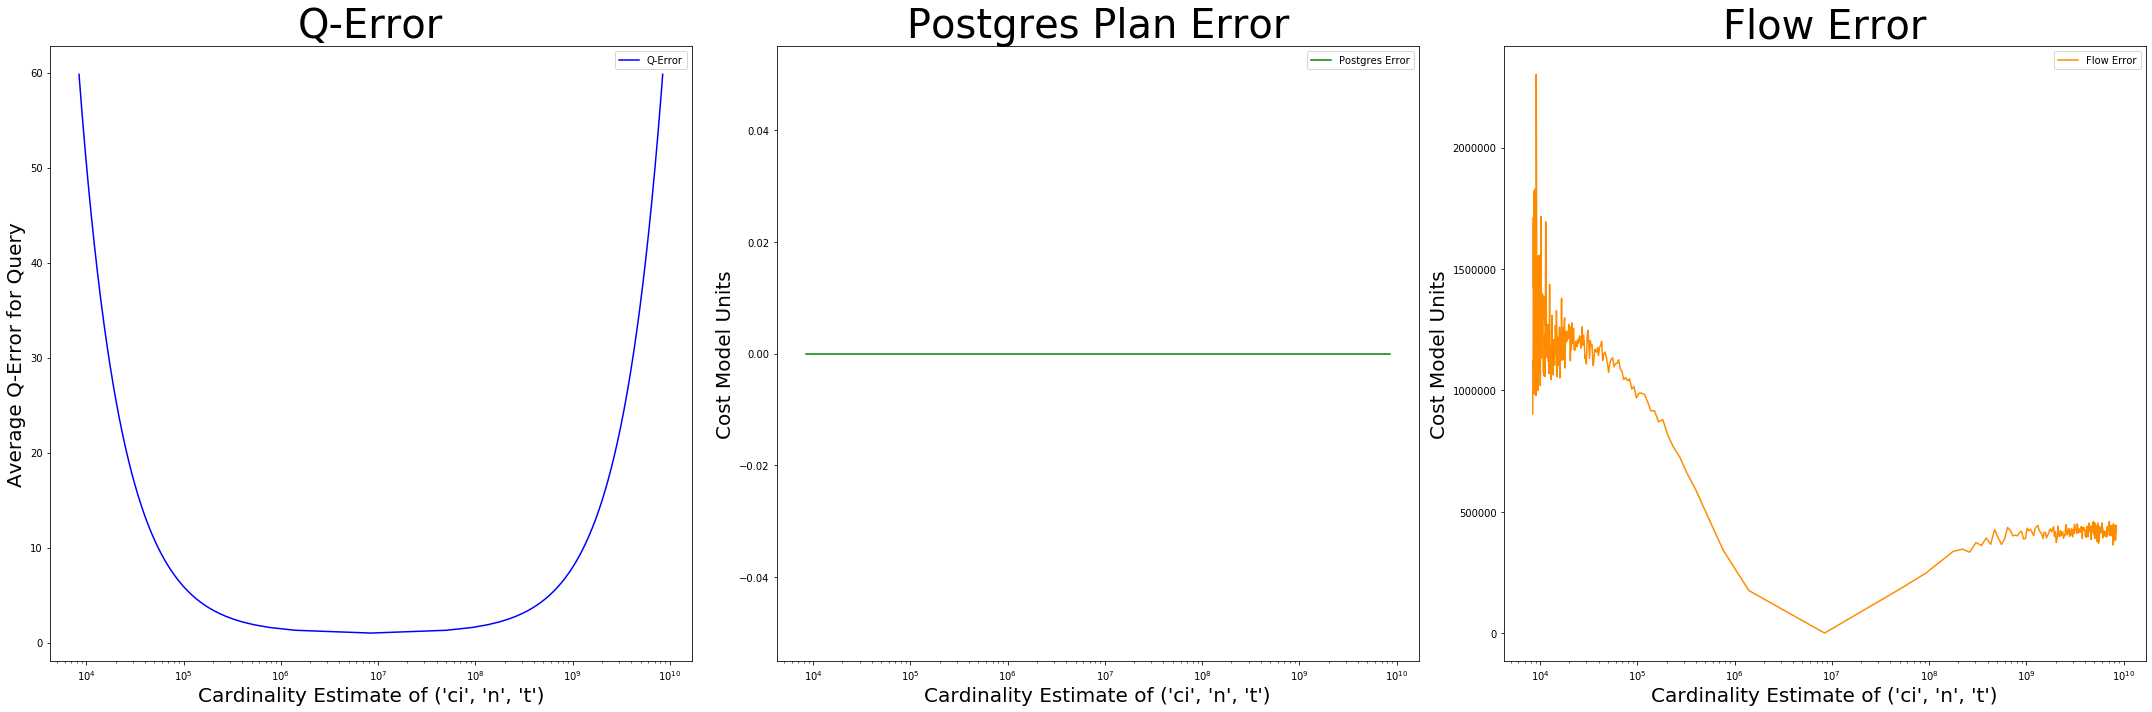

In [151]:
def plot_subsets(subsets):
    xs,qerrs,flow_errs,plan_errs,pg_errs = data[subsets]
    # TODO: add linestyle
    subsets = subsets.replace("[","")
    subsets = subsets.replace("]","")

    fig, axs = plt.subplots(1,3,figsize=(30,10))
    sns.lineplot(xs,qerrs,label="Q-Error", ax=axs[0], color="blue")
    axs[0].set_title("Q-Error",fontsize=40)
    axs[0].set_xscale("log")
    axs[0].set_xlabel("Cardinality Estimate of " + subsets, fontsize=20)
    axs[0].set_ylabel("Average Q-Error for Query", fontsize=20)


    sns.lineplot(xs,pg_errs,label="Postgres Error", ax=axs[1], color="green")
    axs[1].set_title("Postgres Plan Error",fontsize=40)
    axs[1].set_xscale("log")
    axs[1].set_xlabel(subsets, fontsize=20)
    axs[1].set_ylabel("Cost Model Units", fontsize=20)

    #sns.lineplot(xs,plan_errs,label="Plan Error", ax=axs[2], color="red")
    lp = sns.lineplot(xs,flow_errs,label="Flow Error", ax=axs[2], color="darkorange")
    axs[2].set_title("Flow Error",fontsize=40)
    axs[2].set_xscale("log")
    axs[2].set_xlabel("Cardinality Estimate of " + subsets, fontsize=20)
    axs[2].set_ylabel("Cost Model Units", fontsize=20)
   
    subset_name = subsets
    plt.tight_layout()
    plt.savefig("errors-" + str(subset_name) + ".png")
    plt.show()

    
for subset in data:
    plot_subsets(subset)

In [140]:
def run_subset2(subsets1, subsets2, data2):
    xs,ys,qerrs,flow_errs,plan_errs,pg_errs = check_errors2(y[0], subsets1, subsets2, qrep, width=1000)
    subsets1.sort()
    subsets2.sort()
    subsets = subsets1 + subsets2
    subsets = str(subsets)
    data2[subsets] = (xs,ys,qerrs,flow_errs,plan_errs,pg_errs)

data2 = {}
## FIG 1
#subsets1 = [("ci", "n", "rt")]
#subsets2 = [("ci", "n", "t")]

#subsets1 = [("ci", "n")]
#subsets2 = [("kt", "t")]

#subsets1 = [("ci", "n")]
#subsets2 = [("ci", "t")]

## FIG 2
subsets1 = [("kt", "t")]
subsets2 = [("ci", "kt", "t")]

run_subset2(subsets1, subsets2, data2)

1
compute flow-loss took: 0.0014221668243408203
compute plan-loss took: 0.014211654663085938
compute postgres join error took:  0.007836103439331055
compute flow-loss took: 0.0011188983917236328
compute plan-loss took: 0.012284994125366211
compute postgres join error took:  0.007378339767456055
compute flow-loss took: 0.0011627674102783203
compute plan-loss took: 0.011618852615356445
compute postgres join error took:  0.17645907402038574
compute flow-loss took: 0.00128936767578125
compute plan-loss took: 0.012768268585205078
compute postgres join error took:  0.007473945617675781
compute flow-loss took: 0.0010638236999511719
compute plan-loss took: 0.011529207229614258
compute postgres join error took:  0.007213592529296875
compute flow-loss took: 0.001027822494506836
compute plan-loss took: 0.011130809783935547
compute postgres join error took:  0.00720667839050293
compute flow-loss took: 0.0010306835174560547
compute plan-loss took: 0.011335372924804688
compute postgres join error to

compute plan-loss took: 0.0119781494140625
compute postgres join error took:  0.0074214935302734375
compute flow-loss took: 0.0011534690856933594
compute plan-loss took: 0.011456489562988281
compute postgres join error took:  0.00731205940246582
compute flow-loss took: 0.0010538101196289062
compute plan-loss took: 0.011411428451538086
compute postgres join error took:  0.007153034210205078
compute flow-loss took: 0.0010602474212646484
compute plan-loss took: 0.011337757110595703
compute postgres join error took:  0.00710296630859375
compute flow-loss took: 0.0010221004486083984
compute plan-loss took: 0.011402368545532227
compute postgres join error took:  0.0071620941162109375
compute flow-loss took: 0.0011632442474365234
compute plan-loss took: 0.011270284652709961
compute postgres join error took:  0.007326841354370117
compute flow-loss took: 0.0011587142944335938
compute plan-loss took: 0.01131296157836914
compute postgres join error took:  0.0072095394134521484
compute flow-loss t

compute flow-loss took: 0.00125885009765625
compute plan-loss took: 0.011150836944580078
compute postgres join error took:  0.007136106491088867
compute flow-loss took: 0.0011355876922607422
compute plan-loss took: 0.011452198028564453
compute postgres join error took:  0.007193803787231445
compute flow-loss took: 0.00106048583984375
compute plan-loss took: 0.011491775512695312
compute postgres join error took:  0.007256031036376953
compute flow-loss took: 0.0010690689086914062
compute plan-loss took: 0.011404037475585938
compute postgres join error took:  0.0073201656341552734
compute flow-loss took: 0.0011813640594482422
compute plan-loss took: 0.011225223541259766
compute postgres join error took:  0.0071218013763427734
compute flow-loss took: 0.00118255615234375
compute plan-loss took: 0.011247873306274414
compute postgres join error took:  0.007150173187255859
compute flow-loss took: 0.0010738372802734375
compute plan-loss took: 0.011080741882324219
compute postgres join error too

compute plan-loss took: 0.011224508285522461
compute postgres join error took:  0.00715327262878418
compute flow-loss took: 0.0010287761688232422
compute plan-loss took: 0.011096000671386719
compute postgres join error took:  0.0073468685150146484
compute flow-loss took: 0.0010209083557128906
compute plan-loss took: 0.011111736297607422
compute postgres join error took:  0.007124662399291992
compute flow-loss took: 0.0010399818420410156
compute plan-loss took: 0.011096954345703125
compute postgres join error took:  0.007063150405883789
compute flow-loss took: 0.001020193099975586
compute plan-loss took: 0.011261940002441406
compute postgres join error took:  0.0071027278900146484
compute flow-loss took: 0.0011501312255859375
compute plan-loss took: 0.01135873794555664
compute postgres join error took:  0.007146358489990234
compute flow-loss took: 0.0011620521545410156
compute plan-loss took: 0.011209726333618164
compute postgres join error took:  0.0072786808013916016
compute flow-loss

compute plan-loss took: 0.011205434799194336
compute postgres join error took:  0.007143974304199219
compute flow-loss took: 0.0011568069458007812
compute plan-loss took: 0.011124372482299805
compute postgres join error took:  0.007091999053955078
compute flow-loss took: 0.0010209083557128906
compute plan-loss took: 0.011089324951171875
compute postgres join error took:  0.007109165191650391
compute flow-loss took: 0.0010178089141845703
compute plan-loss took: 0.011021614074707031
compute postgres join error took:  0.007277250289916992
compute flow-loss took: 0.0010223388671875
compute plan-loss took: 0.011446952819824219
compute postgres join error took:  0.007149219512939453
compute flow-loss took: 0.0010211467742919922
compute plan-loss took: 0.011379241943359375
compute postgres join error took:  0.0071065425872802734
compute flow-loss took: 0.0010209083557128906
compute plan-loss took: 0.011465311050415039
compute postgres join error took:  0.007165431976318359
compute flow-loss t

compute plan-loss took: 0.011440753936767578
compute postgres join error took:  0.007338047027587891
compute flow-loss took: 0.0010311603546142578
compute plan-loss took: 0.011291027069091797
compute postgres join error took:  0.00719141960144043
compute flow-loss took: 0.0010223388671875
compute plan-loss took: 0.01113748550415039
compute postgres join error took:  0.00711512565612793
compute flow-loss took: 0.0011374950408935547
compute plan-loss took: 0.011368036270141602
compute postgres join error took:  0.007147789001464844
compute flow-loss took: 0.0011386871337890625
compute plan-loss took: 0.011144161224365234
compute postgres join error took:  0.007110595703125
compute flow-loss took: 0.001026153564453125
compute plan-loss took: 0.011181831359863281
compute postgres join error took:  0.007428407669067383
compute flow-loss took: 0.0011394023895263672
compute plan-loss took: 0.011531352996826172
compute postgres join error took:  0.007108926773071289
compute flow-loss took: 0.0

compute plan-loss took: 0.011400461196899414
compute postgres join error took:  0.007117748260498047
compute flow-loss took: 0.001062631607055664
compute plan-loss took: 0.01114034652709961
compute postgres join error took:  0.007110118865966797
compute flow-loss took: 0.0011699199676513672
compute plan-loss took: 0.01139068603515625
compute postgres join error took:  0.007307529449462891
compute flow-loss took: 0.001192331314086914
compute plan-loss took: 0.011059761047363281
compute postgres join error took:  0.007117271423339844
compute flow-loss took: 0.0011844635009765625
compute plan-loss took: 0.011103630065917969
compute postgres join error took:  0.007094144821166992
compute flow-loss took: 0.0010755062103271484
compute plan-loss took: 0.01136159896850586
compute postgres join error took:  0.007123708724975586
compute flow-loss took: 0.0011928081512451172
compute plan-loss took: 0.011299848556518555
compute postgres join error took:  0.0071163177490234375
compute flow-loss too

compute plan-loss took: 0.011566638946533203
compute postgres join error took:  0.007166147232055664
compute flow-loss took: 0.0010373592376708984
compute plan-loss took: 0.011216878890991211
compute postgres join error took:  0.0071637630462646484
compute flow-loss took: 0.0010290145874023438
compute plan-loss took: 0.011352777481079102
compute postgres join error took:  0.007161855697631836
compute flow-loss took: 0.0010251998901367188
compute plan-loss took: 0.011141777038574219
compute postgres join error took:  0.0071337223052978516
compute flow-loss took: 0.0010251998901367188
compute plan-loss took: 0.011088371276855469
compute postgres join error took:  0.007294893264770508
compute flow-loss took: 0.0011284351348876953
compute plan-loss took: 0.011212825775146484
compute postgres join error took:  0.007132053375244141
compute flow-loss took: 0.0010221004486083984
compute plan-loss took: 0.01159358024597168
compute postgres join error took:  0.007193565368652344
compute flow-los

compute plan-loss took: 0.011175870895385742
compute postgres join error took:  0.007040739059448242
compute flow-loss took: 0.0011680126190185547
compute plan-loss took: 0.011184453964233398
compute postgres join error took:  0.007090330123901367
compute flow-loss took: 0.0010385513305664062
compute plan-loss took: 0.011270284652709961
compute postgres join error took:  0.0073015689849853516
compute flow-loss took: 0.0010428428649902344
compute plan-loss took: 0.010883569717407227
compute postgres join error took:  0.007052898406982422
compute flow-loss took: 0.0010464191436767578
compute plan-loss took: 0.011031389236450195
compute postgres join error took:  0.00709843635559082
compute flow-loss took: 0.0011742115020751953
compute plan-loss took: 0.010942459106445312
compute postgres join error took:  0.007031440734863281
compute flow-loss took: 0.0010197162628173828
compute plan-loss took: 0.010863542556762695
compute postgres join error took:  0.007056474685668945
compute flow-loss

compute plan-loss took: 0.011249780654907227
compute postgres join error took:  0.007118701934814453
compute flow-loss took: 0.0012090206146240234
compute plan-loss took: 0.011073827743530273
compute postgres join error took:  0.007014036178588867
compute flow-loss took: 0.0011823177337646484
compute plan-loss took: 0.010976076126098633
compute postgres join error took:  0.0071184635162353516
compute flow-loss took: 0.0010590553283691406
compute plan-loss took: 0.011317968368530273
compute postgres join error took:  0.007071733474731445
compute flow-loss took: 0.0011837482452392578
compute plan-loss took: 0.011042594909667969
compute postgres join error took:  0.007188558578491211
compute flow-loss took: 0.0010483264923095703
compute plan-loss took: 0.011016130447387695
compute postgres join error took:  0.007049083709716797
compute flow-loss took: 0.0010707378387451172
compute plan-loss took: 0.0109405517578125
compute postgres join error took:  0.007085561752319336
compute flow-loss 

compute postgres join error took:  0.007096052169799805
compute flow-loss took: 0.0012249946594238281
compute plan-loss took: 0.01130986213684082
compute postgres join error took:  0.007112979888916016
compute flow-loss took: 0.001043081283569336
compute plan-loss took: 0.011217117309570312
compute postgres join error took:  0.007275581359863281
compute flow-loss took: 0.0010418891906738281
compute plan-loss took: 0.01127767562866211
compute postgres join error took:  0.007075309753417969
compute flow-loss took: 0.0011687278747558594
compute plan-loss took: 0.011154651641845703
compute postgres join error took:  0.007158756256103516
compute flow-loss took: 0.0010428428649902344
compute plan-loss took: 0.01119232177734375
compute postgres join error took:  0.007013797760009766
compute flow-loss took: 0.0011649131774902344
compute plan-loss took: 0.011246204376220703
compute postgres join error took:  0.007134675979614258
compute flow-loss took: 0.0010437965393066406
compute plan-loss to

compute postgres join error took:  0.007444143295288086
compute flow-loss took: 0.001073598861694336
compute plan-loss took: 0.011473655700683594
compute postgres join error took:  0.007180213928222656
compute flow-loss took: 0.0010592937469482422
compute plan-loss took: 0.011120319366455078
compute postgres join error took:  0.007117509841918945
compute flow-loss took: 0.0010678768157958984
compute plan-loss took: 0.01099848747253418
compute postgres join error took:  0.0070781707763671875
compute flow-loss took: 0.0010673999786376953
compute plan-loss took: 0.010942459106445312
compute postgres join error took:  0.007211923599243164
compute flow-loss took: 0.0010728836059570312
compute plan-loss took: 0.011207342147827148
compute postgres join error took:  0.0070955753326416016
compute flow-loss took: 0.0012102127075195312
compute plan-loss took: 0.011212825775146484
compute postgres join error took:  0.007052421569824219
compute flow-loss took: 0.0010793209075927734
compute plan-los

compute postgres join error took:  0.007124423980712891
compute flow-loss took: 0.001123189926147461
compute plan-loss took: 0.010938882827758789
compute postgres join error took:  0.007250785827636719
compute flow-loss took: 0.0010290145874023438
compute plan-loss took: 0.010907411575317383
compute postgres join error took:  0.007074832916259766
compute flow-loss took: 0.0010521411895751953
compute plan-loss took: 0.011217594146728516
compute postgres join error took:  0.007102251052856445
compute flow-loss took: 0.0010459423065185547
compute plan-loss took: 0.010940790176391602
compute postgres join error took:  0.007093191146850586
negative loss for  flow-loss
-260044.25
compute flow-loss took: 0.0011749267578125
compute plan-loss took: 0.010936975479125977
compute postgres join error took:  0.0070760250091552734
compute flow-loss took: 0.0011796951293945312
compute plan-loss took: 0.010820388793945312
compute postgres join error took:  0.007211446762084961
compute flow-loss took: 0

compute postgres join error took:  0.00706028938293457
compute flow-loss took: 0.0010349750518798828
compute plan-loss took: 0.010865211486816406
compute postgres join error took:  0.007044792175292969
compute flow-loss took: 0.0010330677032470703
compute plan-loss took: 0.010973215103149414
compute postgres join error took:  0.007058620452880859
compute flow-loss took: 0.0010616779327392578
compute plan-loss took: 0.011030197143554688
compute postgres join error took:  0.0072667598724365234
compute flow-loss took: 0.0010275840759277344
compute plan-loss took: 0.011283397674560547
compute postgres join error took:  0.007107257843017578
compute flow-loss took: 0.0011601448059082031
compute plan-loss took: 0.010986566543579102
compute postgres join error took:  0.0070683956146240234
compute flow-loss took: 0.0010290145874023438
compute plan-loss took: 0.011108160018920898
compute postgres join error took:  0.007118701934814453
compute flow-loss took: 0.0010323524475097656
compute plan-lo

compute postgres join error took:  0.007243156433105469
compute flow-loss took: 0.0012028217315673828
compute plan-loss took: 0.01105189323425293
compute postgres join error took:  0.007060527801513672
compute flow-loss took: 0.0010514259338378906
compute plan-loss took: 0.011187314987182617
compute postgres join error took:  0.007140398025512695
compute flow-loss took: 0.0011699199676513672
compute plan-loss took: 0.010974884033203125
compute postgres join error took:  0.007120847702026367
compute flow-loss took: 0.0011668205261230469
compute plan-loss took: 0.011122941970825195
compute postgres join error took:  0.007118940353393555
compute flow-loss took: 0.0010366439819335938
compute plan-loss took: 0.010982990264892578
compute postgres join error took:  0.007253885269165039
compute flow-loss took: 0.0010259151458740234
compute plan-loss took: 0.010922670364379883
compute postgres join error took:  0.007082939147949219
compute flow-loss took: 0.0010230541229248047
compute plan-loss

compute plan-loss took: 0.01099848747253418
compute postgres join error took:  0.007096767425537109
compute flow-loss took: 0.0011570453643798828
compute plan-loss took: 0.0113525390625
compute postgres join error took:  0.007093906402587891
compute flow-loss took: 0.00102996826171875
compute plan-loss took: 0.011281251907348633
compute postgres join error took:  0.007260799407958984
compute flow-loss took: 0.0010256767272949219
compute plan-loss took: 0.011240959167480469
compute postgres join error took:  0.007142543792724609
compute flow-loss took: 0.0010292530059814453
compute plan-loss took: 0.01106572151184082
compute postgres join error took:  0.007096767425537109
compute flow-loss took: 0.0010275840759277344
compute plan-loss took: 0.011177539825439453
compute postgres join error took:  0.007118701934814453
compute flow-loss took: 0.0010304450988769531
compute plan-loss took: 0.011023998260498047
compute postgres join error took:  0.0071010589599609375
compute flow-loss took: 0

compute plan-loss took: 0.01118016242980957
compute postgres join error took:  0.0071604251861572266
compute flow-loss took: 0.0010628700256347656
compute plan-loss took: 0.01099395751953125
compute postgres join error took:  0.007061481475830078
compute flow-loss took: 0.001058816909790039
compute plan-loss took: 0.010992765426635742
compute postgres join error took:  0.007145881652832031
compute flow-loss took: 0.0010230541229248047
compute plan-loss took: 0.011323213577270508
compute postgres join error took:  0.00712132453918457
compute flow-loss took: 0.0010285377502441406
compute plan-loss took: 0.011080265045166016
compute postgres join error took:  0.0072171688079833984
compute flow-loss took: 0.0010297298431396484
compute plan-loss took: 0.01099252700805664
compute postgres join error took:  0.007053852081298828
compute flow-loss took: 0.0010225772857666016
compute plan-loss took: 0.01107645034790039
compute postgres join error took:  0.007047891616821289
compute flow-loss too

compute plan-loss took: 0.011160850524902344
compute postgres join error took:  0.007068634033203125
compute flow-loss took: 0.0010805130004882812
compute plan-loss took: 0.011150360107421875
compute postgres join error took:  0.007544279098510742
compute flow-loss took: 0.0011420249938964844
compute plan-loss took: 0.011076211929321289
compute postgres join error took:  0.007035970687866211
compute flow-loss took: 0.0010623931884765625
compute plan-loss took: 0.011167764663696289
compute postgres join error took:  0.0071070194244384766
compute flow-loss took: 0.0011124610900878906
compute plan-loss took: 0.011063814163208008
compute postgres join error took:  0.007007598876953125
compute flow-loss took: 0.0010523796081542969
compute plan-loss took: 0.011172294616699219
compute postgres join error took:  0.0070383548736572266
compute flow-loss took: 0.0010874271392822266
compute plan-loss took: 0.010875225067138672
compute postgres join error took:  0.0072174072265625
compute flow-loss

compute plan-loss took: 0.011203289031982422
compute postgres join error took:  0.00707697868347168
compute flow-loss took: 0.001033782958984375
compute plan-loss took: 0.010916709899902344
compute postgres join error took:  0.007085561752319336
compute flow-loss took: 0.0010924339294433594
compute plan-loss took: 0.011128425598144531
compute postgres join error took:  0.007024049758911133
compute flow-loss took: 0.0010340213775634766
compute plan-loss took: 0.011057853698730469
compute postgres join error took:  0.0072405338287353516
compute flow-loss took: 0.0010232925415039062
compute plan-loss took: 0.011089801788330078
compute postgres join error took:  0.007056474685668945
compute flow-loss took: 0.0011050701141357422
compute plan-loss took: 0.011007547378540039
compute postgres join error took:  0.007053375244140625
compute flow-loss took: 0.0011963844299316406
compute plan-loss took: 0.011204719543457031
compute postgres join error took:  0.0072553157806396484
compute flow-loss

compute plan-loss took: 0.011189699172973633
compute postgres join error took:  0.007268667221069336
compute flow-loss took: 0.0010342597961425781
compute plan-loss took: 0.011133193969726562
compute postgres join error took:  0.0071637630462646484
compute flow-loss took: 0.0011670589447021484
compute plan-loss took: 0.01088094711303711
compute postgres join error took:  0.007193326950073242
compute flow-loss took: 0.0010886192321777344
compute plan-loss took: 0.010905265808105469
compute postgres join error took:  0.007065773010253906
compute flow-loss took: 0.0011546611785888672
compute plan-loss took: 0.010983467102050781
compute postgres join error took:  0.007057666778564453
31
compute flow-loss took: 0.0011706352233886719
compute plan-loss took: 0.011076688766479492
compute postgres join error took:  0.007360696792602539
compute flow-loss took: 0.0010673999786376953
compute plan-loss took: 0.011072874069213867
compute postgres join error took:  0.0071070194244384766
compute flow-

compute postgres join error took:  0.007142543792724609
compute flow-loss took: 0.0010364055633544922
compute plan-loss took: 0.011025667190551758
compute postgres join error took:  0.007137775421142578
compute flow-loss took: 0.001039266586303711
compute plan-loss took: 0.011136770248413086
compute postgres join error took:  0.007139444351196289
compute flow-loss took: 0.0011670589447021484
compute plan-loss took: 0.01090240478515625
compute postgres join error took:  0.007279872894287109
compute flow-loss took: 0.0010330677032470703
compute plan-loss took: 0.011136531829833984
compute postgres join error took:  0.0071218013763427734
compute flow-loss took: 0.0010516643524169922
compute plan-loss took: 0.010938882827758789
compute postgres join error took:  0.007085323333740234
compute flow-loss took: 0.0010318756103515625
compute plan-loss took: 0.011176824569702148
compute postgres join error took:  0.007117509841918945
compute flow-loss took: 0.0010318756103515625
compute plan-loss

compute postgres join error took:  0.007465839385986328
compute flow-loss took: 0.0010385513305664062
compute plan-loss took: 0.01135110855102539
compute postgres join error took:  0.007124185562133789
compute flow-loss took: 0.0010411739349365234
compute plan-loss took: 0.01094675064086914
compute postgres join error took:  0.007065773010253906
compute flow-loss took: 0.0010600090026855469
compute plan-loss took: 0.011120080947875977
compute postgres join error took:  0.007106781005859375
compute flow-loss took: 0.001039266586303711
compute plan-loss took: 0.01103973388671875
compute postgres join error took:  0.0070574283599853516
compute flow-loss took: 0.0010378360748291016
compute plan-loss took: 0.011003732681274414
compute postgres join error took:  0.00722813606262207
compute flow-loss took: 0.0010328292846679688
compute plan-loss took: 0.010935544967651367
compute postgres join error took:  0.007063150405883789
compute flow-loss took: 0.0010297298431396484
compute plan-loss to

compute postgres join error took:  0.007096767425537109
compute flow-loss took: 0.0010747909545898438
compute plan-loss took: 0.01117396354675293
compute postgres join error took:  0.007093667984008789
compute flow-loss took: 0.0010797977447509766
compute plan-loss took: 0.011152505874633789
compute postgres join error took:  0.007306575775146484
compute flow-loss took: 0.0010840892791748047
compute plan-loss took: 0.011114120483398438
compute postgres join error took:  0.0070111751556396484
compute flow-loss took: 0.0010833740234375
compute plan-loss took: 0.011136531829833984
compute postgres join error took:  0.0070726871490478516
compute flow-loss took: 0.0010826587677001953
compute plan-loss took: 0.01105809211730957
compute postgres join error took:  0.007075071334838867
compute flow-loss took: 0.0010557174682617188
compute plan-loss took: 0.011137008666992188
compute postgres join error took:  0.007078886032104492
compute flow-loss took: 0.0010690689086914062
compute plan-loss t

compute flow-loss took: 0.001032114028930664
compute plan-loss took: 0.011496305465698242
compute postgres join error took:  0.007120370864868164
compute flow-loss took: 0.0010423660278320312
compute plan-loss took: 0.011076927185058594
compute postgres join error took:  0.007236003875732422
compute flow-loss took: 0.0010378360748291016
compute plan-loss took: 0.011063098907470703
compute postgres join error took:  0.007177829742431641
compute flow-loss took: 0.0010366439819335938
compute plan-loss took: 0.011234045028686523
compute postgres join error took:  0.007069826126098633
compute flow-loss took: 0.0010416507720947266
compute plan-loss took: 0.011186838150024414
compute postgres join error took:  0.007269144058227539
compute flow-loss took: 0.0010342597961425781
compute plan-loss took: 0.011172294616699219
compute postgres join error took:  0.007075309753417969
compute flow-loss took: 0.0010378360748291016
compute plan-loss took: 0.011074304580688477
compute postgres join error 

compute postgres join error took:  0.007399559020996094
compute flow-loss took: 0.0010905265808105469
compute plan-loss took: 0.011282920837402344
compute postgres join error took:  0.007107257843017578
compute flow-loss took: 0.001035451889038086
compute plan-loss took: 0.011029958724975586
compute postgres join error took:  0.007260322570800781
compute flow-loss took: 0.0010309219360351562
compute plan-loss took: 0.01101374626159668
compute postgres join error took:  0.007035255432128906
compute flow-loss took: 0.001033782958984375
compute plan-loss took: 0.011002063751220703
compute postgres join error took:  0.007090091705322266
compute flow-loss took: 0.0010519027709960938
compute plan-loss took: 0.011152267456054688
compute postgres join error took:  0.007092475891113281
compute flow-loss took: 0.0010581016540527344
compute plan-loss took: 0.011010885238647461
compute postgres join error took:  0.007099151611328125
compute flow-loss took: 0.0010590553283691406
compute plan-loss t

compute postgres join error took:  0.007302522659301758
compute flow-loss took: 0.0010440349578857422
compute plan-loss took: 0.011155128479003906
compute postgres join error took:  0.00711369514465332
compute flow-loss took: 0.0010383129119873047
compute plan-loss took: 0.011083602905273438
compute postgres join error took:  0.0070819854736328125
compute flow-loss took: 0.0010390281677246094
compute plan-loss took: 0.010967016220092773
compute postgres join error took:  0.0071103572845458984
compute flow-loss took: 0.0010373592376708984
compute plan-loss took: 0.011031389236450195
compute postgres join error took:  0.007225751876831055
compute flow-loss took: 0.0010223388671875
compute plan-loss took: 0.011152982711791992
compute postgres join error took:  0.007133007049560547
compute flow-loss took: 0.0010268688201904297
compute plan-loss took: 0.011255502700805664
compute postgres join error took:  0.0071146488189697266
compute flow-loss took: 0.0010306835174560547
compute plan-loss

compute postgres join error took:  0.0073850154876708984
compute flow-loss took: 0.0010516643524169922
compute plan-loss took: 0.011138200759887695
compute postgres join error took:  0.007323026657104492
compute flow-loss took: 0.0010349750518798828
compute plan-loss took: 0.01102447509765625
compute postgres join error took:  0.0070650577545166016
compute flow-loss took: 0.0010340213775634766
compute plan-loss took: 0.010983467102050781
compute postgres join error took:  0.007078647613525391
compute flow-loss took: 0.0010590553283691406
compute plan-loss took: 0.011005401611328125
compute postgres join error took:  0.00724339485168457
compute flow-loss took: 0.0010502338409423828
compute plan-loss took: 0.011083602905273438
compute postgres join error took:  0.007214069366455078
compute flow-loss took: 0.0010657310485839844
compute plan-loss took: 0.011142969131469727
compute postgres join error took:  0.0073130130767822266
compute flow-loss took: 0.0010714530944824219
compute plan-lo

compute postgres join error took:  0.007291555404663086
compute flow-loss took: 0.0010650157928466797
compute plan-loss took: 0.011210918426513672
compute postgres join error took:  0.007215023040771484
compute flow-loss took: 0.001055002212524414
compute plan-loss took: 0.011065244674682617
compute postgres join error took:  0.007089376449584961
compute flow-loss took: 0.0010616779327392578
compute plan-loss took: 0.010943412780761719
compute postgres join error took:  0.0072214603424072266
compute flow-loss took: 0.0010519027709960938
compute plan-loss took: 0.01092076301574707
compute postgres join error took:  0.007084369659423828
compute flow-loss took: 0.0010344982147216797
compute plan-loss took: 0.010897636413574219
compute postgres join error took:  0.0070722103118896484
compute flow-loss took: 0.0010442733764648438
compute plan-loss took: 0.01091456413269043
compute postgres join error took:  0.007071018218994141
compute flow-loss took: 0.0010311603546142578
compute plan-loss

compute postgres join error took:  0.007508754730224609
compute flow-loss took: 0.001043081283569336
compute plan-loss took: 0.011368274688720703
compute postgres join error took:  0.007085084915161133
compute flow-loss took: 0.0011365413665771484
compute plan-loss took: 0.011143207550048828
compute postgres join error took:  0.007103681564331055
compute flow-loss took: 0.0010192394256591797
compute plan-loss took: 0.011328697204589844
compute postgres join error took:  0.007052421569824219
compute flow-loss took: 0.0011382102966308594
compute plan-loss took: 0.01121068000793457
compute postgres join error took:  0.007101535797119141
compute flow-loss took: 0.0011458396911621094
compute plan-loss took: 0.011276006698608398
compute postgres join error took:  0.007183551788330078
compute flow-loss took: 0.0011336803436279297
compute plan-loss took: 0.011044502258300781
compute postgres join error took:  0.007072925567626953
compute flow-loss took: 0.0010347366333007812
compute plan-loss 

compute plan-loss took: 0.011225223541259766
compute postgres join error took:  0.0071010589599609375
compute flow-loss took: 0.0011701583862304688
compute plan-loss took: 0.011458396911621094
compute postgres join error took:  0.007185459136962891
compute flow-loss took: 0.0010256767272949219
compute plan-loss took: 0.011324405670166016
compute postgres join error took:  0.007238626480102539
compute flow-loss took: 0.0011358261108398438
compute plan-loss took: 0.011022567749023438
compute postgres join error took:  0.0070612430572509766
compute flow-loss took: 0.0010213851928710938
compute plan-loss took: 0.01121377944946289
compute postgres join error took:  0.007167816162109375
compute flow-loss took: 0.0011355876922607422
compute plan-loss took: 0.011134862899780273
compute postgres join error took:  0.007372379302978516
compute flow-loss took: 0.00102996826171875
compute plan-loss took: 0.011382818222045898
compute postgres join error took:  0.007325887680053711
compute flow-loss 

compute postgres join error took:  0.007212162017822266
compute flow-loss took: 0.0010752677917480469
compute plan-loss took: 0.011033296585083008
compute postgres join error took:  0.007021665573120117
compute flow-loss took: 0.0010480880737304688
compute plan-loss took: 0.011165857315063477
compute postgres join error took:  0.0070323944091796875
compute flow-loss took: 0.001069784164428711
compute plan-loss took: 0.010955095291137695
compute postgres join error took:  0.007131338119506836
compute flow-loss took: 0.001069784164428711
compute plan-loss took: 0.011339902877807617
compute postgres join error took:  0.007073879241943359
compute flow-loss took: 0.0010647773742675781
compute plan-loss took: 0.01100611686706543
compute postgres join error took:  0.007202863693237305
compute flow-loss took: 0.0010402202606201172
compute plan-loss took: 0.011081933975219727
compute postgres join error took:  0.007043123245239258
compute flow-loss took: 0.0010290145874023438
compute plan-loss 

compute postgres join error took:  0.007081508636474609
compute flow-loss took: 0.0010344982147216797
compute plan-loss took: 0.011091470718383789
compute postgres join error took:  0.007051229476928711
compute flow-loss took: 0.0011458396911621094
compute plan-loss took: 0.011301994323730469
compute postgres join error took:  0.007225751876831055
compute flow-loss took: 0.0011436939239501953
compute plan-loss took: 0.011095762252807617
compute postgres join error took:  0.007376194000244141
compute flow-loss took: 0.0010268688201904297
compute plan-loss took: 0.011121749877929688
compute postgres join error took:  0.007099628448486328
compute flow-loss took: 0.0010180473327636719
compute plan-loss took: 0.011200904846191406
compute postgres join error took:  0.007055521011352539
compute flow-loss took: 0.0010251998901367188
compute plan-loss took: 0.010984659194946289
compute postgres join error took:  0.00704503059387207
compute flow-loss took: 0.0010170936584472656
compute plan-loss

compute postgres join error took:  0.007264614105224609
compute flow-loss took: 0.0010349750518798828
compute plan-loss took: 0.011139392852783203
compute postgres join error took:  0.007067680358886719
compute flow-loss took: 0.0010297298431396484
compute plan-loss took: 0.011088132858276367
compute postgres join error took:  0.00706791877746582
compute flow-loss took: 0.0010275840759277344
compute plan-loss took: 0.011011600494384766
compute postgres join error took:  0.0072443485260009766
compute flow-loss took: 0.0010247230529785156
compute plan-loss took: 0.010844230651855469
compute postgres join error took:  0.007219791412353516
compute flow-loss took: 0.001018524169921875
compute plan-loss took: 0.010916948318481445
compute postgres join error took:  0.007083415985107422
compute flow-loss took: 0.0010442733764648438
compute plan-loss took: 0.011465787887573242
compute postgres join error took:  0.007079601287841797
compute flow-loss took: 0.0011632442474365234
compute plan-loss

compute postgres join error took:  0.007345676422119141
compute flow-loss took: 0.0010349750518798828
compute plan-loss took: 0.0113983154296875
compute postgres join error took:  0.0072917938232421875
compute flow-loss took: 0.0010333061218261719
compute plan-loss took: 0.011478424072265625
compute postgres join error took:  0.007099151611328125
compute flow-loss took: 0.0011394023895263672
compute plan-loss took: 0.011171340942382812
compute postgres join error took:  0.007125139236450195
compute flow-loss took: 0.0010571479797363281
compute plan-loss took: 0.011086702346801758
compute postgres join error took:  0.007074594497680664
compute flow-loss took: 0.0011358261108398438
compute plan-loss took: 0.010920047760009766
compute postgres join error took:  0.00706171989440918
compute flow-loss took: 0.0010457038879394531
compute plan-loss took: 0.011223793029785156
compute postgres join error took:  0.0072383880615234375
compute flow-loss took: 0.0011441707611083984
compute plan-loss

compute postgres join error took:  0.007124185562133789
compute flow-loss took: 0.00107574462890625
compute plan-loss took: 0.010941743850708008
compute postgres join error took:  0.007073402404785156
compute flow-loss took: 0.0012001991271972656
compute plan-loss took: 0.011348962783813477
compute postgres join error took:  0.007256746292114258
compute flow-loss took: 0.0010967254638671875
compute plan-loss took: 0.011210918426513672
compute postgres join error took:  0.007318258285522461
compute flow-loss took: 0.0010833740234375
compute plan-loss took: 0.011055946350097656
compute postgres join error took:  0.007061958312988281
compute flow-loss took: 0.0010759830474853516
compute plan-loss took: 0.01105189323425293
compute postgres join error took:  0.00706171989440918
compute flow-loss took: 0.001093149185180664
compute plan-loss took: 0.010912418365478516
compute postgres join error took:  0.007093667984008789
compute flow-loss took: 0.0011861324310302734
compute plan-loss took: 

compute postgres join error took:  0.007271766662597656
compute flow-loss took: 0.0010955333709716797
compute plan-loss took: 0.011142730712890625
compute postgres join error took:  0.007068634033203125
compute flow-loss took: 0.0010862350463867188
compute plan-loss took: 0.011129617691040039
compute postgres join error took:  0.007081031799316406
compute flow-loss took: 0.001085042953491211
compute plan-loss took: 0.010875940322875977
compute postgres join error took:  0.007100343704223633
compute flow-loss took: 0.0011205673217773438
compute plan-loss took: 0.011090755462646484
compute postgres join error took:  0.0070760250091552734
compute flow-loss took: 0.0011072158813476562
compute plan-loss took: 0.010908842086791992
compute postgres join error took:  0.0072324275970458984
compute flow-loss took: 0.0010991096496582031
compute plan-loss took: 0.011133193969726562
compute postgres join error took:  0.007101297378540039
compute flow-loss took: 0.0011997222900390625
compute plan-lo

compute postgres join error took:  0.0071032047271728516
compute flow-loss took: 0.001262664794921875
compute plan-loss took: 0.011041641235351562
compute postgres join error took:  0.007091045379638672
compute flow-loss took: 0.0010612010955810547
compute plan-loss took: 0.011196136474609375
compute postgres join error took:  0.007295370101928711
compute flow-loss took: 0.0010657310485839844
compute plan-loss took: 0.011072397232055664
compute postgres join error took:  0.007133007049560547
compute flow-loss took: 0.0010631084442138672
compute plan-loss took: 0.010869026184082031
compute postgres join error took:  0.007099628448486328
compute flow-loss took: 0.0010535717010498047
compute plan-loss took: 0.011111259460449219
compute postgres join error took:  0.007136106491088867
compute flow-loss took: 0.00116729736328125
compute plan-loss took: 0.010993480682373047
compute postgres join error took:  0.007059574127197266
compute flow-loss took: 0.0011789798736572266
compute plan-loss 

compute postgres join error took:  0.0071430206298828125
compute flow-loss took: 0.0010569095611572266
compute plan-loss took: 0.01103067398071289
compute postgres join error took:  0.007060050964355469
compute flow-loss took: 0.0010576248168945312
compute plan-loss took: 0.011132001876831055
compute postgres join error took:  0.0070819854736328125
compute flow-loss took: 0.0010607242584228516
compute plan-loss took: 0.011137962341308594
compute postgres join error took:  0.007058382034301758
compute flow-loss took: 0.001172780990600586
compute plan-loss took: 0.0109710693359375
compute postgres join error took:  0.007220268249511719
compute flow-loss took: 0.0010797977447509766
compute plan-loss took: 0.010956048965454102
compute postgres join error took:  0.007038116455078125
compute flow-loss took: 0.0011985301971435547
compute plan-loss took: 0.010924816131591797
compute postgres join error took:  0.00708460807800293
compute flow-loss took: 0.0010824203491210938
compute plan-loss t

compute postgres join error took:  0.007092952728271484
compute flow-loss took: 0.0012760162353515625
compute plan-loss took: 0.011031389236450195
compute postgres join error took:  0.007221698760986328
compute flow-loss took: 0.0011022090911865234
compute plan-loss took: 0.011054039001464844
compute postgres join error took:  0.007121562957763672
compute flow-loss took: 0.0012080669403076172
compute plan-loss took: 0.011077880859375
compute postgres join error took:  0.007127285003662109
compute flow-loss took: 0.0011546611785888672
compute plan-loss took: 0.01102900505065918
compute postgres join error took:  0.007115364074707031
compute flow-loss took: 0.0011749267578125
compute plan-loss took: 0.011101484298706055
compute postgres join error took:  0.007107734680175781
compute flow-loss took: 0.0011658668518066406
compute plan-loss took: 0.01094508171081543
compute postgres join error took:  0.007237911224365234
compute flow-loss took: 0.0010471343994140625
compute plan-loss took: 

compute postgres join error took:  0.007910490036010742
compute flow-loss took: 0.0010671615600585938
compute plan-loss took: 0.011237144470214844
compute postgres join error took:  0.007097482681274414
compute flow-loss took: 0.001071929931640625
compute plan-loss took: 0.011317253112792969
compute postgres join error took:  0.007070064544677734
compute flow-loss took: 0.001081705093383789
compute plan-loss took: 0.010979890823364258
compute postgres join error took:  0.007242441177368164
compute flow-loss took: 0.0010907649993896484
compute plan-loss took: 0.01125192642211914
compute postgres join error took:  0.0070912837982177734
compute flow-loss took: 0.0010943412780761719
compute plan-loss took: 0.011296510696411133
compute postgres join error took:  0.007081031799316406
compute flow-loss took: 0.0010895729064941406
compute plan-loss took: 0.010872364044189453
compute postgres join error took:  0.007125139236450195
compute flow-loss took: 0.0010950565338134766
compute plan-loss 

compute postgres join error took:  0.007333278656005859
compute flow-loss took: 0.0011298656463623047
compute plan-loss took: 0.01133418083190918
compute postgres join error took:  0.007330894470214844
compute flow-loss took: 0.0010764598846435547
compute plan-loss took: 0.011591911315917969
compute postgres join error took:  0.0072214603424072266
compute flow-loss took: 0.0010726451873779297
compute plan-loss took: 0.011200428009033203
compute postgres join error took:  0.007098674774169922
compute flow-loss took: 0.001169443130493164
compute plan-loss took: 0.010859251022338867
compute postgres join error took:  0.007125377655029297
compute flow-loss took: 0.0010800361633300781
compute plan-loss took: 0.01111602783203125
compute postgres join error took:  0.0073490142822265625
compute flow-loss took: 0.0010750293731689453
compute plan-loss took: 0.0112762451171875
compute postgres join error took:  0.007361412048339844
compute flow-loss took: 0.0010650157928466797
compute plan-loss t

compute plan-loss took: 0.011051177978515625
compute postgres join error took:  0.0070955753326416016
compute flow-loss took: 0.0011873245239257812
compute plan-loss took: 0.010978937149047852
compute postgres join error took:  0.00710296630859375
compute flow-loss took: 0.0011675357818603516
compute plan-loss took: 0.010945558547973633
compute postgres join error took:  0.0072977542877197266
compute flow-loss took: 0.0010552406311035156
compute plan-loss took: 0.011095285415649414
compute postgres join error took:  0.0071163177490234375
compute flow-loss took: 0.0011870861053466797
compute plan-loss took: 0.01095271110534668
compute postgres join error took:  0.007063627243041992
compute flow-loss took: 0.0010833740234375
compute plan-loss took: 0.010875701904296875
compute postgres join error took:  0.00711822509765625
compute flow-loss took: 0.0011949539184570312
compute plan-loss took: 0.011066913604736328
compute postgres join error took:  0.007099151611328125
compute flow-loss to

compute plan-loss took: 0.010973930358886719
compute postgres join error took:  0.007161855697631836
compute flow-loss took: 0.0011899471282958984
compute plan-loss took: 0.01090383529663086
compute postgres join error took:  0.007099151611328125
compute flow-loss took: 0.0012025833129882812
compute plan-loss took: 0.011217355728149414
compute postgres join error took:  0.007134199142456055
compute flow-loss took: 0.001184701919555664
compute plan-loss took: 0.010901451110839844
compute postgres join error took:  0.007090091705322266
compute flow-loss took: 0.0010902881622314453
compute plan-loss took: 0.010856151580810547
compute postgres join error took:  0.007204532623291016
compute flow-loss took: 0.0011830329895019531
compute plan-loss took: 0.010807514190673828
compute postgres join error took:  0.007111787796020508
compute flow-loss took: 0.0011644363403320312
compute plan-loss took: 0.010870218276977539
compute postgres join error took:  0.0070531368255615234
compute flow-loss 

compute plan-loss took: 0.010980367660522461
compute postgres join error took:  0.007082700729370117
compute flow-loss took: 0.0010344982147216797
compute plan-loss took: 0.011086463928222656
compute postgres join error took:  0.0073719024658203125
compute flow-loss took: 0.0011451244354248047
compute plan-loss took: 0.011330604553222656
compute postgres join error took:  0.0071086883544921875
compute flow-loss took: 0.0011630058288574219
compute plan-loss took: 0.010869026184082031
compute postgres join error took:  0.0069828033447265625
compute flow-loss took: 0.0010597705841064453
compute plan-loss took: 0.010886669158935547
compute postgres join error took:  0.00695347785949707
compute flow-loss took: 0.0010786056518554688
compute plan-loss took: 0.011036396026611328
compute postgres join error took:  0.00706171989440918
compute flow-loss took: 0.0010998249053955078
compute plan-loss took: 0.010916948318481445
compute postgres join error took:  0.007250070571899414
compute flow-los

compute plan-loss took: 0.011152982711791992
compute postgres join error took:  0.007124900817871094
compute flow-loss took: 0.0010445117950439453
compute plan-loss took: 0.011296749114990234
compute postgres join error took:  0.007081747055053711
compute flow-loss took: 0.001173257827758789
compute plan-loss took: 0.011414289474487305
compute postgres join error took:  0.007088184356689453
compute flow-loss took: 0.0010492801666259766
compute plan-loss took: 0.010914325714111328
compute postgres join error took:  0.007214784622192383
compute flow-loss took: 0.0010547637939453125
compute plan-loss took: 0.011033058166503906
compute postgres join error took:  0.007085323333740234
compute flow-loss took: 0.0010616779327392578
compute plan-loss took: 0.011021137237548828
compute postgres join error took:  0.007007598876953125
compute flow-loss took: 0.001085042953491211
compute plan-loss took: 0.010977029800415039
compute postgres join error took:  0.007071971893310547
compute flow-loss t

compute plan-loss took: 0.01123952865600586
compute postgres join error took:  0.007155656814575195
compute flow-loss took: 0.0010402202606201172
compute plan-loss took: 0.011069774627685547
compute postgres join error took:  0.007073163986206055
compute flow-loss took: 0.001161336898803711
compute plan-loss took: 0.011461019515991211
compute postgres join error took:  0.0070858001708984375
compute flow-loss took: 0.001165628433227539
compute plan-loss took: 0.01125788688659668
compute postgres join error took:  0.007082223892211914
compute flow-loss took: 0.0011599063873291016
compute plan-loss took: 0.01124262809753418
compute postgres join error took:  0.007052183151245117
compute flow-loss took: 0.0010678768157958984
compute plan-loss took: 0.011055231094360352
compute postgres join error took:  0.00725865364074707
compute flow-loss took: 0.001180410385131836
compute plan-loss took: 0.010835886001586914
compute postgres join error took:  0.007038593292236328
compute flow-loss took:

compute plan-loss took: 0.011085271835327148
compute postgres join error took:  0.007072925567626953
compute flow-loss took: 0.001054525375366211
compute plan-loss took: 0.011023521423339844
compute postgres join error took:  0.0070133209228515625
compute flow-loss took: 0.0011792182922363281
compute plan-loss took: 0.011198043823242188
compute postgres join error took:  0.007231235504150391
compute flow-loss took: 0.001165151596069336
compute plan-loss took: 0.010932207107543945
compute postgres join error took:  0.0070383548736572266
compute flow-loss took: 0.0010344982147216797
compute plan-loss took: 0.011119365692138672
compute postgres join error took:  0.007058858871459961
compute flow-loss took: 0.0011494159698486328
compute plan-loss took: 0.010973453521728516
compute postgres join error took:  0.007045745849609375
compute flow-loss took: 0.0010266304016113281
compute plan-loss took: 0.010945320129394531
compute postgres join error took:  0.00704646110534668
compute flow-loss 

compute plan-loss took: 0.011097192764282227
compute postgres join error took:  0.007076263427734375
compute flow-loss took: 0.001068115234375
compute plan-loss took: 0.010915040969848633
compute postgres join error took:  0.007049560546875
compute flow-loss took: 0.0010297298431396484
compute plan-loss took: 0.011089086532592773
compute postgres join error took:  0.007101774215698242
compute flow-loss took: 0.001028299331665039
compute plan-loss took: 0.010956287384033203
compute postgres join error took:  0.007109165191650391
compute flow-loss took: 0.0010313987731933594
compute plan-loss took: 0.01095128059387207
compute postgres join error took:  0.0072174072265625
compute flow-loss took: 0.0010323524475097656
compute plan-loss took: 0.01123499870300293
compute postgres join error took:  0.007044315338134766
compute flow-loss took: 0.0010330677032470703
compute plan-loss took: 0.011047840118408203
compute postgres join error took:  0.007079362869262695
compute flow-loss took: 0.001

compute plan-loss took: 0.010950088500976562
compute postgres join error took:  0.007081508636474609
compute flow-loss took: 0.0011601448059082031
compute plan-loss took: 0.011041402816772461
compute postgres join error took:  0.007230997085571289
compute flow-loss took: 0.0010271072387695312
compute plan-loss took: 0.011056900024414062
compute postgres join error took:  0.007058620452880859
compute flow-loss took: 0.0010311603546142578
compute plan-loss took: 0.011001348495483398
compute postgres join error took:  0.007071733474731445
compute flow-loss took: 0.0010352134704589844
compute plan-loss took: 0.011070728302001953
compute postgres join error took:  0.007025241851806641
compute flow-loss took: 0.0010509490966796875
compute plan-loss took: 0.011049509048461914
compute postgres join error took:  0.007067441940307617
compute flow-loss took: 0.0011754035949707031
compute plan-loss took: 0.011221170425415039
compute postgres join error took:  0.007219076156616211
compute flow-loss

compute plan-loss took: 0.011103153228759766
compute postgres join error took:  0.0070688724517822266
compute flow-loss took: 0.0011637210845947266
compute plan-loss took: 0.011038780212402344
compute postgres join error took:  0.007010936737060547
compute flow-loss took: 0.0010514259338378906
compute plan-loss took: 0.011263370513916016
compute postgres join error took:  0.007069587707519531
compute flow-loss took: 0.0010521411895751953
compute plan-loss took: 0.011058807373046875
compute postgres join error took:  0.00717473030090332
compute flow-loss took: 0.0010585784912109375
compute plan-loss took: 0.011090755462646484
compute postgres join error took:  0.007054805755615234
compute flow-loss took: 0.0010488033294677734
compute plan-loss took: 0.010941028594970703
compute postgres join error took:  0.007097005844116211
compute flow-loss took: 0.0010371208190917969
compute plan-loss took: 0.011353015899658203
compute postgres join error took:  0.007049083709716797
compute flow-loss

compute plan-loss took: 0.011528491973876953
compute postgres join error took:  0.007273197174072266
compute flow-loss took: 0.0013148784637451172
compute plan-loss took: 0.011030435562133789
compute postgres join error took:  0.007049560546875
compute flow-loss took: 0.0013005733489990234
compute plan-loss took: 0.01117396354675293
compute postgres join error took:  0.007107973098754883
compute flow-loss took: 0.001184701919555664
compute plan-loss took: 0.01102590560913086
compute postgres join error took:  0.007060527801513672
compute flow-loss took: 0.0011756420135498047
compute plan-loss took: 0.011392593383789062
compute postgres join error took:  0.007111787796020508
compute flow-loss took: 0.0011894702911376953
compute plan-loss took: 0.011180639266967773
compute postgres join error took:  0.0072367191314697266
compute flow-loss took: 0.0012505054473876953
compute plan-loss took: 0.011311769485473633
compute postgres join error took:  0.007017850875854492
compute flow-loss took

compute plan-loss took: 0.011133670806884766
compute postgres join error took:  0.007081508636474609
compute flow-loss took: 0.0011861324310302734
compute plan-loss took: 0.011378049850463867
compute postgres join error took:  0.007137298583984375
compute flow-loss took: 0.001188516616821289
compute plan-loss took: 0.011307716369628906
compute postgres join error took:  0.007052898406982422
compute flow-loss took: 0.0011897087097167969
compute plan-loss took: 0.011167526245117188
compute postgres join error took:  0.007245779037475586
compute flow-loss took: 0.0011947154998779297
compute plan-loss took: 0.01100301742553711
compute postgres join error took:  0.0070629119873046875
compute flow-loss took: 0.001180887222290039
compute plan-loss took: 0.01107478141784668
compute postgres join error took:  0.007033348083496094
compute flow-loss took: 0.001173257827758789
compute plan-loss took: 0.011099100112915039
compute postgres join error took:  0.0070836544036865234
compute flow-loss to

compute postgres join error took:  0.00718998908996582
compute flow-loss took: 0.0013551712036132812
compute plan-loss took: 0.011188745498657227
compute postgres join error took:  0.007270097732543945
compute flow-loss took: 0.0011866092681884766
compute plan-loss took: 0.011123895645141602
compute postgres join error took:  0.007067203521728516
compute flow-loss took: 0.0011813640594482422
compute plan-loss took: 0.011065959930419922
compute postgres join error took:  0.0070688724517822266
compute flow-loss took: 0.0011792182922363281
compute plan-loss took: 0.01144552230834961
compute postgres join error took:  0.007161617279052734
compute flow-loss took: 0.0011887550354003906
compute plan-loss took: 0.011021852493286133
compute postgres join error took:  0.007066249847412109
compute flow-loss took: 0.0011837482452392578
compute plan-loss took: 0.011347055435180664
compute postgres join error took:  0.007279157638549805
compute flow-loss took: 0.0011036396026611328
compute plan-loss

compute plan-loss took: 0.011129617691040039
compute postgres join error took:  0.00708460807800293
compute flow-loss took: 0.0011675357818603516
compute plan-loss took: 0.010976552963256836
compute postgres join error took:  0.007050275802612305
compute flow-loss took: 0.0010335445404052734
compute plan-loss took: 0.011002302169799805
compute postgres join error took:  0.0070438385009765625
compute flow-loss took: 0.0010485649108886719
compute plan-loss took: 0.011245489120483398
compute postgres join error took:  0.007082939147949219
compute flow-loss took: 0.0011723041534423828
compute plan-loss took: 0.01111912727355957
compute postgres join error took:  0.0072367191314697266
compute flow-loss took: 0.0010385513305664062
compute plan-loss took: 0.011288642883300781
compute postgres join error took:  0.00707244873046875
compute flow-loss took: 0.0010461807250976562
compute plan-loss took: 0.011242866516113281
compute postgres join error took:  0.00708317756652832
compute flow-loss t

compute postgres join error took:  0.0071179866790771484
compute flow-loss took: 0.0010840892791748047
compute plan-loss took: 0.011096477508544922
compute postgres join error took:  0.007081270217895508
compute flow-loss took: 0.0011548995971679688
compute plan-loss took: 0.011048316955566406
compute postgres join error took:  0.007221221923828125
compute flow-loss took: 0.0011699199676513672
compute plan-loss took: 0.01102590560913086
compute postgres join error took:  0.007223367691040039
compute flow-loss took: 0.0011534690856933594
compute plan-loss took: 0.011142253875732422
compute postgres join error took:  0.0070989131927490234
compute flow-loss took: 0.0012021064758300781
compute plan-loss took: 0.011179447174072266
compute postgres join error took:  0.00702214241027832
compute flow-loss took: 0.0010657310485839844
compute plan-loss took: 0.011058807373046875
compute postgres join error took:  0.007096767425537109
compute flow-loss took: 0.0012240409851074219
compute plan-los

compute postgres join error took:  0.007012128829956055
compute flow-loss took: 0.0011584758758544922
compute plan-loss took: 0.011006355285644531
compute postgres join error took:  0.007216453552246094
compute flow-loss took: 0.0010578632354736328
compute plan-loss took: 0.011106252670288086
compute postgres join error took:  0.007113933563232422
compute flow-loss took: 0.001178741455078125
compute plan-loss took: 0.011507272720336914
compute postgres join error took:  0.007077455520629883
compute flow-loss took: 0.0010676383972167969
compute plan-loss took: 0.010947942733764648
compute postgres join error took:  0.0073549747467041016
compute flow-loss took: 0.001186370849609375
compute plan-loss took: 0.011193513870239258
compute postgres join error took:  0.0070188045501708984
compute flow-loss took: 0.001184225082397461
compute plan-loss took: 0.011133909225463867
compute postgres join error took:  0.007266044616699219
compute flow-loss took: 0.0011718273162841797
compute plan-loss

compute postgres join error took:  0.007165670394897461
compute flow-loss took: 0.0011186599731445312
compute plan-loss took: 0.011130332946777344
compute postgres join error took:  0.007115602493286133
compute flow-loss took: 0.0011110305786132812
compute plan-loss took: 0.011090755462646484
compute postgres join error took:  0.0071027278900146484
compute flow-loss took: 0.0011205673217773438
compute plan-loss took: 0.011138200759887695
compute postgres join error took:  0.00720977783203125
compute flow-loss took: 0.0011038780212402344
compute plan-loss took: 0.011373043060302734
compute postgres join error took:  0.007085084915161133
compute flow-loss took: 0.0012326240539550781
compute plan-loss took: 0.011024713516235352
compute postgres join error took:  0.007090091705322266
compute flow-loss took: 0.0012097358703613281
compute plan-loss took: 0.011023759841918945
compute postgres join error took:  0.007109403610229492
compute flow-loss took: 0.0012011528015136719
compute plan-los

compute plan-loss took: 0.011767148971557617
compute postgres join error took:  0.007378816604614258
compute flow-loss took: 0.0010638236999511719
compute plan-loss took: 0.011033296585083008
compute postgres join error took:  0.007115364074707031
compute flow-loss took: 0.0010595321655273438
compute plan-loss took: 0.011389732360839844
compute postgres join error took:  0.007096767425537109
compute flow-loss took: 0.0010650157928466797
compute plan-loss took: 0.011399984359741211
compute postgres join error took:  0.007206439971923828
compute flow-loss took: 0.0010704994201660156
compute plan-loss took: 0.011016845703125
compute postgres join error took:  0.0071184635162353516
compute flow-loss took: 0.0011813640594482422
compute plan-loss took: 0.011217117309570312
compute postgres join error took:  0.007386207580566406
compute flow-loss took: 0.001171112060546875
compute plan-loss took: 0.011069774627685547
compute postgres join error took:  0.007096290588378906
compute flow-loss to

compute flow-loss took: 0.001310586929321289
compute plan-loss took: 0.011098384857177734
compute postgres join error took:  0.007100105285644531
compute flow-loss took: 0.001096487045288086
compute plan-loss took: 0.011138677597045898
compute postgres join error took:  0.007115602493286133
compute flow-loss took: 0.0012030601501464844
compute plan-loss took: 0.011158943176269531
compute postgres join error took:  0.007270336151123047
compute flow-loss took: 0.001085042953491211
compute plan-loss took: 0.011071443557739258
compute postgres join error took:  0.007124900817871094
compute flow-loss took: 0.0010907649993896484
compute plan-loss took: 0.011005878448486328
compute postgres join error took:  0.007102489471435547
compute flow-loss took: 0.0012080669403076172
compute plan-loss took: 0.010948419570922852
compute postgres join error took:  0.007116794586181641
compute flow-loss took: 0.0010581016540527344
compute plan-loss took: 0.011287689208984375
compute postgres join error to

compute postgres join error took:  0.00729823112487793
compute flow-loss took: 0.0010666847229003906
compute plan-loss took: 0.01112508773803711
compute postgres join error took:  0.007071733474731445
compute flow-loss took: 0.0010607242584228516
compute plan-loss took: 0.01107025146484375
compute postgres join error took:  0.007094621658325195
compute flow-loss took: 0.0011887550354003906
compute plan-loss took: 0.011030435562133789
compute postgres join error took:  0.00704193115234375
compute flow-loss took: 0.0010821819305419922
compute plan-loss took: 0.01100468635559082
compute postgres join error took:  0.007105588912963867
compute flow-loss took: 0.0010900497436523438
compute plan-loss took: 0.010916709899902344
compute postgres join error took:  0.0072290897369384766
compute flow-loss took: 0.0010623931884765625
compute plan-loss took: 0.010924339294433594
compute postgres join error took:  0.007097721099853516
compute flow-loss took: 0.0011723041534423828
compute plan-loss to

compute flow-loss took: 0.001322031021118164
compute plan-loss took: 0.011096000671386719
compute postgres join error took:  0.007102251052856445
compute flow-loss took: 0.0010924339294433594
compute plan-loss took: 0.011185169219970703
compute postgres join error took:  0.007086277008056641
compute flow-loss took: 0.0010609626770019531
compute plan-loss took: 0.010964632034301758
compute postgres join error took:  0.00726771354675293
compute flow-loss took: 0.0010602474212646484
compute plan-loss took: 0.01109170913696289
compute postgres join error took:  0.0070972442626953125
compute flow-loss took: 0.0010592937469482422
compute plan-loss took: 0.010980367660522461
compute postgres join error took:  0.007101774215698242
compute flow-loss took: 0.0010616779327392578
compute plan-loss took: 0.01113128662109375
compute postgres join error took:  0.00710749626159668
compute flow-loss took: 0.0011725425720214844
compute plan-loss took: 0.011098146438598633
compute postgres join error too

compute postgres join error took:  0.00756072998046875
compute flow-loss took: 0.0012395381927490234
compute plan-loss took: 0.011204242706298828
compute postgres join error took:  0.007139921188354492
compute flow-loss took: 0.0010728836059570312
compute plan-loss took: 0.011077642440795898
compute postgres join error took:  0.007117509841918945
compute flow-loss took: 0.0010678768157958984
compute plan-loss took: 0.011109590530395508
compute postgres join error took:  0.007127046585083008
compute flow-loss took: 0.0010652542114257812
compute plan-loss took: 0.010959863662719727
compute postgres join error took:  0.007092714309692383
compute flow-loss took: 0.0011713504791259766
compute plan-loss took: 0.01109933853149414
compute postgres join error took:  0.007231473922729492
compute flow-loss took: 0.0010609626770019531
compute plan-loss took: 0.01111602783203125
compute postgres join error took:  0.007110118865966797
compute flow-loss took: 0.0011720657348632812
compute plan-loss t

compute postgres join error took:  0.007112741470336914
compute flow-loss took: 0.0010733604431152344
compute plan-loss took: 0.011361837387084961
compute postgres join error took:  0.007124423980712891
compute flow-loss took: 0.0010678768157958984
compute plan-loss took: 0.011045455932617188
compute postgres join error took:  0.007280111312866211
compute flow-loss took: 0.0010769367218017578
compute plan-loss took: 0.011048316955566406
compute postgres join error took:  0.007081747055053711
compute flow-loss took: 0.0010733604431152344
compute plan-loss took: 0.011247873306274414
compute postgres join error took:  0.007104635238647461
compute flow-loss took: 0.0010826587677001953
compute plan-loss took: 0.011069297790527344
compute postgres join error took:  0.007063627243041992
compute flow-loss took: 0.0010805130004882812
compute plan-loss took: 0.010979890823364258
compute postgres join error took:  0.007048130035400391
compute flow-loss took: 0.0012178421020507812
compute plan-los

compute postgres join error took:  0.0071985721588134766
compute flow-loss took: 0.0010762214660644531
compute plan-loss took: 0.011345863342285156
compute postgres join error took:  0.007155418395996094
compute flow-loss took: 0.0010683536529541016
compute plan-loss took: 0.011202096939086914
compute postgres join error took:  0.007146120071411133
compute flow-loss took: 0.0010693073272705078
compute plan-loss took: 0.011076927185058594
compute postgres join error took:  0.007112026214599609
compute flow-loss took: 0.0010843276977539062
compute plan-loss took: 0.01109933853149414
compute postgres join error took:  0.007304191589355469
compute flow-loss took: 0.0010685920715332031
compute plan-loss took: 0.01122593879699707
compute postgres join error took:  0.007079362869262695
compute flow-loss took: 0.0011782646179199219
compute plan-loss took: 0.011039257049560547
compute postgres join error took:  0.00716853141784668
compute flow-loss took: 0.0010612010955810547
compute plan-loss 

compute postgres join error took:  0.007100820541381836
compute flow-loss took: 0.0010669231414794922
compute plan-loss took: 0.011117219924926758
compute postgres join error took:  0.007244110107421875
compute flow-loss took: 0.0010623931884765625
compute plan-loss took: 0.011005163192749023
compute postgres join error took:  0.007020473480224609
compute flow-loss took: 0.0011756420135498047
compute plan-loss took: 0.0109405517578125
compute postgres join error took:  0.007119178771972656
compute flow-loss took: 0.0010585784912109375
compute plan-loss took: 0.011002540588378906
compute postgres join error took:  0.0071964263916015625
compute flow-loss took: 0.001058816909790039
compute plan-loss took: 0.011047601699829102
compute postgres join error took:  0.007091999053955078
compute flow-loss took: 0.0010678768157958984
compute plan-loss took: 0.011154413223266602
compute postgres join error took:  0.0071947574615478516
compute flow-loss took: 0.0010747909545898438
compute plan-loss

compute postgres join error took:  0.007109403610229492
compute flow-loss took: 0.0011892318725585938
compute plan-loss took: 0.011159896850585938
compute postgres join error took:  0.007056236267089844
compute flow-loss took: 0.0011508464813232422
compute plan-loss took: 0.010904073715209961
compute postgres join error took:  0.007050514221191406
compute flow-loss took: 0.0011649131774902344
compute plan-loss took: 0.01085352897644043
compute postgres join error took:  0.0071980953216552734
compute flow-loss took: 0.0010395050048828125
compute plan-loss took: 0.010920047760009766
compute postgres join error took:  0.007065296173095703
compute flow-loss took: 0.0011451244354248047
compute plan-loss took: 0.01104283332824707
compute postgres join error took:  0.007079601287841797
compute flow-loss took: 0.0010576248168945312
compute plan-loss took: 0.011030912399291992
compute postgres join error took:  0.007050037384033203
compute flow-loss took: 0.0010685920715332031
compute plan-loss

compute postgres join error took:  0.007193565368652344
compute flow-loss took: 0.0010809898376464844
compute plan-loss took: 0.011149168014526367
compute postgres join error took:  0.007046699523925781
compute flow-loss took: 0.0010881423950195312
compute plan-loss took: 0.011003494262695312
compute postgres join error took:  0.007015228271484375
compute flow-loss took: 0.0010843276977539062
compute plan-loss took: 0.010993719100952148
compute postgres join error took:  0.007027387619018555
compute flow-loss took: 0.0011782646179199219
compute plan-loss took: 0.01085519790649414
compute postgres join error took:  0.00701594352722168
compute flow-loss took: 0.001039266586303711
compute plan-loss took: 0.010889768600463867
compute postgres join error took:  0.0071871280670166016
compute flow-loss took: 0.0011527538299560547
compute plan-loss took: 0.010908365249633789
compute postgres join error took:  0.007015228271484375
compute flow-loss took: 0.0011527538299560547
compute plan-loss 

compute postgres join error took:  0.007089138031005859
compute flow-loss took: 0.0011293888092041016
compute plan-loss took: 0.011260271072387695
compute postgres join error took:  0.00704193115234375
compute flow-loss took: 0.0011548995971679688
compute plan-loss took: 0.010757207870483398
compute postgres join error took:  0.007166147232055664
compute flow-loss took: 0.0010292530059814453
compute plan-loss took: 0.011200666427612305
compute postgres join error took:  0.0070569515228271484
compute flow-loss took: 0.0010416507720947266
compute plan-loss took: 0.010976076126098633
compute postgres join error took:  0.007044553756713867
compute flow-loss took: 0.0010764598846435547
compute plan-loss took: 0.011066675186157227
compute postgres join error took:  0.00702667236328125
compute flow-loss took: 0.001216888427734375
compute plan-loss took: 0.010826826095581055
compute postgres join error took:  0.007029294967651367
compute flow-loss took: 0.0010449886322021484
compute plan-loss 

compute postgres join error took:  0.007137298583984375
compute flow-loss took: 0.0011355876922607422
compute plan-loss took: 0.011234760284423828
compute postgres join error took:  0.007098674774169922
compute flow-loss took: 0.00103759765625
compute plan-loss took: 0.01091313362121582
compute postgres join error took:  0.00704646110534668
compute flow-loss took: 0.0011599063873291016
compute plan-loss took: 0.011004447937011719
compute postgres join error took:  0.00703120231628418
compute flow-loss took: 0.0010547637939453125
compute plan-loss took: 0.010758399963378906
compute postgres join error took:  0.0073087215423583984
compute flow-loss took: 0.0010814666748046875
compute plan-loss took: 0.011033058166503906
compute postgres join error took:  0.007050752639770508
compute flow-loss took: 0.0011820793151855469
compute plan-loss took: 0.010916709899902344
compute postgres join error took:  0.0070269107818603516
compute flow-loss took: 0.0010738372802734375
compute plan-loss took

compute postgres join error took:  0.007129669189453125
compute flow-loss took: 0.0010802745819091797
compute plan-loss took: 0.01110982894897461
compute postgres join error took:  0.007223367691040039
compute flow-loss took: 0.0010402202606201172
compute plan-loss took: 0.010879755020141602
compute postgres join error took:  0.007098674774169922
compute flow-loss took: 0.0011577606201171875
compute plan-loss took: 0.011185646057128906
compute postgres join error took:  0.007083892822265625
compute flow-loss took: 0.0010399818420410156
compute plan-loss took: 0.010969877243041992
compute postgres join error took:  0.007055759429931641
compute flow-loss took: 0.0011525154113769531
compute plan-loss took: 0.01081705093383789
compute postgres join error took:  0.007094144821166992
compute flow-loss took: 0.0011622905731201172
compute plan-loss took: 0.011009454727172852
compute postgres join error took:  0.007285356521606445
compute flow-loss took: 0.0011987686157226562
compute plan-loss 

compute postgres join error took:  0.0071299076080322266
compute flow-loss took: 0.0010464191436767578
compute plan-loss took: 0.011032581329345703
compute postgres join error took:  0.007086992263793945
compute flow-loss took: 0.0011754035949707031
compute plan-loss took: 0.011011838912963867
compute postgres join error took:  0.007087230682373047
111
negative loss for  flow-loss
-3919.5
compute flow-loss took: 0.0013501644134521484
compute plan-loss took: 0.010721445083618164
compute postgres join error took:  0.007323265075683594
negative loss for  flow-loss
-3919.5
compute flow-loss took: 0.0012946128845214844
compute plan-loss took: 0.011123418807983398
compute postgres join error took:  0.007118701934814453
compute flow-loss took: 0.0011761188507080078
compute plan-loss took: 0.010876893997192383
compute postgres join error took:  0.007311344146728516
compute flow-loss took: 0.0010707378387451172
compute plan-loss took: 0.011167287826538086
compute postgres join error took:  0.00

compute postgres join error took:  0.007223844528198242
compute flow-loss took: 0.0012180805206298828
compute plan-loss took: 0.011328935623168945
compute postgres join error took:  0.007284402847290039
compute flow-loss took: 0.00107574462890625
compute plan-loss took: 0.011136054992675781
compute postgres join error took:  0.00710606575012207
compute flow-loss took: 0.0010488033294677734
compute plan-loss took: 0.01089787483215332
compute postgres join error took:  0.007078647613525391
compute flow-loss took: 0.0010464191436767578
compute plan-loss took: 0.011054277420043945
compute postgres join error took:  0.007088184356689453
compute flow-loss took: 0.001039743423461914
compute plan-loss took: 0.010994195938110352
compute postgres join error took:  0.007214546203613281
compute flow-loss took: 0.0011551380157470703
compute plan-loss took: 0.010902881622314453
compute postgres join error took:  0.007038116455078125
compute flow-loss took: 0.0010449886322021484
compute plan-loss too

compute postgres join error took:  0.0071010589599609375
compute flow-loss took: 0.0012431144714355469
compute plan-loss took: 0.011001825332641602
compute postgres join error took:  0.007044553756713867
compute flow-loss took: 0.0010883808135986328
compute plan-loss took: 0.010808706283569336
compute postgres join error took:  0.0072023868560791016
compute flow-loss took: 0.0010380744934082031
compute plan-loss took: 0.010962247848510742
compute postgres join error took:  0.007079124450683594
compute flow-loss took: 0.0011577606201171875
compute plan-loss took: 0.010711669921875
compute postgres join error took:  0.007093667984008789
compute flow-loss took: 0.0011563301086425781
compute plan-loss took: 0.010926008224487305
compute postgres join error took:  0.006993532180786133
compute flow-loss took: 0.0011675357818603516
compute plan-loss took: 0.010970354080200195
compute postgres join error took:  0.007025003433227539
compute flow-loss took: 0.0010690689086914062
compute plan-loss

compute postgres join error took:  0.007130861282348633
compute flow-loss took: 0.00112152099609375
compute plan-loss took: 0.011201620101928711
compute postgres join error took:  0.007098197937011719
compute flow-loss took: 0.0010292530059814453
compute plan-loss took: 0.010845184326171875
compute postgres join error took:  0.007121562957763672
compute flow-loss took: 0.001049041748046875
compute plan-loss took: 0.011015653610229492
compute postgres join error took:  0.007053852081298828
compute flow-loss took: 0.001046895980834961
compute plan-loss took: 0.01080942153930664
compute postgres join error took:  0.0072650909423828125
compute flow-loss took: 0.00104522705078125
compute plan-loss took: 0.01108241081237793
compute postgres join error took:  0.007041215896606445
compute flow-loss took: 0.0011754035949707031
compute plan-loss took: 0.01090240478515625
compute postgres join error took:  0.007119417190551758
compute flow-loss took: 0.0010547637939453125
compute plan-loss took: 

compute postgres join error took:  0.007045269012451172
compute flow-loss took: 0.00118255615234375
compute plan-loss took: 0.011178731918334961
compute postgres join error took:  0.007275581359863281
compute flow-loss took: 0.0010504722595214844
compute plan-loss took: 0.011057853698730469
compute postgres join error took:  0.007025241851806641
compute flow-loss took: 0.001188516616821289
compute plan-loss took: 0.010878324508666992
compute postgres join error took:  0.007078409194946289
compute flow-loss took: 0.0011377334594726562
compute plan-loss took: 0.010814905166625977
compute postgres join error took:  0.007079362869262695
compute flow-loss took: 0.0011358261108398438
compute plan-loss took: 0.010878801345825195
compute postgres join error took:  0.007085323333740234
compute flow-loss took: 0.0011303424835205078
compute plan-loss took: 0.011056900024414062
compute postgres join error took:  0.007231712341308594
compute flow-loss took: 0.0010254383087158203
compute plan-loss t

compute postgres join error took:  0.007157325744628906
compute flow-loss took: 0.0011219978332519531
compute plan-loss took: 0.011175394058227539
compute postgres join error took:  0.0071527957916259766
compute flow-loss took: 0.0010328292846679688
compute plan-loss took: 0.01095724105834961
compute postgres join error took:  0.007080793380737305
compute flow-loss took: 0.0010251998901367188
compute plan-loss took: 0.011009931564331055
compute postgres join error took:  0.007244110107421875
compute flow-loss took: 0.001026153564453125
compute plan-loss took: 0.010807275772094727
compute postgres join error took:  0.0070514678955078125
compute flow-loss took: 0.001148223876953125
compute plan-loss took: 0.011131763458251953
compute postgres join error took:  0.007102251052856445
compute flow-loss took: 0.0010471343994140625
compute plan-loss took: 0.011071443557739258
compute postgres join error took:  0.0070722103118896484
compute flow-loss took: 0.0010678768157958984
compute plan-los

compute postgres join error took:  0.007262229919433594
compute flow-loss took: 0.0011119842529296875
compute plan-loss took: 0.011246204376220703
compute postgres join error took:  0.00699615478515625
compute flow-loss took: 0.0011591911315917969
compute plan-loss took: 0.010950565338134766
compute postgres join error took:  0.007081270217895508
compute flow-loss took: 0.0010423660278320312
compute plan-loss took: 0.010969877243041992
compute postgres join error took:  0.006986141204833984
compute flow-loss took: 0.0010404586791992188
compute plan-loss took: 0.011188745498657227
compute postgres join error took:  0.007105827331542969
compute flow-loss took: 0.0010540485382080078
compute plan-loss took: 0.011106252670288086
compute postgres join error took:  0.007144451141357422
compute flow-loss took: 0.0010559558868408203
compute plan-loss took: 0.01081705093383789
compute postgres join error took:  0.007092475891113281
compute flow-loss took: 0.001134634017944336
compute plan-loss t

compute postgres join error took:  0.00709080696105957
compute flow-loss took: 0.001035928726196289
compute plan-loss took: 0.011255264282226562
compute postgres join error took:  0.007172107696533203
compute flow-loss took: 0.001051187515258789
compute plan-loss took: 0.010988235473632812
compute postgres join error took:  0.007279634475708008
compute flow-loss took: 0.0010523796081542969
compute plan-loss took: 0.011231660842895508
compute postgres join error took:  0.006977558135986328
compute flow-loss took: 0.0010673999786376953
compute plan-loss took: 0.010772943496704102
compute postgres join error took:  0.00710606575012207
compute flow-loss took: 0.0011413097381591797
compute plan-loss took: 0.010755062103271484
compute postgres join error took:  0.007086515426635742
compute flow-loss took: 0.0010309219360351562
compute plan-loss took: 0.010863542556762695
compute postgres join error took:  0.007103681564331055
compute flow-loss took: 0.0010237693786621094
compute plan-loss to

compute postgres join error took:  0.007117748260498047
compute flow-loss took: 0.0011272430419921875
compute plan-loss took: 0.010960102081298828
compute postgres join error took:  0.007092714309692383
compute flow-loss took: 0.0010306835174560547
compute plan-loss took: 0.01091313362121582
compute postgres join error took:  0.007219076156616211
compute flow-loss took: 0.0011510848999023438
compute plan-loss took: 0.010972023010253906
compute postgres join error took:  0.0071392059326171875
compute flow-loss took: 0.001165628433227539
compute plan-loss took: 0.011003255844116211
compute postgres join error took:  0.0071413516998291016
compute flow-loss took: 0.0010266304016113281
compute plan-loss took: 0.010865926742553711
compute postgres join error took:  0.007117748260498047
compute flow-loss took: 0.001024007797241211
compute plan-loss took: 0.010891914367675781
compute postgres join error took:  0.006964206695556641
compute flow-loss took: 0.0011744499206542969
compute plan-loss

compute postgres join error took:  0.007104635238647461
compute flow-loss took: 0.001071929931640625
compute plan-loss took: 0.011174201965332031
compute postgres join error took:  0.007208585739135742
compute flow-loss took: 0.0011816024780273438
compute plan-loss took: 0.010936975479125977
compute postgres join error took:  0.00710606575012207
compute flow-loss took: 0.0010368824005126953
compute plan-loss took: 0.010923147201538086
compute postgres join error took:  0.007021188735961914
compute flow-loss took: 0.0010304450988769531
compute plan-loss took: 0.01092386245727539
compute postgres join error took:  0.007127046585083008
compute flow-loss took: 0.0011510848999023438
compute plan-loss took: 0.011049985885620117
compute postgres join error took:  0.007045745849609375
compute flow-loss took: 0.0010371208190917969
compute plan-loss took: 0.010903120040893555
compute postgres join error took:  0.00726318359375
compute flow-loss took: 0.0011556148529052734
compute plan-loss took:

compute postgres join error took:  0.007019996643066406
compute flow-loss took: 0.0011587142944335938
compute plan-loss took: 0.011171817779541016
compute postgres join error took:  0.007117509841918945
compute flow-loss took: 0.0010631084442138672
compute plan-loss took: 0.010892629623413086
compute postgres join error took:  0.007105827331542969
compute flow-loss took: 0.0010330677032470703
compute plan-loss took: 0.010882377624511719
compute postgres join error took:  0.007273674011230469
compute flow-loss took: 0.0011472702026367188
compute plan-loss took: 0.010866403579711914
compute postgres join error took:  0.0070989131927490234
compute flow-loss took: 0.001032114028930664
compute plan-loss took: 0.010933637619018555
compute postgres join error took:  0.007050514221191406
compute flow-loss took: 0.001154184341430664
compute plan-loss took: 0.01110386848449707
compute postgres join error took:  0.0070955753326416016
compute flow-loss took: 0.001161336898803711
compute plan-loss 

compute postgres join error took:  0.007287740707397461
compute flow-loss took: 0.0011518001556396484
compute plan-loss took: 0.0111846923828125
compute postgres join error took:  0.007013082504272461
compute flow-loss took: 0.001068115234375
compute plan-loss took: 0.010941743850708008
compute postgres join error took:  0.007104635238647461
compute flow-loss took: 0.0011417865753173828
compute plan-loss took: 0.010831117630004883
compute postgres join error took:  0.007124900817871094
compute flow-loss took: 0.001039266586303711
compute plan-loss took: 0.010825395584106445
compute postgres join error took:  0.007101774215698242
compute flow-loss took: 0.0010280609130859375
compute plan-loss took: 0.011009693145751953
compute postgres join error took:  0.0071964263916015625
compute flow-loss took: 0.0010781288146972656
compute plan-loss took: 0.01099252700805664
compute postgres join error took:  0.0071179866790771484
compute flow-loss took: 0.0011448860168457031
compute plan-loss took

compute postgres join error took:  0.007162809371948242
compute flow-loss took: 0.0010800361633300781
compute plan-loss took: 0.01115107536315918
compute postgres join error took:  0.007114887237548828
compute flow-loss took: 0.0011887550354003906
compute plan-loss took: 0.01092076301574707
compute postgres join error took:  0.007267475128173828
compute flow-loss took: 0.0010483264923095703
compute plan-loss took: 0.010896444320678711
compute postgres join error took:  0.0071065425872802734
compute flow-loss took: 0.0010280609130859375
compute plan-loss took: 0.010803699493408203
compute postgres join error took:  0.007104158401489258
compute flow-loss took: 0.001149892807006836
compute plan-loss took: 0.01125788688659668
compute postgres join error took:  0.007066249847412109
compute flow-loss took: 0.0010442733764648438
compute plan-loss took: 0.011003732681274414
compute postgres join error took:  0.00712895393371582
compute flow-loss took: 0.001035928726196289
compute plan-loss too

compute postgres join error took:  0.007091999053955078
compute flow-loss took: 0.0011796951293945312
compute plan-loss took: 0.01125788688659668
compute postgres join error took:  0.007140398025512695
compute flow-loss took: 0.0011878013610839844
compute plan-loss took: 0.01089334487915039
compute postgres join error took:  0.007102012634277344
compute flow-loss took: 0.0010488033294677734
compute plan-loss took: 0.010940790176391602
compute postgres join error took:  0.007024049758911133
compute flow-loss took: 0.001153707504272461
compute plan-loss took: 0.010917425155639648
compute postgres join error took:  0.007302284240722656
compute flow-loss took: 0.0010323524475097656
compute plan-loss took: 0.010927200317382812
compute postgres join error took:  0.007051944732666016
compute flow-loss took: 0.0011572837829589844
compute plan-loss took: 0.01088404655456543
compute postgres join error took:  0.007106781005859375
compute flow-loss took: 0.0010497570037841797
compute plan-loss to

compute postgres join error took:  0.007139682769775391
compute flow-loss took: 0.0012898445129394531
compute plan-loss took: 0.01115560531616211
compute postgres join error took:  0.007204294204711914
compute flow-loss took: 0.0011775493621826172
compute plan-loss took: 0.011072635650634766
compute postgres join error took:  0.007133007049560547
compute flow-loss took: 0.0010693073272705078
compute plan-loss took: 0.01086568832397461
compute postgres join error took:  0.007031917572021484
compute flow-loss took: 0.0010304450988769531
compute plan-loss took: 0.010922908782958984
compute postgres join error took:  0.007115602493286133
compute flow-loss took: 0.0010313987731933594
compute plan-loss took: 0.010846853256225586
compute postgres join error took:  0.007161140441894531
compute flow-loss took: 0.0010273456573486328
compute plan-loss took: 0.010911941528320312
compute postgres join error took:  0.007177829742431641
compute flow-loss took: 0.0010745525360107422
compute plan-loss 

compute postgres join error took:  0.007033348083496094
compute flow-loss took: 0.0011315345764160156
compute plan-loss took: 0.01118159294128418
compute postgres join error took:  0.0071108341217041016
compute flow-loss took: 0.0010516643524169922
compute plan-loss took: 0.010878801345825195
compute postgres join error took:  0.007024526596069336
compute flow-loss took: 0.00118255615234375
compute plan-loss took: 0.011202096939086914
compute postgres join error took:  0.007288694381713867
compute flow-loss took: 0.0011703968048095703
compute plan-loss took: 0.010930776596069336
compute postgres join error took:  0.007040739059448242
compute flow-loss took: 0.001024484634399414
compute plan-loss took: 0.010905742645263672
compute postgres join error took:  0.007133007049560547
compute flow-loss took: 0.0010259151458740234
compute plan-loss took: 0.010846376419067383
compute postgres join error took:  0.007104635238647461
compute flow-loss took: 0.0010302066802978516
compute plan-loss t

compute postgres join error took:  0.0072743892669677734
compute flow-loss took: 0.0010426044464111328
compute plan-loss took: 0.01128840446472168
compute postgres join error took:  0.007040262222290039
compute flow-loss took: 0.0010485649108886719
compute plan-loss took: 0.01097249984741211
compute postgres join error took:  0.007133007049560547
compute flow-loss took: 0.0010251998901367188
compute plan-loss took: 0.010994195938110352
compute postgres join error took:  0.007015228271484375
compute flow-loss took: 0.0011603832244873047
compute plan-loss took: 0.011052370071411133
compute postgres join error took:  0.007104635238647461
compute flow-loss took: 0.0010623931884765625
compute plan-loss took: 0.010940074920654297
compute postgres join error took:  0.007197856903076172
compute flow-loss took: 0.0010635852813720703
compute plan-loss took: 0.010896682739257812
compute postgres join error took:  0.0071299076080322266
compute flow-loss took: 0.0010306835174560547
compute plan-los

compute postgres join error took:  0.007145881652832031
compute flow-loss took: 0.0011265277862548828
compute plan-loss took: 0.011105537414550781
compute postgres join error took:  0.007123708724975586
compute flow-loss took: 0.0010340213775634766
compute plan-loss took: 0.01089024543762207
compute postgres join error took:  0.007285356521606445
compute flow-loss took: 0.0010311603546142578
compute plan-loss took: 0.010909318923950195
compute postgres join error took:  0.007097959518432617
compute flow-loss took: 0.001146078109741211
compute plan-loss took: 0.010965347290039062
compute postgres join error took:  0.007066488265991211
compute flow-loss took: 0.0010197162628173828
compute plan-loss took: 0.010951042175292969
compute postgres join error took:  0.0070209503173828125
compute flow-loss took: 0.0010516643524169922
compute plan-loss took: 0.010882377624511719
compute postgres join error took:  0.007086515426635742
compute flow-loss took: 0.0011594295501708984
compute plan-loss

compute postgres join error took:  0.007041454315185547
compute flow-loss took: 0.0010745525360107422
compute plan-loss took: 0.011252880096435547
compute postgres join error took:  0.0071010589599609375
compute flow-loss took: 0.0010766983032226562
compute plan-loss took: 0.011038064956665039
compute postgres join error took:  0.007045269012451172
compute flow-loss took: 0.001055002212524414
compute plan-loss took: 0.010999441146850586
compute postgres join error took:  0.00709080696105957
compute flow-loss took: 0.0011556148529052734
compute plan-loss took: 0.010846853256225586
compute postgres join error took:  0.007242441177368164
compute flow-loss took: 0.0010204315185546875
compute plan-loss took: 0.010868072509765625
compute postgres join error took:  0.00708770751953125
compute flow-loss took: 0.001132965087890625
compute plan-loss took: 0.011206865310668945
compute postgres join error took:  0.0070953369140625
compute flow-loss took: 0.001024007797241211
compute plan-loss took

compute postgres join error took:  0.007086992263793945
compute flow-loss took: 0.0010344982147216797
compute plan-loss took: 0.01125478744506836
compute postgres join error took:  0.007282733917236328
compute flow-loss took: 0.0010223388671875
compute plan-loss took: 0.011054277420043945
compute postgres join error took:  0.007089853286743164
compute flow-loss took: 0.0010180473327636719
compute plan-loss took: 0.010956287384033203
compute postgres join error took:  0.007092475891113281
compute flow-loss took: 0.0011496543884277344
compute plan-loss took: 0.011040925979614258
compute postgres join error took:  0.0070340633392333984
compute flow-loss took: 0.001046895980834961
compute plan-loss took: 0.010932445526123047
compute postgres join error took:  0.007106304168701172
141
compute flow-loss took: 0.0011181831359863281
compute plan-loss took: 0.010846376419067383
compute postgres join error took:  0.007447957992553711
compute flow-loss took: 0.0012328624725341797
compute plan-los

compute postgres join error took:  0.007128477096557617
compute flow-loss took: 0.0010287761688232422
compute plan-loss took: 0.011129140853881836
compute postgres join error took:  0.0071048736572265625
compute flow-loss took: 0.0010290145874023438
compute plan-loss took: 0.011069059371948242
compute postgres join error took:  0.007124423980712891
compute flow-loss took: 0.0010225772857666016
compute plan-loss took: 0.011001110076904297
compute postgres join error took:  0.007271289825439453
compute flow-loss took: 0.0010266304016113281
compute plan-loss took: 0.011028289794921875
compute postgres join error took:  0.007059812545776367
compute flow-loss took: 0.0010204315185546875
compute plan-loss took: 0.010945320129394531
compute postgres join error took:  0.007117033004760742
compute flow-loss took: 0.0011343955993652344
compute plan-loss took: 0.011020660400390625
compute postgres join error took:  0.0070536136627197266
compute flow-loss took: 0.0010440349578857422
compute plan-l

compute postgres join error took:  0.007224321365356445
compute flow-loss took: 0.001054525375366211
compute plan-loss took: 0.011411905288696289
compute postgres join error took:  0.00711512565612793
compute flow-loss took: 0.0010485649108886719
compute plan-loss took: 0.01096653938293457
compute postgres join error took:  0.007102489471435547
compute flow-loss took: 0.0010724067687988281
compute plan-loss took: 0.010918855667114258
compute postgres join error took:  0.007081031799316406
compute flow-loss took: 0.0011553764343261719
compute plan-loss took: 0.010985851287841797
compute postgres join error took:  0.007047891616821289
compute flow-loss took: 0.0011360645294189453
compute plan-loss took: 0.010996580123901367
compute postgres join error took:  0.007269382476806641
compute flow-loss took: 0.0010192394256591797
compute plan-loss took: 0.01096796989440918
compute postgres join error took:  0.007051229476928711
compute flow-loss took: 0.0010190010070800781
compute plan-loss to

compute postgres join error took:  0.007110118865966797
compute flow-loss took: 0.0010328292846679688
compute plan-loss took: 0.01125025749206543
compute postgres join error took:  0.007038116455078125
compute flow-loss took: 0.0010213851928710938
compute plan-loss took: 0.011218070983886719
compute postgres join error took:  0.0073049068450927734
compute flow-loss took: 0.0010242462158203125
compute plan-loss took: 0.011011362075805664
compute postgres join error took:  0.0070455074310302734
compute flow-loss took: 0.001047372817993164
compute plan-loss took: 0.011029481887817383
compute postgres join error took:  0.0071141719818115234
compute flow-loss took: 0.001177072525024414
compute plan-loss took: 0.010924100875854492
compute postgres join error took:  0.007086038589477539
compute flow-loss took: 0.0011293888092041016
compute plan-loss took: 0.010931253433227539
compute postgres join error took:  0.007099628448486328
compute flow-loss took: 0.0010182857513427734
compute plan-los

compute postgres join error took:  0.007087230682373047
compute flow-loss took: 0.0010259151458740234
compute plan-loss took: 0.011237859725952148
compute postgres join error took:  0.007132768630981445
compute flow-loss took: 0.0010673999786376953
compute plan-loss took: 0.011040687561035156
compute postgres join error took:  0.007094621658325195
compute flow-loss took: 0.0010259151458740234
compute plan-loss took: 0.011179447174072266
compute postgres join error took:  0.007108211517333984
compute flow-loss took: 0.0011372566223144531
compute plan-loss took: 0.01097416877746582
compute postgres join error took:  0.007163047790527344
compute flow-loss took: 0.0010180473327636719
compute plan-loss took: 0.010948657989501953
compute postgres join error took:  0.007102489471435547
compute flow-loss took: 0.0011501312255859375
compute plan-loss took: 0.01093745231628418
compute postgres join error took:  0.00705265998840332
compute flow-loss took: 0.0011718273162841797
compute plan-loss t

compute postgres join error took:  0.007126331329345703
compute flow-loss took: 0.0010325908660888672
compute plan-loss took: 0.011161088943481445
compute postgres join error took:  0.007262229919433594
compute flow-loss took: 0.0011386871337890625
compute plan-loss took: 0.010938405990600586
compute postgres join error took:  0.0071294307708740234
compute flow-loss took: 0.0010232925415039062
compute plan-loss took: 0.011028766632080078
compute postgres join error took:  0.007071495056152344
compute flow-loss took: 0.0010259151458740234
compute plan-loss took: 0.011110782623291016
compute postgres join error took:  0.007124662399291992
compute flow-loss took: 0.001039743423461914
compute plan-loss took: 0.011029720306396484
compute postgres join error took:  0.007058382034301758
compute flow-loss took: 0.001046895980834961
compute plan-loss took: 0.010921955108642578
compute postgres join error took:  0.007245540618896484
compute flow-loss took: 0.0011568069458007812
compute plan-loss

compute postgres join error took:  0.0070819854736328125
compute flow-loss took: 0.0011172294616699219
compute plan-loss took: 0.01117086410522461
compute postgres join error took:  0.00708770751953125
compute flow-loss took: 0.0011370182037353516
compute plan-loss took: 0.010903120040893555
compute postgres join error took:  0.007107973098754883
compute flow-loss took: 0.0011496543884277344
compute plan-loss took: 0.010990381240844727
compute postgres join error took:  0.00728607177734375
compute flow-loss took: 0.0010273456573486328
compute plan-loss took: 0.01113581657409668
compute postgres join error took:  0.0070760250091552734
compute flow-loss took: 0.0010209083557128906
compute plan-loss took: 0.011192083358764648
compute postgres join error took:  0.0070912837982177734
compute flow-loss took: 0.001027822494506836
compute plan-loss took: 0.010978460311889648
compute postgres join error took:  0.007079124450683594
compute flow-loss took: 0.0011363029479980469
compute plan-loss 

compute postgres join error took:  0.007276773452758789
compute flow-loss took: 0.0010285377502441406
compute plan-loss took: 0.011265277862548828
compute postgres join error took:  0.0070459842681884766
compute flow-loss took: 0.0010259151458740234
compute plan-loss took: 0.011050701141357422
compute postgres join error took:  0.007095813751220703
compute flow-loss took: 0.0010218620300292969
compute plan-loss took: 0.010927677154541016
compute postgres join error took:  0.007012844085693359
compute flow-loss took: 0.0010209083557128906
compute plan-loss took: 0.010933399200439453
compute postgres join error took:  0.0070760250091552734
compute flow-loss took: 0.0010433197021484375
compute plan-loss took: 0.011005878448486328
compute postgres join error took:  0.007190704345703125
compute flow-loss took: 0.0010421276092529297
compute plan-loss took: 0.01118016242980957
compute postgres join error took:  0.007115840911865234
compute flow-loss took: 0.0010585784912109375
compute plan-lo

compute postgres join error took:  0.00711512565612793
compute flow-loss took: 0.0010235309600830078
compute plan-loss took: 0.011258125305175781
compute postgres join error took:  0.007085084915161133
compute flow-loss took: 0.0010268688201904297
compute plan-loss took: 0.011020898818969727
compute postgres join error took:  0.007302761077880859
compute flow-loss took: 0.0010242462158203125
compute plan-loss took: 0.010982751846313477
compute postgres join error took:  0.0070667266845703125
compute flow-loss took: 0.0010228157043457031
compute plan-loss took: 0.011004447937011719
compute postgres join error took:  0.0071260929107666016
compute flow-loss took: 0.0011365413665771484
compute plan-loss took: 0.011014699935913086
compute postgres join error took:  0.007040262222290039
compute flow-loss took: 0.001049041748046875
compute plan-loss took: 0.01099395751953125
compute postgres join error took:  0.0071201324462890625
compute flow-loss took: 0.00115966796875
compute plan-loss too

compute postgres join error took:  0.007105588912963867
compute flow-loss took: 0.0011203289031982422
compute plan-loss took: 0.011516094207763672
compute postgres join error took:  0.007085561752319336
compute flow-loss took: 0.0011441707611083984
compute plan-loss took: 0.011025428771972656
compute postgres join error took:  0.007253408432006836
compute flow-loss took: 0.0011413097381591797
compute plan-loss took: 0.010985136032104492
compute postgres join error took:  0.007082700729370117
compute flow-loss took: 0.0011789798736572266
compute plan-loss took: 0.010940790176391602
compute postgres join error took:  0.007280588150024414
compute flow-loss took: 0.001132965087890625
compute plan-loss took: 0.010890007019042969
compute postgres join error took:  0.007076740264892578
compute flow-loss took: 0.0011417865753173828
compute plan-loss took: 0.010933160781860352
compute postgres join error took:  0.007096052169799805
compute flow-loss took: 0.0010237693786621094
compute plan-loss

compute postgres join error took:  0.007140398025512695
compute flow-loss took: 0.0010352134704589844
compute plan-loss took: 0.011299371719360352
compute postgres join error took:  0.007218122482299805
compute flow-loss took: 0.0010280609130859375
compute plan-loss took: 0.010968208312988281
compute postgres join error took:  0.007111549377441406
compute flow-loss took: 0.0010247230529785156
compute plan-loss took: 0.010914325714111328
compute postgres join error took:  0.007083892822265625
compute flow-loss took: 0.0010223388671875
compute plan-loss took: 0.011041879653930664
compute postgres join error took:  0.00709223747253418
compute flow-loss took: 0.0010423660278320312
compute plan-loss took: 0.01094365119934082
compute postgres join error took:  0.007061004638671875
compute flow-loss took: 0.0011701583862304688
compute plan-loss took: 0.010885477066040039
compute postgres join error took:  0.007281064987182617
compute flow-loss took: 0.001165628433227539
compute plan-loss took

compute postgres join error took:  0.007046699523925781
compute flow-loss took: 0.0011229515075683594
compute plan-loss took: 0.011171579360961914
compute postgres join error took:  0.007063865661621094
compute flow-loss took: 0.0010228157043457031
compute plan-loss took: 0.011183023452758789
compute postgres join error took:  0.007070302963256836
compute flow-loss took: 0.0011463165283203125
compute plan-loss took: 0.01099705696105957
compute postgres join error took:  0.007219552993774414
compute flow-loss took: 0.0010383129119873047
compute plan-loss took: 0.01094365119934082
compute postgres join error took:  0.007082462310791016
compute flow-loss took: 0.0010216236114501953
compute plan-loss took: 0.010914087295532227
compute postgres join error took:  0.007052183151245117
compute flow-loss took: 0.0011358261108398438
compute plan-loss took: 0.011012792587280273
compute postgres join error took:  0.0070858001708984375
compute flow-loss took: 0.0010218620300292969
compute plan-loss

compute postgres join error took:  0.007242918014526367
compute flow-loss took: 0.0010578632354736328
compute plan-loss took: 0.011114358901977539
compute postgres join error took:  0.007103443145751953
compute flow-loss took: 0.0010771751403808594
compute plan-loss took: 0.010952949523925781
compute postgres join error took:  0.007044076919555664
compute flow-loss took: 0.001043558120727539
compute plan-loss took: 0.011126518249511719
compute postgres join error took:  0.007052421569824219
compute flow-loss took: 0.0010497570037841797
compute plan-loss took: 0.010915279388427734
compute postgres join error took:  0.007046699523925781
compute flow-loss took: 0.0010192394256591797
compute plan-loss took: 0.010856151580810547
compute postgres join error took:  0.007170915603637695
compute flow-loss took: 0.001135110855102539
compute plan-loss took: 0.010862112045288086
compute postgres join error took:  0.0070400238037109375
compute flow-loss took: 0.0011334419250488281
compute plan-loss

compute postgres join error took:  0.0071103572845458984
compute flow-loss took: 0.0010344982147216797
compute plan-loss took: 0.011223793029785156
compute postgres join error took:  0.0070819854736328125
compute flow-loss took: 0.0010254383087158203
compute plan-loss took: 0.01103353500366211
compute postgres join error took:  0.007250547409057617
compute flow-loss took: 0.0011556148529052734
compute plan-loss took: 0.011017560958862305
compute postgres join error took:  0.007078886032104492
compute flow-loss took: 0.0011703968048095703
compute plan-loss took: 0.011158466339111328
compute postgres join error took:  0.0070879459381103516
compute flow-loss took: 0.0010497570037841797
compute plan-loss took: 0.011047601699829102
compute postgres join error took:  0.0070497989654541016
compute flow-loss took: 0.00104522705078125
compute plan-loss took: 0.010830879211425781
compute postgres join error took:  0.007046222686767578
compute flow-loss took: 0.0010254383087158203
compute plan-lo

compute postgres join error took:  0.007137775421142578
compute flow-loss took: 0.00122833251953125
compute plan-loss took: 0.011182546615600586
compute postgres join error took:  0.007110118865966797
compute flow-loss took: 0.0010273456573486328
compute plan-loss took: 0.011057615280151367
compute postgres join error took:  0.007105112075805664
compute flow-loss took: 0.0010275840759277344
compute plan-loss took: 0.010951757431030273
compute postgres join error took:  0.007040739059448242
compute flow-loss took: 0.0010230541229248047
compute plan-loss took: 0.011008262634277344
compute postgres join error took:  0.007249355316162109
compute flow-loss took: 0.0011687278747558594
compute plan-loss took: 0.011183023452758789
compute postgres join error took:  0.0070476531982421875
compute flow-loss took: 0.0010476112365722656
compute plan-loss took: 0.010975837707519531
compute postgres join error took:  0.007085323333740234
compute flow-loss took: 0.0011904239654541016
compute plan-loss

compute postgres join error took:  0.007036447525024414
compute flow-loss took: 0.0012745857238769531
compute plan-loss took: 0.011097192764282227
compute postgres join error took:  0.007213592529296875
compute flow-loss took: 0.0011916160583496094
compute plan-loss took: 0.010952234268188477
compute postgres join error took:  0.007038593292236328
compute flow-loss took: 0.0010218620300292969
compute plan-loss took: 0.010960578918457031
compute postgres join error took:  0.007082462310791016
compute flow-loss took: 0.0010466575622558594
compute plan-loss took: 0.0111083984375
compute postgres join error took:  0.007086753845214844
compute flow-loss took: 0.0011508464813232422
compute plan-loss took: 0.011032819747924805
compute postgres join error took:  0.0071065425872802734
compute flow-loss took: 0.001149892807006836
compute plan-loss took: 0.010984182357788086
compute postgres join error took:  0.007281780242919922
compute flow-loss took: 0.0011475086212158203
compute plan-loss too

compute postgres join error took:  0.0070536136627197266
compute flow-loss took: 0.0010786056518554688
compute plan-loss took: 0.011299610137939453
compute postgres join error took:  0.007115840911865234
compute flow-loss took: 0.0010652542114257812
compute plan-loss took: 0.011253595352172852
compute postgres join error took:  0.007113933563232422
compute flow-loss took: 0.0010540485382080078
compute plan-loss took: 0.011134147644042969
compute postgres join error took:  0.007225513458251953
compute flow-loss took: 0.0010209083557128906
compute plan-loss took: 0.011086702346801758
compute postgres join error took:  0.007071495056152344
compute flow-loss took: 0.0010259151458740234
compute plan-loss took: 0.011183500289916992
compute postgres join error took:  0.007107257843017578
compute flow-loss took: 0.0010259151458740234
compute plan-loss took: 0.01109933853149414
compute postgres join error took:  0.007153749465942383
compute flow-loss took: 0.0010228157043457031
compute plan-los

compute postgres join error took:  0.007216453552246094
compute flow-loss took: 0.0010309219360351562
compute plan-loss took: 0.011235952377319336
compute postgres join error took:  0.0070989131927490234
compute flow-loss took: 0.001016855239868164
compute plan-loss took: 0.011013269424438477
compute postgres join error took:  0.007050991058349609
compute flow-loss took: 0.0010826587677001953
compute plan-loss took: 0.010960102081298828
compute postgres join error took:  0.007227897644042969
compute flow-loss took: 0.001039743423461914
compute plan-loss took: 0.010966062545776367
compute postgres join error took:  0.007052421569824219
compute flow-loss took: 0.0010225772857666016
compute plan-loss took: 0.010929107666015625
compute postgres join error took:  0.007215261459350586
compute flow-loss took: 0.001154184341430664
compute plan-loss took: 0.010960817337036133
compute postgres join error took:  0.0070569515228271484
compute flow-loss took: 0.0010237693786621094
compute plan-loss

compute postgres join error took:  0.007045269012451172
compute flow-loss took: 0.0012202262878417969
compute plan-loss took: 0.011256217956542969
compute postgres join error took:  0.007070064544677734
compute flow-loss took: 0.0010254383087158203
compute plan-loss took: 0.010978937149047852
compute postgres join error took:  0.007248878479003906
compute flow-loss took: 0.0010223388671875
compute plan-loss took: 0.01098942756652832
compute postgres join error took:  0.007058620452880859
compute flow-loss took: 0.0010225772857666016
compute plan-loss took: 0.010945796966552734
compute postgres join error took:  0.007116556167602539
compute flow-loss took: 0.0010204315185546875
compute plan-loss took: 0.010906696319580078
compute postgres join error took:  0.007050514221191406
compute flow-loss took: 0.0011477470397949219
compute plan-loss took: 0.010981321334838867
compute postgres join error took:  0.007093667984008789
compute flow-loss took: 0.0010273456573486328
compute plan-loss to

compute postgres join error took:  0.0072553157806396484
compute flow-loss took: 0.001279592514038086
compute plan-loss took: 0.011158943176269531
compute postgres join error took:  0.007067680358886719
compute flow-loss took: 0.0011630058288574219
compute plan-loss took: 0.011178731918334961
compute postgres join error took:  0.0070552825927734375
compute flow-loss took: 0.0010256767272949219
compute plan-loss took: 0.011000871658325195
compute postgres join error took:  0.007148265838623047
compute flow-loss took: 0.0010251998901367188
compute plan-loss took: 0.010960578918457031
compute postgres join error took:  0.007217884063720703
compute flow-loss took: 0.0011508464813232422
compute plan-loss took: 0.010986089706420898
compute postgres join error took:  0.007068634033203125
compute flow-loss took: 0.0011692047119140625
compute plan-loss took: 0.010958194732666016
compute postgres join error took:  0.0070514678955078125
compute flow-loss took: 0.0010457038879394531
compute plan-l

compute postgres join error took:  0.0071485042572021484
compute flow-loss took: 0.0010523796081542969
compute plan-loss took: 0.011229753494262695
compute postgres join error took:  0.007241725921630859
compute flow-loss took: 0.001165151596069336
compute plan-loss took: 0.011014223098754883
compute postgres join error took:  0.007090091705322266
compute flow-loss took: 0.0010447502136230469
compute plan-loss took: 0.011072158813476562
compute postgres join error took:  0.0070726871490478516
compute flow-loss took: 0.001188516616821289
compute plan-loss took: 0.010944843292236328
compute postgres join error took:  0.007072925567626953
compute flow-loss took: 0.0010869503021240234
compute plan-loss took: 0.010979175567626953
compute postgres join error took:  0.007069826126098633
compute flow-loss took: 0.0011746883392333984
compute plan-loss took: 0.010938644409179688
compute postgres join error took:  0.007204294204711914
compute flow-loss took: 0.0011882781982421875
compute plan-los

compute postgres join error took:  0.007037639617919922
compute flow-loss took: 0.0012202262878417969
compute plan-loss took: 0.011128902435302734
compute postgres join error took:  0.0070264339447021484
compute flow-loss took: 0.0010204315185546875
compute plan-loss took: 0.010820388793945312
compute postgres join error took:  0.007032155990600586
compute flow-loss took: 0.001024484634399414
compute plan-loss took: 0.010965585708618164
compute postgres join error took:  0.007314205169677734
compute flow-loss took: 0.0010187625885009766
compute plan-loss took: 0.011087417602539062
compute postgres join error took:  0.00702977180480957
compute flow-loss took: 0.0010225772857666016
compute plan-loss took: 0.010897397994995117
compute postgres join error took:  0.007074117660522461
compute flow-loss took: 0.0011434555053710938
compute plan-loss took: 0.01094508171081543
compute postgres join error took:  0.007112741470336914
compute flow-loss took: 0.0010292530059814453
compute plan-loss 

compute postgres join error took:  0.007275104522705078
compute flow-loss took: 0.001033782958984375
compute plan-loss took: 0.011132478713989258
compute postgres join error took:  0.007052421569824219
compute flow-loss took: 0.0010349750518798828
compute plan-loss took: 0.010946273803710938
compute postgres join error took:  0.007072925567626953
compute flow-loss took: 0.0010297298431396484
compute plan-loss took: 0.010935306549072266
compute postgres join error took:  0.007049083709716797
compute flow-loss took: 0.001149892807006836
compute plan-loss took: 0.010962963104248047
compute postgres join error took:  0.007105588912963867
compute flow-loss took: 0.001028299331665039
compute plan-loss took: 0.011152982711791992
compute postgres join error took:  0.0072290897369384766
compute flow-loss took: 0.001148223876953125
compute plan-loss took: 0.010930776596069336
compute postgres join error took:  0.007117271423339844
compute flow-loss took: 0.0010190010070800781
compute plan-loss t

compute postgres join error took:  0.007080793380737305
compute flow-loss took: 0.00103759765625
compute plan-loss took: 0.01123356819152832
compute postgres join error took:  0.00706171989440918
compute flow-loss took: 0.0011720657348632812
compute plan-loss took: 0.010993719100952148
compute postgres join error took:  0.007253885269165039
compute flow-loss took: 0.0011966228485107422
compute plan-loss took: 0.011054277420043945
compute postgres join error took:  0.007061004638671875
compute flow-loss took: 0.0011661052703857422
compute plan-loss took: 0.010994911193847656
compute postgres join error took:  0.007166385650634766
compute flow-loss took: 0.001180887222290039
compute plan-loss took: 0.011035680770874023
compute postgres join error took:  0.007071495056152344
compute flow-loss took: 0.0010581016540527344
compute plan-loss took: 0.01110386848449707
compute postgres join error took:  0.007070779800415039
compute flow-loss took: 0.0010466575622558594
compute plan-loss took: 0

compute postgres join error took:  0.007056713104248047
compute flow-loss took: 0.0012264251708984375
compute plan-loss took: 0.011154651641845703
compute postgres join error took:  0.007050275802612305
compute flow-loss took: 0.001024007797241211
compute plan-loss took: 0.011000394821166992
compute postgres join error took:  0.007128715515136719
compute flow-loss took: 0.0010285377502441406
compute plan-loss took: 0.011027097702026367
compute postgres join error took:  0.007062196731567383
compute flow-loss took: 0.0011603832244873047
compute plan-loss took: 0.011006832122802734
compute postgres join error took:  0.007232189178466797
compute flow-loss took: 0.0011448860168457031
compute plan-loss took: 0.010957717895507812
compute postgres join error took:  0.0070531368255615234
compute flow-loss took: 0.001018524169921875
compute plan-loss took: 0.011010408401489258
compute postgres join error took:  0.007075071334838867
compute flow-loss took: 0.001024007797241211
compute plan-loss 

compute postgres join error took:  0.007079124450683594
compute flow-loss took: 0.0010383129119873047
compute plan-loss took: 0.01115870475769043
compute postgres join error took:  0.007300615310668945
compute flow-loss took: 0.00103759765625
compute plan-loss took: 0.01111459732055664
compute postgres join error took:  0.0070612430572509766
compute flow-loss took: 0.0010542869567871094
compute plan-loss took: 0.011075735092163086
compute postgres join error took:  0.007114887237548828
compute flow-loss took: 0.0010533332824707031
compute plan-loss took: 0.01102304458618164
compute postgres join error took:  0.0070421695709228516
compute flow-loss took: 0.0011851787567138672
compute plan-loss took: 0.010913848876953125
compute postgres join error took:  0.007043361663818359
compute flow-loss took: 0.0011832714080810547
compute plan-loss took: 0.010920286178588867
compute postgres join error took:  0.007234811782836914
compute flow-loss took: 0.0010311603546142578
compute plan-loss took

compute postgres join error took:  0.007305145263671875
compute flow-loss took: 0.00103759765625
compute plan-loss took: 0.01139974594116211
compute postgres join error took:  0.007118940353393555
compute flow-loss took: 0.0011799335479736328
compute plan-loss took: 0.011140108108520508
compute postgres join error took:  0.007066965103149414
compute flow-loss took: 0.0010502338409423828
compute plan-loss took: 0.011099100112915039
compute postgres join error took:  0.007238864898681641
compute flow-loss took: 0.001064300537109375
compute plan-loss took: 0.011051654815673828
compute postgres join error took:  0.0070765018463134766
compute flow-loss took: 0.0010793209075927734
compute plan-loss took: 0.011052131652832031
compute postgres join error took:  0.007122039794921875
compute flow-loss took: 0.0010590553283691406
compute plan-loss took: 0.010989665985107422
compute postgres join error took:  0.007097482681274414
compute flow-loss took: 0.001024007797241211
compute plan-loss took:

compute postgres join error took:  0.007237911224365234
compute flow-loss took: 0.0012209415435791016
compute plan-loss took: 0.011440515518188477
compute postgres join error took:  0.007131814956665039
compute flow-loss took: 0.00115966796875
compute plan-loss took: 0.011276006698608398
compute postgres join error took:  0.007049083709716797
compute flow-loss took: 0.0010213851928710938
compute plan-loss took: 0.011061429977416992
compute postgres join error took:  0.007090091705322266
compute flow-loss took: 0.0011560916900634766
compute plan-loss took: 0.01098179817199707
compute postgres join error took:  0.00700688362121582
compute flow-loss took: 0.0011248588562011719
compute plan-loss took: 0.0109710693359375
compute postgres join error took:  0.0073413848876953125
compute flow-loss took: 0.0010304450988769531
compute plan-loss took: 0.011110067367553711
compute postgres join error took:  0.007031917572021484
compute flow-loss took: 0.0011887550354003906
compute plan-loss took: 

compute postgres join error took:  0.007062673568725586
compute flow-loss took: 0.0010366439819335938
compute plan-loss took: 0.011212825775146484
compute postgres join error took:  0.0070765018463134766
compute flow-loss took: 0.0010271072387695312
compute plan-loss took: 0.011116743087768555
compute postgres join error took:  0.007266044616699219
compute flow-loss took: 0.0010361671447753906
compute plan-loss took: 0.011385440826416016
compute postgres join error took:  0.007090330123901367
compute flow-loss took: 0.0011458396911621094
compute plan-loss took: 0.011066675186157227
compute postgres join error took:  0.007097959518432617
compute flow-loss took: 0.0010416507720947266
compute plan-loss took: 0.011077880859375
compute postgres join error took:  0.007085084915161133
compute flow-loss took: 0.0010302066802978516
compute plan-loss took: 0.011117696762084961
compute postgres join error took:  0.0071294307708740234
compute flow-loss took: 0.0010552406311035156
compute plan-loss

compute plan-loss took: 0.011049747467041016
compute postgres join error took:  0.007073879241943359
compute flow-loss took: 0.0010671615600585938
compute plan-loss took: 0.011212587356567383
compute postgres join error took:  0.007049083709716797
compute flow-loss took: 0.001043081283569336
compute plan-loss took: 0.011015176773071289
compute postgres join error took:  0.007048606872558594
compute flow-loss took: 0.0010297298431396484
compute plan-loss took: 0.011001825332641602
compute postgres join error took:  0.007054567337036133
compute flow-loss took: 0.001024484634399414
compute plan-loss took: 0.011266231536865234
compute postgres join error took:  0.007261037826538086
compute flow-loss took: 0.0010266304016113281
compute plan-loss took: 0.011103391647338867
compute postgres join error took:  0.007097721099853516
compute flow-loss took: 0.001032114028930664
compute plan-loss took: 0.011112451553344727
compute postgres join error took:  0.0070953369140625
compute flow-loss took

compute plan-loss took: 0.011280059814453125
compute postgres join error took:  0.00711369514465332
compute flow-loss took: 0.0010726451873779297
compute plan-loss took: 0.011121988296508789
compute postgres join error took:  0.00719761848449707
compute flow-loss took: 0.0010807514190673828
compute plan-loss took: 0.011137962341308594
compute postgres join error took:  0.007107257843017578
compute flow-loss took: 0.0010426044464111328
compute plan-loss took: 0.010934114456176758
compute postgres join error took:  0.007068157196044922
compute flow-loss took: 0.0010530948638916016
compute plan-loss took: 0.010934829711914062
compute postgres join error took:  0.007035970687866211
compute flow-loss took: 0.0010342597961425781
compute plan-loss took: 0.011324405670166016
compute postgres join error took:  0.0070323944091796875
compute flow-loss took: 0.0011715888977050781
compute plan-loss took: 0.011161088943481445
compute postgres join error took:  0.0072765350341796875
compute flow-loss

compute plan-loss took: 0.010875225067138672
compute postgres join error took:  0.007057905197143555
compute flow-loss took: 0.0011715888977050781
compute plan-loss took: 0.011044502258300781
compute postgres join error took:  0.007051706314086914
compute flow-loss took: 0.0011620521545410156
compute plan-loss took: 0.010942459106445312
compute postgres join error took:  0.00719761848449707
compute flow-loss took: 0.001157999038696289
compute plan-loss took: 0.010922431945800781
compute postgres join error took:  0.0072460174560546875
compute flow-loss took: 0.0010342597961425781
compute plan-loss took: 0.011281251907348633
compute postgres join error took:  0.007151126861572266
compute flow-loss took: 0.0010347366333007812
compute plan-loss took: 0.01098489761352539
compute postgres join error took:  0.007089376449584961
compute flow-loss took: 0.0011625289916992188
compute plan-loss took: 0.011432647705078125
compute postgres join error took:  0.0071141719818115234
compute flow-loss 

compute plan-loss took: 0.011411666870117188
compute postgres join error took:  0.0072858333587646484
compute flow-loss took: 0.0010385513305664062
compute plan-loss took: 0.011157751083374023
compute postgres join error took:  0.007081747055053711
compute flow-loss took: 0.0010421276092529297
compute plan-loss took: 0.011019706726074219
compute postgres join error took:  0.007117271423339844
compute flow-loss took: 0.0010349750518798828
compute plan-loss took: 0.010944128036499023
compute postgres join error took:  0.00708317756652832
compute flow-loss took: 0.0010421276092529297
compute plan-loss took: 0.010959386825561523
compute postgres join error took:  0.007093906402587891
compute flow-loss took: 0.0011701583862304688
compute plan-loss took: 0.010869503021240234
compute postgres join error took:  0.0072824954986572266
compute flow-loss took: 0.0011670589447021484
compute plan-loss took: 0.010972976684570312
compute postgres join error took:  0.007059812545776367
compute flow-los

compute plan-loss took: 0.011407852172851562
compute postgres join error took:  0.00723719596862793
compute flow-loss took: 0.0010488033294677734
compute plan-loss took: 0.011382341384887695
compute postgres join error took:  0.0071201324462890625
compute flow-loss took: 0.0011701583862304688
compute plan-loss took: 0.01101064682006836
compute postgres join error took:  0.007311820983886719
compute flow-loss took: 0.00103759765625
compute plan-loss took: 0.010958671569824219
compute postgres join error took:  0.0070819854736328125
compute flow-loss took: 0.0010352134704589844
compute plan-loss took: 0.011220455169677734
compute postgres join error took:  0.00715947151184082
compute flow-loss took: 0.0010459423065185547
compute plan-loss took: 0.011028766632080078
compute postgres join error took:  0.00708460807800293
compute flow-loss took: 0.001184701919555664
compute plan-loss took: 0.011179685592651367
compute postgres join error took:  0.0071446895599365234
compute flow-loss took: 

compute postgres join error took:  0.007249593734741211
compute flow-loss took: 0.0010821819305419922
compute plan-loss took: 0.01136469841003418
compute postgres join error took:  0.007153749465942383
compute flow-loss took: 0.001210927963256836
compute plan-loss took: 0.011398077011108398
compute postgres join error took:  0.00709080696105957
compute flow-loss took: 0.0010912418365478516
compute plan-loss took: 0.010977029800415039
compute postgres join error took:  0.007059335708618164
compute flow-loss took: 0.0010707378387451172
compute plan-loss took: 0.011059999465942383
compute postgres join error took:  0.00712895393371582
compute flow-loss took: 0.0010454654693603516
compute plan-loss took: 0.010969877243041992
compute postgres join error took:  0.007239103317260742
compute flow-loss took: 0.0010313987731933594
compute plan-loss took: 0.011245012283325195
compute postgres join error took:  0.007129192352294922
compute flow-loss took: 0.0010378360748291016
compute plan-loss to

compute plan-loss took: 0.011071205139160156
compute postgres join error took:  0.007104158401489258
compute flow-loss took: 0.0010454654693603516
compute plan-loss took: 0.011070013046264648
compute postgres join error took:  0.007088661193847656
compute flow-loss took: 0.001157522201538086
compute plan-loss took: 0.011403799057006836
compute postgres join error took:  0.0073473453521728516
compute flow-loss took: 0.0011703968048095703
compute plan-loss took: 0.01124882698059082
compute postgres join error took:  0.007071971893310547
compute flow-loss took: 0.0011639595031738281
compute plan-loss took: 0.01105952262878418
compute postgres join error took:  0.007136821746826172
compute flow-loss took: 0.0011591911315917969
compute plan-loss took: 0.010965585708618164
compute postgres join error took:  0.007082462310791016
compute flow-loss took: 0.0011653900146484375
compute plan-loss took: 0.010944604873657227
compute postgres join error took:  0.0070917606353759766
compute flow-loss 

compute flow-loss took: 0.001430511474609375
compute plan-loss took: 0.011353015899658203
compute postgres join error took:  0.007161617279052734
compute flow-loss took: 0.0010440349578857422
compute plan-loss took: 0.011266231536865234
compute postgres join error took:  0.0071790218353271484
compute flow-loss took: 0.0010385513305664062
compute plan-loss took: 0.01120758056640625
compute postgres join error took:  0.007056236267089844
compute flow-loss took: 0.0010459423065185547
compute plan-loss took: 0.01098012924194336
compute postgres join error took:  0.007125139236450195
compute flow-loss took: 0.0010364055633544922
compute plan-loss took: 0.010982275009155273
compute postgres join error took:  0.0072786808013916016
compute flow-loss took: 0.001035928726196289
compute plan-loss took: 0.010987520217895508
compute postgres join error took:  0.007026195526123047
compute flow-loss took: 0.0010542869567871094
compute plan-loss took: 0.010962247848510742
compute postgres join error t

compute postgres join error took:  0.007052898406982422
compute flow-loss took: 0.0010385513305664062
compute plan-loss took: 0.011084318161010742
compute postgres join error took:  0.007099151611328125
compute flow-loss took: 0.0010340213775634766
compute plan-loss took: 0.011020898818969727
compute postgres join error took:  0.007233858108520508
compute flow-loss took: 0.0010313987731933594
compute plan-loss took: 0.011147499084472656
compute postgres join error took:  0.007138967514038086
compute flow-loss took: 0.0010404586791992188
compute plan-loss took: 0.011352777481079102
compute postgres join error took:  0.007150888442993164
compute flow-loss took: 0.001168966293334961
compute plan-loss took: 0.010923147201538086
compute postgres join error took:  0.007100582122802734
compute flow-loss took: 0.001035451889038086
compute plan-loss took: 0.011320114135742188
compute postgres join error took:  0.0071506500244140625
compute flow-loss took: 0.0011653900146484375
compute plan-loss

compute postgres join error took:  0.00707554817199707
compute flow-loss took: 0.0011665821075439453
compute plan-loss took: 0.011183023452758789
compute postgres join error took:  0.0071544647216796875
compute flow-loss took: 0.0010657310485839844
compute plan-loss took: 0.011176586151123047
compute postgres join error took:  0.00716400146484375
compute flow-loss took: 0.0011935234069824219
compute plan-loss took: 0.011240243911743164
compute postgres join error took:  0.007036685943603516
compute flow-loss took: 0.0010721683502197266
compute plan-loss took: 0.010944843292236328
compute postgres join error took:  0.007239818572998047
compute flow-loss took: 0.0010874271392822266
compute plan-loss took: 0.010912418365478516
compute postgres join error took:  0.007009744644165039
compute flow-loss took: 0.0010547637939453125
compute plan-loss took: 0.010900735855102539
compute postgres join error took:  0.0071027278900146484
compute flow-loss took: 0.0012052059173583984
compute plan-los

compute postgres join error took:  0.007061004638671875
compute flow-loss took: 0.0010378360748291016
compute plan-loss took: 0.011236190795898438
compute postgres join error took:  0.007246255874633789
compute flow-loss took: 0.001163482666015625
compute plan-loss took: 0.011136054992675781
compute postgres join error took:  0.007072925567626953
compute flow-loss took: 0.001043558120727539
compute plan-loss took: 0.011012554168701172
compute postgres join error took:  0.0070323944091796875
compute flow-loss took: 0.0010371208190917969
compute plan-loss took: 0.010893821716308594
compute postgres join error took:  0.006996631622314453
compute flow-loss took: 0.0010373592376708984
compute plan-loss took: 0.010941267013549805
compute postgres join error took:  0.006985902786254883
compute flow-loss took: 0.0010502338409423828
compute plan-loss took: 0.011121988296508789
compute postgres join error took:  0.007241487503051758
compute flow-loss took: 0.001169443130493164
compute plan-loss 

compute postgres join error took:  0.0075855255126953125
compute flow-loss took: 0.0010371208190917969
compute plan-loss took: 0.011230945587158203
compute postgres join error took:  0.007051706314086914
compute flow-loss took: 0.0010333061218261719
compute plan-loss took: 0.010902643203735352
compute postgres join error took:  0.0072405338287353516
compute flow-loss took: 0.0010325908660888672
compute plan-loss took: 0.011441230773925781
compute postgres join error took:  0.007321596145629883
compute flow-loss took: 0.0010647773742675781
compute plan-loss took: 0.011089086532592773
compute postgres join error took:  0.0070612430572509766
compute flow-loss took: 0.0010385513305664062
compute plan-loss took: 0.010927915573120117
compute postgres join error took:  0.007090568542480469
compute flow-loss took: 0.0010516643524169922
compute plan-loss took: 0.011193037033081055
compute postgres join error took:  0.00712275505065918
compute flow-loss took: 0.0010530948638916016
compute plan-l

compute postgres join error took:  0.007204294204711914
compute flow-loss took: 0.001039266586303711
compute plan-loss took: 0.011234521865844727
compute postgres join error took:  0.007128000259399414
compute flow-loss took: 0.0010323524475097656
compute plan-loss took: 0.011314153671264648
compute postgres join error took:  0.007111549377441406
compute flow-loss took: 0.001032114028930664
compute plan-loss took: 0.011048555374145508
compute postgres join error took:  0.007073402404785156
compute flow-loss took: 0.001033782958984375
compute plan-loss took: 0.01088571548461914
compute postgres join error took:  0.0070247650146484375
compute flow-loss took: 0.0010466575622558594
compute plan-loss took: 0.01102304458618164
compute postgres join error took:  0.007155656814575195
compute flow-loss took: 0.0010499954223632812
compute plan-loss took: 0.011167049407958984
compute postgres join error took:  0.00711369514465332
compute flow-loss took: 0.0010488033294677734
compute plan-loss too

compute postgres join error took:  0.007048845291137695
compute flow-loss took: 0.0010786056518554688
compute plan-loss took: 0.011223316192626953
compute postgres join error took:  0.007105112075805664
compute flow-loss took: 0.0010461807250976562
compute plan-loss took: 0.01118326187133789
compute postgres join error took:  0.0072422027587890625
compute flow-loss took: 0.0010404586791992188
compute plan-loss took: 0.011301517486572266
compute postgres join error took:  0.007059812545776367
compute flow-loss took: 0.0010402202606201172
compute plan-loss took: 0.010936260223388672
compute postgres join error took:  0.0070307254791259766
compute flow-loss took: 0.0010306835174560547
compute plan-loss took: 0.010905265808105469
compute postgres join error took:  0.007006168365478516
compute flow-loss took: 0.0010552406311035156
compute plan-loss took: 0.01086282730102539
compute postgres join error took:  0.007006168365478516
compute flow-loss took: 0.0010330677032470703
compute plan-los

compute postgres join error took:  0.007161617279052734
compute flow-loss took: 0.0010437965393066406
compute plan-loss took: 0.011282205581665039
compute postgres join error took:  0.007085084915161133
compute flow-loss took: 0.0010368824005126953
compute plan-loss took: 0.011153936386108398
compute postgres join error took:  0.0070455074310302734
compute flow-loss took: 0.0010385513305664062
compute plan-loss took: 0.011133432388305664
compute postgres join error took:  0.007037639617919922
compute flow-loss took: 0.0010464191436767578
compute plan-loss took: 0.011028051376342773
compute postgres join error took:  0.007179975509643555
compute flow-loss took: 0.0010612010955810547
compute plan-loss took: 0.011004924774169922
compute postgres join error took:  0.007009029388427734
compute flow-loss took: 0.0010726451873779297
compute plan-loss took: 0.01088857650756836
compute postgres join error took:  0.007012367248535156
compute flow-loss took: 0.0010554790496826172
compute plan-los

compute postgres join error took:  0.0072553157806396484
compute flow-loss took: 0.0010688304901123047
compute plan-loss took: 0.011211395263671875
compute postgres join error took:  0.007311105728149414
compute flow-loss took: 0.001096487045288086
compute plan-loss took: 0.011263132095336914
compute postgres join error took:  0.007194042205810547
compute flow-loss took: 0.0010707378387451172
compute plan-loss took: 0.011455059051513672
compute postgres join error took:  0.0071659088134765625
compute flow-loss took: 0.0010635852813720703
compute plan-loss took: 0.011205673217773438
compute postgres join error took:  0.007189035415649414
compute flow-loss took: 0.0010640621185302734
compute plan-loss took: 0.011296987533569336
compute postgres join error took:  0.007111549377441406
compute flow-loss took: 0.0010712146759033203
compute plan-loss took: 0.011272668838500977
compute postgres join error took:  0.007333993911743164
compute flow-loss took: 0.001062154769897461
compute plan-los

compute plan-loss took: 0.011660337448120117
compute postgres join error took:  0.007119417190551758
compute flow-loss took: 0.0010418891906738281
compute plan-loss took: 0.011263608932495117
compute postgres join error took:  0.007054567337036133
compute flow-loss took: 0.0011513233184814453
compute plan-loss took: 0.011353015899658203
compute postgres join error took:  0.007061958312988281
compute flow-loss took: 0.0011548995971679688
compute plan-loss took: 0.011031389236450195
compute postgres join error took:  0.007027626037597656
compute flow-loss took: 0.0010480880737304688
compute plan-loss took: 0.011518716812133789
compute postgres join error took:  0.007236003875732422
compute flow-loss took: 0.0010440349578857422
compute plan-loss took: 0.011048555374145508
compute postgres join error took:  0.007042646408081055
compute flow-loss took: 0.001165628433227539
compute plan-loss took: 0.01117706298828125
compute postgres join error took:  0.007127285003662109
compute flow-loss t

compute postgres join error took:  0.007260560989379883
compute flow-loss took: 0.0010676383972167969
compute plan-loss took: 0.01129603385925293
compute postgres join error took:  0.0072057247161865234
compute flow-loss took: 0.0010805130004882812
compute plan-loss took: 0.011043548583984375
compute postgres join error took:  0.0072405338287353516
compute flow-loss took: 0.0010788440704345703
compute plan-loss took: 0.01103973388671875
compute postgres join error took:  0.0070247650146484375
compute flow-loss took: 0.0010457038879394531
compute plan-loss took: 0.011018753051757812
compute postgres join error took:  0.007028818130493164
compute flow-loss took: 0.0011515617370605469
compute plan-loss took: 0.010985374450683594
compute postgres join error took:  0.007016420364379883
compute flow-loss took: 0.0010182857513427734
compute plan-loss took: 0.011026144027709961
compute postgres join error took:  0.007254362106323242
compute flow-loss took: 0.0010199546813964844
compute plan-lo

compute postgres join error took:  0.007100582122802734
compute flow-loss took: 0.0010528564453125
compute plan-loss took: 0.011008977890014648
compute postgres join error took:  0.007063627243041992
compute flow-loss took: 0.0010309219360351562
compute plan-loss took: 0.011404037475585938
compute postgres join error took:  0.007115364074707031
compute flow-loss took: 0.0010383129119873047
compute plan-loss took: 0.01101541519165039
compute postgres join error took:  0.007091522216796875
compute flow-loss took: 0.001035928726196289
compute plan-loss took: 0.011130571365356445
compute postgres join error took:  0.007238149642944336
compute flow-loss took: 0.001157999038696289
compute plan-loss took: 0.011156797409057617
compute postgres join error took:  0.007062673568725586
compute flow-loss took: 0.0011501312255859375
compute plan-loss took: 0.010893821716308594
compute postgres join error took:  0.007152080535888672
compute flow-loss took: 0.0010342597961425781
compute plan-loss took

compute postgres join error took:  0.007145404815673828
compute flow-loss took: 0.0012116432189941406
compute plan-loss took: 0.011064291000366211
compute postgres join error took:  0.00731658935546875
compute flow-loss took: 0.0010552406311035156
compute plan-loss took: 0.011124849319458008
compute postgres join error took:  0.007094383239746094
compute flow-loss took: 0.0010335445404052734
compute plan-loss took: 0.011151790618896484
compute postgres join error took:  0.00705409049987793
compute flow-loss took: 0.0011584758758544922
compute plan-loss took: 0.010958671569824219
compute postgres join error took:  0.007109165191650391
compute flow-loss took: 0.0010485649108886719
compute plan-loss took: 0.011168241500854492
compute postgres join error took:  0.007063150405883789
compute flow-loss took: 0.0011680126190185547
compute plan-loss took: 0.011286020278930664
compute postgres join error took:  0.007265567779541016
compute flow-loss took: 0.0012371540069580078
compute plan-loss 

compute postgres join error took:  0.007096767425537109
compute flow-loss took: 0.0010478496551513672
compute plan-loss took: 0.011073827743530273
compute postgres join error took:  0.007115840911865234
compute flow-loss took: 0.0010547637939453125
compute plan-loss took: 0.011090278625488281
compute postgres join error took:  0.007067680358886719
compute flow-loss took: 0.001195669174194336
compute plan-loss took: 0.010991334915161133
compute postgres join error took:  0.007261037826538086
compute flow-loss took: 0.0011782646179199219
compute plan-loss took: 0.011184453964233398
compute postgres join error took:  0.007070302963256836
compute flow-loss took: 0.0011150836944580078
compute plan-loss took: 0.011209487915039062
compute postgres join error took:  0.007108926773071289
compute flow-loss took: 0.0010781288146972656
compute plan-loss took: 0.010920286178588867
compute postgres join error took:  0.007042646408081055
compute flow-loss took: 0.0011832714080810547
compute plan-loss

compute postgres join error took:  0.007289886474609375
compute flow-loss took: 0.0012328624725341797
compute plan-loss took: 0.011065244674682617
compute postgres join error took:  0.007086992263793945
compute flow-loss took: 0.0010342597961425781
compute plan-loss took: 0.011039972305297852
compute postgres join error took:  0.007107257843017578
compute flow-loss took: 0.0011703968048095703
compute plan-loss took: 0.010929346084594727
compute postgres join error took:  0.007070302963256836
compute flow-loss took: 0.0010592937469482422
compute plan-loss took: 0.010900735855102539
compute postgres join error took:  0.007085084915161133
compute flow-loss took: 0.00103759765625
compute plan-loss took: 0.01132059097290039
compute postgres join error took:  0.007222890853881836
compute flow-loss took: 0.0010352134704589844
compute plan-loss took: 0.011101722717285156
compute postgres join error took:  0.007098674774169922
compute flow-loss took: 0.0010294914245605469
compute plan-loss took

compute postgres join error took:  0.007230281829833984
compute flow-loss took: 0.0010428428649902344
compute plan-loss took: 0.011210441589355469
compute postgres join error took:  0.007160186767578125
compute flow-loss took: 0.001043081283569336
compute plan-loss took: 0.01094818115234375
compute postgres join error took:  0.007252693176269531
compute flow-loss took: 0.001039743423461914
compute plan-loss took: 0.011011600494384766
compute postgres join error took:  0.007123708724975586
compute flow-loss took: 0.0011851787567138672
compute plan-loss took: 0.011042118072509766
compute postgres join error took:  0.0070590972900390625
compute flow-loss took: 0.0010595321655273438
compute plan-loss took: 0.011126518249511719
compute postgres join error took:  0.007153987884521484
compute flow-loss took: 0.001111745834350586
compute plan-loss took: 0.011118888854980469
compute postgres join error took:  0.007103443145751953
compute flow-loss took: 0.0011818408966064453
compute plan-loss t

compute postgres join error took:  0.00734710693359375
compute flow-loss took: 0.0010845661163330078
compute plan-loss took: 0.011104583740234375
compute postgres join error took:  0.007094860076904297
compute flow-loss took: 0.001219034194946289
compute plan-loss took: 0.011033058166503906
compute postgres join error took:  0.007063388824462891
compute flow-loss took: 0.0010807514190673828
compute plan-loss took: 0.011010169982910156
compute postgres join error took:  0.007082700729370117
compute flow-loss took: 0.0010716915130615234
compute plan-loss took: 0.010979175567626953
compute postgres join error took:  0.0072362422943115234
compute flow-loss took: 0.0011827945709228516
compute plan-loss took: 0.011092662811279297
compute postgres join error took:  0.007066488265991211
compute flow-loss took: 0.0010325908660888672
compute plan-loss took: 0.010967016220092773
compute postgres join error took:  0.007057905197143555
compute flow-loss took: 0.0011591911315917969
compute plan-loss

compute postgres join error took:  0.007109403610229492
compute flow-loss took: 0.0012111663818359375
compute plan-loss took: 0.011176824569702148
compute postgres join error took:  0.007341861724853516
compute flow-loss took: 0.0010447502136230469
compute plan-loss took: 0.01114654541015625
compute postgres join error took:  0.007133960723876953
compute flow-loss took: 0.0010638236999511719
compute plan-loss took: 0.011073589324951172
compute postgres join error took:  0.007095813751220703
compute flow-loss took: 0.0010628700256347656
compute plan-loss took: 0.011052846908569336
compute postgres join error took:  0.007056474685668945
compute flow-loss took: 0.0011212825775146484
compute plan-loss took: 0.011137723922729492
compute postgres join error took:  0.007048845291137695
compute flow-loss took: 0.0010838508605957031
compute plan-loss took: 0.011022090911865234
compute postgres join error took:  0.00722813606262207
compute flow-loss took: 0.0011982917785644531
compute plan-loss 

compute postgres join error took:  0.0071277618408203125
compute flow-loss took: 0.0010387897491455078
compute plan-loss took: 0.011351585388183594
compute postgres join error took:  0.007111787796020508
compute flow-loss took: 0.0010371208190917969
compute plan-loss took: 0.010994434356689453
compute postgres join error took:  0.007050991058349609
compute flow-loss took: 0.0011610984802246094
compute plan-loss took: 0.011004924774169922
compute postgres join error took:  0.007254362106323242
compute flow-loss took: 0.001047372817993164
compute plan-loss took: 0.011016845703125
compute postgres join error took:  0.007063150405883789
compute flow-loss took: 0.0011887550354003906
compute plan-loss took: 0.011195898056030273
compute postgres join error took:  0.0070705413818359375
compute flow-loss took: 0.00106048583984375
compute plan-loss took: 0.01104736328125
compute postgres join error took:  0.00704503059387207
compute flow-loss took: 0.0011637210845947266
compute plan-loss took: 0

compute postgres join error took:  0.0072438716888427734
compute flow-loss took: 0.0010390281677246094
compute plan-loss took: 0.011188507080078125
compute postgres join error took:  0.007106304168701172
compute flow-loss took: 0.0010576248168945312
compute plan-loss took: 0.01120305061340332
compute postgres join error took:  0.0070743560791015625
compute flow-loss took: 0.001108407974243164
compute plan-loss took: 0.01101064682006836
compute postgres join error took:  0.007077932357788086
compute flow-loss took: 0.0010616779327392578
compute plan-loss took: 0.010961055755615234
compute postgres join error took:  0.007085084915161133
compute flow-loss took: 0.0010373592376708984
compute plan-loss took: 0.011075973510742188
compute postgres join error took:  0.007253885269165039
compute flow-loss took: 0.0010285377502441406
compute plan-loss took: 0.010848045349121094
compute postgres join error took:  0.007124423980712891
compute flow-loss took: 0.0010366439819335938
compute plan-loss

compute postgres join error took:  0.007353782653808594
compute flow-loss took: 0.0012104511260986328
compute plan-loss took: 0.011105775833129883
compute postgres join error took:  0.0071048736572265625
compute flow-loss took: 0.0010304450988769531
compute plan-loss took: 0.011058807373046875
compute postgres join error took:  0.0072710514068603516
compute flow-loss took: 0.0010387897491455078
compute plan-loss took: 0.01113581657409668
compute postgres join error took:  0.007081747055053711
compute flow-loss took: 0.0011577606201171875
compute plan-loss took: 0.010927200317382812
compute postgres join error took:  0.0070459842681884766
compute flow-loss took: 0.0011866092681884766
compute plan-loss took: 0.011093854904174805
compute postgres join error took:  0.00705409049987793
compute flow-loss took: 0.0011739730834960938
compute plan-loss took: 0.010997295379638672
compute postgres join error took:  0.0070705413818359375
compute flow-loss took: 0.0010564327239990234
compute plan-l

compute postgres join error took:  0.007105827331542969
compute flow-loss took: 0.0010294914245605469
compute plan-loss took: 0.011073112487792969
compute postgres join error took:  0.00712132453918457
compute flow-loss took: 0.001153707504272461
compute plan-loss took: 0.011035919189453125
compute postgres join error took:  0.0070705413818359375
compute flow-loss took: 0.0010311603546142578
compute plan-loss took: 0.011015892028808594
compute postgres join error took:  0.0070743560791015625
compute flow-loss took: 0.001035928726196289
compute plan-loss took: 0.011246204376220703
compute postgres join error took:  0.0072383880615234375
compute flow-loss took: 0.0011548995971679688
compute plan-loss took: 0.011302709579467773
compute postgres join error took:  0.007101297378540039
compute flow-loss took: 0.0010325908660888672
compute plan-loss took: 0.011043787002563477
compute postgres join error took:  0.007070064544677734
compute flow-loss took: 0.0011641979217529297
compute plan-los

compute postgres join error took:  0.007069110870361328
compute flow-loss took: 0.0010652542114257812
compute plan-loss took: 0.01111602783203125
compute postgres join error took:  0.007203578948974609
compute flow-loss took: 0.0011858940124511719
compute plan-loss took: 0.010944366455078125
compute postgres join error took:  0.007044315338134766
compute flow-loss took: 0.0011742115020751953
compute plan-loss took: 0.010946035385131836
compute postgres join error took:  0.007158517837524414
compute flow-loss took: 0.001033782958984375
compute plan-loss took: 0.01089930534362793
compute postgres join error took:  0.00707554817199707
compute flow-loss took: 0.0010366439819335938
compute plan-loss took: 0.011199474334716797
compute postgres join error took:  0.007071971893310547
compute flow-loss took: 0.001150369644165039
compute plan-loss took: 0.010921716690063477
compute postgres join error took:  0.007269620895385742
compute flow-loss took: 0.0011644363403320312
compute plan-loss too

compute postgres join error took:  0.0071260929107666016
compute flow-loss took: 0.0012078285217285156
compute plan-loss took: 0.011075019836425781
compute postgres join error took:  0.007086992263793945
compute flow-loss took: 0.0011610984802246094
compute plan-loss took: 0.011004447937011719
compute postgres join error took:  0.007089853286743164
compute flow-loss took: 0.001155853271484375
compute plan-loss took: 0.01090693473815918
compute postgres join error took:  0.007236480712890625
compute flow-loss took: 0.0010304450988769531
compute plan-loss took: 0.011051177978515625
compute postgres join error took:  0.007058382034301758
compute flow-loss took: 0.0011620521545410156
compute plan-loss took: 0.011146783828735352
compute postgres join error took:  0.007093906402587891
compute flow-loss took: 0.0011663436889648438
compute plan-loss took: 0.011236906051635742
compute postgres join error took:  0.0070455074310302734
compute flow-loss took: 0.0011630058288574219
compute plan-los

compute postgres join error took:  0.007269382476806641
compute flow-loss took: 0.001041412353515625
compute plan-loss took: 0.011095285415649414
compute postgres join error took:  0.007082700729370117
compute flow-loss took: 0.0011513233184814453
compute plan-loss took: 0.011054039001464844
compute postgres join error took:  0.007060527801513672
compute flow-loss took: 0.0010333061218261719
compute plan-loss took: 0.011048555374145508
compute postgres join error took:  0.007104396820068359
compute flow-loss took: 0.0010352134704589844
compute plan-loss took: 0.011058568954467773
compute postgres join error took:  0.007088184356689453
compute flow-loss took: 0.0011529922485351562
compute plan-loss took: 0.011148929595947266
compute postgres join error took:  0.00726318359375
compute flow-loss took: 0.0011591911315917969
compute plan-loss took: 0.010981321334838867
compute postgres join error took:  0.0070514678955078125
compute flow-loss took: 0.0011568069458007812
compute plan-loss to

compute postgres join error took:  0.007246494293212891
compute flow-loss took: 0.0012118816375732422
compute plan-loss took: 0.011176109313964844
compute postgres join error took:  0.00714111328125
compute flow-loss took: 0.0010356903076171875
compute plan-loss took: 0.011067867279052734
compute postgres join error took:  0.007194042205810547
compute flow-loss took: 0.00102996826171875
compute plan-loss took: 0.010950565338134766
compute postgres join error took:  0.007081508636474609
compute flow-loss took: 0.001150369644165039
compute plan-loss took: 0.010933160781860352
compute postgres join error took:  0.006991147994995117
compute flow-loss took: 0.001032114028930664
compute plan-loss took: 0.011090755462646484
compute postgres join error took:  0.007067680358886719
compute flow-loss took: 0.001176595687866211
compute plan-loss took: 0.010971546173095703
compute postgres join error took:  0.006995201110839844
compute flow-loss took: 0.0011801719665527344
compute plan-loss took: 0

compute postgres join error took:  0.0071141719818115234
compute flow-loss took: 0.0010647773742675781
compute plan-loss took: 0.011266708374023438
compute postgres join error took:  0.0071258544921875
compute flow-loss took: 0.0010602474212646484
compute plan-loss took: 0.010891914367675781
compute postgres join error took:  0.007076263427734375
compute flow-loss took: 0.0011599063873291016
compute plan-loss took: 0.010901689529418945
compute postgres join error took:  0.0070726871490478516
compute flow-loss took: 0.0010313987731933594
compute plan-loss took: 0.01094508171081543
compute postgres join error took:  0.00722956657409668
compute flow-loss took: 0.0011544227600097656
compute plan-loss took: 0.011192083358764648
compute postgres join error took:  0.007080793380737305
compute flow-loss took: 0.001039266586303711
compute plan-loss took: 0.010975122451782227
compute postgres join error took:  0.0070896148681640625
compute flow-loss took: 0.00102996826171875
compute plan-loss to

compute postgres join error took:  0.00711369514465332
compute flow-loss took: 0.0010406970977783203
compute plan-loss took: 0.01115727424621582
compute postgres join error took:  0.007283449172973633
compute flow-loss took: 0.0011589527130126953
compute plan-loss took: 0.011197328567504883
compute postgres join error took:  0.007043123245239258
compute flow-loss took: 0.0010378360748291016
compute plan-loss took: 0.011118650436401367
compute postgres join error took:  0.007082462310791016
compute flow-loss took: 0.0010323524475097656
compute plan-loss took: 0.010991811752319336
compute postgres join error took:  0.007045269012451172
compute flow-loss took: 0.0010368824005126953
compute plan-loss took: 0.011175394058227539
compute postgres join error took:  0.007086992263793945
compute flow-loss took: 0.0010528564453125
compute plan-loss took: 0.011001348495483398
compute postgres join error took:  0.007228374481201172
compute flow-loss took: 0.0010578632354736328
compute plan-loss too

compute postgres join error took:  0.007139682769775391
compute flow-loss took: 0.0010361671447753906
compute plan-loss took: 0.01110076904296875
compute postgres join error took:  0.007117509841918945
compute flow-loss took: 0.0011570453643798828
compute plan-loss took: 0.011047124862670898
compute postgres join error took:  0.00706171989440918
compute flow-loss took: 0.001039266586303711
compute plan-loss took: 0.011193275451660156
compute postgres join error took:  0.007288932800292969
compute flow-loss took: 0.0010404586791992188
compute plan-loss took: 0.011049747467041016
compute postgres join error took:  0.007068157196044922
compute flow-loss took: 0.0010361671447753906
compute plan-loss took: 0.011176824569702148
compute postgres join error took:  0.007124423980712891
compute flow-loss took: 0.0010366439819335938
compute plan-loss took: 0.011016368865966797
compute postgres join error took:  0.007054567337036133
compute flow-loss took: 0.0010380744934082031
compute plan-loss t

compute plan-loss took: 0.01146245002746582
compute postgres join error took:  0.007539033889770508
compute flow-loss took: 0.0013785362243652344
compute plan-loss took: 0.011684656143188477
compute postgres join error took:  0.007332324981689453
compute flow-loss took: 0.0011718273162841797
compute plan-loss took: 0.011102914810180664
compute postgres join error took:  0.007142543792724609
compute flow-loss took: 0.001050710678100586
compute plan-loss took: 0.010966777801513672
compute postgres join error took:  0.007245302200317383
compute flow-loss took: 0.0010645389556884766
compute plan-loss took: 0.011298418045043945
compute postgres join error took:  0.007104396820068359
compute flow-loss took: 0.001169443130493164
compute plan-loss took: 0.01139068603515625
compute postgres join error took:  0.007485389709472656
compute flow-loss took: 0.0010440349578857422
compute plan-loss took: 0.011124849319458008
compute postgres join error took:  0.007152557373046875
compute flow-loss too

compute postgres join error took:  0.007298707962036133
compute flow-loss took: 0.0011339187622070312
compute plan-loss took: 0.011368751525878906
compute postgres join error took:  0.007058620452880859
compute flow-loss took: 0.0010590553283691406
compute plan-loss took: 0.011503219604492188
compute postgres join error took:  0.007158041000366211
compute flow-loss took: 0.0010635852813720703
compute plan-loss took: 0.011437177658081055
compute postgres join error took:  0.007119178771972656
compute flow-loss took: 0.0010483264923095703
compute plan-loss took: 0.011303186416625977
compute postgres join error took:  0.007518768310546875
compute flow-loss took: 0.0010380744934082031
compute plan-loss took: 0.01110529899597168
compute postgres join error took:  0.007070302963256836
compute flow-loss took: 0.0011534690856933594
compute plan-loss took: 0.011329889297485352
compute postgres join error took:  0.007213115692138672
compute flow-loss took: 0.0010418891906738281
compute plan-loss

compute plan-loss took: 0.011310338973999023
compute postgres join error took:  0.007085084915161133
compute flow-loss took: 0.0012140274047851562
compute plan-loss took: 0.011063098907470703
compute postgres join error took:  0.007210493087768555
compute flow-loss took: 0.0010867118835449219
compute plan-loss took: 0.011056661605834961
compute postgres join error took:  0.007050514221191406
compute flow-loss took: 0.0010612010955810547
compute plan-loss took: 0.011038780212402344
compute postgres join error took:  0.0071086883544921875
compute flow-loss took: 0.0011878013610839844
compute plan-loss took: 0.01104283332824707
compute postgres join error took:  0.00706028938293457
compute flow-loss took: 0.001155853271484375
compute plan-loss took: 0.01086568832397461
compute postgres join error took:  0.007076263427734375
compute flow-loss took: 0.0010344982147216797
compute plan-loss took: 0.010893583297729492
compute postgres join error took:  0.007227420806884766
compute flow-loss to

compute plan-loss took: 0.011174917221069336
compute postgres join error took:  0.007127285003662109
compute flow-loss took: 0.0010273456573486328
compute plan-loss took: 0.011253118515014648
compute postgres join error took:  0.007093906402587891
compute flow-loss took: 0.0010335445404052734
compute plan-loss took: 0.011074304580688477
compute postgres join error took:  0.00709843635559082
compute flow-loss took: 0.0010266304016113281
compute plan-loss took: 0.011093854904174805
compute postgres join error took:  0.007211208343505859
compute flow-loss took: 0.0010318756103515625
compute plan-loss took: 0.011051177978515625
compute postgres join error took:  0.007084369659423828
compute flow-loss took: 0.001041412353515625
compute plan-loss took: 0.011070013046264648
compute postgres join error took:  0.007055521011352539
compute flow-loss took: 0.00104522705078125
compute plan-loss took: 0.01107335090637207
compute postgres join error took:  0.007104396820068359
compute flow-loss took

compute plan-loss took: 0.011135101318359375
compute postgres join error took:  0.007279396057128906
compute flow-loss took: 0.0010523796081542969
compute plan-loss took: 0.010944128036499023
compute postgres join error took:  0.00706934928894043
compute flow-loss took: 0.0010235309600830078
compute plan-loss took: 0.011137008666992188
compute postgres join error took:  0.0070648193359375
compute flow-loss took: 0.0010211467742919922
compute plan-loss took: 0.01100611686706543
compute postgres join error took:  0.00708317756652832
compute flow-loss took: 0.0010325908660888672
compute plan-loss took: 0.010979175567626953
compute postgres join error took:  0.0070896148681640625
compute flow-loss took: 0.001026153564453125
compute plan-loss took: 0.011104106903076172
compute postgres join error took:  0.007395505905151367
compute flow-loss took: 0.0011358261108398438
compute plan-loss took: 0.011153697967529297
compute postgres join error took:  0.007094621658325195
compute flow-loss took

compute plan-loss took: 0.01104736328125
compute postgres join error took:  0.0071103572845458984
compute flow-loss took: 0.001024007797241211
compute plan-loss took: 0.01112985610961914
compute postgres join error took:  0.007310390472412109
251
compute flow-loss took: 0.0010998249053955078
compute plan-loss took: 0.01121664047241211
compute postgres join error took:  0.007287025451660156
compute flow-loss took: 0.0010209083557128906
compute plan-loss took: 0.011342048645019531
compute postgres join error took:  0.007326602935791016
compute flow-loss took: 0.0011718273162841797
compute plan-loss took: 0.0111541748046875
compute postgres join error took:  0.007149219512939453
compute flow-loss took: 0.0010230541229248047
compute plan-loss took: 0.011321783065795898
compute postgres join error took:  0.007169485092163086
compute flow-loss took: 0.0011446475982666016
compute plan-loss took: 0.011205673217773438
compute postgres join error took:  0.007147073745727539
compute flow-loss too

compute plan-loss took: 0.011042356491088867
compute postgres join error took:  0.007086038589477539
compute flow-loss took: 0.0011699199676513672
compute plan-loss took: 0.010873079299926758
compute postgres join error took:  0.006955862045288086
compute flow-loss took: 0.0010528564453125
compute plan-loss took: 0.011211156845092773
compute postgres join error took:  0.0070765018463134766
compute flow-loss took: 0.00102996826171875
compute plan-loss took: 0.010967731475830078
compute postgres join error took:  0.007148027420043945
compute flow-loss took: 0.0010440349578857422
compute plan-loss took: 0.011251449584960938
compute postgres join error took:  0.007210254669189453
compute flow-loss took: 0.0010297298431396484
compute plan-loss took: 0.010915517807006836
compute postgres join error took:  0.007033348083496094
compute flow-loss took: 0.0010249614715576172
compute plan-loss took: 0.010945796966552734
compute postgres join error took:  0.007015228271484375
compute flow-loss too

compute plan-loss took: 0.010919570922851562
compute postgres join error took:  0.007050037384033203
compute flow-loss took: 0.001032114028930664
compute plan-loss took: 0.011043071746826172
compute postgres join error took:  0.007178783416748047
compute flow-loss took: 0.0011563301086425781
compute plan-loss took: 0.011070489883422852
compute postgres join error took:  0.007053375244140625
compute flow-loss took: 0.0011491775512695312
compute plan-loss took: 0.011046409606933594
compute postgres join error took:  0.0070722103118896484
compute flow-loss took: 0.0010514259338378906
compute plan-loss took: 0.011091232299804688
compute postgres join error took:  0.007059335708618164
compute flow-loss took: 0.0010309219360351562
compute plan-loss took: 0.011192798614501953
compute postgres join error took:  0.007011890411376953
compute flow-loss took: 0.001155853271484375
compute plan-loss took: 0.011021137237548828
compute postgres join error took:  0.007161140441894531
compute flow-loss 

compute plan-loss took: 0.01109933853149414
compute postgres join error took:  0.007126808166503906
compute flow-loss took: 0.0010449886322021484
compute plan-loss took: 0.011043787002563477
compute postgres join error took:  0.007042646408081055
compute flow-loss took: 0.0010459423065185547
compute plan-loss took: 0.011105060577392578
compute postgres join error took:  0.007060527801513672
compute flow-loss took: 0.001028299331665039
compute plan-loss took: 0.010989189147949219
compute postgres join error took:  0.0072438716888427734
compute flow-loss took: 0.0010232925415039062
compute plan-loss took: 0.010951995849609375
compute postgres join error took:  0.00706934928894043
compute flow-loss took: 0.0010268688201904297
compute plan-loss took: 0.010934114456176758
compute postgres join error took:  0.00709080696105957
compute flow-loss took: 0.0010273456573486328
compute plan-loss took: 0.011249780654907227
compute postgres join error took:  0.0070629119873046875
compute flow-loss t

compute plan-loss took: 0.011533260345458984
compute postgres join error took:  0.007330894470214844
compute flow-loss took: 0.0010874271392822266
compute plan-loss took: 0.011086463928222656
compute postgres join error took:  0.007095813751220703
compute flow-loss took: 0.0011868476867675781
compute plan-loss took: 0.011254310607910156
compute postgres join error took:  0.007056713104248047
compute flow-loss took: 0.0011916160583496094
compute plan-loss took: 0.01113581657409668
compute postgres join error took:  0.007087230682373047
compute flow-loss took: 0.0010519027709960938
compute plan-loss took: 0.011096477508544922
compute postgres join error took:  0.0070455074310302734
compute flow-loss took: 0.0010514259338378906
compute plan-loss took: 0.01106119155883789
compute postgres join error took:  0.007239103317260742
compute flow-loss took: 0.0010592937469482422
compute plan-loss took: 0.010973691940307617
compute postgres join error took:  0.007050991058349609
compute flow-loss 

compute plan-loss took: 0.011298894882202148
compute postgres join error took:  0.007100820541381836
compute flow-loss took: 0.0010590553283691406
compute plan-loss took: 0.011105537414550781
compute postgres join error took:  0.007056236267089844
compute flow-loss took: 0.0010919570922851562
compute plan-loss took: 0.011069536209106445
compute postgres join error took:  0.007217884063720703
compute flow-loss took: 0.0011420249938964844
compute plan-loss took: 0.011088371276855469
compute postgres join error took:  0.007082939147949219
compute flow-loss took: 0.0010898113250732422
compute plan-loss took: 0.011089801788330078
compute postgres join error took:  0.00702977180480957
compute flow-loss took: 0.001157999038696289
compute plan-loss took: 0.0111083984375
compute postgres join error took:  0.007070302963256836
compute flow-loss took: 0.001050710678100586
compute plan-loss took: 0.01091456413269043
compute postgres join error took:  0.007055759429931641
compute flow-loss took: 0.

compute postgres join error took:  0.007210493087768555
compute flow-loss took: 0.0010330677032470703
compute plan-loss took: 0.011024713516235352
compute postgres join error took:  0.007102251052856445
compute flow-loss took: 0.0011358261108398438
compute plan-loss took: 0.011164426803588867
compute postgres join error took:  0.007005453109741211
compute flow-loss took: 0.0010423660278320312
compute plan-loss took: 0.010988950729370117
compute postgres join error took:  0.00705265998840332
compute flow-loss took: 0.0010685920715332031
compute plan-loss took: 0.010915279388427734
compute postgres join error took:  0.007045269012451172
compute flow-loss took: 0.0010471343994140625
compute plan-loss took: 0.010866403579711914
compute postgres join error took:  0.007176876068115234
compute flow-loss took: 0.0010223388671875
compute plan-loss took: 0.010829448699951172
compute postgres join error took:  0.007016420364379883
compute flow-loss took: 0.0011394023895263672
compute plan-loss to

compute postgres join error took:  0.0070264339447021484
compute flow-loss took: 0.0010323524475097656
compute plan-loss took: 0.01099538803100586
compute postgres join error took:  0.007033109664916992
compute flow-loss took: 0.0011453628540039062
compute plan-loss took: 0.010919332504272461
compute postgres join error took:  0.007178306579589844
compute flow-loss took: 0.0010273456573486328
compute plan-loss took: 0.011092424392700195
compute postgres join error took:  0.0070002079010009766
compute flow-loss took: 0.0011324882507324219
compute plan-loss took: 0.011281251907348633
compute postgres join error took:  0.00702214241027832
compute flow-loss took: 0.0010259151458740234
compute plan-loss took: 0.011199951171875
compute postgres join error took:  0.007062196731567383
compute flow-loss took: 0.0010280609130859375
compute plan-loss took: 0.010959386825561523
compute postgres join error took:  0.007140636444091797
compute flow-loss took: 0.0011463165283203125
compute plan-loss t

compute postgres join error took:  0.0070400238037109375
compute flow-loss took: 0.0010521411895751953
compute plan-loss took: 0.011056661605834961
compute postgres join error took:  0.007107973098754883
compute flow-loss took: 0.0010509490966796875
compute plan-loss took: 0.010928153991699219
compute postgres join error took:  0.007002115249633789
compute flow-loss took: 0.0011360645294189453
compute plan-loss took: 0.010915994644165039
compute postgres join error took:  0.006978750228881836
compute flow-loss took: 0.0010218620300292969
compute plan-loss took: 0.011048555374145508
compute postgres join error took:  0.007168769836425781
compute flow-loss took: 0.0011396408081054688
compute plan-loss took: 0.011009454727172852
compute postgres join error took:  0.0070667266845703125
compute flow-loss took: 0.0010311603546142578
compute plan-loss took: 0.011185407638549805
compute postgres join error took:  0.007034778594970703
compute flow-loss took: 0.001032114028930664
compute plan-lo

compute postgres join error took:  0.007153511047363281
compute flow-loss took: 0.001127004623413086
compute plan-loss took: 0.01102757453918457
compute postgres join error took:  0.007224321365356445
compute flow-loss took: 0.0010235309600830078
compute plan-loss took: 0.010923147201538086
compute postgres join error took:  0.007082700729370117
compute flow-loss took: 0.0010275840759277344
compute plan-loss took: 0.010991334915161133
compute postgres join error took:  0.0070035457611083984
compute flow-loss took: 0.0010471343994140625
compute plan-loss took: 0.010980606079101562
compute postgres join error took:  0.0070574283599853516
compute flow-loss took: 0.001073598861694336
compute plan-loss took: 0.011101722717285156
compute postgres join error took:  0.007003068923950195
compute flow-loss took: 0.0010600090026855469
compute plan-loss took: 0.010864496231079102
compute postgres join error took:  0.007132053375244141
compute flow-loss took: 0.0011603832244873047
compute plan-loss

compute postgres join error took:  0.007048606872558594
compute flow-loss took: 0.0011239051818847656
compute plan-loss took: 0.011280059814453125
compute postgres join error took:  0.007044076919555664
compute flow-loss took: 0.0011415481567382812
compute plan-loss took: 0.011139631271362305
compute postgres join error took:  0.0070285797119140625
compute flow-loss took: 0.0010263919830322266
compute plan-loss took: 0.011100530624389648
compute postgres join error took:  0.007252693176269531
compute flow-loss took: 0.0010235309600830078
compute plan-loss took: 0.010883808135986328
compute postgres join error took:  0.00705718994140625
compute flow-loss took: 0.0011463165283203125
compute plan-loss took: 0.010926246643066406
compute postgres join error took:  0.007012844085693359
compute flow-loss took: 0.0010519027709960938
compute plan-loss took: 0.011141538619995117
compute postgres join error took:  0.007050752639770508
compute flow-loss took: 0.0011610984802246094
compute plan-los

compute postgres join error took:  0.007270097732543945
compute flow-loss took: 0.0010280609130859375
compute plan-loss took: 0.01107931137084961
compute postgres join error took:  0.007048368453979492
compute flow-loss took: 0.0010259151458740234
compute plan-loss took: 0.010957956314086914
compute postgres join error took:  0.007062673568725586
compute flow-loss took: 0.0011370182037353516
compute plan-loss took: 0.011004209518432617
compute postgres join error took:  0.006990909576416016
compute flow-loss took: 0.0010311603546142578
compute plan-loss took: 0.011030435562133789
compute postgres join error took:  0.007021188735961914
compute flow-loss took: 0.0011546611785888672
compute plan-loss took: 0.010977506637573242
compute postgres join error took:  0.007154226303100586
compute flow-loss took: 0.0010514259338378906
compute plan-loss took: 0.010809183120727539
compute postgres join error took:  0.007002830505371094
compute flow-loss took: 0.0011260509490966797
compute plan-loss

compute postgres join error took:  0.0070171356201171875
compute flow-loss took: 0.0010478496551513672
compute plan-loss took: 0.011602163314819336
compute postgres join error took:  0.0071451663970947266
compute flow-loss took: 0.0011382102966308594
compute plan-loss took: 0.01103520393371582
compute postgres join error took:  0.00722193717956543
compute flow-loss took: 0.001026153564453125
compute plan-loss took: 0.011369705200195312
compute postgres join error took:  0.007281303405761719
compute flow-loss took: 0.0010249614715576172
compute plan-loss took: 0.010970354080200195
compute postgres join error took:  0.0070705413818359375
compute flow-loss took: 0.0011358261108398438
compute plan-loss took: 0.011015653610229492
compute postgres join error took:  0.007000446319580078
compute flow-loss took: 0.0010480880737304688
compute plan-loss took: 0.010965108871459961
compute postgres join error took:  0.0070650577545166016
compute flow-loss took: 0.0010509490966796875
compute plan-lo

compute postgres join error took:  0.006979227066040039
compute flow-loss took: 0.0010638236999511719
compute plan-loss took: 0.011159181594848633
compute postgres join error took:  0.007009744644165039
compute flow-loss took: 0.0011854171752929688
compute plan-loss took: 0.01086878776550293
compute postgres join error took:  0.0069751739501953125
compute flow-loss took: 0.0011301040649414062
compute plan-loss took: 0.01116180419921875
compute postgres join error took:  0.007035255432128906
compute flow-loss took: 0.0010254383087158203
compute plan-loss took: 0.010972976684570312
compute postgres join error took:  0.007220029830932617
compute flow-loss took: 0.0010230541229248047
compute plan-loss took: 0.01086735725402832
compute postgres join error took:  0.007040262222290039
compute flow-loss took: 0.0010275840759277344
compute plan-loss took: 0.010920047760009766
compute postgres join error took:  0.006975650787353516
compute flow-loss took: 0.0010471343994140625
compute plan-loss 

compute postgres join error took:  0.007069587707519531
compute flow-loss took: 0.0010342597961425781
compute plan-loss took: 0.010963201522827148
compute postgres join error took:  0.007166147232055664
compute flow-loss took: 0.0010249614715576172
compute plan-loss took: 0.010988712310791016
compute postgres join error took:  0.006993532180786133
compute flow-loss took: 0.0010268688201904297
compute plan-loss took: 0.01105356216430664
compute postgres join error took:  0.0070765018463134766
compute flow-loss took: 0.0011630058288574219
compute plan-loss took: 0.010945558547973633
compute postgres join error took:  0.007014274597167969
compute flow-loss took: 0.0011949539184570312
compute plan-loss took: 0.01098012924194336
compute postgres join error took:  0.007050037384033203
compute flow-loss took: 0.0011670589447021484
compute plan-loss took: 0.010987997055053711
compute postgres join error took:  0.007157802581787109
compute flow-loss took: 0.0011932849884033203
compute plan-loss

compute postgres join error took:  0.0070209503173828125
compute flow-loss took: 0.0010552406311035156
compute plan-loss took: 0.011017560958862305
compute postgres join error took:  0.007088184356689453
compute flow-loss took: 0.001138925552368164
compute plan-loss took: 0.010908365249633789
compute postgres join error took:  0.007035732269287109
compute flow-loss took: 0.0011436939239501953
compute plan-loss took: 0.011023998260498047
compute postgres join error took:  0.007169485092163086
compute flow-loss took: 0.0010251998901367188
compute plan-loss took: 0.010794878005981445
compute postgres join error took:  0.0069925785064697266
compute flow-loss took: 0.0010135173797607422
compute plan-loss took: 0.010858535766601562
compute postgres join error took:  0.007160186767578125
compute flow-loss took: 0.0010294914245605469
compute plan-loss took: 0.01094818115234375
compute postgres join error took:  0.007011890411376953
compute flow-loss took: 0.0010232925415039062
compute plan-los

compute postgres join error took:  0.007174968719482422
compute flow-loss took: 0.0011410713195800781
compute plan-loss took: 0.01101064682006836
compute postgres join error took:  0.007086992263793945
compute flow-loss took: 0.0011653900146484375
compute plan-loss took: 0.010932445526123047
compute postgres join error took:  0.006989717483520508
compute flow-loss took: 0.0010428428649902344
compute plan-loss took: 0.010833024978637695
compute postgres join error took:  0.007021903991699219
compute flow-loss took: 0.0010225772857666016
compute plan-loss took: 0.011134624481201172
compute postgres join error took:  0.007014751434326172
compute flow-loss took: 0.0010271072387695312
compute plan-loss took: 0.010891914367675781
compute postgres join error took:  0.007152557373046875
compute flow-loss took: 0.0010182857513427734
compute plan-loss took: 0.01087808609008789
compute postgres join error took:  0.007111072540283203
compute flow-loss took: 0.0011973381042480469
compute plan-loss 

compute plan-loss took: 0.011458158493041992
compute postgres join error took:  0.007086753845214844
compute flow-loss took: 0.0011720657348632812
compute plan-loss took: 0.011167764663696289
compute postgres join error took:  0.007133960723876953
compute flow-loss took: 0.0010378360748291016
compute plan-loss took: 0.011007308959960938
compute postgres join error took:  0.007120847702026367
compute flow-loss took: 0.0010187625885009766
compute plan-loss took: 0.011113882064819336
compute postgres join error took:  0.007106304168701172
compute flow-loss took: 0.00115966796875
compute plan-loss took: 0.010907888412475586
compute postgres join error took:  0.006991863250732422
compute flow-loss took: 0.0010428428649902344
compute plan-loss took: 0.011040925979614258
compute postgres join error took:  0.007057666778564453
compute flow-loss took: 0.00113677978515625
compute plan-loss took: 0.011110067367553711
compute postgres join error took:  0.0070645809173583984
compute flow-loss took:

compute plan-loss took: 0.011007070541381836
compute postgres join error took:  0.007080793380737305
compute flow-loss took: 0.001110076904296875
compute plan-loss took: 0.011019229888916016
compute postgres join error took:  0.007055044174194336
compute flow-loss took: 0.0010445117950439453
compute plan-loss took: 0.01103353500366211
compute postgres join error took:  0.007066011428833008
compute flow-loss took: 0.0010509490966796875
compute plan-loss took: 0.01098775863647461
compute postgres join error took:  0.007048606872558594
compute flow-loss took: 0.00109100341796875
compute plan-loss took: 0.010972976684570312
compute postgres join error took:  0.007216215133666992
compute flow-loss took: 0.0010874271392822266
compute plan-loss took: 0.010931253433227539
compute postgres join error took:  0.0071985721588134766
compute flow-loss took: 0.0010256767272949219
compute plan-loss took: 0.011262893676757812
compute postgres join error took:  0.007082700729370117
compute flow-loss too

compute postgres join error took:  0.007086992263793945
compute flow-loss took: 0.0010406970977783203
compute plan-loss took: 0.011064529418945312
compute postgres join error took:  0.0071811676025390625
compute flow-loss took: 0.0010285377502441406
compute plan-loss took: 0.011012554168701172
compute postgres join error took:  0.007270097732543945
compute flow-loss took: 0.0010335445404052734
compute plan-loss took: 0.011068582534790039
compute postgres join error took:  0.007161617279052734
compute flow-loss took: 0.0011603832244873047
compute plan-loss took: 0.011089563369750977
compute postgres join error took:  0.0070972442626953125
compute flow-loss took: 0.001027822494506836
compute plan-loss took: 0.011044979095458984
compute postgres join error took:  0.007111072540283203
compute flow-loss took: 0.0011458396911621094
compute plan-loss took: 0.011038541793823242
compute postgres join error took:  0.007057666778564453
281
compute flow-loss took: 0.0012276172637939453
compute pla

compute postgres join error took:  0.007078409194946289
compute flow-loss took: 0.0010340213775634766
compute plan-loss took: 0.011340618133544922
compute postgres join error took:  0.007124423980712891
compute flow-loss took: 0.0011577606201171875
compute plan-loss took: 0.011001110076904297
compute postgres join error took:  0.007085323333740234
compute flow-loss took: 0.0011477470397949219
compute plan-loss took: 0.01108098030090332
compute postgres join error took:  0.007108211517333984
compute flow-loss took: 0.0010323524475097656
compute plan-loss took: 0.011086225509643555
compute postgres join error took:  0.007222890853881836
compute flow-loss took: 0.0010197162628173828
compute plan-loss took: 0.011057376861572266
compute postgres join error took:  0.0070917606353759766
compute flow-loss took: 0.0010263919830322266
compute plan-loss took: 0.010873794555664062
compute postgres join error took:  0.007096529006958008
compute flow-loss took: 0.0010232925415039062
compute plan-los

compute postgres join error took:  0.0074155330657958984
compute flow-loss took: 0.0012331008911132812
compute plan-loss took: 0.011110067367553711
compute postgres join error took:  0.007297039031982422
compute flow-loss took: 0.001031637191772461
compute plan-loss took: 0.011156797409057617
compute postgres join error took:  0.007180213928222656
compute flow-loss took: 0.0010294914245605469
compute plan-loss took: 0.01102137565612793
compute postgres join error took:  0.007063150405883789
compute flow-loss took: 0.0011556148529052734
compute plan-loss took: 0.011029720306396484
compute postgres join error took:  0.007113218307495117
compute flow-loss took: 0.0010406970977783203
compute plan-loss took: 0.010953664779663086
compute postgres join error took:  0.0070648193359375
compute flow-loss took: 0.0010662078857421875
compute plan-loss took: 0.010982513427734375
compute postgres join error took:  0.0072705745697021484
compute flow-loss took: 0.0011715888977050781
compute plan-loss 

compute postgres join error took:  0.007084369659423828
compute flow-loss took: 0.0011188983917236328
compute plan-loss took: 0.010895729064941406
compute postgres join error took:  0.007109642028808594
compute flow-loss took: 0.001058340072631836
compute plan-loss took: 0.011030197143554688
compute postgres join error took:  0.007070064544677734
compute flow-loss took: 0.001047372817993164
compute plan-loss took: 0.011108636856079102
compute postgres join error took:  0.007209300994873047
compute flow-loss took: 0.0010395050048828125
compute plan-loss took: 0.010941267013549805
compute postgres join error took:  0.007051944732666016
compute flow-loss took: 0.001035451889038086
compute plan-loss took: 0.010947227478027344
compute postgres join error took:  0.007081270217895508
compute flow-loss took: 0.0010416507720947266
compute plan-loss took: 0.01100778579711914
compute postgres join error took:  0.007079362869262695
compute flow-loss took: 0.0010440349578857422
compute plan-loss to

compute postgres join error took:  0.007237911224365234
compute flow-loss took: 0.0012421607971191406
compute plan-loss took: 0.011033773422241211
compute postgres join error took:  0.007118701934814453
compute flow-loss took: 0.0010361671447753906
compute plan-loss took: 0.01100921630859375
compute postgres join error took:  0.007052183151245117
compute flow-loss took: 0.0011670589447021484
compute plan-loss took: 0.011009454727172852
compute postgres join error took:  0.0070896148681640625
compute flow-loss took: 0.0010552406311035156
compute plan-loss took: 0.010995626449584961
compute postgres join error took:  0.0070934295654296875
compute flow-loss took: 0.001041412353515625
compute plan-loss took: 0.01099538803100586
compute postgres join error took:  0.007211923599243164
compute flow-loss took: 0.0010440349578857422
compute plan-loss took: 0.010945558547973633
compute postgres join error took:  0.0070836544036865234
compute flow-loss took: 0.0010678768157958984
compute plan-los

compute postgres join error took:  0.007051706314086914
compute flow-loss took: 0.0010635852813720703
compute plan-loss took: 0.011059045791625977
compute postgres join error took:  0.00709843635559082
compute flow-loss took: 0.0010552406311035156
compute plan-loss took: 0.010924339294433594
compute postgres join error took:  0.007253170013427734
compute flow-loss took: 0.0010824203491210938
compute plan-loss took: 0.010968446731567383
compute postgres join error took:  0.0070993900299072266
compute flow-loss took: 0.0012128353118896484
compute plan-loss took: 0.010988712310791016
compute postgres join error took:  0.0070760250091552734
compute flow-loss took: 0.0010693073272705078
compute plan-loss took: 0.011027336120605469
compute postgres join error took:  0.0070226192474365234
compute flow-loss took: 0.0010688304901123047
compute plan-loss took: 0.010909080505371094
compute postgres join error took:  0.007053852081298828
compute flow-loss took: 0.0012142658233642578
compute plan-l

compute postgres join error took:  0.0071408748626708984
compute flow-loss took: 0.001216888427734375
compute plan-loss took: 0.010885477066040039
compute postgres join error took:  0.007086277008056641
compute flow-loss took: 0.0010235309600830078
compute plan-loss took: 0.010949850082397461
compute postgres join error took:  0.0071561336517333984
compute flow-loss took: 0.0010745525360107422
compute plan-loss took: 0.011175155639648438
compute postgres join error took:  0.007067680358886719
compute flow-loss took: 0.0010504722595214844
compute plan-loss took: 0.011027812957763672
compute postgres join error took:  0.007536411285400391
compute flow-loss took: 0.0011675357818603516
compute plan-loss took: 0.01102304458618164
compute postgres join error took:  0.007031679153442383
compute flow-loss took: 0.0011706352233886719
compute plan-loss took: 0.011181354522705078
compute postgres join error took:  0.007080078125
compute flow-loss took: 0.0011935234069824219
compute plan-loss took

compute postgres join error took:  0.007091522216796875
compute flow-loss took: 0.0010302066802978516
compute plan-loss took: 0.010967731475830078
compute postgres join error took:  0.007309675216674805
compute flow-loss took: 0.0010242462158203125
compute plan-loss took: 0.010991096496582031
compute postgres join error took:  0.0070874691009521484
compute flow-loss took: 0.0010249614715576172
compute plan-loss took: 0.010962724685668945
compute postgres join error took:  0.007087230682373047
compute flow-loss took: 0.0011522769927978516
compute plan-loss took: 0.010849714279174805
compute postgres join error took:  0.0070874691009521484
compute flow-loss took: 0.0011661052703857422
compute plan-loss took: 0.010992288589477539
compute postgres join error took:  0.007049083709716797
compute flow-loss took: 0.0010437965393066406
compute plan-loss took: 0.010934114456176758
compute postgres join error took:  0.007242441177368164
compute flow-loss took: 0.0011718273162841797
compute plan-l

compute postgres join error took:  0.0070514678955078125
compute flow-loss took: 0.0010459423065185547
compute plan-loss took: 0.01103830337524414
compute postgres join error took:  0.007067203521728516
compute flow-loss took: 0.0010602474212646484
compute plan-loss took: 0.01098489761352539
compute postgres join error took:  0.007015228271484375
compute flow-loss took: 0.0011925697326660156
compute plan-loss took: 0.010888814926147461
compute postgres join error took:  0.007189750671386719
compute flow-loss took: 0.0010654926300048828
compute plan-loss took: 0.010816574096679688
compute postgres join error took:  0.007031679153442383
compute flow-loss took: 0.0011818408966064453
compute plan-loss took: 0.010889291763305664
compute postgres join error took:  0.007019996643066406
compute flow-loss took: 0.0010688304901123047
compute plan-loss took: 0.011088848114013672
compute postgres join error took:  0.0070569515228271484
compute flow-loss took: 0.0011875629425048828
compute plan-los

compute postgres join error took:  0.0075113773345947266
compute flow-loss took: 0.0010504722595214844
compute plan-loss took: 0.011363983154296875
compute postgres join error took:  0.007122039794921875
compute flow-loss took: 0.0010683536529541016
compute plan-loss took: 0.0109710693359375
compute postgres join error took:  0.007078647613525391
compute flow-loss took: 0.001050710678100586
compute plan-loss took: 0.011111974716186523
compute postgres join error took:  0.007059812545776367
compute flow-loss took: 0.0011775493621826172
compute plan-loss took: 0.010930776596069336
compute postgres join error took:  0.007107257843017578
compute flow-loss took: 0.0011374950408935547
compute plan-loss took: 0.011131525039672852
compute postgres join error took:  0.007216691970825195
compute flow-loss took: 0.0010213851928710938
compute plan-loss took: 0.010957956314086914
compute postgres join error took:  0.007016658782958984
compute flow-loss took: 0.001016378402709961
compute plan-loss t

compute postgres join error took:  0.007306575775146484
compute flow-loss took: 0.0010542869567871094
compute plan-loss took: 0.01116633415222168
compute postgres join error took:  0.007099151611328125
compute flow-loss took: 0.0011019706726074219
compute plan-loss took: 0.011171340942382812
compute postgres join error took:  0.007181644439697266
compute flow-loss took: 0.0010738372802734375
compute plan-loss took: 0.010912418365478516
compute postgres join error took:  0.007065534591674805
compute flow-loss took: 0.0011768341064453125
compute plan-loss took: 0.011102914810180664
compute postgres join error took:  0.00706934928894043
compute flow-loss took: 0.0011730194091796875
compute plan-loss took: 0.010890483856201172
compute postgres join error took:  0.00708317756652832
compute flow-loss took: 0.0010614395141601562
compute plan-loss took: 0.011101722717285156
compute postgres join error took:  0.007052898406982422
compute flow-loss took: 0.001020193099975586
compute plan-loss to

compute postgres join error took:  0.007047176361083984
compute flow-loss took: 0.0010271072387695312
compute plan-loss took: 0.01085352897644043
compute postgres join error took:  0.007088661193847656
compute flow-loss took: 0.0010280609130859375
compute plan-loss took: 0.01113581657409668
compute postgres join error took:  0.007027149200439453
compute flow-loss took: 0.0011665821075439453
compute plan-loss took: 0.011107921600341797
compute postgres join error took:  0.006993770599365234
compute flow-loss took: 0.0010404586791992188
compute plan-loss took: 0.010891199111938477
compute postgres join error took:  0.00722050666809082
compute flow-loss took: 0.0010418891906738281
compute plan-loss took: 0.01108241081237793
compute postgres join error took:  0.007019996643066406
compute flow-loss took: 0.0011889934539794922
compute plan-loss took: 0.010849714279174805
compute postgres join error took:  0.007040739059448242
compute flow-loss took: 0.0011820793151855469
compute plan-loss to

compute postgres join error took:  0.007053375244140625
compute flow-loss took: 0.0010743141174316406
compute plan-loss took: 0.01116943359375
compute postgres join error took:  0.007217884063720703
compute flow-loss took: 0.001039266586303711
compute plan-loss took: 0.010972976684570312
compute postgres join error took:  0.007000446319580078
compute flow-loss took: 0.0010461807250976562
compute plan-loss took: 0.011048078536987305
compute postgres join error took:  0.006982088088989258
compute flow-loss took: 0.0012021064758300781
compute plan-loss took: 0.011188745498657227
compute postgres join error took:  0.006989955902099609
compute flow-loss took: 0.0010633468627929688
compute plan-loss took: 0.010904550552368164
compute postgres join error took:  0.007049083709716797
compute flow-loss took: 0.0010221004486083984
compute plan-loss took: 0.011060237884521484
compute postgres join error took:  0.007185935974121094
compute flow-loss took: 0.001146078109741211
compute plan-loss took

compute postgres join error took:  0.0070874691009521484
compute flow-loss took: 0.001069784164428711
compute plan-loss took: 0.011018514633178711
compute postgres join error took:  0.00703740119934082
compute flow-loss took: 0.0010237693786621094
compute plan-loss took: 0.010931253433227539
compute postgres join error took:  0.006972312927246094
compute flow-loss took: 0.0010194778442382812
compute plan-loss took: 0.010892391204833984
compute postgres join error took:  0.00718379020690918
compute flow-loss took: 0.0010192394256591797
compute plan-loss took: 0.011008739471435547
compute postgres join error took:  0.007033109664916992
compute flow-loss took: 0.0010149478912353516
compute plan-loss took: 0.011226177215576172
compute postgres join error took:  0.0070095062255859375
compute flow-loss took: 0.0010230541229248047
compute plan-loss took: 0.010975122451782227
compute postgres join error took:  0.007010459899902344
compute flow-loss took: 0.0010411739349365234
compute plan-loss

compute postgres join error took:  0.007195711135864258
compute flow-loss took: 0.0010464191436767578
compute plan-loss took: 0.010900259017944336
compute postgres join error took:  0.00709080696105957
compute flow-loss took: 0.0011680126190185547
compute plan-loss took: 0.011021614074707031
compute postgres join error took:  0.007039070129394531
compute flow-loss took: 0.001074075698852539
compute plan-loss took: 0.011113405227661133
compute postgres join error took:  0.007034778594970703
compute flow-loss took: 0.0011556148529052734
compute plan-loss took: 0.011037588119506836
compute postgres join error took:  0.007033348083496094
compute flow-loss took: 0.0010294914245605469
compute plan-loss took: 0.010949850082397461
compute postgres join error took:  0.0071582794189453125
compute flow-loss took: 0.0011420249938964844
compute plan-loss took: 0.011137008666992188
compute postgres join error took:  0.007039785385131836
compute flow-loss took: 0.0010571479797363281
compute plan-loss

compute postgres join error took:  0.0070421695709228516
compute flow-loss took: 0.0010268688201904297
compute plan-loss took: 0.010912656784057617
compute postgres join error took:  0.00711369514465332
compute flow-loss took: 0.0011515617370605469
compute plan-loss took: 0.011046409606933594
compute postgres join error took:  0.007206439971923828
compute flow-loss took: 0.0010149478912353516
compute plan-loss took: 0.010963916778564453
compute postgres join error took:  0.006992340087890625
compute flow-loss took: 0.0010204315185546875
compute plan-loss took: 0.011020660400390625
compute postgres join error took:  0.007004499435424805
compute flow-loss took: 0.0010182857513427734
compute plan-loss took: 0.010946273803710938
compute postgres join error took:  0.0069828033447265625
compute flow-loss took: 0.0011565685272216797
compute plan-loss took: 0.010959863662719727
compute postgres join error took:  0.006994724273681641
compute flow-loss took: 0.0011649131774902344
compute plan-lo

compute postgres join error took:  0.007075786590576172
compute flow-loss took: 0.0012545585632324219
compute plan-loss took: 0.011085748672485352
compute postgres join error took:  0.0070648193359375
compute flow-loss took: 0.0011622905731201172
compute plan-loss took: 0.01097726821899414
compute postgres join error took:  0.00701594352722168
compute flow-loss took: 0.0010204315185546875
compute plan-loss took: 0.010973453521728516
compute postgres join error took:  0.007015228271484375
compute flow-loss took: 0.0011625289916992188
compute plan-loss took: 0.010909318923950195
compute postgres join error took:  0.007230281829833984
compute flow-loss took: 0.0010497570037841797
compute plan-loss took: 0.011049747467041016
compute postgres join error took:  0.007032871246337891
compute flow-loss took: 0.0011742115020751953
compute plan-loss took: 0.010854244232177734
compute postgres join error took:  0.00701594352722168
compute flow-loss took: 0.0010645389556884766
compute plan-loss too

compute postgres join error took:  0.007335186004638672
compute flow-loss took: 0.0010919570922851562
compute plan-loss took: 0.011416435241699219
compute postgres join error took:  0.007216930389404297
compute flow-loss took: 0.0010638236999511719
compute plan-loss took: 0.011012077331542969
compute postgres join error took:  0.006990909576416016
compute flow-loss took: 0.001073598861694336
compute plan-loss took: 0.011036872863769531
compute postgres join error took:  0.0069806575775146484
compute flow-loss took: 0.0010478496551513672
compute plan-loss took: 0.010915517807006836
compute postgres join error took:  0.007071256637573242
compute flow-loss took: 0.0010211467742919922
compute plan-loss took: 0.011086463928222656
compute postgres join error took:  0.007039546966552734
compute flow-loss took: 0.0010182857513427734
compute plan-loss took: 0.010851144790649414
compute postgres join error took:  0.007264852523803711
compute flow-loss took: 0.0010399818420410156
compute plan-los

compute postgres join error took:  0.007093906402587891
compute flow-loss took: 0.0012195110321044922
compute plan-loss took: 0.011065006256103516
compute postgres join error took:  0.007033109664916992
compute flow-loss took: 0.0010175704956054688
compute plan-loss took: 0.011150121688842773
compute postgres join error took:  0.006998777389526367
compute flow-loss took: 0.001153707504272461
compute plan-loss took: 0.010991811752319336
compute postgres join error took:  0.0071566104888916016
compute flow-loss took: 0.0010235309600830078
compute plan-loss took: 0.010902643203735352
compute postgres join error took:  0.007066488265991211
compute flow-loss took: 0.0010216236114501953
compute plan-loss took: 0.011023283004760742
compute postgres join error took:  0.007073640823364258
compute flow-loss took: 0.0010190010070800781
compute plan-loss took: 0.011064767837524414
compute postgres join error took:  0.007014274597167969
compute flow-loss took: 0.0011608600616455078
compute plan-los

compute postgres join error took:  0.007189750671386719
compute flow-loss took: 0.0012252330780029297
compute plan-loss took: 0.010970830917358398
compute postgres join error took:  0.0070116519927978516
compute flow-loss took: 0.0010178089141845703
compute plan-loss took: 0.010947704315185547
compute postgres join error took:  0.007039070129394531
compute flow-loss took: 0.001020193099975586
compute plan-loss took: 0.011219501495361328
compute postgres join error took:  0.007055759429931641
compute flow-loss took: 0.0010254383087158203
compute plan-loss took: 0.010914802551269531
compute postgres join error took:  0.007091522216796875
compute flow-loss took: 0.0010235309600830078
compute plan-loss took: 0.01109004020690918
compute postgres join error took:  0.007204532623291016
compute flow-loss took: 0.0010173320770263672
compute plan-loss took: 0.010993242263793945
compute postgres join error took:  0.007025003433227539
compute flow-loss took: 0.0010154247283935547
compute plan-loss

compute postgres join error took:  0.007050991058349609
compute flow-loss took: 0.0012271404266357422
compute plan-loss took: 0.010983705520629883
compute postgres join error took:  0.007004737854003906
compute flow-loss took: 0.0011410713195800781
compute plan-loss took: 0.010986089706420898
compute postgres join error took:  0.007153511047363281
compute flow-loss took: 0.001016855239868164
compute plan-loss took: 0.010936975479125977
compute postgres join error took:  0.006995677947998047
compute flow-loss took: 0.001016378402709961
compute plan-loss took: 0.011059284210205078
compute postgres join error took:  0.007080554962158203
compute flow-loss took: 0.001018524169921875
compute plan-loss took: 0.011095523834228516
compute postgres join error took:  0.0070269107818603516
compute flow-loss took: 0.0010344982147216797
compute plan-loss took: 0.011003971099853516
compute postgres join error took:  0.007000446319580078
compute flow-loss took: 0.0011723041534423828
compute plan-loss 

compute postgres join error took:  0.007054567337036133
compute flow-loss took: 0.0012574195861816406
compute plan-loss took: 0.010908126831054688
compute postgres join error took:  0.007113933563232422
compute flow-loss took: 0.0012083053588867188
compute plan-loss took: 0.011086463928222656
compute postgres join error took:  0.0070569515228271484
compute flow-loss took: 0.0011713504791259766
compute plan-loss took: 0.011022090911865234
compute postgres join error took:  0.007038593292236328
compute flow-loss took: 0.0010631084442138672
compute plan-loss took: 0.011010169982910156
compute postgres join error took:  0.007195472717285156
compute flow-loss took: 0.0010166168212890625
compute plan-loss took: 0.01119089126586914
compute postgres join error took:  0.007030010223388672
compute flow-loss took: 0.0010197162628173828
compute plan-loss took: 0.01103353500366211
compute postgres join error took:  0.007297992706298828
compute flow-loss took: 0.0011496543884277344
compute plan-loss

compute plan-loss took: 0.010906219482421875
compute postgres join error took:  0.007096529006958008
compute flow-loss took: 0.0011687278747558594
compute plan-loss took: 0.011066436767578125
compute postgres join error took:  0.00707244873046875
compute flow-loss took: 0.00101470947265625
compute plan-loss took: 0.011078357696533203
compute postgres join error took:  0.007023811340332031
compute flow-loss took: 0.0010218620300292969
compute plan-loss took: 0.010998010635375977
compute postgres join error took:  0.007216930389404297
compute flow-loss took: 0.001134634017944336
compute plan-loss took: 0.010913848876953125
compute postgres join error took:  0.0070149898529052734
compute flow-loss took: 0.0011262893676757812
compute plan-loss took: 0.010863304138183594
compute postgres join error took:  0.007074117660522461
compute flow-loss took: 0.0010187625885009766
compute plan-loss took: 0.01103663444519043
compute postgres join error took:  0.007081031799316406
compute flow-loss too

compute plan-loss took: 0.011108160018920898
compute postgres join error took:  0.0072286128997802734
compute flow-loss took: 0.001016855239868164
compute plan-loss took: 0.010921478271484375
compute postgres join error took:  0.0070493221282958984
compute flow-loss took: 0.0011317729949951172
compute plan-loss took: 0.011253595352172852
compute postgres join error took:  0.007074117660522461
compute flow-loss took: 0.0011394023895263672
compute plan-loss took: 0.011074542999267578
compute postgres join error took:  0.007029294967651367
compute flow-loss took: 0.001161813735961914
compute plan-loss took: 0.010961294174194336
compute postgres join error took:  0.007015228271484375
compute flow-loss took: 0.001039266586303711
compute plan-loss took: 0.01093292236328125
compute postgres join error took:  0.007179975509643555
compute flow-loss took: 0.00112152099609375
compute plan-loss took: 0.010881185531616211
compute postgres join error took:  0.007092714309692383
compute flow-loss too

compute plan-loss took: 0.011108160018920898
compute postgres join error took:  0.007148265838623047
compute flow-loss took: 0.0010285377502441406
compute plan-loss took: 0.011121511459350586
compute postgres join error took:  0.00706791877746582
compute flow-loss took: 0.0010204315185546875
compute plan-loss took: 0.011058330535888672
compute postgres join error took:  0.0073070526123046875
compute flow-loss took: 0.001020669937133789
compute plan-loss took: 0.011121273040771484
compute postgres join error took:  0.007067203521728516
compute flow-loss took: 0.001020669937133789
compute plan-loss took: 0.010926246643066406
compute postgres join error took:  0.00711369514465332
compute flow-loss took: 0.0010218620300292969
compute plan-loss took: 0.011079072952270508
compute postgres join error took:  0.007062196731567383
compute flow-loss took: 0.0010159015655517578
compute plan-loss took: 0.010807037353515625
compute postgres join error took:  0.007113456726074219
compute flow-loss to

compute plan-loss took: 0.010944366455078125
compute postgres join error took:  0.0071258544921875
compute flow-loss took: 0.0010251998901367188
compute plan-loss took: 0.011257410049438477
compute postgres join error took:  0.007069587707519531
compute flow-loss took: 0.0010221004486083984
compute plan-loss took: 0.01116943359375
compute postgres join error took:  0.007030487060546875
compute flow-loss took: 0.0010211467742919922
compute plan-loss took: 0.010936498641967773
compute postgres join error took:  0.0071179866790771484
compute flow-loss took: 0.0010259151458740234
compute plan-loss took: 0.01108694076538086
compute postgres join error took:  0.0072231292724609375
compute flow-loss took: 0.0010161399841308594
compute plan-loss took: 0.010884523391723633
compute postgres join error took:  0.007109642028808594
compute flow-loss took: 0.0010242462158203125
compute plan-loss took: 0.011128664016723633
compute postgres join error took:  0.007092952728271484
compute flow-loss took

compute plan-loss took: 0.011047840118408203
compute postgres join error took:  0.0070459842681884766
compute flow-loss took: 0.001027822494506836
compute plan-loss took: 0.011013507843017578
compute postgres join error took:  0.007170677185058594
compute flow-loss took: 0.0010142326354980469
compute plan-loss took: 0.01128697395324707
compute postgres join error took:  0.007030010223388672
compute flow-loss took: 0.0010230541229248047
compute plan-loss took: 0.010972738265991211
compute postgres join error took:  0.007014274597167969
compute flow-loss took: 0.0010190010070800781
compute plan-loss took: 0.01093602180480957
compute postgres join error took:  0.007084369659423828
compute flow-loss took: 0.0010211467742919922
compute plan-loss took: 0.011098384857177734
compute postgres join error took:  0.007079362869262695
compute flow-loss took: 0.001039266586303711
compute plan-loss took: 0.010978221893310547
compute postgres join error took:  0.007198333740234375
compute flow-loss to

compute plan-loss took: 0.011221647262573242
compute postgres join error took:  0.007107734680175781
compute flow-loss took: 0.001026153564453125
compute plan-loss took: 0.011022090911865234
compute postgres join error took:  0.007025957107543945
compute flow-loss took: 0.001056671142578125
compute plan-loss took: 0.011136293411254883
compute postgres join error took:  0.007022857666015625
compute flow-loss took: 0.001041412353515625
compute plan-loss took: 0.01105189323425293
compute postgres join error took:  0.00726008415222168
compute flow-loss took: 0.0010461807250976562
compute plan-loss took: 0.010892629623413086
compute postgres join error took:  0.007084846496582031
compute flow-loss took: 0.00101470947265625
compute plan-loss took: 0.01106572151184082
compute postgres join error took:  0.007078886032104492
compute flow-loss took: 0.001020193099975586
compute plan-loss took: 0.01090550422668457
compute postgres join error took:  0.007148265838623047
compute flow-loss took: 0.0

compute plan-loss took: 0.011176347732543945
compute postgres join error took:  0.0072460174560546875
compute flow-loss took: 0.0010197162628173828
compute plan-loss took: 0.01097869873046875
compute postgres join error took:  0.007019519805908203
compute flow-loss took: 0.0010154247283935547
compute plan-loss took: 0.011132240295410156
compute postgres join error took:  0.007037162780761719
compute flow-loss took: 0.0010197162628173828
compute plan-loss took: 0.01092386245727539
compute postgres join error took:  0.00708770751953125
compute flow-loss took: 0.0010175704956054688
compute plan-loss took: 0.011259794235229492
compute postgres join error took:  0.007066011428833008
compute flow-loss took: 0.0010440349578857422
compute plan-loss took: 0.01092839241027832
compute postgres join error took:  0.007178306579589844
compute flow-loss took: 0.0010528564453125
compute plan-loss took: 0.010792016983032227
compute postgres join error took:  0.007128238677978516
compute flow-loss took:

compute plan-loss took: 0.011090278625488281
compute postgres join error took:  0.007181644439697266
compute flow-loss took: 0.001028299331665039
compute plan-loss took: 0.011080265045166016
compute postgres join error took:  0.007063627243041992
compute flow-loss took: 0.0010442733764648438
compute plan-loss took: 0.011230945587158203
compute postgres join error took:  0.0073032379150390625
compute flow-loss took: 0.0010373592376708984
compute plan-loss took: 0.011019468307495117
compute postgres join error took:  0.00703740119934082
compute flow-loss took: 0.0010502338409423828
compute plan-loss took: 0.011011123657226562
compute postgres join error took:  0.007082939147949219
compute flow-loss took: 0.001043081283569336
compute plan-loss took: 0.011138439178466797
compute postgres join error took:  0.007049083709716797
compute flow-loss took: 0.0010802745819091797
compute plan-loss took: 0.011026620864868164
compute postgres join error took:  0.007112979888916016
compute flow-loss t

compute plan-loss took: 0.011129379272460938
compute postgres join error took:  0.00705718994140625
compute flow-loss took: 0.0010421276092529297
compute plan-loss took: 0.011106491088867188
compute postgres join error took:  0.0070438385009765625
compute flow-loss took: 0.0010352134704589844
compute plan-loss took: 0.011232614517211914
compute postgres join error took:  0.007019996643066406
compute flow-loss took: 0.0010378360748291016
compute plan-loss took: 0.011212587356567383
compute postgres join error took:  0.007139682769775391
compute flow-loss took: 0.0010352134704589844
compute plan-loss took: 0.011172056198120117
compute postgres join error took:  0.007230520248413086
compute flow-loss took: 0.0010347366333007812
compute plan-loss took: 0.01119232177734375
compute postgres join error took:  0.007128238677978516
compute flow-loss took: 0.0010309219360351562
compute plan-loss took: 0.011301517486572266
compute postgres join error took:  0.007056236267089844
compute flow-loss 

compute postgres join error took:  0.007292985916137695
compute flow-loss took: 0.001049041748046875
compute plan-loss took: 0.011260509490966797
compute postgres join error took:  0.007165193557739258
compute flow-loss took: 0.001039266586303711
compute plan-loss took: 0.011314630508422852
compute postgres join error took:  0.00726771354675293
compute flow-loss took: 0.0010402202606201172
compute plan-loss took: 0.011425256729125977
compute postgres join error took:  0.0071926116943359375
compute flow-loss took: 0.0010631084442138672
compute plan-loss took: 0.011214971542358398
compute postgres join error took:  0.007072925567626953
compute flow-loss took: 0.0010349750518798828
compute plan-loss took: 0.011189699172973633
compute postgres join error took:  0.007158517837524414
compute flow-loss took: 0.0010328292846679688
compute plan-loss took: 0.011157512664794922
compute postgres join error took:  0.007040977478027344
compute flow-loss took: 0.001049041748046875
compute plan-loss t

compute plan-loss took: 0.011333465576171875
compute postgres join error took:  0.007133007049560547
compute flow-loss took: 0.001035451889038086
compute plan-loss took: 0.011352300643920898
compute postgres join error took:  0.007272243499755859
compute flow-loss took: 0.001039743423461914
compute plan-loss took: 0.01118326187133789
compute postgres join error took:  0.007188558578491211
compute flow-loss took: 0.001047372817993164
compute plan-loss took: 0.011387825012207031
compute postgres join error took:  0.007174491882324219
compute flow-loss took: 0.0010416507720947266
compute plan-loss took: 0.011136531829833984
compute postgres join error took:  0.007263898849487305
compute flow-loss took: 0.0010333061218261719
compute plan-loss took: 0.01114344596862793
compute postgres join error took:  0.0071408748626708984
compute flow-loss took: 0.0010380744934082031
compute plan-loss took: 0.011183500289916992
compute postgres join error took:  0.0070705413818359375
compute flow-loss to

compute plan-loss took: 0.011144876480102539
compute postgres join error took:  0.007081270217895508
compute flow-loss took: 0.001039266586303711
compute plan-loss took: 0.011072158813476562
compute postgres join error took:  0.007216691970825195
compute flow-loss took: 0.0010328292846679688
compute plan-loss took: 0.0112152099609375
compute postgres join error took:  0.007074594497680664
compute flow-loss took: 0.0011527538299560547
compute plan-loss took: 0.011156558990478516
compute postgres join error took:  0.007147312164306641
compute flow-loss took: 0.0010361671447753906
compute plan-loss took: 0.011218547821044922
compute postgres join error took:  0.0070896148681640625
compute flow-loss took: 0.0010306835174560547
compute plan-loss took: 0.01105809211730957
compute postgres join error took:  0.007045745849609375
compute flow-loss took: 0.0010595321655273438
compute plan-loss took: 0.011077642440795898
compute postgres join error took:  0.007206916809082031
compute flow-loss to

compute plan-loss took: 0.011047601699829102
compute postgres join error took:  0.007099151611328125
compute flow-loss took: 0.0010764598846435547
compute plan-loss took: 0.010987520217895508
compute postgres join error took:  0.007029294967651367
compute flow-loss took: 0.0010302066802978516
compute plan-loss took: 0.010885000228881836
compute postgres join error took:  0.00705409049987793
compute flow-loss took: 0.0011539459228515625
compute plan-loss took: 0.01120305061340332
compute postgres join error took:  0.007210969924926758
compute flow-loss took: 0.0010294914245605469
compute plan-loss took: 0.011150121688842773
compute postgres join error took:  0.0072057247161865234
compute flow-loss took: 0.0010294914245605469
compute plan-loss took: 0.010994434356689453
compute postgres join error took:  0.007072925567626953
compute flow-loss took: 0.0010328292846679688
compute plan-loss took: 0.011140584945678711
compute postgres join error took:  0.007169008255004883
compute flow-loss 

compute plan-loss took: 0.01098322868347168
compute postgres join error took:  0.0072476863861083984
compute flow-loss took: 0.001046895980834961
compute plan-loss took: 0.010864734649658203
compute postgres join error took:  0.007008790969848633
compute flow-loss took: 0.0010616779327392578
compute plan-loss took: 0.011211156845092773
compute postgres join error took:  0.007140159606933594
compute flow-loss took: 0.001161336898803711
compute plan-loss took: 0.011259078979492188
compute postgres join error took:  0.007057666778564453
compute flow-loss took: 0.0010521411895751953
compute plan-loss took: 0.011244773864746094
compute postgres join error took:  0.0071659088134765625
compute flow-loss took: 0.0011754035949707031
compute plan-loss took: 0.011005878448486328
compute postgres join error took:  0.0073299407958984375
compute flow-loss took: 0.00106048583984375
compute plan-loss took: 0.01105356216430664
compute postgres join error took:  0.007109880447387695
compute flow-loss to

compute plan-loss took: 0.01136469841003418
compute postgres join error took:  0.007115602493286133
compute flow-loss took: 0.0010390281677246094
compute plan-loss took: 0.011034250259399414
compute postgres join error took:  0.0070590972900390625
compute flow-loss took: 0.0010399818420410156
compute plan-loss took: 0.010994434356689453
compute postgres join error took:  0.007342815399169922
compute flow-loss took: 0.0010313987731933594
compute plan-loss took: 0.011185407638549805
compute postgres join error took:  0.007073640823364258
compute flow-loss took: 0.001043081283569336
compute plan-loss took: 0.010982990264892578
compute postgres join error took:  0.007108449935913086
compute flow-loss took: 0.001033782958984375
compute plan-loss took: 0.011042594909667969
compute postgres join error took:  0.007064342498779297
compute flow-loss took: 0.0010640621185302734
compute plan-loss took: 0.011032819747924805
compute postgres join error took:  0.00710606575012207
compute flow-loss to

compute plan-loss took: 0.011539697647094727
compute postgres join error took:  0.007152557373046875
compute flow-loss took: 0.0011608600616455078
compute plan-loss took: 0.011023283004760742
compute postgres join error took:  0.007030963897705078
compute flow-loss took: 0.0010552406311035156
compute plan-loss took: 0.011062145233154297
compute postgres join error took:  0.00722503662109375
compute flow-loss took: 0.0010640621185302734
compute plan-loss took: 0.01113271713256836
compute postgres join error took:  0.00703120231628418
compute flow-loss took: 0.0010671615600585938
compute plan-loss took: 0.010999202728271484
compute postgres join error took:  0.007212400436401367
compute flow-loss took: 0.0011849403381347656
compute plan-loss took: 0.01086115837097168
compute postgres join error took:  0.007021427154541016
compute flow-loss took: 0.0010704994201660156
compute plan-loss took: 0.01096487045288086
compute postgres join error took:  0.0072290897369384766
compute flow-loss too

compute plan-loss took: 0.011181831359863281
compute postgres join error took:  0.00717616081237793
compute flow-loss took: 0.001039266586303711
compute plan-loss took: 0.011060476303100586
compute postgres join error took:  0.007326841354370117
compute flow-loss took: 0.0011439323425292969
compute plan-loss took: 0.011118173599243164
compute postgres join error took:  0.0070574283599853516
compute flow-loss took: 0.0011637210845947266
compute plan-loss took: 0.011139154434204102
compute postgres join error took:  0.007145404815673828
compute flow-loss took: 0.0010573863983154297
compute plan-loss took: 0.011063814163208008
compute postgres join error took:  0.00704646110534668
compute flow-loss took: 0.0011584758758544922
compute plan-loss took: 0.011036396026611328
compute postgres join error took:  0.007113218307495117
compute flow-loss took: 0.0010402202606201172
compute plan-loss took: 0.010983705520629883
compute postgres join error took:  0.007230997085571289
compute flow-loss t

compute plan-loss took: 0.011255264282226562
compute postgres join error took:  0.00717616081237793
compute flow-loss took: 0.0012099742889404297
compute plan-loss took: 0.011009693145751953
compute postgres join error took:  0.007037639617919922
compute flow-loss took: 0.0010709762573242188
compute plan-loss took: 0.010980606079101562
compute postgres join error took:  0.007135629653930664
compute flow-loss took: 0.0010731220245361328
compute plan-loss took: 0.011141061782836914
compute postgres join error took:  0.007208824157714844
compute flow-loss took: 0.001186370849609375
compute plan-loss took: 0.010955333709716797
compute postgres join error took:  0.007039308547973633
compute flow-loss took: 0.0011456012725830078
compute plan-loss took: 0.010930299758911133
compute postgres join error took:  0.007043600082397461
compute flow-loss took: 0.0010304450988769531
compute plan-loss took: 0.010959386825561523
compute postgres join error took:  0.00705265998840332
compute flow-loss to

compute plan-loss took: 0.010981082916259766
compute postgres join error took:  0.0073261260986328125
compute flow-loss took: 0.0011632442474365234
compute plan-loss took: 0.011140584945678711
compute postgres join error took:  0.007076263427734375
compute flow-loss took: 0.0010411739349365234
compute plan-loss took: 0.01103830337524414
compute postgres join error took:  0.007123708724975586
compute flow-loss took: 0.001058816909790039
compute plan-loss took: 0.011219978332519531
compute postgres join error took:  0.007063627243041992
compute flow-loss took: 0.0010590553283691406
compute plan-loss took: 0.011030197143554688
compute postgres join error took:  0.0071125030517578125
compute flow-loss took: 0.0012350082397460938
compute plan-loss took: 0.011046409606933594
compute postgres join error took:  0.007205963134765625
compute flow-loss took: 0.0011811256408691406
compute plan-loss took: 0.010942220687866211
compute postgres join error took:  0.007043123245239258
compute flow-loss

compute plan-loss took: 0.01107645034790039
compute postgres join error took:  0.00711822509765625
compute flow-loss took: 0.0010883808135986328
compute plan-loss took: 0.010925054550170898
compute postgres join error took:  0.0070493221282958984
compute flow-loss took: 0.0011789798736572266
compute plan-loss took: 0.011031150817871094
compute postgres join error took:  0.00718379020690918
compute flow-loss took: 0.0011851787567138672
compute plan-loss took: 0.011058568954467773
compute postgres join error took:  0.007027626037597656
compute flow-loss took: 0.001070261001586914
compute plan-loss took: 0.011368989944458008
compute postgres join error took:  0.007071256637573242
compute flow-loss took: 0.0011899471282958984
compute plan-loss took: 0.010976791381835938
compute postgres join error took:  0.007051229476928711
compute flow-loss took: 0.0011682510375976562
compute plan-loss took: 0.011092424392700195
compute postgres join error took:  0.00715947151184082
compute flow-loss too

compute plan-loss took: 0.010983943939208984
compute postgres join error took:  0.0070726871490478516
compute flow-loss took: 0.0012011528015136719
compute plan-loss took: 0.010907411575317383
compute postgres join error took:  0.007006406784057617
compute flow-loss took: 0.0010628700256347656
compute plan-loss took: 0.010820865631103516
compute postgres join error took:  0.007019758224487305
compute flow-loss took: 0.0010826587677001953
compute plan-loss took: 0.01116800308227539
compute postgres join error took:  0.007046699523925781
compute flow-loss took: 0.0011899471282958984
compute plan-loss took: 0.011301994323730469
compute postgres join error took:  0.007248878479003906
compute flow-loss took: 0.0010819435119628906
compute plan-loss took: 0.010961055755615234
compute postgres join error took:  0.007048606872558594
compute flow-loss took: 0.0010349750518798828
compute plan-loss took: 0.011024951934814453
compute postgres join error took:  0.007181406021118164
compute flow-loss

compute plan-loss took: 0.010957717895507812
compute postgres join error took:  0.0070607662200927734
compute flow-loss took: 0.0010695457458496094
compute plan-loss took: 0.010841846466064453
compute postgres join error took:  0.0071926116943359375
compute flow-loss took: 0.0010592937469482422
compute plan-loss took: 0.010899782180786133
compute postgres join error took:  0.007019758224487305
compute flow-loss took: 0.0010712146759033203
compute plan-loss took: 0.011557579040527344
compute postgres join error took:  0.007070779800415039
compute flow-loss took: 0.0010750293731689453
compute plan-loss took: 0.011010885238647461
compute postgres join error took:  0.0070438385009765625
compute flow-loss took: 0.001035928726196289
compute plan-loss took: 0.011099815368652344
compute postgres join error took:  0.0071563720703125
compute flow-loss took: 0.0010323524475097656
compute plan-loss took: 0.010921478271484375
compute postgres join error took:  0.007220745086669922
compute flow-loss

compute plan-loss took: 0.011122465133666992
compute postgres join error took:  0.0072023868560791016
compute flow-loss took: 0.0010437965393066406
compute plan-loss took: 0.01096487045288086
compute postgres join error took:  0.007085323333740234
compute flow-loss took: 0.0011610984802246094
compute plan-loss took: 0.011398792266845703
compute postgres join error took:  0.007117748260498047
compute flow-loss took: 0.0010364055633544922
compute plan-loss took: 0.011118173599243164
compute postgres join error took:  0.007241487503051758
compute flow-loss took: 0.001032114028930664
compute plan-loss took: 0.011120796203613281
compute postgres join error took:  0.00716710090637207
compute flow-loss took: 0.001032114028930664
compute plan-loss took: 0.011063337326049805
compute postgres join error took:  0.0070497989654541016
compute flow-loss took: 0.001148223876953125
compute plan-loss took: 0.011346578598022461
compute postgres join error took:  0.007086992263793945
compute flow-loss to

compute plan-loss took: 0.010939359664916992
compute postgres join error took:  0.007314205169677734
compute flow-loss took: 0.0010786056518554688
compute plan-loss took: 0.01101374626159668
compute postgres join error took:  0.007158994674682617
compute flow-loss took: 0.001062154769897461
compute plan-loss took: 0.011423110961914062
compute postgres join error took:  0.00708770751953125
compute flow-loss took: 0.0010602474212646484
compute plan-loss took: 0.011252164840698242
compute postgres join error took:  0.007073163986206055
compute flow-loss took: 0.0010721683502197266
compute plan-loss took: 0.011137962341308594
compute postgres join error took:  0.00709080696105957
compute flow-loss took: 0.001064300537109375
compute plan-loss took: 0.010932683944702148
compute postgres join error took:  0.007226228713989258
compute flow-loss took: 0.001148223876953125
compute plan-loss took: 0.011063098907470703
compute postgres join error took:  0.00703883171081543
compute flow-loss took: 

compute plan-loss took: 0.010988950729370117
compute postgres join error took:  0.007078647613525391
compute flow-loss took: 0.0010433197021484375
compute plan-loss took: 0.011356353759765625
compute postgres join error took:  0.007101774215698242
compute flow-loss took: 0.00115203857421875
compute plan-loss took: 0.010944604873657227
compute postgres join error took:  0.0072021484375
compute flow-loss took: 0.0010340213775634766
compute plan-loss took: 0.011328697204589844
compute postgres join error took:  0.007170677185058594
compute flow-loss took: 0.0010364055633544922
compute plan-loss took: 0.010984659194946289
compute postgres join error took:  0.0070645809173583984
compute flow-loss took: 0.0010635852813720703
compute plan-loss took: 0.011141777038574219
compute postgres join error took:  0.007088184356689453
compute flow-loss took: 0.0010738372802734375
compute plan-loss took: 0.010905027389526367
compute postgres join error took:  0.007066249847412109
compute flow-loss took:

compute plan-loss took: 0.011198759078979492
compute postgres join error took:  0.007124423980712891
compute flow-loss took: 0.0010395050048828125
compute plan-loss took: 0.010897636413574219
compute postgres join error took:  0.0070590972900390625
compute flow-loss took: 0.0011532306671142578
compute plan-loss took: 0.011113882064819336
compute postgres join error took:  0.007154703140258789
compute flow-loss took: 0.001154184341430664
compute plan-loss took: 0.011168479919433594
compute postgres join error took:  0.007053852081298828
compute flow-loss took: 0.0011444091796875
compute plan-loss took: 0.011070966720581055
compute postgres join error took:  0.007266044616699219
compute flow-loss took: 0.0010347366333007812
compute plan-loss took: 0.010892629623413086
compute postgres join error took:  0.007055997848510742
compute flow-loss took: 0.001035928726196289
compute plan-loss took: 0.011474609375
compute postgres join error took:  0.007090330123901367
compute flow-loss took: 0.0

compute plan-loss took: 0.011233806610107422
compute postgres join error took:  0.007152080535888672
compute flow-loss took: 0.0011763572692871094
compute plan-loss took: 0.011120796203613281
compute postgres join error took:  0.007256507873535156
compute flow-loss took: 0.0011630058288574219
compute plan-loss took: 0.011188507080078125
compute postgres join error took:  0.007122516632080078
compute flow-loss took: 0.0010423660278320312
compute plan-loss took: 0.01112055778503418
compute postgres join error took:  0.007073402404785156
compute flow-loss took: 0.0010449886322021484
compute plan-loss took: 0.01118612289428711
compute postgres join error took:  0.007097482681274414
compute flow-loss took: 0.0011627674102783203
compute plan-loss took: 0.010941505432128906
compute postgres join error took:  0.00704503059387207
compute flow-loss took: 0.0011801719665527344
compute plan-loss took: 0.011108160018920898
compute postgres join error took:  0.007281064987182617
compute flow-loss to

compute plan-loss took: 0.011160135269165039
compute postgres join error took:  0.007092475891113281
compute flow-loss took: 0.0011086463928222656
compute plan-loss took: 0.010993003845214844
compute postgres join error took:  0.0070629119873046875
compute flow-loss took: 0.0010771751403808594
compute plan-loss took: 0.011331796646118164
compute postgres join error took:  0.007090091705322266
compute flow-loss took: 0.0010724067687988281
compute plan-loss took: 0.011081695556640625
compute postgres join error took:  0.007275581359863281
compute flow-loss took: 0.0010769367218017578
compute plan-loss took: 0.011096954345703125
compute postgres join error took:  0.007100343704223633
compute flow-loss took: 0.0011835098266601562
compute plan-loss took: 0.010936737060546875
compute postgres join error took:  0.007059812545776367
compute flow-loss took: 0.0010399818420410156
compute plan-loss took: 0.010961055755615234
compute postgres join error took:  0.00703883171081543
compute flow-loss

compute plan-loss took: 0.011044025421142578
compute postgres join error took:  0.00728917121887207
compute flow-loss took: 0.0011739730834960938
compute plan-loss took: 0.011067867279052734
compute postgres join error took:  0.007081747055053711
compute flow-loss took: 0.0010752677917480469
compute plan-loss took: 0.010975837707519531
compute postgres join error took:  0.007066488265991211
compute flow-loss took: 0.001051187515258789
compute plan-loss took: 0.011295795440673828
compute postgres join error took:  0.0070552825927734375
compute flow-loss took: 0.0010502338409423828
compute plan-loss took: 0.011061668395996094
compute postgres join error took:  0.007075786590576172
compute flow-loss took: 0.0011820793151855469
compute plan-loss took: 0.011026620864868164
compute postgres join error took:  0.0072367191314697266
compute flow-loss took: 0.0010759830474853516
compute plan-loss took: 0.011098623275756836
compute postgres join error took:  0.007100105285644531
compute flow-loss

compute plan-loss took: 0.011080265045166016
compute postgres join error took:  0.007170438766479492
compute flow-loss took: 0.0011773109436035156
compute plan-loss took: 0.01104879379272461
compute postgres join error took:  0.0071258544921875
compute flow-loss took: 0.0011675357818603516
compute plan-loss took: 0.011002540588378906
compute postgres join error took:  0.007252931594848633
compute flow-loss took: 0.0010423660278320312
compute plan-loss took: 0.011174440383911133
compute postgres join error took:  0.00711822509765625
compute flow-loss took: 0.0010461807250976562
compute plan-loss took: 0.011162996292114258
compute postgres join error took:  0.0070917606353759766
compute flow-loss took: 0.0011563301086425781
compute plan-loss took: 0.0109710693359375
compute postgres join error took:  0.00710606575012207
compute flow-loss took: 0.001157522201538086
compute plan-loss took: 0.011023521423339844
compute postgres join error took:  0.007076263427734375
compute flow-loss took: 

compute plan-loss took: 0.0108642578125
compute postgres join error took:  0.007056236267089844
compute flow-loss took: 0.0010418891906738281
compute plan-loss took: 0.010957717895507812
compute postgres join error took:  0.007086753845214844
compute flow-loss took: 0.0011649131774902344
compute plan-loss took: 0.01090693473815918
compute postgres join error took:  0.007080078125
compute flow-loss took: 0.0010747909545898438
compute plan-loss took: 0.01112675666809082
compute postgres join error took:  0.007073402404785156
compute flow-loss took: 0.0010728836059570312
compute plan-loss took: 0.010890007019042969
compute postgres join error took:  0.007236480712890625
compute flow-loss took: 0.0010929107666015625
compute plan-loss took: 0.011090993881225586
compute postgres join error took:  0.0070917606353759766
compute flow-loss took: 0.0010983943939208984
compute plan-loss took: 0.010842323303222656
compute postgres join error took:  0.007224082946777344
compute flow-loss took: 0.001

compute plan-loss took: 0.01094508171081543
compute postgres join error took:  0.007058143615722656
compute flow-loss took: 0.0010764598846435547
compute plan-loss took: 0.010866403579711914
compute postgres join error took:  0.007252931594848633
compute flow-loss took: 0.001077890396118164
compute plan-loss took: 0.010946989059448242
compute postgres join error took:  0.00707554817199707
compute flow-loss took: 0.0010461807250976562
compute plan-loss took: 0.010970354080200195
compute postgres join error took:  0.007052183151245117
compute flow-loss took: 0.0011510848999023438
compute plan-loss took: 0.010799646377563477
compute postgres join error took:  0.007063150405883789
compute flow-loss took: 0.0010409355163574219
compute plan-loss took: 0.010932207107543945
compute postgres join error took:  0.007078886032104492
compute flow-loss took: 0.0011525154113769531
compute plan-loss took: 0.011204957962036133
compute postgres join error took:  0.007248640060424805
compute flow-loss to

compute plan-loss took: 0.010858297348022461
compute postgres join error took:  0.00706791877746582
compute flow-loss took: 0.0011744499206542969
compute plan-loss took: 0.011019468307495117
compute postgres join error took:  0.007119178771972656
compute flow-loss took: 0.0010485649108886719
compute plan-loss took: 0.011033058166503906
compute postgres join error took:  0.007203817367553711
compute flow-loss took: 0.001157999038696289
compute plan-loss took: 0.011282205581665039
compute postgres join error took:  0.007273435592651367
compute flow-loss took: 0.0010471343994140625
compute plan-loss took: 0.011099815368652344
compute postgres join error took:  0.0071258544921875
compute flow-loss took: 0.0010466575622558594
compute plan-loss took: 0.010996580123901367
compute postgres join error took:  0.007086992263793945
compute flow-loss took: 0.0010440349578857422
compute plan-loss took: 0.010988950729370117
compute postgres join error took:  0.007086515426635742
compute flow-loss too

compute plan-loss took: 0.011030197143554688
compute postgres join error took:  0.00717926025390625
compute flow-loss took: 0.0011036396026611328
compute plan-loss took: 0.010792016983032227
compute postgres join error took:  0.007004261016845703
compute flow-loss took: 0.0012962818145751953
compute plan-loss took: 0.010845184326171875
compute postgres join error took:  0.007021903991699219
compute flow-loss took: 0.0010657310485839844
compute plan-loss took: 0.01099848747253418
compute postgres join error took:  0.007031679153442383
compute flow-loss took: 0.0010483264923095703
compute plan-loss took: 0.010788917541503906
compute postgres join error took:  0.0070302486419677734
compute flow-loss took: 0.0011076927185058594
compute plan-loss took: 0.010761499404907227
compute postgres join error took:  0.007233381271362305
compute flow-loss took: 0.0010390281677246094
compute plan-loss took: 0.010890007019042969
compute postgres join error took:  0.007020473480224609
compute flow-loss 

compute plan-loss took: 0.011032819747924805
compute postgres join error took:  0.007120609283447266
compute flow-loss took: 0.0010609626770019531
compute plan-loss took: 0.01111292839050293
compute postgres join error took:  0.0070650577545166016
compute flow-loss took: 0.0010454654693603516
compute plan-loss took: 0.010970592498779297
compute postgres join error took:  0.007288455963134766
compute flow-loss took: 0.0010390281677246094
compute plan-loss took: 0.011040210723876953
compute postgres join error took:  0.0070648193359375
compute flow-loss took: 0.0010483264923095703
compute plan-loss took: 0.011526107788085938
compute postgres join error took:  0.00715947151184082
compute flow-loss took: 0.001176595687866211
compute plan-loss took: 0.011008977890014648
compute postgres join error took:  0.007102489471435547
compute flow-loss took: 0.001051187515258789
compute plan-loss took: 0.011004924774169922
compute postgres join error took:  0.0070989131927490234
compute flow-loss too

compute plan-loss took: 0.011051654815673828
compute postgres join error took:  0.007062673568725586
compute flow-loss took: 0.001104593276977539
compute plan-loss took: 0.01092386245727539
compute postgres join error took:  0.0070569515228271484
compute flow-loss took: 0.0011980533599853516
compute plan-loss took: 0.010995864868164062
compute postgres join error took:  0.007039546966552734
compute flow-loss took: 0.0010564327239990234
compute plan-loss took: 0.010972261428833008
compute postgres join error took:  0.007065773010253906
compute flow-loss took: 0.0011644363403320312
compute plan-loss took: 0.010808944702148438
compute postgres join error took:  0.007215738296508789
compute flow-loss took: 0.0010647773742675781
compute plan-loss took: 0.010829687118530273
compute postgres join error took:  0.007031440734863281
compute flow-loss took: 0.0010356903076171875
compute plan-loss took: 0.010975837707519531
compute postgres join error took:  0.007104158401489258
compute flow-loss 

compute plan-loss took: 0.010957002639770508
compute postgres join error took:  0.0070798397064208984
compute flow-loss took: 0.0010478496551513672
compute plan-loss took: 0.01076364517211914
compute postgres join error took:  0.007230281829833984
compute flow-loss took: 0.001165151596069336
compute plan-loss took: 0.010984659194946289
compute postgres join error took:  0.00707554817199707
compute flow-loss took: 0.0010418891906738281
compute plan-loss took: 0.011288166046142578
compute postgres join error took:  0.00705409049987793
compute flow-loss took: 0.0010466575622558594
compute plan-loss took: 0.010901689529418945
compute postgres join error took:  0.007077693939208984
compute flow-loss took: 0.001043558120727539
compute plan-loss took: 0.010916471481323242
compute postgres join error took:  0.007088899612426758
compute flow-loss took: 0.0010449886322021484
compute plan-loss took: 0.010957479476928711
compute postgres join error took:  0.0072557926177978516
compute flow-loss to

compute plan-loss took: 0.010992288589477539
compute postgres join error took:  0.007094860076904297
compute flow-loss took: 0.0011980533599853516
compute plan-loss took: 0.010972023010253906
compute postgres join error took:  0.0070416927337646484
compute flow-loss took: 0.001168966293334961
compute plan-loss took: 0.010847330093383789
compute postgres join error took:  0.0070536136627197266
compute flow-loss took: 0.001043558120727539
compute plan-loss took: 0.011162281036376953
compute postgres join error took:  0.007231235504150391
compute flow-loss took: 0.0010428428649902344
compute plan-loss took: 0.011027812957763672
compute postgres join error took:  0.0070476531982421875
compute flow-loss took: 0.001047372817993164
compute plan-loss took: 0.01100921630859375
compute postgres join error took:  0.0070836544036865234
compute flow-loss took: 0.0010445117950439453
compute plan-loss took: 0.010912656784057617
compute postgres join error took:  0.007079124450683594
compute flow-loss

compute plan-loss took: 0.011012554168701172
compute postgres join error took:  0.007271766662597656
compute flow-loss took: 0.0010499954223632812
compute plan-loss took: 0.011182546615600586
compute postgres join error took:  0.007124900817871094
compute flow-loss took: 0.0010483264923095703
compute plan-loss took: 0.011053085327148438
compute postgres join error took:  0.007137775421142578
compute flow-loss took: 0.0010459423065185547
compute plan-loss took: 0.011145830154418945
compute postgres join error took:  0.007082939147949219
compute flow-loss took: 0.001050710678100586
compute plan-loss took: 0.011038064956665039
compute postgres join error took:  0.007151365280151367
compute flow-loss took: 0.0010645389556884766
compute plan-loss took: 0.011233806610107422
compute postgres join error took:  0.007266998291015625
compute flow-loss took: 0.001047372817993164
compute plan-loss took: 0.010997772216796875
compute postgres join error took:  0.007081508636474609
compute flow-loss t

compute plan-loss took: 0.01097249984741211
compute postgres join error took:  0.007063865661621094
compute flow-loss took: 0.0010936260223388672
compute plan-loss took: 0.010909318923950195
compute postgres join error took:  0.007042407989501953
compute flow-loss took: 0.0010440349578857422
compute plan-loss took: 0.010967254638671875
compute postgres join error took:  0.007226705551147461
compute flow-loss took: 0.0010406970977783203
compute plan-loss took: 0.011466264724731445
compute postgres join error took:  0.0070917606353759766
compute flow-loss took: 0.0010502338409423828
compute plan-loss took: 0.011242866516113281
compute postgres join error took:  0.007093191146850586
compute flow-loss took: 0.0010495185852050781
compute plan-loss took: 0.01114797592163086
compute postgres join error took:  0.00712895393371582
compute flow-loss took: 0.0010483264923095703
compute plan-loss took: 0.01123046875
compute postgres join error took:  0.007106781005859375
compute flow-loss took: 0.

compute postgres join error took:  0.007488250732421875
compute flow-loss took: 0.0011534690856933594
compute plan-loss took: 0.01126861572265625
compute postgres join error took:  0.007097721099853516
compute flow-loss took: 0.001264333724975586
compute plan-loss took: 0.011071205139160156
compute postgres join error took:  0.007071495056152344
compute flow-loss took: 0.0010693073272705078
compute plan-loss took: 0.011250019073486328
compute postgres join error took:  0.0071010589599609375
compute flow-loss took: 0.0010728836059570312
compute plan-loss took: 0.011212348937988281
compute postgres join error took:  0.007257699966430664
compute flow-loss took: 0.0010731220245361328
compute plan-loss took: 0.011013269424438477
compute postgres join error took:  0.007413148880004883
compute flow-loss took: 0.0010616779327392578
compute plan-loss took: 0.011002302169799805
compute postgres join error took:  0.007148265838623047
compute flow-loss took: 0.0011944770812988281
compute plan-loss

compute postgres join error took:  0.007457733154296875
compute flow-loss took: 0.0010514259338378906
compute plan-loss took: 0.0115203857421875
compute postgres join error took:  0.007122039794921875
compute flow-loss took: 0.0010492801666259766
compute plan-loss took: 0.010975837707519531
compute postgres join error took:  0.007234811782836914
compute flow-loss took: 0.0010426044464111328
compute plan-loss took: 0.011218547821044922
compute postgres join error took:  0.0070514678955078125
compute flow-loss took: 0.0010447502136230469
compute plan-loss took: 0.011314630508422852
compute postgres join error took:  0.007097959518432617
compute flow-loss took: 0.0010471343994140625
compute plan-loss took: 0.010983467102050781
compute postgres join error took:  0.007234811782836914
compute flow-loss took: 0.0010499954223632812
compute plan-loss took: 0.010976076126098633
compute postgres join error took:  0.00709223747253418
compute flow-loss took: 0.001043558120727539
compute plan-loss t

compute postgres join error took:  0.007300853729248047
compute flow-loss took: 0.0010960102081298828
compute plan-loss took: 0.011130571365356445
compute postgres join error took:  0.007147789001464844
compute flow-loss took: 0.0011954307556152344
compute plan-loss took: 0.011197566986083984
compute postgres join error took:  0.00708460807800293
compute flow-loss took: 0.0011601448059082031
compute plan-loss took: 0.010977745056152344
compute postgres join error took:  0.007094621658325195
compute flow-loss took: 0.0010480880737304688
compute plan-loss took: 0.011170387268066406
compute postgres join error took:  0.007222652435302734
compute flow-loss took: 0.001039266586303711
compute plan-loss took: 0.011010885238647461
compute postgres join error took:  0.007074117660522461
compute flow-loss took: 0.0010433197021484375
compute plan-loss took: 0.010903596878051758
compute postgres join error took:  0.0071125030517578125
compute flow-loss took: 0.0010573863983154297
compute plan-loss

compute postgres join error took:  0.007251739501953125
compute flow-loss took: 0.0011401176452636719
compute plan-loss took: 0.011000633239746094
compute postgres join error took:  0.007265806198120117
compute flow-loss took: 0.0010478496551513672
compute plan-loss took: 0.010983467102050781
compute postgres join error took:  0.007061958312988281
compute flow-loss took: 0.0010461807250976562
compute plan-loss took: 0.01107025146484375
compute postgres join error took:  0.007085084915161133
compute flow-loss took: 0.0011751651763916016
compute plan-loss took: 0.011184453964233398
compute postgres join error took:  0.007053375244140625
compute flow-loss took: 0.001062631607055664
compute plan-loss took: 0.010934591293334961
compute postgres join error took:  0.007263898849487305
compute flow-loss took: 0.0012717247009277344
compute plan-loss took: 0.010935783386230469
compute postgres join error took:  0.007231950759887695
compute flow-loss took: 0.001186370849609375
compute plan-loss t

compute postgres join error took:  0.007288455963134766
compute flow-loss took: 0.0012106895446777344
compute plan-loss took: 0.011048555374145508
compute postgres join error took:  0.007095813751220703
compute flow-loss took: 0.0011584758758544922
compute plan-loss took: 0.011019229888916016
compute postgres join error took:  0.0071070194244384766
compute flow-loss took: 0.0011548995971679688
compute plan-loss took: 0.010950326919555664
compute postgres join error took:  0.007269859313964844
compute flow-loss took: 0.001058340072631836
compute plan-loss took: 0.011255741119384766
compute postgres join error took:  0.007070064544677734
compute flow-loss took: 0.0011703968048095703
compute plan-loss took: 0.01096963882446289
compute postgres join error took:  0.007057666778564453
compute flow-loss took: 0.0010704994201660156
compute plan-loss took: 0.010973691940307617
compute postgres join error took:  0.0070879459381103516
compute flow-loss took: 0.001065969467163086
compute plan-loss

compute postgres join error took:  0.0075168609619140625
compute flow-loss took: 0.0011413097381591797
compute plan-loss took: 0.01100611686706543
compute postgres join error took:  0.007094383239746094
compute flow-loss took: 0.0010523796081542969
compute plan-loss took: 0.01103830337524414
compute postgres join error took:  0.0070858001708984375
compute flow-loss took: 0.0010428428649902344
compute plan-loss took: 0.010938882827758789
compute postgres join error took:  0.007092714309692383
compute flow-loss took: 0.0011754035949707031
compute plan-loss took: 0.011173725128173828
compute postgres join error took:  0.0070590972900390625
compute flow-loss took: 0.00109100341796875
compute plan-loss took: 0.011119604110717773
compute postgres join error took:  0.0073549747467041016
compute flow-loss took: 0.0012664794921875
compute plan-loss took: 0.010932683944702148
compute postgres join error took:  0.007166862487792969
compute flow-loss took: 0.001186370849609375
compute plan-loss to

compute postgres join error took:  0.007223606109619141
compute flow-loss took: 0.0011353492736816406
compute plan-loss took: 0.010932207107543945
compute postgres join error took:  0.007080554962158203
compute flow-loss took: 0.0010457038879394531
compute plan-loss took: 0.011016130447387695
compute postgres join error took:  0.007239341735839844
compute flow-loss took: 0.0010409355163574219
compute plan-loss took: 0.010992288589477539
compute postgres join error took:  0.0070879459381103516
compute flow-loss took: 0.0010929107666015625
compute plan-loss took: 0.011104345321655273
compute postgres join error took:  0.007077932357788086
compute flow-loss took: 0.001051187515258789
compute plan-loss took: 0.011025190353393555
compute postgres join error took:  0.00706934928894043
compute flow-loss took: 0.0010426044464111328
compute plan-loss took: 0.0111236572265625
compute postgres join error took:  0.0070688724517822266
compute flow-loss took: 0.0011708736419677734
compute plan-loss 

compute postgres join error took:  0.007271289825439453
compute flow-loss took: 0.0010526180267333984
compute plan-loss took: 0.011049032211303711
compute postgres join error took:  0.007086277008056641
compute flow-loss took: 0.0010645389556884766
compute plan-loss took: 0.011031150817871094
compute postgres join error took:  0.007077693939208984
compute flow-loss took: 0.0010714530944824219
compute plan-loss took: 0.010971307754516602
compute postgres join error took:  0.007105827331542969
compute flow-loss took: 0.001203298568725586
compute plan-loss took: 0.011138916015625
compute postgres join error took:  0.007264614105224609
compute flow-loss took: 0.0012083053588867188
compute plan-loss took: 0.010851144790649414
compute postgres join error took:  0.007050514221191406
compute flow-loss took: 0.0010726451873779297
compute plan-loss took: 0.010914087295532227
compute postgres join error took:  0.0070760250091552734
compute flow-loss took: 0.0010836124420166016
compute plan-loss t

compute postgres join error took:  0.007269144058227539
391
compute flow-loss took: 0.0011179447174072266
compute plan-loss took: 0.011039257049560547
compute postgres join error took:  0.007325887680053711
compute flow-loss took: 0.0010597705841064453
compute plan-loss took: 0.010991573333740234
compute postgres join error took:  0.0070950984954833984
compute flow-loss took: 0.0012018680572509766
compute plan-loss took: 0.010983943939208984
compute postgres join error took:  0.00710606575012207
compute flow-loss took: 0.0010881423950195312
compute plan-loss took: 0.011172294616699219
compute postgres join error took:  0.007101774215698242
compute flow-loss took: 0.0012006759643554688
compute plan-loss took: 0.01089787483215332
compute postgres join error took:  0.0070955753326416016
compute flow-loss took: 0.0011756420135498047
compute plan-loss took: 0.01095724105834961
compute postgres join error took:  0.0072307586669921875
compute flow-loss took: 0.0010972023010253906
compute plan

compute postgres join error took:  0.0073397159576416016
compute flow-loss took: 0.0011622905731201172
compute plan-loss took: 0.011171102523803711
compute postgres join error took:  0.007105588912963867
compute flow-loss took: 0.0011801719665527344
compute plan-loss took: 0.010996103286743164
compute postgres join error took:  0.0070917606353759766
compute flow-loss took: 0.001207590103149414
compute plan-loss took: 0.011009454727172852
compute postgres join error took:  0.0072193145751953125
compute flow-loss took: 0.0010685920715332031
compute plan-loss took: 0.01117396354675293
compute postgres join error took:  0.007051229476928711
compute flow-loss took: 0.0011785030364990234
compute plan-loss took: 0.010929107666015625
compute postgres join error took:  0.0070400238037109375
compute flow-loss took: 0.0010867118835449219
compute plan-loss took: 0.010910987854003906
compute postgres join error took:  0.0070340633392333984
compute flow-loss took: 0.0011739730834960938
compute plan-

compute postgres join error took:  0.007480621337890625
compute flow-loss took: 0.0010819435119628906
compute plan-loss took: 0.011072158813476562
compute postgres join error took:  0.007071733474731445
compute flow-loss took: 0.0010406970977783203
compute plan-loss took: 0.011096000671386719
compute postgres join error took:  0.007101535797119141
compute flow-loss took: 0.0010471343994140625
compute plan-loss took: 0.010935544967651367
compute postgres join error took:  0.007052183151245117
compute flow-loss took: 0.0011458396911621094
compute plan-loss took: 0.011082887649536133
compute postgres join error took:  0.007054567337036133
compute flow-loss took: 0.0010418891906738281
compute plan-loss took: 0.010935783386230469
compute postgres join error took:  0.0072400569915771484
compute flow-loss took: 0.001058340072631836
compute plan-loss took: 0.011003971099853516
compute postgres join error took:  0.007047891616821289
compute flow-loss took: 0.0010671615600585938
compute plan-los

compute postgres join error took:  0.0072596073150634766
compute flow-loss took: 0.0012340545654296875
compute plan-loss took: 0.010850191116333008
compute postgres join error took:  0.0070667266845703125
compute flow-loss took: 0.0010700225830078125
compute plan-loss took: 0.01095128059387207
compute postgres join error took:  0.0072290897369384766
compute flow-loss took: 0.0010750293731689453
compute plan-loss took: 0.011002302169799805
compute postgres join error took:  0.0070421695709228516
compute flow-loss took: 0.0010905265808105469
compute plan-loss took: 0.011123418807983398
compute postgres join error took:  0.007057666778564453
compute flow-loss took: 0.0010743141174316406
compute plan-loss took: 0.011030197143554688
compute postgres join error took:  0.007055997848510742
compute flow-loss took: 0.0010433197021484375
compute plan-loss took: 0.010931968688964844
compute postgres join error took:  0.007073640823364258
compute flow-loss took: 0.0010464191436767578
compute plan-

compute postgres join error took:  0.007333278656005859
compute flow-loss took: 0.0010867118835449219
compute plan-loss took: 0.010980844497680664
compute postgres join error took:  0.007174015045166016
compute flow-loss took: 0.0011067390441894531
compute plan-loss took: 0.01102900505065918
compute postgres join error took:  0.007096290588378906
compute flow-loss took: 0.001081228256225586
compute plan-loss took: 0.011064529418945312
compute postgres join error took:  0.007063388824462891
compute flow-loss took: 0.0010831356048583984
compute plan-loss took: 0.01134037971496582
compute postgres join error took:  0.007375955581665039
compute flow-loss took: 0.0011501312255859375
compute plan-loss took: 0.011194944381713867
compute postgres join error took:  0.0071146488189697266
compute flow-loss took: 0.001135110855102539
compute plan-loss took: 0.011038780212402344
compute postgres join error took:  0.007144451141357422
compute flow-loss took: 0.001081705093383789
compute plan-loss to

compute postgres join error took:  0.007288217544555664
compute flow-loss took: 0.0010542869567871094
compute plan-loss took: 0.011047840118408203
compute postgres join error took:  0.0072863101959228516
compute flow-loss took: 0.0010445117950439453
compute plan-loss took: 0.011034011840820312
compute postgres join error took:  0.007121562957763672
compute flow-loss took: 0.0011594295501708984
compute plan-loss took: 0.011047840118408203
compute postgres join error took:  0.007083415985107422
compute flow-loss took: 0.0011570453643798828
compute plan-loss took: 0.011125564575195312
compute postgres join error took:  0.007106781005859375
compute flow-loss took: 0.0011806488037109375
compute plan-loss took: 0.01116323471069336
compute postgres join error took:  0.007068634033203125
compute flow-loss took: 0.0010676383972167969
compute plan-loss took: 0.010941028594970703
compute postgres join error took:  0.0072591304779052734
compute flow-loss took: 0.001165628433227539
compute plan-los

compute plan-loss took: 0.01119089126586914
compute postgres join error took:  0.0070760250091552734
compute flow-loss took: 0.0010476112365722656
compute plan-loss took: 0.011017322540283203
compute postgres join error took:  0.007033109664916992
compute flow-loss took: 0.0010519027709960938
compute plan-loss took: 0.010908842086791992
compute postgres join error took:  0.007064104080200195
compute flow-loss took: 0.0011088848114013672
compute plan-loss took: 0.010898590087890625
compute postgres join error took:  0.007047891616821289
compute flow-loss took: 0.0010502338409423828
compute plan-loss took: 0.010995626449584961
compute postgres join error took:  0.007300615310668945
compute flow-loss took: 0.001107931137084961
compute plan-loss took: 0.011226415634155273
compute postgres join error took:  0.00706791877746582
compute flow-loss took: 0.0010466575622558594
compute plan-loss took: 0.01119232177734375
compute postgres join error took:  0.007112264633178711
compute flow-loss to

compute plan-loss took: 0.011348724365234375
compute postgres join error took:  0.007097721099853516
compute flow-loss took: 0.001055002212524414
compute plan-loss took: 0.011075735092163086
compute postgres join error took:  0.007273197174072266
compute flow-loss took: 0.001046895980834961
compute plan-loss took: 0.011116981506347656
compute postgres join error took:  0.007120370864868164
compute flow-loss took: 0.0010464191436767578
compute plan-loss took: 0.011161088943481445
compute postgres join error took:  0.007118940353393555
compute flow-loss took: 0.001066446304321289
compute plan-loss took: 0.011126518249511719
compute postgres join error took:  0.007097959518432617
compute flow-loss took: 0.0010704994201660156
compute plan-loss took: 0.011238574981689453
compute postgres join error took:  0.007085323333740234
compute flow-loss took: 0.001047372817993164
compute plan-loss took: 0.011073589324951172
compute postgres join error took:  0.007239341735839844
compute flow-loss too

compute plan-loss took: 0.01134943962097168
compute postgres join error took:  0.0071582794189453125
compute flow-loss took: 0.0010521411895751953
compute plan-loss took: 0.011370420455932617
compute postgres join error took:  0.007060527801513672
compute flow-loss took: 0.0010380744934082031
compute plan-loss took: 0.011033773422241211
compute postgres join error took:  0.007076263427734375
compute flow-loss took: 0.0010609626770019531
compute plan-loss took: 0.010984659194946289
compute postgres join error took:  0.007360219955444336
compute flow-loss took: 0.0010378360748291016
compute plan-loss took: 0.011050939559936523
compute postgres join error took:  0.007081031799316406
compute flow-loss took: 0.0010409355163574219
compute plan-loss took: 0.011264562606811523
compute postgres join error took:  0.007099628448486328
compute flow-loss took: 0.001043081283569336
compute plan-loss took: 0.01108098030090332
compute postgres join error took:  0.0070743560791015625
compute flow-loss 

compute postgres join error took:  0.007440090179443359
compute flow-loss took: 0.0010521411895751953
compute plan-loss took: 0.011449337005615234
compute postgres join error took:  0.007300615310668945
compute flow-loss took: 0.0011622905731201172
compute plan-loss took: 0.011220216751098633
compute postgres join error took:  0.007064104080200195
compute flow-loss took: 0.0010485649108886719
compute plan-loss took: 0.011239767074584961
compute postgres join error took:  0.007101774215698242
compute flow-loss took: 0.0010497570037841797
compute plan-loss took: 0.011326789855957031
compute postgres join error took:  0.0070688724517822266
compute flow-loss took: 0.0010421276092529297
compute plan-loss took: 0.01107645034790039
compute postgres join error took:  0.007097482681274414
compute flow-loss took: 0.0010559558868408203
compute plan-loss took: 0.01117086410522461
compute postgres join error took:  0.0071811676025390625
compute flow-loss took: 0.0010619163513183594
compute plan-los

compute postgres join error took:  0.007221698760986328
compute flow-loss took: 0.0010759830474853516
compute plan-loss took: 0.011207103729248047
compute postgres join error took:  0.007116079330444336
compute flow-loss took: 0.0010633468627929688
compute plan-loss took: 0.011258840560913086
compute postgres join error took:  0.007094144821166992
compute flow-loss took: 0.001188039779663086
compute plan-loss took: 0.01109623908996582
compute postgres join error took:  0.007284641265869141
compute flow-loss took: 0.0011835098266601562
compute plan-loss took: 0.011359930038452148
compute postgres join error took:  0.007109880447387695
compute flow-loss took: 0.001071929931640625
compute plan-loss took: 0.011113882064819336
compute postgres join error took:  0.007077455520629883
compute flow-loss took: 0.0010805130004882812
compute plan-loss took: 0.011104106903076172
compute postgres join error took:  0.007046937942504883
compute flow-loss took: 0.0010631084442138672
compute plan-loss t

compute postgres join error took:  0.007448434829711914
compute flow-loss took: 0.001226186752319336
compute plan-loss took: 0.011208057403564453
compute postgres join error took:  0.00713801383972168
compute flow-loss took: 0.0010647773742675781
compute plan-loss took: 0.011078596115112305
compute postgres join error took:  0.007076263427734375
compute flow-loss took: 0.0010709762573242188
compute plan-loss took: 0.010980606079101562
compute postgres join error took:  0.007092714309692383
compute flow-loss took: 0.0010759830474853516
compute plan-loss took: 0.01132822036743164
compute postgres join error took:  0.0071032047271728516
compute flow-loss took: 0.0010726451873779297
compute plan-loss took: 0.01127767562866211
compute postgres join error took:  0.00727391242980957
compute flow-loss took: 0.0010654926300048828
compute plan-loss took: 0.011471033096313477
compute postgres join error took:  0.00710606575012207
compute flow-loss took: 0.0010666847229003906
compute plan-loss too

compute plan-loss took: 0.01112055778503418
compute postgres join error took:  0.007108211517333984
compute flow-loss took: 0.0010623931884765625
compute plan-loss took: 0.011455774307250977
compute postgres join error took:  0.007104635238647461
compute flow-loss took: 0.001050710678100586
compute plan-loss took: 0.011349916458129883
compute postgres join error took:  0.0072917938232421875
compute flow-loss took: 0.001047372817993164
compute plan-loss took: 0.011302947998046875
compute postgres join error took:  0.007120609283447266
compute flow-loss took: 0.001043558120727539
compute plan-loss took: 0.01126408576965332
compute postgres join error took:  0.007047176361083984
compute flow-loss took: 0.0010497570037841797
compute plan-loss took: 0.011203289031982422
compute postgres join error took:  0.007170677185058594
compute flow-loss took: 0.0010406970977783203
compute plan-loss took: 0.011534452438354492
compute postgres join error took:  0.007090568542480469
compute flow-loss too

compute plan-loss took: 0.011207103729248047
compute postgres join error took:  0.007239818572998047
compute flow-loss took: 0.0010554790496826172
compute plan-loss took: 0.011096000671386719
compute postgres join error took:  0.0070858001708984375
compute flow-loss took: 0.0010483264923095703
compute plan-loss took: 0.01138758659362793
compute postgres join error took:  0.007096767425537109
compute flow-loss took: 0.001047372817993164
compute plan-loss took: 0.011121988296508789
compute postgres join error took:  0.007116794586181641
compute flow-loss took: 0.0010607242584228516
compute plan-loss took: 0.011414766311645508
compute postgres join error took:  0.007134437561035156
compute flow-loss took: 0.0010552406311035156
compute plan-loss took: 0.01115560531616211
compute postgres join error took:  0.007252931594848633
compute flow-loss took: 0.0010480880737304688
compute plan-loss took: 0.011030912399291992
compute postgres join error took:  0.007051229476928711
compute flow-loss t

compute flow-loss took: 0.0010499954223632812
compute plan-loss took: 0.01106715202331543
compute postgres join error took:  0.00707554817199707
compute flow-loss took: 0.0010523796081542969
compute plan-loss took: 0.011580944061279297
compute postgres join error took:  0.007155418395996094
compute flow-loss took: 0.0011646747589111328
compute plan-loss took: 0.011311531066894531
compute postgres join error took:  0.007343292236328125
compute flow-loss took: 0.0011544227600097656
compute plan-loss took: 0.011311054229736328
compute postgres join error took:  0.007163524627685547
compute flow-loss took: 0.0010461807250976562
compute plan-loss took: 0.01110982894897461
compute postgres join error took:  0.00710606575012207
compute flow-loss took: 0.0010495185852050781
compute plan-loss took: 0.011108160018920898
compute postgres join error took:  0.007107257843017578
compute flow-loss took: 0.0010499954223632812
compute plan-loss took: 0.011389017105102539
compute postgres join error too

compute postgres join error took:  0.007240772247314453
compute flow-loss took: 0.001065969467163086
compute plan-loss took: 0.011121511459350586
compute postgres join error took:  0.007078647613525391
compute flow-loss took: 0.0011911392211914062
compute plan-loss took: 0.010942459106445312
compute postgres join error took:  0.007055997848510742
compute flow-loss took: 0.0010709762573242188
compute plan-loss took: 0.011118173599243164
compute postgres join error took:  0.007099151611328125
compute flow-loss took: 0.0010542869567871094
compute plan-loss took: 0.010868549346923828
compute postgres join error took:  0.007055997848510742
compute flow-loss took: 0.0010478496551513672
compute plan-loss took: 0.010962247848510742
compute postgres join error took:  0.007239341735839844
compute flow-loss took: 0.0010814666748046875
compute plan-loss took: 0.011589527130126953
compute postgres join error took:  0.007165670394897461
compute flow-loss took: 0.0011680126190185547
compute plan-loss

compute postgres join error took:  0.007086753845214844
compute flow-loss took: 0.001077413558959961
compute plan-loss took: 0.01099848747253418
compute postgres join error took:  0.0070953369140625
compute flow-loss took: 0.0010442733764648438
compute plan-loss took: 0.010948419570922852
compute postgres join error took:  0.007253170013427734
compute flow-loss took: 0.0011570453643798828
compute plan-loss took: 0.01096200942993164
compute postgres join error took:  0.007069826126098633
compute flow-loss took: 0.001148223876953125
compute plan-loss took: 0.011554956436157227
compute postgres join error took:  0.007128000259399414
compute flow-loss took: 0.0010447502136230469
compute plan-loss took: 0.011151790618896484
compute postgres join error took:  0.007107257843017578
compute flow-loss took: 0.0010449886322021484
compute plan-loss took: 0.011049032211303711
compute postgres join error took:  0.007071971893310547
compute flow-loss took: 0.0011584758758544922
compute plan-loss took

compute postgres join error took:  0.007166624069213867
compute flow-loss took: 0.0010814666748046875
compute plan-loss took: 0.011066436767578125
compute postgres join error took:  0.00710606575012207
compute flow-loss took: 0.0011608600616455078
compute plan-loss took: 0.011039972305297852
compute postgres join error took:  0.0071125030517578125
compute flow-loss took: 0.0011527538299560547
compute plan-loss took: 0.011003494262695312
compute postgres join error took:  0.007099628448486328
compute flow-loss took: 0.0010504722595214844
compute plan-loss took: 0.010869503021240234
compute postgres join error took:  0.0072672367095947266
compute flow-loss took: 0.001049041748046875
compute plan-loss took: 0.011129140853881836
compute postgres join error took:  0.007159233093261719
compute flow-loss took: 0.0010480880737304688
compute plan-loss took: 0.01107335090637207
compute postgres join error took:  0.007097959518432617
compute flow-loss took: 0.0010402202606201172
compute plan-loss

compute postgres join error took:  0.007100105285644531
compute flow-loss took: 0.0010514259338378906
compute plan-loss took: 0.011157989501953125
compute postgres join error took:  0.007271528244018555
compute flow-loss took: 0.0010845661163330078
compute plan-loss took: 0.011082172393798828
compute postgres join error took:  0.007128238677978516
compute flow-loss took: 0.0010461807250976562
compute plan-loss took: 0.011044502258300781
compute postgres join error took:  0.007081508636474609
compute flow-loss took: 0.0010402202606201172
compute plan-loss took: 0.010982275009155273
compute postgres join error took:  0.007117509841918945
compute flow-loss took: 0.0010433197021484375
compute plan-loss took: 0.011009454727172852
compute postgres join error took:  0.007066011428833008
compute flow-loss took: 0.0010449886322021484
compute plan-loss took: 0.011169195175170898
compute postgres join error took:  0.007235527038574219
compute flow-loss took: 0.0011577606201171875
compute plan-los

compute plan-loss took: 0.011049747467041016
compute postgres join error took:  0.007297039031982422
compute flow-loss took: 0.0010457038879394531
compute plan-loss took: 0.011132001876831055
compute postgres join error took:  0.007097005844116211
compute flow-loss took: 0.001050710678100586
compute plan-loss took: 0.011015176773071289
compute postgres join error took:  0.007081508636474609
compute flow-loss took: 0.0011799335479736328
compute plan-loss took: 0.010957002639770508
compute postgres join error took:  0.007063627243041992
compute flow-loss took: 0.0010824203491210938
compute plan-loss took: 0.010977983474731445
compute postgres join error took:  0.007094621658325195
compute flow-loss took: 0.001070261001586914
compute plan-loss took: 0.010823249816894531
compute postgres join error took:  0.0072307586669921875
compute flow-loss took: 0.0010731220245361328
compute plan-loss took: 0.011019468307495117
compute postgres join error took:  0.00706934928894043
compute flow-loss t

compute plan-loss took: 0.011097431182861328
compute postgres join error took:  0.0071184635162353516
compute flow-loss took: 0.001041412353515625
compute plan-loss took: 0.010968685150146484
compute postgres join error took:  0.007102489471435547
compute flow-loss took: 0.0010454654693603516
compute plan-loss took: 0.011057853698730469
compute postgres join error took:  0.007257938385009766
compute flow-loss took: 0.0010461807250976562
compute plan-loss took: 0.011020421981811523
compute postgres join error took:  0.007080554962158203
compute flow-loss took: 0.0010471343994140625
compute plan-loss took: 0.010921716690063477
compute postgres join error took:  0.007076263427734375
compute flow-loss took: 0.0010716915130615234
compute plan-loss took: 0.010962724685668945
compute postgres join error took:  0.0070858001708984375
compute flow-loss took: 0.0011794567108154297
compute plan-loss took: 0.011138677597045898
compute postgres join error took:  0.007075309753417969
compute flow-los

compute plan-loss took: 0.010943889617919922
compute postgres join error took:  0.007099151611328125
compute flow-loss took: 0.0011639595031738281
compute plan-loss took: 0.011087656021118164
compute postgres join error took:  0.00708770751953125
compute flow-loss took: 0.0010423660278320312
compute plan-loss took: 0.010971307754516602
compute postgres join error took:  0.0070803165435791016
compute flow-loss took: 0.0011553764343261719
compute plan-loss took: 0.01115107536315918
compute postgres join error took:  0.007077693939208984
compute flow-loss took: 0.0010440349578857422
compute plan-loss took: 0.010941028594970703
compute postgres join error took:  0.00727391242980957
compute flow-loss took: 0.0010421276092529297
compute plan-loss took: 0.011006593704223633
compute postgres join error took:  0.007067441940307617
compute flow-loss took: 0.00115203857421875
compute plan-loss took: 0.011160612106323242
compute postgres join error took:  0.007073640823364258
compute flow-loss too

compute plan-loss took: 0.01111149787902832
compute postgres join error took:  0.007129192352294922
compute flow-loss took: 0.0010504722595214844
compute plan-loss took: 0.010965108871459961
compute postgres join error took:  0.007293701171875
compute flow-loss took: 0.0010378360748291016
compute plan-loss took: 0.010995864868164062
compute postgres join error took:  0.007124662399291992
compute flow-loss took: 0.0010411739349365234
compute plan-loss took: 0.01099538803100586
compute postgres join error took:  0.00705409049987793
compute flow-loss took: 0.0011947154998779297
compute plan-loss took: 0.01128077507019043
compute postgres join error took:  0.007267951965332031
compute flow-loss took: 0.0012123584747314453
compute plan-loss took: 0.011322021484375
compute postgres join error took:  0.007172107696533203
compute flow-loss took: 0.001068115234375
compute plan-loss took: 0.011203765869140625
compute postgres join error took:  0.007324695587158203
compute flow-loss took: 0.00105

compute plan-loss took: 0.011375665664672852
compute postgres join error took:  0.007180690765380859
compute flow-loss took: 0.001027822494506836
compute plan-loss took: 0.01120138168334961
compute postgres join error took:  0.00706028938293457
compute flow-loss took: 0.0010335445404052734
compute plan-loss took: 0.011786937713623047
compute postgres join error took:  0.0072019100189208984
compute flow-loss took: 0.0010395050048828125
compute plan-loss took: 0.011265039443969727
compute postgres join error took:  0.007263898849487305
compute flow-loss took: 0.0011456012725830078
compute plan-loss took: 0.01120615005493164
compute postgres join error took:  0.0071218013763427734
compute flow-loss took: 0.0010476112365722656
compute plan-loss took: 0.011336326599121094
compute postgres join error took:  0.007078647613525391
compute flow-loss took: 0.001134634017944336
compute plan-loss took: 0.011277437210083008
compute postgres join error took:  0.00715184211730957
compute flow-loss too

compute plan-loss took: 0.011118888854980469
compute postgres join error took:  0.007294416427612305
compute flow-loss took: 0.0010485649108886719
compute plan-loss took: 0.011078596115112305
compute postgres join error took:  0.007127046585083008
compute flow-loss took: 0.0011544227600097656
compute plan-loss took: 0.01090383529663086
compute postgres join error took:  0.007137775421142578
compute flow-loss took: 0.0011751651763916016
compute plan-loss took: 0.011113882064819336
compute postgres join error took:  0.0070819854736328125
compute flow-loss took: 0.0011715888977050781
compute plan-loss took: 0.011112451553344727
compute postgres join error took:  0.007088661193847656
compute flow-loss took: 0.0011827945709228516
compute plan-loss took: 0.011048078536987305
compute postgres join error took:  0.007220745086669922
compute flow-loss took: 0.0010852813720703125
compute plan-loss took: 0.01135110855102539
compute postgres join error took:  0.007128715515136719
compute flow-loss 

compute plan-loss took: 0.011026620864868164
compute postgres join error took:  0.0070819854736328125
compute flow-loss took: 0.0010657310485839844
compute plan-loss took: 0.010969877243041992
compute postgres join error took:  0.0070841312408447266
compute flow-loss took: 0.0011756420135498047
compute plan-loss took: 0.01104593276977539
compute postgres join error took:  0.007268667221069336
compute flow-loss took: 0.0010633468627929688
compute plan-loss took: 0.010977745056152344
compute postgres join error took:  0.007061481475830078
compute flow-loss took: 0.001068115234375
compute plan-loss took: 0.011010408401489258
compute postgres join error took:  0.0070667266845703125
compute flow-loss took: 0.0010519027709960938
compute plan-loss took: 0.010938644409179688
compute postgres join error took:  0.007050752639770508
compute flow-loss took: 0.001039743423461914
compute plan-loss took: 0.011073827743530273
compute postgres join error took:  0.007051944732666016
compute flow-loss to

compute plan-loss took: 0.011332035064697266
compute postgres join error took:  0.007127523422241211
compute flow-loss took: 0.001089334487915039
compute plan-loss took: 0.011081218719482422
compute postgres join error took:  0.007136106491088867
compute flow-loss took: 0.001074075698852539
compute plan-loss took: 0.011079788208007812
compute postgres join error took:  0.007099628448486328
compute flow-loss took: 0.0010378360748291016
compute plan-loss took: 0.01107025146484375
compute postgres join error took:  0.007118940353393555
compute flow-loss took: 0.0010356903076171875
compute plan-loss took: 0.011094093322753906
compute postgres join error took:  0.007249355316162109
compute flow-loss took: 0.001039266586303711
compute plan-loss took: 0.011060714721679688
compute postgres join error took:  0.007073879241943359
compute flow-loss took: 0.0011456012725830078
compute plan-loss took: 0.011006593704223633
compute postgres join error took:  0.00708460807800293
compute flow-loss took

compute plan-loss took: 0.011211633682250977
compute postgres join error took:  0.007133960723876953
compute flow-loss took: 0.0010883808135986328
compute plan-loss took: 0.011301040649414062
compute postgres join error took:  0.0072438716888427734
compute flow-loss took: 0.001071929931640625
compute plan-loss took: 0.01117086410522461
compute postgres join error took:  0.007136344909667969
compute flow-loss took: 0.0010828971862792969
compute plan-loss took: 0.011059999465942383
compute postgres join error took:  0.007064104080200195
compute flow-loss took: 0.0010838508605957031
compute plan-loss took: 0.01102304458618164
compute postgres join error took:  0.00713658332824707
compute flow-loss took: 0.0011806488037109375
compute plan-loss took: 0.011043787002563477
compute postgres join error took:  0.007071495056152344
compute flow-loss took: 0.0011446475982666016
compute plan-loss took: 0.011123895645141602
compute postgres join error took:  0.007259368896484375
compute flow-loss to

compute plan-loss took: 0.011101722717285156
compute postgres join error took:  0.007234811782836914
compute flow-loss took: 0.0011696815490722656
compute plan-loss took: 0.011112213134765625
compute postgres join error took:  0.0071353912353515625
compute flow-loss took: 0.001169443130493164
compute plan-loss took: 0.011173486709594727
compute postgres join error took:  0.007077932357788086
compute flow-loss took: 0.0010929107666015625
compute plan-loss took: 0.011012792587280273
compute postgres join error took:  0.0072476863861083984
compute flow-loss took: 0.001035451889038086
compute plan-loss took: 0.010939598083496094
compute postgres join error took:  0.007127046585083008
compute flow-loss took: 0.0011696815490722656
compute plan-loss took: 0.011111736297607422
compute postgres join error took:  0.007102012634277344
compute flow-loss took: 0.001093149185180664
compute plan-loss took: 0.011069536209106445
compute postgres join error took:  0.007131338119506836
compute flow-loss 

compute plan-loss took: 0.011034250259399414
compute postgres join error took:  0.007318973541259766
compute flow-loss took: 0.00116729736328125
compute plan-loss took: 0.01114797592163086
compute postgres join error took:  0.0071065425872802734
compute flow-loss took: 0.001096963882446289
compute plan-loss took: 0.01101827621459961
compute postgres join error took:  0.007106304168701172
compute flow-loss took: 0.001092672348022461
compute plan-loss took: 0.011073112487792969
compute postgres join error took:  0.007127523422241211
compute flow-loss took: 0.0011703968048095703
compute plan-loss took: 0.011139869689941406
compute postgres join error took:  0.007091522216796875
compute flow-loss took: 0.0010898113250732422
compute plan-loss took: 0.0107879638671875
compute postgres join error took:  0.0072901248931884766
compute flow-loss took: 0.001161813735961914
compute plan-loss took: 0.011098146438598633
compute postgres join error took:  0.00712275505065918
compute flow-loss took: 0

compute plan-loss took: 0.011044502258300781
compute postgres join error took:  0.007127285003662109
compute flow-loss took: 0.00121307373046875
compute plan-loss took: 0.011026859283447266
compute postgres join error took:  0.007135152816772461
compute flow-loss took: 0.0011219978332519531
compute plan-loss took: 0.010997295379638672
compute postgres join error took:  0.007233381271362305
compute flow-loss took: 0.0010271072387695312
compute plan-loss took: 0.010913372039794922
compute postgres join error took:  0.007127523422241211
compute flow-loss took: 0.0010530948638916016
compute plan-loss took: 0.011219263076782227
compute postgres join error took:  0.007152080535888672
compute flow-loss took: 0.00116729736328125
compute plan-loss took: 0.01094961166381836
compute postgres join error took:  0.007085084915161133
compute flow-loss took: 0.001031637191772461
compute plan-loss took: 0.01111149787902832
compute postgres join error took:  0.007075786590576172
compute flow-loss took: 

compute plan-loss took: 0.011118650436401367
compute postgres join error took:  0.007157802581787109
compute flow-loss took: 0.0011103153228759766
compute plan-loss took: 0.011012077331542969
compute postgres join error took:  0.007085084915161133
compute flow-loss took: 0.0010612010955810547
compute plan-loss took: 0.011001825332641602
compute postgres join error took:  0.007042407989501953
compute flow-loss took: 0.0010557174682617188
compute plan-loss took: 0.010874032974243164
compute postgres join error took:  0.0070950984954833984
compute flow-loss took: 0.0010824203491210938
compute plan-loss took: 0.011054754257202148
compute postgres join error took:  0.007295846939086914
compute flow-loss took: 0.0010921955108642578
compute plan-loss took: 0.01112508773803711
compute postgres join error took:  0.007048606872558594
compute flow-loss took: 0.0010843276977539062
compute plan-loss took: 0.011142253875732422
compute postgres join error took:  0.007049083709716797
compute flow-loss

compute plan-loss took: 0.011059045791625977
compute postgres join error took:  0.0071201324462890625
compute flow-loss took: 0.0010640621185302734
compute plan-loss took: 0.010993480682373047
compute postgres join error took:  0.007297039031982422
compute flow-loss took: 0.0011975765228271484
compute plan-loss took: 0.011112451553344727
compute postgres join error took:  0.007120847702026367
compute flow-loss took: 0.0010628700256347656
compute plan-loss took: 0.010986566543579102
compute postgres join error took:  0.0070781707763671875
compute flow-loss took: 0.001110076904296875
compute plan-loss took: 0.010990381240844727
compute postgres join error took:  0.007071495056152344
compute flow-loss took: 0.0011677742004394531
compute plan-loss took: 0.010998010635375977
compute postgres join error took:  0.007076263427734375
compute flow-loss took: 0.0010330677032470703
compute plan-loss took: 0.011304616928100586
compute postgres join error took:  0.007313251495361328
compute flow-los

compute plan-loss took: 0.011177778244018555
compute postgres join error took:  0.007134437561035156
compute flow-loss took: 0.001062631607055664
compute plan-loss took: 0.011013507843017578
compute postgres join error took:  0.007070064544677734
compute flow-loss took: 0.0010678768157958984
compute plan-loss took: 0.011009693145751953
compute postgres join error took:  0.0070896148681640625
compute flow-loss took: 0.0010547637939453125
compute plan-loss took: 0.010971546173095703
compute postgres join error took:  0.00722503662109375
compute flow-loss took: 0.0010309219360351562
compute plan-loss took: 0.010946512222290039
compute postgres join error took:  0.007119417190551758
compute flow-loss took: 0.0010280609130859375
compute plan-loss took: 0.011002779006958008
compute postgres join error took:  0.007083415985107422
compute flow-loss took: 0.0010366439819335938
compute plan-loss took: 0.011030197143554688
compute postgres join error took:  0.007126331329345703
compute flow-loss 

compute plan-loss took: 0.011508703231811523
compute postgres join error took:  0.007364988327026367
compute flow-loss took: 0.001062631607055664
compute plan-loss took: 0.010976552963256836
compute postgres join error took:  0.0071408748626708984
compute flow-loss took: 0.001168966293334961
compute plan-loss took: 0.011091470718383789
compute postgres join error took:  0.007137775421142578
compute flow-loss took: 0.0011725425720214844
compute plan-loss took: 0.010874032974243164
compute postgres join error took:  0.007147312164306641
compute flow-loss took: 0.0010437965393066406
compute plan-loss took: 0.011107921600341797
compute postgres join error took:  0.0071125030517578125
compute flow-loss took: 0.0011093616485595703
compute plan-loss took: 0.010977506637573242
compute postgres join error took:  0.007227182388305664
compute flow-loss took: 0.0010542869567871094
compute plan-loss took: 0.011050701141357422
compute postgres join error took:  0.007149457931518555
compute flow-loss

compute plan-loss took: 0.010953903198242188
compute postgres join error took:  0.007189750671386719
compute flow-loss took: 0.0010368824005126953
compute plan-loss took: 0.011188983917236328
compute postgres join error took:  0.0071408748626708984
compute flow-loss took: 0.0010929107666015625
compute plan-loss took: 0.010986804962158203
compute postgres join error took:  0.007325887680053711
compute flow-loss took: 0.0010330677032470703
compute plan-loss took: 0.01111292839050293
compute postgres join error took:  0.00705409049987793
compute flow-loss took: 0.0011839866638183594
compute plan-loss took: 0.010898828506469727
compute postgres join error took:  0.007103681564331055
compute flow-loss took: 0.0010614395141601562
compute plan-loss took: 0.011099815368652344
compute postgres join error took:  0.007081747055053711
compute flow-loss took: 0.0011928081512451172
compute plan-loss took: 0.011008262634277344
compute postgres join error took:  0.0071315765380859375
compute flow-loss

compute plan-loss took: 0.01109004020690918
compute postgres join error took:  0.007093906402587891
compute flow-loss took: 0.0011751651763916016
compute plan-loss took: 0.010885953903198242
compute postgres join error took:  0.007181882858276367
compute flow-loss took: 0.0010340213775634766
compute plan-loss took: 0.011474132537841797
compute postgres join error took:  0.007178783416748047
compute flow-loss took: 0.001171112060546875
compute plan-loss took: 0.011032819747924805
compute postgres join error took:  0.007097482681274414
compute flow-loss took: 0.0011653900146484375
compute plan-loss took: 0.011006593704223633
compute postgres join error took:  0.007259368896484375
compute flow-loss took: 0.0011644363403320312
compute plan-loss took: 0.010914087295532227
compute postgres join error took:  0.007160186767578125
compute flow-loss took: 0.0010700225830078125
compute plan-loss took: 0.011223793029785156
compute postgres join error took:  0.007126569747924805
compute flow-loss t

compute plan-loss took: 0.011112451553344727
compute postgres join error took:  0.007103681564331055
compute flow-loss took: 0.0010640621185302734
compute plan-loss took: 0.010946035385131836
compute postgres join error took:  0.007306814193725586
compute flow-loss took: 0.0011277198791503906
compute plan-loss took: 0.01114034652709961
compute postgres join error took:  0.007097005844116211
compute flow-loss took: 0.0011491775512695312
compute plan-loss took: 0.011161327362060547
compute postgres join error took:  0.0071218013763427734
compute flow-loss took: 0.001032114028930664
compute plan-loss took: 0.011063575744628906
compute postgres join error took:  0.00710296630859375
compute flow-loss took: 0.0010945796966552734
compute plan-loss took: 0.010978937149047852
compute postgres join error took:  0.007054805755615234
compute flow-loss took: 0.0010373592376708984
compute plan-loss took: 0.01113581657409668
compute postgres join error took:  0.007256746292114258
compute flow-loss to

compute plan-loss took: 0.011003971099853516
compute postgres join error took:  0.007176637649536133
compute flow-loss took: 0.0010573863983154297
compute plan-loss took: 0.011146783828735352
compute postgres join error took:  0.007147312164306641
compute flow-loss took: 0.0010364055633544922
compute plan-loss took: 0.011062383651733398
compute postgres join error took:  0.007068634033203125
compute flow-loss took: 0.0010352134704589844
compute plan-loss took: 0.011015653610229492
compute postgres join error took:  0.0072786808013916016
compute flow-loss took: 0.00116729736328125
compute plan-loss took: 0.01108551025390625
compute postgres join error took:  0.0071563720703125
compute flow-loss took: 0.0010335445404052734
compute plan-loss took: 0.011127948760986328
compute postgres join error took:  0.007103681564331055
compute flow-loss took: 0.0011696815490722656
compute plan-loss took: 0.011062860488891602
compute postgres join error took:  0.007120609283447266
compute flow-loss too

compute plan-loss took: 0.011025667190551758
compute postgres join error took:  0.007269144058227539
compute flow-loss took: 0.001074075698852539
compute plan-loss took: 0.010950803756713867
compute postgres join error took:  0.007042884826660156
compute flow-loss took: 0.001123666763305664
compute plan-loss took: 0.010921001434326172
compute postgres join error took:  0.007052183151245117
compute flow-loss took: 0.0012123584747314453
compute plan-loss took: 0.010832548141479492
compute postgres join error took:  0.007066011428833008
compute flow-loss took: 0.0011301040649414062
compute plan-loss took: 0.011057138442993164
compute postgres join error took:  0.007188558578491211
compute flow-loss took: 0.0010919570922851562
compute plan-loss took: 0.011256694793701172
compute postgres join error took:  0.007443666458129883
compute flow-loss took: 0.001142263412475586
compute plan-loss took: 0.011352300643920898
compute postgres join error took:  0.007205963134765625
compute flow-loss to

compute plan-loss took: 0.01093149185180664
compute postgres join error took:  0.007168769836425781
compute flow-loss took: 0.0011696815490722656
compute plan-loss took: 0.011136770248413086
compute postgres join error took:  0.0070362091064453125
compute flow-loss took: 0.0010280609130859375
compute plan-loss took: 0.010825872421264648
compute postgres join error took:  0.0072879791259765625
compute flow-loss took: 0.0010936260223388672
compute plan-loss took: 0.010994195938110352
compute postgres join error took:  0.007112026214599609
compute flow-loss took: 0.0010275840759277344
compute plan-loss took: 0.011123895645141602
compute postgres join error took:  0.007042407989501953
compute flow-loss took: 0.0011811256408691406
compute plan-loss took: 0.010968685150146484
compute postgres join error took:  0.007070064544677734
compute flow-loss took: 0.001190185546875
compute plan-loss took: 0.011238336563110352
compute postgres join error took:  0.007128715515136719
compute flow-loss to

compute plan-loss took: 0.011135578155517578
compute postgres join error took:  0.007048845291137695
compute flow-loss took: 0.001203775405883789
compute plan-loss took: 0.010867595672607422
compute postgres join error took:  0.007116794586181641
compute flow-loss took: 0.0010571479797363281
compute plan-loss took: 0.010892868041992188
compute postgres join error took:  0.007091999053955078
compute flow-loss took: 0.0010919570922851562
compute plan-loss took: 0.010809659957885742
compute postgres join error took:  0.007111072540283203
compute flow-loss took: 0.0010313987731933594
compute plan-loss took: 0.011020421981811523
compute postgres join error took:  0.007355928421020508
compute flow-loss took: 0.0010519027709960938
compute plan-loss took: 0.01118922233581543
compute postgres join error took:  0.0070569515228271484
compute flow-loss took: 0.0010905265808105469
compute plan-loss took: 0.011132240295410156
compute postgres join error took:  0.007092952728271484
compute flow-loss 

compute plan-loss took: 0.011025667190551758
compute postgres join error took:  0.007192373275756836
compute flow-loss took: 0.0011708736419677734
compute plan-loss took: 0.010871648788452148
compute postgres join error took:  0.0072383880615234375
compute flow-loss took: 0.0010340213775634766
compute plan-loss took: 0.011127471923828125
compute postgres join error took:  0.00717473030090332
compute flow-loss took: 0.0010383129119873047
compute plan-loss took: 0.010942697525024414
compute postgres join error took:  0.0070858001708984375
compute flow-loss took: 0.0011878013610839844
compute plan-loss took: 0.011057138442993164
compute postgres join error took:  0.0071563720703125
compute flow-loss took: 0.0011875629425048828
compute plan-loss took: 0.01089024543762207
compute postgres join error took:  0.0070743560791015625
compute flow-loss took: 0.0011873245239257812
compute plan-loss took: 0.011026620864868164
compute postgres join error took:  0.007215976715087891
compute flow-loss 

compute plan-loss took: 0.011043310165405273
compute postgres join error took:  0.0072138309478759766
compute flow-loss took: 0.0010383129119873047
compute plan-loss took: 0.0113067626953125
compute postgres join error took:  0.0071544647216796875
compute flow-loss took: 0.001100301742553711
compute plan-loss took: 0.011009931564331055
compute postgres join error took:  0.007071495056152344
compute flow-loss took: 0.0011017322540283203
compute plan-loss took: 0.010781049728393555
compute postgres join error took:  0.007314443588256836
compute flow-loss took: 0.00102996826171875
compute plan-loss took: 0.011150836944580078
compute postgres join error took:  0.007046937942504883
compute flow-loss took: 0.0011975765228271484
compute plan-loss took: 0.010864734649658203
compute postgres join error took:  0.007100105285644531
compute flow-loss took: 0.0011148452758789062
compute plan-loss took: 0.011265993118286133
compute postgres join error took:  0.007210731506347656
compute flow-loss to

compute plan-loss took: 0.011008262634277344
compute postgres join error took:  0.007329702377319336
compute flow-loss took: 0.0010652542114257812
compute plan-loss took: 0.01114797592163086
compute postgres join error took:  0.00715327262878418
compute flow-loss took: 0.0011935234069824219
compute plan-loss took: 0.011291980743408203
compute postgres join error took:  0.00717926025390625
compute flow-loss took: 0.0010657310485839844
compute plan-loss took: 0.010999679565429688
compute postgres join error took:  0.007154226303100586
compute flow-loss took: 0.0011413097381591797
compute plan-loss took: 0.011193275451660156
compute postgres join error took:  0.007023334503173828
compute flow-loss took: 0.0012471675872802734
compute plan-loss took: 0.011089563369750977
compute postgres join error took:  0.007318735122680664
compute flow-loss took: 0.0012195110321044922
compute plan-loss took: 0.011397123336791992
compute postgres join error took:  0.007144451141357422
compute flow-loss to

compute plan-loss took: 0.01129150390625
compute postgres join error took:  0.007076263427734375
compute flow-loss took: 0.0010991096496582031
compute plan-loss took: 0.010970354080200195
compute postgres join error took:  0.007108926773071289
compute flow-loss took: 0.0011038780212402344
compute plan-loss took: 0.011063814163208008
compute postgres join error took:  0.007189750671386719
compute flow-loss took: 0.001089334487915039
compute plan-loss took: 0.010927438735961914
compute postgres join error took:  0.007115364074707031
compute flow-loss took: 0.0010268688201904297
compute plan-loss took: 0.011111259460449219
compute postgres join error took:  0.007012367248535156
compute flow-loss took: 0.0010895729064941406
compute plan-loss took: 0.010820388793945312
compute postgres join error took:  0.007082700729370117
compute flow-loss took: 0.0010502338409423828
compute plan-loss took: 0.011206388473510742
compute postgres join error took:  0.007033348083496094
compute flow-loss took

compute plan-loss took: 0.011013269424438477
compute postgres join error took:  0.007167339324951172
compute flow-loss took: 0.0010631084442138672
compute plan-loss took: 0.010924100875854492
compute postgres join error took:  0.007088899612426758
compute flow-loss took: 0.0010981559753417969
compute plan-loss took: 0.010878562927246094
compute postgres join error took:  0.007105112075805664
compute flow-loss took: 0.0010340213775634766
compute plan-loss took: 0.011064291000366211
compute postgres join error took:  0.007231950759887695
compute flow-loss took: 0.0010340213775634766
compute plan-loss took: 0.011415958404541016
compute postgres join error took:  0.007394075393676758
compute flow-loss took: 0.0010342597961425781
compute plan-loss took: 0.011127471923828125
compute postgres join error took:  0.0070650577545166016
compute flow-loss took: 0.0010304450988769531
compute plan-loss took: 0.011110782623291016
compute postgres join error took:  0.007089853286743164
compute flow-los

compute plan-loss took: 0.011012792587280273
compute postgres join error took:  0.007203102111816406
compute flow-loss took: 0.0010368824005126953
compute plan-loss took: 0.011172056198120117
compute postgres join error took:  0.007310390472412109
compute flow-loss took: 0.0010340213775634766
compute plan-loss took: 0.01092672348022461
compute postgres join error took:  0.00712275505065918
compute flow-loss took: 0.0010960102081298828
compute plan-loss took: 0.011143207550048828
compute postgres join error took:  0.0071277618408203125
compute flow-loss took: 0.0010952949523925781
compute plan-loss took: 0.010892629623413086
compute postgres join error took:  0.007115364074707031
compute flow-loss took: 0.0010237693786621094
compute plan-loss took: 0.011253595352172852
compute postgres join error took:  0.007103443145751953
compute flow-loss took: 0.0010526180267333984
compute plan-loss took: 0.01109004020690918
compute postgres join error took:  0.007281303405761719
compute flow-loss t

compute plan-loss took: 0.01112675666809082
compute postgres join error took:  0.007086753845214844
compute flow-loss took: 0.0011696815490722656
compute plan-loss took: 0.010886669158935547
compute postgres join error took:  0.007123470306396484
compute flow-loss took: 0.0011019706726074219
compute plan-loss took: 0.011121034622192383
compute postgres join error took:  0.0071485042572021484
compute flow-loss took: 0.0010330677032470703
compute plan-loss took: 0.010843753814697266
compute postgres join error took:  0.007302999496459961
compute flow-loss took: 0.0010902881622314453
compute plan-loss took: 0.011142969131469727
compute postgres join error took:  0.007059812545776367
compute flow-loss took: 0.001116037368774414
compute plan-loss took: 0.010972738265991211
compute postgres join error took:  0.0070683956146240234
compute flow-loss took: 0.0010721683502197266
compute plan-loss took: 0.011260986328125
compute postgres join error took:  0.007063388824462891
compute flow-loss to

compute plan-loss took: 0.0110321044921875
compute postgres join error took:  0.007334709167480469
compute flow-loss took: 0.0010998249053955078
compute plan-loss took: 0.011113643646240234
compute postgres join error took:  0.007133960723876953
compute flow-loss took: 0.0011644363403320312
compute plan-loss took: 0.011035442352294922
compute postgres join error took:  0.007075071334838867
compute flow-loss took: 0.001171112060546875
compute plan-loss took: 0.011001825332641602
compute postgres join error took:  0.007084846496582031
compute flow-loss took: 0.0010309219360351562
compute plan-loss took: 0.010910987854003906
compute postgres join error took:  0.007134199142456055
compute flow-loss took: 0.0010383129119873047
compute plan-loss took: 0.011144638061523438
compute postgres join error took:  0.007265806198120117
compute flow-loss took: 0.0010328292846679688
compute plan-loss took: 0.010962486267089844
compute postgres join error took:  0.007123708724975586
compute flow-loss to

compute plan-loss took: 0.011392831802368164
compute postgres join error took:  0.007138490676879883
compute flow-loss took: 0.0010426044464111328
compute plan-loss took: 0.011040925979614258
compute postgres join error took:  0.007144451141357422
compute flow-loss took: 0.0011837482452392578
compute plan-loss took: 0.011075019836425781
compute postgres join error took:  0.007268428802490234
compute flow-loss took: 0.0011789798736572266
compute plan-loss took: 0.011001348495483398
compute postgres join error took:  0.007067203521728516
compute flow-loss took: 0.0011844635009765625
compute plan-loss took: 0.010984659194946289
compute postgres join error took:  0.007249593734741211
compute flow-loss took: 0.0011909008026123047
compute plan-loss took: 0.011059999465942383
compute postgres join error took:  0.0071544647216796875
compute flow-loss took: 0.0011115074157714844
compute plan-loss took: 0.011167764663696289
compute postgres join error took:  0.0071485042572021484
compute flow-lo

compute plan-loss took: 0.010912418365478516
compute postgres join error took:  0.007154226303100586
compute flow-loss took: 0.0012195110321044922
compute plan-loss took: 0.011194229125976562
compute postgres join error took:  0.0071506500244140625
compute flow-loss took: 0.001142263412475586
compute plan-loss took: 0.010812997817993164
compute postgres join error took:  0.0071332454681396484
compute flow-loss took: 0.00112152099609375
compute plan-loss took: 0.011007308959960938
compute postgres join error took:  0.007089138031005859
compute flow-loss took: 0.0011219978332519531
compute plan-loss took: 0.010796785354614258
compute postgres join error took:  0.007238626480102539
compute flow-loss took: 0.0011773109436035156
compute plan-loss took: 0.011056900024414062
compute postgres join error took:  0.0070917606353759766
compute flow-loss took: 0.001104116439819336
compute plan-loss took: 0.010861396789550781
compute postgres join error took:  0.007049560546875
compute flow-loss too

compute plan-loss took: 0.010896921157836914
compute postgres join error took:  0.0071048736572265625
compute flow-loss took: 0.0011146068572998047
compute plan-loss took: 0.010994195938110352
compute postgres join error took:  0.007244586944580078
compute flow-loss took: 0.0010976791381835938
compute plan-loss took: 0.010994672775268555
compute postgres join error took:  0.0070650577545166016
compute flow-loss took: 0.0012049674987792969
compute plan-loss took: 0.011008739471435547
compute postgres join error took:  0.007067441940307617
compute flow-loss took: 0.0011296272277832031
compute plan-loss took: 0.010795831680297852
compute postgres join error took:  0.007113218307495117
compute flow-loss took: 0.0011289119720458984
compute plan-loss took: 0.010829687118530273
compute postgres join error took:  0.0070650577545166016
compute flow-loss took: 0.0011050701141357422
compute plan-loss took: 0.01093149185180664
compute postgres join error took:  0.007225513458251953
compute flow-lo

compute plan-loss took: 0.011067628860473633
compute postgres join error took:  0.0071260929107666016
compute flow-loss took: 0.0010845661163330078
compute plan-loss took: 0.010854721069335938
compute postgres join error took:  0.007096052169799805
compute flow-loss took: 0.0010387897491455078
compute plan-loss took: 0.010839700698852539
compute postgres join error took:  0.007090091705322266
compute flow-loss took: 0.0011012554168701172
compute plan-loss took: 0.010916471481323242
compute postgres join error took:  0.00723719596862793
compute flow-loss took: 0.0011742115020751953
compute plan-loss took: 0.010848283767700195
compute postgres join error took:  0.00705409049987793
compute flow-loss took: 0.0010383129119873047
compute plan-loss took: 0.011007308959960938
compute postgres join error took:  0.007144927978515625
compute flow-loss took: 0.001169443130493164
compute plan-loss took: 0.010961294174194336
compute postgres join error took:  0.007106781005859375
compute flow-loss t

compute plan-loss took: 0.010928869247436523
compute postgres join error took:  0.007303953170776367
compute flow-loss took: 0.0012099742889404297
compute plan-loss took: 0.010811328887939453
compute postgres join error took:  0.0070760250091552734
compute flow-loss took: 0.0011725425720214844
compute plan-loss took: 0.010843515396118164
compute postgres join error took:  0.007060527801513672
compute flow-loss took: 0.0010325908660888672
compute plan-loss took: 0.010995864868164062
compute postgres join error took:  0.007142066955566406
compute flow-loss took: 0.0010433197021484375
compute plan-loss took: 0.010976076126098633
compute postgres join error took:  0.007089853286743164
compute flow-loss took: 0.001178741455078125
compute plan-loss took: 0.011019468307495117
compute postgres join error took:  0.007276296615600586
compute flow-loss took: 0.001100301742553711
compute plan-loss took: 0.01097559928894043
compute postgres join error took:  0.007120609283447266
compute flow-loss t

compute plan-loss took: 0.01095724105834961
compute postgres join error took:  0.007126808166503906
compute flow-loss took: 0.0010340213775634766
compute plan-loss took: 0.010891199111938477
compute postgres join error took:  0.007081747055053711
compute flow-loss took: 0.0010304450988769531
compute plan-loss took: 0.010890722274780273
compute postgres join error took:  0.0072939395904541016
compute flow-loss took: 0.0011625289916992188
compute plan-loss took: 0.011044979095458984
compute postgres join error took:  0.007136344909667969
compute flow-loss took: 0.001169443130493164
compute plan-loss took: 0.011034965515136719
compute postgres join error took:  0.007085323333740234
compute flow-loss took: 0.0010311603546142578
compute plan-loss took: 0.011130809783935547
compute postgres join error took:  0.007126331329345703
compute flow-loss took: 0.0010294914245605469
compute plan-loss took: 0.011047840118408203
compute postgres join error took:  0.0071065425872802734
compute flow-loss

compute plan-loss took: 0.011063575744628906
compute postgres join error took:  0.0071446895599365234
compute flow-loss took: 0.0010271072387695312
compute plan-loss took: 0.011109352111816406
compute postgres join error took:  0.007078647613525391
compute flow-loss took: 0.0010945796966552734
compute plan-loss took: 0.011043310165405273
compute postgres join error took:  0.007101297378540039
compute flow-loss took: 0.00109100341796875
compute plan-loss took: 0.01102900505065918
compute postgres join error took:  0.007071971893310547
compute flow-loss took: 0.0010898113250732422
compute plan-loss took: 0.011045217514038086
compute postgres join error took:  0.0072667598724365234
compute flow-loss took: 0.0010237693786621094
compute plan-loss took: 0.011021852493286133
compute postgres join error took:  0.007081508636474609
compute flow-loss took: 0.0010559558868408203
compute plan-loss took: 0.01141667366027832
compute postgres join error took:  0.007105827331542969
compute flow-loss t

compute plan-loss took: 0.011180400848388672
compute postgres join error took:  0.0071332454681396484
compute flow-loss took: 0.0010879039764404297
compute plan-loss took: 0.01115274429321289
compute postgres join error took:  0.00728607177734375
compute flow-loss took: 0.001190185546875
compute plan-loss took: 0.011093616485595703
compute postgres join error took:  0.007085084915161133
compute flow-loss took: 0.0010559558868408203
compute plan-loss took: 0.011130094528198242
compute postgres join error took:  0.007140398025512695
compute flow-loss took: 0.0010690689086914062
compute plan-loss took: 0.01105189323425293
compute postgres join error took:  0.007094860076904297
compute flow-loss took: 0.0010881423950195312
compute plan-loss took: 0.010900735855102539
compute postgres join error took:  0.007063150405883789
compute flow-loss took: 0.0011653900146484375
compute plan-loss took: 0.011147260665893555
compute postgres join error took:  0.0072476863861083984
compute flow-loss took

compute plan-loss took: 0.011175870895385742
compute postgres join error took:  0.007140159606933594
compute flow-loss took: 0.001055002212524414
compute plan-loss took: 0.010962724685668945
compute postgres join error took:  0.0070781707763671875
compute flow-loss took: 0.0010266304016113281
compute plan-loss took: 0.010903358459472656
compute postgres join error took:  0.0070798397064208984
compute flow-loss took: 0.001161813735961914
compute plan-loss took: 0.011059999465942383
compute postgres join error took:  0.007325410842895508
compute flow-loss took: 0.0011627674102783203
compute plan-loss took: 0.011065244674682617
compute postgres join error took:  0.007093667984008789
compute flow-loss took: 0.0010898113250732422
compute plan-loss took: 0.010979890823364258
compute postgres join error took:  0.007145881652832031
compute flow-loss took: 0.0011601448059082031
compute plan-loss took: 0.011135339736938477
compute postgres join error took:  0.007084369659423828
compute flow-loss

compute plan-loss took: 0.011072874069213867
compute postgres join error took:  0.007261991500854492
compute flow-loss took: 0.0010561943054199219
compute plan-loss took: 0.01122140884399414
compute postgres join error took:  0.007135629653930664
compute flow-loss took: 0.0010633468627929688
compute plan-loss took: 0.011062383651733398
compute postgres join error took:  0.007065534591674805
compute flow-loss took: 0.0011138916015625
compute plan-loss took: 0.010976791381835938
compute postgres join error took:  0.0070569515228271484
compute flow-loss took: 0.0011057853698730469
compute plan-loss took: 0.010989904403686523
compute postgres join error took:  0.007077217102050781
compute flow-loss took: 0.0010297298431396484
compute plan-loss took: 0.010935306549072266
compute postgres join error took:  0.0072367191314697266
compute flow-loss took: 0.001020193099975586
compute plan-loss took: 0.01122283935546875
compute postgres join error took:  0.007117748260498047
compute flow-loss too

compute plan-loss took: 0.011105775833129883
compute postgres join error took:  0.007184267044067383
compute flow-loss took: 0.0011668205261230469
compute plan-loss took: 0.011092185974121094
compute postgres join error took:  0.007089853286743164
compute flow-loss took: 0.00116729736328125
compute plan-loss took: 0.011256933212280273
compute postgres join error took:  0.007318258285522461
compute flow-loss took: 0.0011699199676513672
compute plan-loss took: 0.011079549789428711
compute postgres join error took:  0.007102251052856445
compute flow-loss took: 0.0010275840759277344
compute plan-loss took: 0.01102590560913086
compute postgres join error took:  0.007148265838623047
compute flow-loss took: 0.001024007797241211
compute plan-loss took: 0.01106715202331543
compute postgres join error took:  0.0070953369140625
compute flow-loss took: 0.0010251998901367188
compute plan-loss took: 0.011219501495361328
compute postgres join error took:  0.00714874267578125
compute flow-loss took: 0

compute plan-loss took: 0.011115074157714844
compute postgres join error took:  0.007050514221191406
compute flow-loss took: 0.0010554790496826172
compute plan-loss took: 0.010880470275878906
compute postgres join error took:  0.0070950984954833984
compute flow-loss took: 0.0010676383972167969
compute plan-loss took: 0.010848522186279297
compute postgres join error took:  0.007091045379638672
compute flow-loss took: 0.001176595687866211
compute plan-loss took: 0.010952949523925781
compute postgres join error took:  0.007062196731567383
compute flow-loss took: 0.0010685920715332031
compute plan-loss took: 0.010848760604858398
compute postgres join error took:  0.007235527038574219
compute flow-loss took: 0.0010559558868408203
compute plan-loss took: 0.011018514633178711
compute postgres join error took:  0.007058858871459961
compute flow-loss took: 0.0011358261108398438
compute plan-loss took: 0.010960102081298828
compute postgres join error took:  0.007090568542480469
compute flow-loss

compute plan-loss took: 0.01109623908996582
compute postgres join error took:  0.007042407989501953
compute flow-loss took: 0.001154184341430664
compute plan-loss took: 0.010899543762207031
compute postgres join error took:  0.0072994232177734375
compute flow-loss took: 0.0010294914245605469
compute plan-loss took: 0.01106882095336914
compute postgres join error took:  0.0070307254791259766
compute flow-loss took: 0.001046895980834961
compute plan-loss took: 0.010834217071533203
compute postgres join error took:  0.007098674774169922
compute flow-loss took: 0.001157522201538086
compute plan-loss took: 0.011003255844116211
compute postgres join error took:  0.0070781707763671875
compute flow-loss took: 0.0010325908660888672
compute plan-loss took: 0.010780811309814453
compute postgres join error took:  0.007070064544677734
compute flow-loss took: 0.0011363029479980469
compute plan-loss took: 0.010977745056152344
compute postgres join error took:  0.007253170013427734
compute flow-loss t

compute plan-loss took: 0.011061906814575195
compute postgres join error took:  0.0071027278900146484
compute flow-loss took: 0.0011661052703857422
compute plan-loss took: 0.010902166366577148
compute postgres join error took:  0.007074832916259766
compute flow-loss took: 0.0010230541229248047
compute plan-loss took: 0.010828971862792969
compute postgres join error took:  0.0071125030517578125
compute flow-loss took: 0.0010223388671875
compute plan-loss took: 0.010904073715209961
compute postgres join error took:  0.007200479507446289
compute flow-loss took: 0.0010180473327636719
compute plan-loss took: 0.010947227478027344
compute postgres join error took:  0.007097959518432617
compute flow-loss took: 0.001024484634399414
compute plan-loss took: 0.011047601699829102
compute postgres join error took:  0.007062196731567383
compute flow-loss took: 0.0010230541229248047
compute plan-loss took: 0.011063337326049805
compute postgres join error took:  0.007117748260498047
compute flow-loss t

compute plan-loss took: 0.011016368865966797
compute postgres join error took:  0.00727081298828125
compute flow-loss took: 0.0010483264923095703
compute plan-loss took: 0.011086225509643555
compute postgres join error took:  0.007027864456176758
compute flow-loss took: 0.0010585784912109375
compute plan-loss took: 0.010955572128295898
compute postgres join error took:  0.007113456726074219
compute flow-loss took: 0.0010526180267333984
compute plan-loss took: 0.010893583297729492
compute postgres join error took:  0.007056474685668945
compute flow-loss took: 0.0011868476867675781
compute plan-loss took: 0.010967254638671875
compute postgres join error took:  0.007039785385131836
compute flow-loss took: 0.0011408329010009766
compute plan-loss took: 0.010900735855102539
compute postgres join error took:  0.007252693176269531
compute flow-loss took: 0.001020669937133789
compute plan-loss took: 0.011193513870239258
compute postgres join error took:  0.007037639617919922
compute flow-loss t

compute plan-loss took: 0.010915756225585938
compute postgres join error took:  0.0070323944091796875
compute flow-loss took: 0.001165151596069336
compute plan-loss took: 0.010889053344726562
compute postgres join error took:  0.0070645809173583984
compute flow-loss took: 0.0010457038879394531
compute plan-loss took: 0.01084446907043457
compute postgres join error took:  0.007182598114013672
compute flow-loss took: 0.0010340213775634766
compute plan-loss took: 0.011037588119506836
compute postgres join error took:  0.007247447967529297
compute flow-loss took: 0.0010242462158203125
compute plan-loss took: 0.011006832122802734
compute postgres join error took:  0.007104158401489258
compute flow-loss took: 0.0011398792266845703
compute plan-loss took: 0.010898113250732422
compute postgres join error took:  0.0070879459381103516
compute flow-loss took: 0.0010564327239990234
compute plan-loss took: 0.011105060577392578
compute postgres join error took:  0.007081747055053711
compute flow-los

compute plan-loss took: 0.011339902877807617
compute postgres join error took:  0.007107257843017578
compute flow-loss took: 0.0010905265808105469
compute plan-loss took: 0.011011838912963867
compute postgres join error took:  0.007139682769775391
compute flow-loss took: 0.001027822494506836
compute plan-loss took: 0.011014461517333984
compute postgres join error took:  0.0070531368255615234
compute flow-loss took: 0.0010402202606201172
compute plan-loss took: 0.010952472686767578
compute postgres join error took:  0.007133960723876953
compute flow-loss took: 0.0010416507720947266
compute plan-loss took: 0.01100301742553711
compute postgres join error took:  0.0072329044342041016
compute flow-loss took: 0.0010519027709960938
compute plan-loss took: 0.010992288589477539
compute postgres join error took:  0.0070912837982177734
compute flow-loss took: 0.0011310577392578125
compute plan-loss took: 0.011110305786132812
compute postgres join error took:  0.007042646408081055
compute flow-los

compute plan-loss took: 0.011127471923828125
compute postgres join error took:  0.007172346115112305
compute flow-loss took: 0.0011649131774902344
compute plan-loss took: 0.011204004287719727
compute postgres join error took:  0.007221698760986328
compute flow-loss took: 0.0011649131774902344
compute plan-loss took: 0.011044025421142578
compute postgres join error took:  0.0071451663970947266
compute flow-loss took: 0.0010213851928710938
compute plan-loss took: 0.011027336120605469
compute postgres join error took:  0.006991147994995117
compute flow-loss took: 0.0010905265808105469
compute plan-loss took: 0.01100611686706543
compute postgres join error took:  0.0071277618408203125
compute flow-loss took: 0.0010406970977783203
compute plan-loss took: 0.010911703109741211
compute postgres join error took:  0.007054567337036133
compute flow-loss took: 0.0011892318725585938
compute plan-loss took: 0.011131525039672852
compute postgres join error took:  0.007284641265869141
compute flow-los

compute plan-loss took: 0.010986328125
compute postgres join error took:  0.0071468353271484375
compute flow-loss took: 0.0010962486267089844
compute plan-loss took: 0.01107168197631836
compute postgres join error took:  0.007061481475830078
compute flow-loss took: 0.0011630058288574219
compute plan-loss took: 0.011162757873535156
compute postgres join error took:  0.00711512565612793
compute flow-loss took: 0.0010838508605957031
compute plan-loss took: 0.011012554168701172
compute postgres join error took:  0.007242679595947266
compute flow-loss took: 0.0010306835174560547
compute plan-loss took: 0.011127710342407227
compute postgres join error took:  0.007137775421142578
compute flow-loss took: 0.0010218620300292969
compute plan-loss took: 0.011148691177368164
compute postgres join error took:  0.00707554817199707
compute flow-loss took: 0.001032114028930664
compute plan-loss took: 0.011370658874511719
compute postgres join error took:  0.007138729095458984
compute flow-loss took: 0.

compute plan-loss took: 0.010893821716308594
compute postgres join error took:  0.007280588150024414
compute flow-loss took: 0.0011222362518310547
compute plan-loss took: 0.010884761810302734
compute postgres join error took:  0.0071010589599609375
compute flow-loss took: 0.0010676383972167969
compute plan-loss took: 0.010979413986206055
compute postgres join error took:  0.00711512565612793
compute flow-loss took: 0.0011920928955078125
compute plan-loss took: 0.011321544647216797
compute postgres join error took:  0.007077455520629883
compute flow-loss took: 0.0010221004486083984
compute plan-loss took: 0.011078596115112305
compute postgres join error took:  0.007123708724975586
compute flow-loss took: 0.0010254383087158203
compute plan-loss took: 0.010974407196044922
compute postgres join error took:  0.007233858108520508
compute flow-loss took: 0.001154184341430664
compute plan-loss took: 0.011169195175170898
compute postgres join error took:  0.007144927978515625
compute flow-loss 

compute plan-loss took: 0.011047124862670898
compute postgres join error took:  0.007158756256103516
compute flow-loss took: 0.0010328292846679688
compute plan-loss took: 0.011024236679077148
compute postgres join error took:  0.0071868896484375
compute flow-loss took: 0.001051187515258789
compute plan-loss took: 0.011018037796020508
compute postgres join error took:  0.007247209548950195
compute flow-loss took: 0.001168966293334961
compute plan-loss took: 0.011038780212402344
compute postgres join error took:  0.007166862487792969
compute flow-loss took: 0.00104522705078125
compute plan-loss took: 0.011217355728149414
compute postgres join error took:  0.007098197937011719
compute flow-loss took: 0.0011849403381347656
compute plan-loss took: 0.010983705520629883
compute postgres join error took:  0.007141590118408203
compute flow-loss took: 0.0011751651763916016
compute plan-loss took: 0.010982275009155273
compute postgres join error took:  0.007098197937011719
compute flow-loss took:

compute plan-loss took: 0.01104426383972168
compute postgres join error took:  0.007162809371948242
compute flow-loss took: 0.001087188720703125
compute plan-loss took: 0.011141538619995117
compute postgres join error took:  0.007035970687866211
compute flow-loss took: 0.0011878013610839844
compute plan-loss took: 0.011043548583984375
compute postgres join error took:  0.0071146488189697266
compute flow-loss took: 0.001039743423461914
compute plan-loss took: 0.011026859283447266
compute postgres join error took:  0.0070667266845703125
compute flow-loss took: 0.0011069774627685547
compute plan-loss took: 0.01098322868347168
compute postgres join error took:  0.007260322570800781
compute flow-loss took: 0.0010521411895751953
compute plan-loss took: 0.011151313781738281
compute postgres join error took:  0.007063627243041992
compute flow-loss took: 0.0010552406311035156
compute plan-loss took: 0.011091947555541992
compute postgres join error took:  0.00714111328125
compute flow-loss took:

compute plan-loss took: 0.010953426361083984
compute postgres join error took:  0.007148265838623047
compute flow-loss took: 0.0010328292846679688
compute plan-loss took: 0.01095271110534668
compute postgres join error took:  0.00727391242980957
compute flow-loss took: 0.0010862350463867188
compute plan-loss took: 0.010891437530517578
compute postgres join error took:  0.0070874691009521484
compute flow-loss took: 0.0010173320770263672
compute plan-loss took: 0.010998725891113281
compute postgres join error took:  0.007062435150146484
compute flow-loss took: 0.0010263919830322266
compute plan-loss took: 0.011035680770874023
compute postgres join error took:  0.007146358489990234
compute flow-loss took: 0.0010848045349121094
compute plan-loss took: 0.011026859283447266
compute postgres join error took:  0.007068634033203125
compute flow-loss took: 0.0011703968048095703
compute plan-loss took: 0.011435747146606445
compute postgres join error took:  0.007287502288818359
compute flow-loss 

compute plan-loss took: 0.011069297790527344
compute postgres join error took:  0.007048368453979492
compute flow-loss took: 0.0012040138244628906
compute plan-loss took: 0.010967731475830078
compute postgres join error took:  0.007132768630981445
compute flow-loss took: 0.0011844635009765625
compute plan-loss took: 0.010847091674804688
compute postgres join error took:  0.0070989131927490234
compute flow-loss took: 0.001024484634399414
compute plan-loss took: 0.01092982292175293
compute postgres join error took:  0.007269620895385742
compute flow-loss took: 0.0010199546813964844
compute plan-loss took: 0.010927438735961914
compute postgres join error took:  0.007027864456176758
compute flow-loss took: 0.0010161399841308594
compute plan-loss took: 0.010942697525024414
compute postgres join error took:  0.007110118865966797
compute flow-loss took: 0.0010254383087158203
compute plan-loss took: 0.011150836944580078
compute postgres join error took:  0.007243156433105469
compute flow-loss 

compute plan-loss took: 0.011164665222167969
compute postgres join error took:  0.007309675216674805
compute flow-loss took: 0.001024484634399414
compute plan-loss took: 0.010868310928344727
compute postgres join error took:  0.007102251052856445
compute flow-loss took: 0.0010225772857666016
compute plan-loss took: 0.011075973510742188
compute postgres join error took:  0.007123470306396484
compute flow-loss took: 0.0010170936584472656
compute plan-loss took: 0.011092662811279297
compute postgres join error took:  0.007168292999267578
compute flow-loss took: 0.0010418891906738281
compute plan-loss took: 0.010939598083496094
compute postgres join error took:  0.007122516632080078
compute flow-loss took: 0.0010504722595214844
compute plan-loss took: 0.011014938354492188
compute postgres join error took:  0.00734257698059082
compute flow-loss took: 0.00118255615234375
compute plan-loss took: 0.011115312576293945
compute postgres join error took:  0.0072133541107177734
compute flow-loss to

compute plan-loss took: 0.011126279830932617
compute postgres join error took:  0.007182598114013672
compute flow-loss took: 0.001107931137084961
compute plan-loss took: 0.011196613311767578
compute postgres join error took:  0.007033586502075195
compute flow-loss took: 0.001111745834350586
compute plan-loss took: 0.010969877243041992
compute postgres join error took:  0.007263660430908203
compute flow-loss took: 0.001127004623413086
compute plan-loss took: 0.011008501052856445
compute postgres join error took:  0.007070064544677734
compute flow-loss took: 0.0011286735534667969
compute plan-loss took: 0.010967731475830078
compute postgres join error took:  0.007151126861572266
compute flow-loss took: 0.0011632442474365234
compute plan-loss took: 0.010930538177490234
compute postgres join error took:  0.0071332454681396484
compute flow-loss took: 0.0010263919830322266
compute plan-loss took: 0.011108160018920898
compute postgres join error took:  0.007142782211303711
compute flow-loss t

compute plan-loss took: 0.011032819747924805
compute postgres join error took:  0.007172346115112305
compute flow-loss took: 0.0010259151458740234
compute plan-loss took: 0.011096477508544922
compute postgres join error took:  0.00707244873046875
compute flow-loss took: 0.0010247230529785156
compute plan-loss took: 0.011098146438598633
compute postgres join error took:  0.007128000259399414
compute flow-loss took: 0.0010952949523925781
compute plan-loss took: 0.010947704315185547
compute postgres join error took:  0.007083415985107422
compute flow-loss took: 0.001094818115234375
compute plan-loss took: 0.010950565338134766
compute postgres join error took:  0.007236957550048828
compute flow-loss took: 0.0010862350463867188
compute plan-loss took: 0.01095890998840332
compute postgres join error took:  0.007099151611328125
compute flow-loss took: 0.0010221004486083984
compute plan-loss took: 0.011131763458251953
compute postgres join error took:  0.0070688724517822266
compute flow-loss t

compute plan-loss took: 0.010964155197143555
compute postgres join error took:  0.00716853141784668
compute flow-loss took: 0.001039743423461914
compute plan-loss took: 0.011118173599243164
compute postgres join error took:  0.00727391242980957
compute flow-loss took: 0.001035451889038086
compute plan-loss took: 0.01096653938293457
compute postgres join error took:  0.007131338119506836
compute flow-loss took: 0.001039266586303711
compute plan-loss took: 0.011125564575195312
compute postgres join error took:  0.007094383239746094
compute flow-loss took: 0.0011796951293945312
compute plan-loss took: 0.01096653938293457
compute postgres join error took:  0.007117033004760742
compute flow-loss took: 0.0011031627655029297
compute plan-loss took: 0.010918617248535156
compute postgres join error took:  0.007059812545776367
compute flow-loss took: 0.0011224746704101562
compute plan-loss took: 0.011085033416748047
compute postgres join error took:  0.007280588150024414
compute flow-loss took: 

compute plan-loss took: 0.010931730270385742
compute postgres join error took:  0.00717473030090332
compute flow-loss took: 0.0010728836059570312
compute plan-loss took: 0.010979652404785156
compute postgres join error took:  0.007146596908569336
compute flow-loss took: 0.0010406970977783203
compute plan-loss took: 0.011052846908569336
compute postgres join error took:  0.00708770751953125
compute flow-loss took: 0.00110626220703125
compute plan-loss took: 0.010933399200439453
compute postgres join error took:  0.007309436798095703
compute flow-loss took: 0.001100778579711914
compute plan-loss took: 0.011356592178344727
compute postgres join error took:  0.007272481918334961
compute flow-loss took: 0.0010542869567871094
compute plan-loss took: 0.01110982894897461
compute postgres join error took:  0.007178306579589844
compute flow-loss took: 0.0011053085327148438
compute plan-loss took: 0.01120448112487793
compute postgres join error took:  0.00718998908996582
compute flow-loss took: 0

compute plan-loss took: 0.011392354965209961
compute postgres join error took:  0.007348060607910156
compute flow-loss took: 0.00119781494140625
compute plan-loss took: 0.011183738708496094
compute postgres join error took:  0.0071010589599609375
compute flow-loss took: 0.0011904239654541016
compute plan-loss took: 0.011085748672485352
compute postgres join error took:  0.00715327262878418
compute flow-loss took: 0.0011131763458251953
compute plan-loss took: 0.011064291000366211
compute postgres join error took:  0.007113218307495117
compute flow-loss took: 0.001073598861694336
compute plan-loss took: 0.011139631271362305
compute postgres join error took:  0.007155179977416992
compute flow-loss took: 0.0010454654693603516
compute plan-loss took: 0.011217355728149414
compute postgres join error took:  0.0072748661041259766
compute flow-loss took: 0.0011076927185058594
compute plan-loss took: 0.011221885681152344
compute postgres join error took:  0.007167339324951172
compute flow-loss t

compute postgres join error took:  0.0073778629302978516
compute flow-loss took: 0.0011429786682128906
compute plan-loss took: 0.011222124099731445
compute postgres join error took:  0.007254362106323242
compute flow-loss took: 0.0010454654693603516
compute plan-loss took: 0.01125478744506836
compute postgres join error took:  0.007188081741333008
compute flow-loss took: 0.0011107921600341797
compute plan-loss took: 0.01112675666809082
compute postgres join error took:  0.0073015689849853516
compute flow-loss took: 0.001043558120727539
compute plan-loss took: 0.011100530624389648
compute postgres join error took:  0.0071752071380615234
compute flow-loss took: 0.0010418891906738281
compute plan-loss took: 0.011089801788330078
compute postgres join error took:  0.00709223747253418
compute flow-loss took: 0.0012042522430419922
compute plan-loss took: 0.011096954345703125
compute postgres join error took:  0.007169246673583984
compute flow-loss took: 0.0011849403381347656
compute plan-loss

compute postgres join error took:  0.007321357727050781
compute flow-loss took: 0.001064300537109375
compute plan-loss took: 0.011201620101928711
compute postgres join error took:  0.007078409194946289
compute flow-loss took: 0.0010433197021484375
compute plan-loss took: 0.011130809783935547
compute postgres join error took:  0.007187366485595703
compute flow-loss took: 0.0010442733764648438
compute plan-loss took: 0.011089086532592773
compute postgres join error took:  0.007060050964355469
compute flow-loss took: 0.0010461807250976562
compute plan-loss took: 0.011057615280151367
compute postgres join error took:  0.007138252258300781
compute flow-loss took: 0.0010688304901123047
compute plan-loss took: 0.011060953140258789
compute postgres join error took:  0.007266998291015625
compute flow-loss took: 0.0011985301971435547
compute plan-loss took: 0.011060714721679688
compute postgres join error took:  0.007109880447387695
compute flow-loss took: 0.0010638236999511719
compute plan-loss

compute postgres join error took:  0.00766301155090332
compute flow-loss took: 0.0010497570037841797
compute plan-loss took: 0.011176824569702148
compute postgres join error took:  0.007203817367553711
compute flow-loss took: 0.0011081695556640625
compute plan-loss took: 0.011234283447265625
compute postgres join error took:  0.0072705745697021484
compute flow-loss took: 0.001035928726196289
compute plan-loss took: 0.011067628860473633
compute postgres join error took:  0.0072171688079833984
compute flow-loss took: 0.001039743423461914
compute plan-loss took: 0.010987997055053711
compute postgres join error took:  0.007025718688964844
compute flow-loss took: 0.0010418891906738281
compute plan-loss took: 0.010951519012451172
compute postgres join error took:  0.0070226192474365234
compute flow-loss took: 0.0010399818420410156
compute plan-loss took: 0.011156320571899414
compute postgres join error took:  0.007071971893310547
compute flow-loss took: 0.0010457038879394531
compute plan-los

compute plan-loss took: 0.011057376861572266
compute postgres join error took:  0.007088661193847656
compute flow-loss took: 0.0010581016540527344
compute plan-loss took: 0.011043548583984375
compute postgres join error took:  0.007090330123901367
compute flow-loss took: 0.0010619163513183594
compute plan-loss took: 0.011184453964233398
compute postgres join error took:  0.007327079772949219
compute flow-loss took: 0.0010693073272705078
compute plan-loss took: 0.010993242263793945
compute postgres join error took:  0.00708317756652832
compute flow-loss took: 0.001188516616821289
compute plan-loss took: 0.01100468635559082
compute postgres join error took:  0.00731968879699707
compute flow-loss took: 0.0010683536529541016
compute plan-loss took: 0.010957956314086914
compute postgres join error took:  0.0072689056396484375
compute flow-loss took: 0.0010755062103271484
compute plan-loss took: 0.011047601699829102
compute postgres join error took:  0.007124900817871094
compute flow-loss to

compute plan-loss took: 0.01091623306274414
compute postgres join error took:  0.007089853286743164
compute flow-loss took: 0.0010428428649902344
compute plan-loss took: 0.010959625244140625
compute postgres join error took:  0.007253885269165039
compute flow-loss took: 0.0010442733764648438
compute plan-loss took: 0.010946035385131836
compute postgres join error took:  0.007087230682373047
compute flow-loss took: 0.0010423660278320312
compute plan-loss took: 0.011124849319458008
compute postgres join error took:  0.007049083709716797
compute flow-loss took: 0.0010449886322021484
compute plan-loss took: 0.011038541793823242
compute postgres join error took:  0.007086277008056641
compute flow-loss took: 0.0010581016540527344
compute plan-loss took: 0.01100468635559082
compute postgres join error took:  0.007052183151245117
compute flow-loss took: 0.0011782646179199219
compute plan-loss took: 0.010933637619018555
compute postgres join error took:  0.007201433181762695
compute flow-loss t

compute plan-loss took: 0.01106882095336914
compute postgres join error took:  0.0070917606353759766
compute flow-loss took: 0.0012211799621582031
compute plan-loss took: 0.010968208312988281
compute postgres join error took:  0.007028102874755859
compute flow-loss took: 0.0010755062103271484
compute plan-loss took: 0.010978937149047852
compute postgres join error took:  0.007088184356689453
compute flow-loss took: 0.0010695457458496094
compute plan-loss took: 0.010886669158935547
compute postgres join error took:  0.0072193145751953125
compute flow-loss took: 0.0010390281677246094
compute plan-loss took: 0.011089086532592773
compute postgres join error took:  0.007039785385131836
compute flow-loss took: 0.0011501312255859375
compute plan-loss took: 0.010893583297729492
compute postgres join error took:  0.007070064544677734
compute flow-loss took: 0.0010409355163574219
compute plan-loss took: 0.011035680770874023
compute postgres join error took:  0.007026195526123047
compute flow-los

compute plan-loss took: 0.0110321044921875
compute postgres join error took:  0.007238864898681641
compute flow-loss took: 0.0011665821075439453
compute plan-loss took: 0.011179685592651367
compute postgres join error took:  0.007127523422241211
compute flow-loss took: 0.001049041748046875
compute plan-loss took: 0.011092662811279297
compute postgres join error took:  0.007094144821166992
compute flow-loss took: 0.001046895980834961
compute plan-loss took: 0.011052846908569336
compute postgres join error took:  0.007081508636474609
compute flow-loss took: 0.0011599063873291016
compute plan-loss took: 0.010973215103149414
compute postgres join error took:  0.007024288177490234
compute flow-loss took: 0.0011682510375976562
compute plan-loss took: 0.011162519454956055
compute postgres join error took:  0.0072443485260009766
compute flow-loss took: 0.0011749267578125
compute plan-loss took: 0.011011123657226562
compute postgres join error took:  0.007029056549072266
compute flow-loss took:

compute plan-loss took: 0.011080503463745117
compute postgres join error took:  0.007075309753417969
compute flow-loss took: 0.0010528564453125
compute plan-loss took: 0.01109004020690918
compute postgres join error took:  0.007097005844116211
compute flow-loss took: 0.0010581016540527344
compute plan-loss took: 0.010984659194946289
compute postgres join error took:  0.007222652435302734
compute flow-loss took: 0.0011687278747558594
compute plan-loss took: 0.01104736328125
compute postgres join error took:  0.0070912837982177734
compute flow-loss took: 0.0010793209075927734
compute plan-loss took: 0.010961055755615234
compute postgres join error took:  0.007070779800415039
compute flow-loss took: 0.0011742115020751953
compute plan-loss took: 0.010878324508666992
compute postgres join error took:  0.007122993469238281
compute flow-loss took: 0.0011544227600097656
compute plan-loss took: 0.01100611686706543
compute postgres join error took:  0.007030487060546875
compute flow-loss took: 0

compute plan-loss took: 0.010957002639770508
compute postgres join error took:  0.007065773010253906
compute flow-loss took: 0.0010459423065185547
compute plan-loss took: 0.010915994644165039
compute postgres join error took:  0.007080554962158203
compute flow-loss took: 0.0010409355163574219
compute plan-loss took: 0.01089787483215332
compute postgres join error took:  0.007094144821166992
compute flow-loss took: 0.0011610984802246094
compute plan-loss took: 0.011050701141357422
compute postgres join error took:  0.0070590972900390625
compute flow-loss took: 0.0011529922485351562
compute plan-loss took: 0.010990619659423828
compute postgres join error took:  0.007254838943481445
compute flow-loss took: 0.0010368824005126953
compute plan-loss took: 0.01101827621459961
compute postgres join error took:  0.007052183151245117
compute flow-loss took: 0.0011599063873291016
compute plan-loss took: 0.010980606079101562
compute postgres join error took:  0.00706934928894043
compute flow-loss t

compute plan-loss took: 0.011254549026489258
compute postgres join error took:  0.0070552825927734375
531
compute flow-loss took: 0.001049041748046875
compute plan-loss took: 0.011077642440795898
compute postgres join error took:  0.007446765899658203
compute flow-loss took: 0.0011870861053466797
compute plan-loss took: 0.01125478744506836
compute postgres join error took:  0.0071582794189453125
compute flow-loss took: 0.0011637210845947266
compute plan-loss took: 0.01106715202331543
compute postgres join error took:  0.007201671600341797
compute flow-loss took: 0.0010459423065185547
compute plan-loss took: 0.011074304580688477
compute postgres join error took:  0.007072925567626953
compute flow-loss took: 0.0011899471282958984
compute plan-loss took: 0.010940313339233398
compute postgres join error took:  0.00715947151184082
compute flow-loss took: 0.0010683536529541016
compute plan-loss took: 0.010992765426635742
compute postgres join error took:  0.007456064224243164
compute flow-lo

compute plan-loss took: 0.011055707931518555
compute postgres join error took:  0.0071010589599609375
compute flow-loss took: 0.0010936260223388672
compute plan-loss took: 0.011008501052856445
compute postgres join error took:  0.007063627243041992
compute flow-loss took: 0.0010657310485839844
compute plan-loss took: 0.010918855667114258
compute postgres join error took:  0.007067441940307617
compute flow-loss took: 0.0010750293731689453
compute plan-loss took: 0.010927915573120117
compute postgres join error took:  0.007241964340209961
compute flow-loss took: 0.0012063980102539062
compute plan-loss took: 0.010858297348022461
compute postgres join error took:  0.007039546966552734
compute flow-loss took: 0.0010340213775634766
compute plan-loss took: 0.01103973388671875
compute postgres join error took:  0.0070953369140625
compute flow-loss took: 0.001077890396118164
compute plan-loss took: 0.010951519012451172
compute postgres join error took:  0.007077932357788086
compute flow-loss to

compute plan-loss took: 0.0111236572265625
compute postgres join error took:  0.007256507873535156
compute flow-loss took: 0.0010480880737304688
compute plan-loss took: 0.010967493057250977
compute postgres join error took:  0.0070552825927734375
compute flow-loss took: 0.0010657310485839844
compute plan-loss took: 0.011181831359863281
compute postgres join error took:  0.007089138031005859
compute flow-loss took: 0.0011785030364990234
compute plan-loss took: 0.010939598083496094
compute postgres join error took:  0.007035493850708008
compute flow-loss took: 0.0011789798736572266
compute plan-loss took: 0.01093602180480957
compute postgres join error took:  0.0070590972900390625
compute flow-loss took: 0.0010380744934082031
compute plan-loss took: 0.010931015014648438
compute postgres join error took:  0.007274150848388672
compute flow-loss took: 0.0011577606201171875
compute plan-loss took: 0.010976076126098633
compute postgres join error took:  0.007092475891113281
compute flow-loss 

compute plan-loss took: 0.010986804962158203
compute postgres join error took:  0.007080554962158203
compute flow-loss took: 0.0011627674102783203
compute plan-loss took: 0.010891199111938477
compute postgres join error took:  0.007070302963256836
compute flow-loss took: 0.0010504722595214844
compute plan-loss took: 0.011075735092163086
compute postgres join error took:  0.007246971130371094
compute flow-loss took: 0.0011310577392578125
compute plan-loss took: 0.011234521865844727
compute postgres join error took:  0.007113933563232422
compute flow-loss took: 0.0010457038879394531
compute plan-loss took: 0.010986328125
compute postgres join error took:  0.007049083709716797
compute flow-loss took: 0.0011668205261230469
compute plan-loss took: 0.011056661605834961
compute postgres join error took:  0.0070934295654296875
compute flow-loss took: 0.0010373592376708984
compute plan-loss took: 0.010977506637573242
compute postgres join error took:  0.007035493850708008
compute flow-loss took

compute plan-loss took: 0.010947465896606445
compute postgres join error took:  0.007067680358886719
compute flow-loss took: 0.001043558120727539
compute plan-loss took: 0.01102304458618164
compute postgres join error took:  0.007056713104248047
compute flow-loss took: 0.0011730194091796875
compute plan-loss took: 0.01097249984741211
compute postgres join error took:  0.007039308547973633
compute flow-loss took: 0.0010762214660644531
compute plan-loss took: 0.011001825332641602
compute postgres join error took:  0.007105827331542969
compute flow-loss took: 0.0010366439819335938
compute plan-loss took: 0.010988235473632812
compute postgres join error took:  0.007238149642944336
compute flow-loss took: 0.0010387897491455078
compute plan-loss took: 0.010937690734863281
compute postgres join error took:  0.0070950984954833984
compute flow-loss took: 0.001033782958984375
compute plan-loss took: 0.010862588882446289
compute postgres join error took:  0.00706171989440918
compute flow-loss too

compute plan-loss took: 0.010997533798217773
compute postgres join error took:  0.007087230682373047
compute flow-loss took: 0.0011715888977050781
compute plan-loss took: 0.011037826538085938
compute postgres join error took:  0.007242441177368164
compute flow-loss took: 0.0011510848999023438
compute plan-loss took: 0.01102900505065918
compute postgres join error took:  0.0070953369140625
compute flow-loss took: 0.0010559558868408203
compute plan-loss took: 0.010994195938110352
compute postgres join error took:  0.007028818130493164
compute flow-loss took: 0.0010950565338134766
compute plan-loss took: 0.010926485061645508
compute postgres join error took:  0.007060527801513672
compute flow-loss took: 0.001220703125
compute plan-loss took: 0.011179447174072266
compute postgres join error took:  0.0070836544036865234
compute flow-loss took: 0.0011019706726074219
compute plan-loss took: 0.011005878448486328
compute postgres join error took:  0.007205486297607422
compute flow-loss took: 0.

compute plan-loss took: 0.011085748672485352
compute postgres join error took:  0.0070650577545166016
compute flow-loss took: 0.0011043548583984375
compute plan-loss took: 0.011044740676879883
compute postgres join error took:  0.007022857666015625
compute flow-loss took: 0.0010766983032226562
compute plan-loss took: 0.010944128036499023
compute postgres join error took:  0.0070896148681640625
compute flow-loss took: 0.0010445117950439453
compute plan-loss took: 0.010860681533813477
compute postgres join error took:  0.0072634220123291016
compute flow-loss took: 0.0010378360748291016
compute plan-loss took: 0.010853767395019531
compute postgres join error took:  0.0070416927337646484
compute flow-loss took: 0.0010364055633544922
compute plan-loss took: 0.010914802551269531
compute postgres join error took:  0.007065296173095703
compute flow-loss took: 0.001154184341430664
compute plan-loss took: 0.011139869689941406
compute postgres join error took:  0.007044553756713867
compute flow-l

compute plan-loss took: 0.0110321044921875
compute postgres join error took:  0.007192850112915039
compute flow-loss took: 0.001032114028930664
compute plan-loss took: 0.011034727096557617
compute postgres join error took:  0.007079362869262695
compute flow-loss took: 0.0010395050048828125
compute plan-loss took: 0.011095285415649414
compute postgres join error took:  0.007274150848388672
compute flow-loss took: 0.0012023448944091797
compute plan-loss took: 0.011233091354370117
compute postgres join error took:  0.007142066955566406
compute flow-loss took: 0.0010364055633544922
compute plan-loss took: 0.010960102081298828
compute postgres join error took:  0.007063388824462891
compute flow-loss took: 0.0011031627655029297
compute plan-loss took: 0.011249303817749023
compute postgres join error took:  0.0073049068450927734
compute flow-loss took: 0.0010344982147216797
compute plan-loss took: 0.010908842086791992
compute postgres join error took:  0.007059574127197266
compute flow-loss t

compute plan-loss took: 0.011368751525878906
compute postgres join error took:  0.0071218013763427734
compute flow-loss took: 0.0011937618255615234
compute plan-loss took: 0.010878801345825195
compute postgres join error took:  0.00706171989440918
compute flow-loss took: 0.0011363029479980469
compute plan-loss took: 0.010936975479125977
compute postgres join error took:  0.007223367691040039
compute flow-loss took: 0.0011096000671386719
compute plan-loss took: 0.010885000228881836
compute postgres join error took:  0.007034778594970703
compute flow-loss took: 0.0010597705841064453
compute plan-loss took: 0.010956287384033203
compute postgres join error took:  0.007036685943603516
compute flow-loss took: 0.0010693073272705078
compute plan-loss took: 0.011114835739135742
compute postgres join error took:  0.00715184211730957
compute flow-loss took: 0.0010907649993896484
compute plan-loss took: 0.011108636856079102
compute postgres join error took:  0.0070629119873046875
compute flow-loss

compute plan-loss took: 0.011197328567504883
compute postgres join error took:  0.007126331329345703
compute flow-loss took: 0.0011792182922363281
compute plan-loss took: 0.01117706298828125
compute postgres join error took:  0.007052421569824219
compute flow-loss took: 0.0010523796081542969
compute plan-loss took: 0.0111083984375
compute postgres join error took:  0.007084846496582031
compute flow-loss took: 0.0010709762573242188
compute plan-loss took: 0.010890960693359375
compute postgres join error took:  0.00706028938293457
compute flow-loss took: 0.0010557174682617188
compute plan-loss took: 0.010861396789550781
compute postgres join error took:  0.007208585739135742
compute flow-loss took: 0.001024484634399414
compute plan-loss took: 0.010871648788452148
compute postgres join error took:  0.007044792175292969
compute flow-loss took: 0.0010247230529785156
compute plan-loss took: 0.010916709899902344
compute postgres join error took:  0.007040262222290039
compute flow-loss took: 0

compute plan-loss took: 0.011051416397094727
compute postgres join error took:  0.007112026214599609
compute flow-loss took: 0.0011391639709472656
compute plan-loss took: 0.010995626449584961
compute postgres join error took:  0.00729060173034668
compute flow-loss took: 0.0010437965393066406
compute plan-loss took: 0.011059761047363281
compute postgres join error took:  0.007085084915161133
compute flow-loss took: 0.001046895980834961
compute plan-loss took: 0.011011600494384766
compute postgres join error took:  0.007104635238647461
compute flow-loss took: 0.0010464191436767578
compute plan-loss took: 0.011014461517333984
compute postgres join error took:  0.0071451663970947266
compute flow-loss took: 0.001188039779663086
compute plan-loss took: 0.010967731475830078
compute postgres join error took:  0.007131099700927734
compute flow-loss took: 0.0011780261993408203
compute plan-loss took: 0.01112818717956543
compute postgres join error took:  0.0072498321533203125
compute flow-loss t

compute plan-loss took: 0.01120901107788086
compute postgres join error took:  0.007120370864868164
compute flow-loss took: 0.0010440349578857422
compute plan-loss took: 0.011138200759887695
compute postgres join error took:  0.007115840911865234
compute flow-loss took: 0.0012052059173583984
compute plan-loss took: 0.011101961135864258
compute postgres join error took:  0.007044553756713867
compute flow-loss took: 0.0010676383972167969
compute plan-loss took: 0.011139392852783203
compute postgres join error took:  0.0072803497314453125
compute flow-loss took: 0.0010666847229003906
compute plan-loss took: 0.011112451553344727
compute postgres join error took:  0.007056713104248047
compute flow-loss took: 0.0010690689086914062
compute plan-loss took: 0.011021137237548828
compute postgres join error took:  0.007100343704223633
compute flow-loss took: 0.0012257099151611328
compute plan-loss took: 0.011008977890014648
compute postgres join error took:  0.007114410400390625
compute flow-loss

compute plan-loss took: 0.011033773422241211
compute postgres join error took:  0.007286787033081055
compute flow-loss took: 0.0012173652648925781
compute plan-loss took: 0.011022806167602539
compute postgres join error took:  0.007111072540283203
compute flow-loss took: 0.0010387897491455078
compute plan-loss took: 0.010942220687866211
compute postgres join error took:  0.0070953369140625
compute flow-loss took: 0.0011849403381347656
compute plan-loss took: 0.010919809341430664
compute postgres join error took:  0.007090330123901367
compute flow-loss took: 0.0011036396026611328
compute plan-loss took: 0.011193990707397461
compute postgres join error took:  0.007089853286743164
compute flow-loss took: 0.0010440349578857422
compute plan-loss took: 0.01093149185180664
compute postgres join error took:  0.007291555404663086
compute flow-loss took: 0.0010721683502197266
compute plan-loss took: 0.01096487045288086
compute postgres join error took:  0.007096767425537109
compute flow-loss too

compute plan-loss took: 0.011373758316040039
compute postgres join error took:  0.0073909759521484375
compute flow-loss took: 0.0010788440704345703
compute plan-loss took: 0.011148691177368164
compute postgres join error took:  0.007225990295410156
compute flow-loss took: 0.0011398792266845703
compute plan-loss took: 0.011032342910766602
compute postgres join error took:  0.007069826126098633
compute flow-loss took: 0.0010790824890136719
compute plan-loss took: 0.011058330535888672
compute postgres join error took:  0.007129669189453125
compute flow-loss took: 0.0012359619140625
compute plan-loss took: 0.011007547378540039
compute postgres join error took:  0.0072786808013916016
compute flow-loss took: 0.0011518001556396484
compute plan-loss took: 0.011026144027709961
compute postgres join error took:  0.007100582122802734
compute flow-loss took: 0.0010688304901123047
compute plan-loss took: 0.010980367660522461
compute postgres join error took:  0.007071733474731445
compute flow-loss 

compute plan-loss took: 0.011591672897338867
compute postgres join error took:  0.007311820983886719
compute flow-loss took: 0.00107574462890625
compute plan-loss took: 0.011664390563964844
compute postgres join error took:  0.007261991500854492
compute flow-loss took: 0.0011916160583496094
compute plan-loss took: 0.011282205581665039
compute postgres join error took:  0.007435321807861328
compute flow-loss took: 0.0012292861938476562
compute plan-loss took: 0.011147737503051758
compute postgres join error took:  0.007144927978515625
compute flow-loss took: 0.0012173652648925781
compute plan-loss took: 0.011086702346801758
compute postgres join error took:  0.0070950984954833984
compute flow-loss took: 0.0010514259338378906
compute plan-loss took: 0.01097249984741211
compute postgres join error took:  0.007131099700927734
compute flow-loss took: 0.001172780990600586
compute plan-loss took: 0.010944366455078125
compute postgres join error took:  0.007094860076904297
compute flow-loss to

compute plan-loss took: 0.01109623908996582
compute postgres join error took:  0.007153749465942383
compute flow-loss took: 0.0010673999786376953
compute plan-loss took: 0.011275291442871094
compute postgres join error took:  0.007149934768676758
compute flow-loss took: 0.0011785030364990234
compute plan-loss took: 0.01121830940246582
compute postgres join error took:  0.0071070194244384766
compute flow-loss took: 0.0010445117950439453
compute plan-loss took: 0.011128664016723633
compute postgres join error took:  0.007142543792724609
compute flow-loss took: 0.0010480880737304688
compute plan-loss took: 0.011091470718383789
compute postgres join error took:  0.007285594940185547
compute flow-loss took: 0.0011658668518066406
compute plan-loss took: 0.011002302169799805
compute postgres join error took:  0.007033109664916992
compute flow-loss took: 0.0010428428649902344
compute plan-loss took: 0.011056184768676758
compute postgres join error took:  0.007112026214599609
compute flow-loss 

compute plan-loss took: 0.01118016242980957
compute postgres join error took:  0.0071048736572265625
compute flow-loss took: 0.0012633800506591797
compute plan-loss took: 0.011188268661499023
compute postgres join error took:  0.007277488708496094
compute flow-loss took: 0.0012068748474121094
compute plan-loss took: 0.011085987091064453
compute postgres join error took:  0.0070683956146240234
compute flow-loss took: 0.0011696815490722656
compute plan-loss took: 0.01119089126586914
compute postgres join error took:  0.0071184635162353516
compute flow-loss took: 0.0010495185852050781
compute plan-loss took: 0.011095046997070312
compute postgres join error took:  0.00705265998840332
compute flow-loss took: 0.0010614395141601562
compute plan-loss took: 0.010986804962158203
compute postgres join error took:  0.0070953369140625
compute flow-loss took: 0.0011682510375976562
compute plan-loss took: 0.01097249984741211
compute postgres join error took:  0.007239103317260742
compute flow-loss to

compute plan-loss took: 0.011121988296508789
compute postgres join error took:  0.007099628448486328
compute flow-loss took: 0.0010540485382080078
compute plan-loss took: 0.011244535446166992
compute postgres join error took:  0.007128715515136719
compute flow-loss took: 0.0011658668518066406
compute plan-loss took: 0.011052131652832031
compute postgres join error took:  0.007047414779663086
compute flow-loss took: 0.0010471343994140625
compute plan-loss took: 0.011043548583984375
compute postgres join error took:  0.007279396057128906
compute flow-loss took: 0.001184225082397461
compute plan-loss took: 0.011204004287719727
compute postgres join error took:  0.0070378780364990234
compute flow-loss took: 0.0010738372802734375
compute plan-loss took: 0.011035680770874023
compute postgres join error took:  0.007102251052856445
compute flow-loss took: 0.0010766983032226562
compute plan-loss took: 0.010876178741455078
compute postgres join error took:  0.007097482681274414
compute flow-loss

compute plan-loss took: 0.011181354522705078
compute postgres join error took:  0.007346630096435547
compute flow-loss took: 0.0011966228485107422
compute plan-loss took: 0.011214017868041992
compute postgres join error took:  0.007073163986206055
compute flow-loss took: 0.0010726451873779297
compute plan-loss took: 0.011076211929321289
compute postgres join error took:  0.0071294307708740234
compute flow-loss took: 0.0010762214660644531
compute plan-loss took: 0.011092185974121094
compute postgres join error took:  0.007084846496582031
compute flow-loss took: 0.0012040138244628906
compute plan-loss took: 0.011030912399291992
compute postgres join error took:  0.007090568542480469
compute flow-loss took: 0.0010862350463867188
compute plan-loss took: 0.011222124099731445
compute postgres join error took:  0.007212162017822266
compute flow-loss took: 0.001085042953491211
compute plan-loss took: 0.011104345321655273
compute postgres join error took:  0.007089138031005859
compute flow-loss

compute plan-loss took: 0.01102137565612793
compute postgres join error took:  0.0071108341217041016
compute flow-loss took: 0.0010516643524169922
compute plan-loss took: 0.011041402816772461
compute postgres join error took:  0.0071108341217041016
compute flow-loss took: 0.0010495185852050781
compute plan-loss took: 0.010972976684570312
compute postgres join error took:  0.007265329360961914
compute flow-loss took: 0.0010380744934082031
compute plan-loss took: 0.010984420776367188
compute postgres join error took:  0.0072040557861328125
compute flow-loss took: 0.001163482666015625
compute plan-loss took: 0.01096653938293457
compute postgres join error took:  0.007071733474731445
compute flow-loss took: 0.0010387897491455078
compute plan-loss took: 0.011073589324951172
compute postgres join error took:  0.007069826126098633
compute flow-loss took: 0.0010495185852050781
compute plan-loss took: 0.011194944381713867
compute postgres join error took:  0.007104396820068359
561
compute flow-

compute plan-loss took: 0.011251211166381836
compute postgres join error took:  0.007186412811279297
compute flow-loss took: 0.001056671142578125
compute plan-loss took: 0.011329174041748047
compute postgres join error took:  0.007137298583984375
compute flow-loss took: 0.0011780261993408203
compute plan-loss took: 0.011022567749023438
compute postgres join error took:  0.0071468353271484375
compute flow-loss took: 0.0011723041534423828
compute plan-loss took: 0.011088371276855469
compute postgres join error took:  0.0070953369140625
compute flow-loss took: 0.0011761188507080078
compute plan-loss took: 0.011013507843017578
compute postgres join error took:  0.007314443588256836
compute flow-loss took: 0.00104522705078125
compute plan-loss took: 0.011082887649536133
compute postgres join error took:  0.0070879459381103516
compute flow-loss took: 0.0011715888977050781
compute plan-loss took: 0.010961532592773438
compute postgres join error took:  0.007112979888916016
compute flow-loss to

compute plan-loss took: 0.011453866958618164
compute postgres join error took:  0.007211208343505859
compute flow-loss took: 0.0010716915130615234
compute plan-loss took: 0.011245965957641602
compute postgres join error took:  0.007287502288818359
compute flow-loss took: 0.0010633468627929688
compute plan-loss took: 0.011053323745727539
compute postgres join error took:  0.007146596908569336
compute flow-loss took: 0.0010497570037841797
compute plan-loss took: 0.011084318161010742
compute postgres join error took:  0.00709080696105957
compute flow-loss took: 0.0011739730834960938
compute plan-loss took: 0.011002540588378906
compute postgres join error took:  0.0071299076080322266
compute flow-loss took: 0.0010528564453125
compute plan-loss took: 0.011065244674682617
compute postgres join error took:  0.0070858001708984375
compute flow-loss took: 0.0010657310485839844
compute plan-loss took: 0.011076927185058594
compute postgres join error took:  0.007288932800292969
compute flow-loss t

compute plan-loss took: 0.011097192764282227
compute postgres join error took:  0.007121562957763672
compute flow-loss took: 0.0010480880737304688
compute plan-loss took: 0.011450767517089844
compute postgres join error took:  0.007063627243041992
compute flow-loss took: 0.0010502338409423828
compute plan-loss took: 0.010987281799316406
compute postgres join error took:  0.0070993900299072266
compute flow-loss took: 0.0010721683502197266
compute plan-loss took: 0.011000633239746094
compute postgres join error took:  0.0072557926177978516
compute flow-loss took: 0.0010645389556884766
compute plan-loss took: 0.010987043380737305
compute postgres join error took:  0.007093667984008789
compute flow-loss took: 0.0012049674987792969
compute plan-loss took: 0.010900497436523438
compute postgres join error took:  0.007109165191650391
compute flow-loss took: 0.0010409355163574219
compute plan-loss took: 0.010960102081298828
compute postgres join error took:  0.0070912837982177734
compute flow-l

compute plan-loss took: 0.011111021041870117
compute postgres join error took:  0.0072727203369140625
compute flow-loss took: 0.0011715888977050781
compute plan-loss took: 0.011124849319458008
compute postgres join error took:  0.007078409194946289
compute flow-loss took: 0.0010485649108886719
compute plan-loss took: 0.011203765869140625
compute postgres join error took:  0.007117033004760742
compute flow-loss took: 0.0010406970977783203
compute plan-loss took: 0.011035680770874023
compute postgres join error took:  0.007046222686767578
compute flow-loss took: 0.001203775405883789
compute plan-loss took: 0.010927677154541016
compute postgres join error took:  0.00713658332824707
compute flow-loss took: 0.0012030601501464844
compute plan-loss took: 0.010896682739257812
compute postgres join error took:  0.007272005081176758
compute flow-loss took: 0.0010797977447509766
compute plan-loss took: 0.010934114456176758
compute postgres join error took:  0.007078886032104492
compute flow-loss 

compute plan-loss took: 0.01114201545715332
compute postgres join error took:  0.0071239471435546875
compute flow-loss took: 0.001104116439819336
compute plan-loss took: 0.011160612106323242
compute postgres join error took:  0.007058858871459961
compute flow-loss took: 0.0010814666748046875
compute plan-loss took: 0.011018753051757812
compute postgres join error took:  0.007262706756591797
compute flow-loss took: 0.0012011528015136719
compute plan-loss took: 0.011119604110717773
compute postgres join error took:  0.007081747055053711
compute flow-loss took: 0.001046895980834961
compute plan-loss took: 0.010896682739257812
compute postgres join error took:  0.007100820541381836
compute flow-loss took: 0.001041412353515625
compute plan-loss took: 0.010893583297729492
compute postgres join error took:  0.007107734680175781
compute flow-loss took: 0.0010447502136230469
compute plan-loss took: 0.010862350463867188
compute postgres join error took:  0.007069110870361328
compute flow-loss to

compute plan-loss took: 0.011167526245117188
compute postgres join error took:  0.007119655609130859
compute flow-loss took: 0.0010542869567871094
compute plan-loss took: 0.011254072189331055
compute postgres join error took:  0.00707554817199707
compute flow-loss took: 0.001056671142578125
compute plan-loss took: 0.01105952262878418
compute postgres join error took:  0.007111310958862305
compute flow-loss took: 0.0010700225830078125
compute plan-loss took: 0.011063575744628906
compute postgres join error took:  0.007077693939208984
compute flow-loss took: 0.0012128353118896484
compute plan-loss took: 0.011229753494262695
compute postgres join error took:  0.007293224334716797
compute flow-loss took: 0.0010726451873779297
compute plan-loss took: 0.011012792587280273
compute postgres join error took:  0.007055759429931641
compute flow-loss took: 0.0012049674987792969
compute plan-loss took: 0.011083126068115234
compute postgres join error took:  0.007096052169799805
compute flow-loss to

compute plan-loss took: 0.011079549789428711
compute postgres join error took:  0.007077932357788086
compute flow-loss took: 0.0010342597961425781
compute plan-loss took: 0.011141777038574219
compute postgres join error took:  0.0072519779205322266
compute flow-loss took: 0.001027822494506836
compute plan-loss took: 0.01096343994140625
compute postgres join error took:  0.007081031799316406
compute flow-loss took: 0.0010385513305664062
compute plan-loss took: 0.011026620864868164
compute postgres join error took:  0.007094860076904297
compute flow-loss took: 0.0010311603546142578
compute plan-loss took: 0.011168479919433594
compute postgres join error took:  0.007088422775268555
compute flow-loss took: 0.0010254383087158203
compute plan-loss took: 0.011093616485595703
compute postgres join error took:  0.0070858001708984375
compute flow-loss took: 0.0010333061218261719
compute plan-loss took: 0.011130094528198242
compute postgres join error took:  0.007405996322631836
compute flow-loss

compute plan-loss took: 0.010955572128295898
compute postgres join error took:  0.007063388824462891
compute flow-loss took: 0.001172780990600586
compute plan-loss took: 0.011238336563110352
compute postgres join error took:  0.007127285003662109
compute flow-loss took: 0.0010595321655273438
compute plan-loss took: 0.01093912124633789
compute postgres join error took:  0.00706791877746582
compute flow-loss took: 0.0011820793151855469
compute plan-loss took: 0.011047601699829102
compute postgres join error took:  0.007221698760986328
compute flow-loss took: 0.0010628700256347656
compute plan-loss took: 0.010976552963256836
compute postgres join error took:  0.0072286128997802734
compute flow-loss took: 0.0011396408081054688
compute plan-loss took: 0.010931253433227539
compute postgres join error took:  0.00702977180480957
compute flow-loss took: 0.0011341571807861328
compute plan-loss took: 0.011125326156616211
compute postgres join error took:  0.00707697868347168
compute flow-loss too

compute plan-loss took: 0.010974884033203125
compute postgres join error took:  0.007236003875732422
compute flow-loss took: 0.0010559558868408203
compute plan-loss took: 0.011144638061523438
compute postgres join error took:  0.007081747055053711
compute flow-loss took: 0.0011682510375976562
compute plan-loss took: 0.010927677154541016
compute postgres join error took:  0.007050275802612305
compute flow-loss took: 0.0010688304901123047
compute plan-loss took: 0.011165380477905273
compute postgres join error took:  0.007107973098754883
compute flow-loss took: 0.0010263919830322266
compute plan-loss took: 0.010882854461669922
compute postgres join error took:  0.007054567337036133
compute flow-loss took: 0.0010442733764648438
compute plan-loss took: 0.011128664016723633
compute postgres join error took:  0.007391214370727539
compute flow-loss took: 0.0010266304016113281
compute plan-loss took: 0.010960578918457031
compute postgres join error took:  0.007054567337036133
compute flow-loss

compute plan-loss took: 0.011156797409057617
compute postgres join error took:  0.0071260929107666016
compute flow-loss took: 0.001039266586303711
compute plan-loss took: 0.011099100112915039
compute postgres join error took:  0.0070612430572509766
compute flow-loss took: 0.0010304450988769531
compute plan-loss took: 0.01110219955444336
compute postgres join error took:  0.0072672367095947266
compute flow-loss took: 0.0010294914245605469
compute plan-loss took: 0.010971784591674805
compute postgres join error took:  0.007092714309692383
compute flow-loss took: 0.0010478496551513672
compute plan-loss took: 0.010943889617919922
compute postgres join error took:  0.007085561752319336
compute flow-loss took: 0.001074075698852539
compute plan-loss took: 0.01090383529663086
compute postgres join error took:  0.007050514221191406
compute flow-loss took: 0.001064300537109375
compute plan-loss took: 0.010799169540405273
compute postgres join error took:  0.0070416927337646484
compute flow-loss 

compute plan-loss took: 0.011050701141357422
compute postgres join error took:  0.007101535797119141
compute flow-loss took: 0.0010669231414794922
compute plan-loss took: 0.011247873306274414
compute postgres join error took:  0.007113218307495117
compute flow-loss took: 0.0010814666748046875
compute plan-loss took: 0.010952234268188477
compute postgres join error took:  0.007044315338134766
compute flow-loss took: 0.0011827945709228516
compute plan-loss took: 0.010863304138183594
compute postgres join error took:  0.0070493221282958984
compute flow-loss took: 0.0011870861053466797
compute plan-loss took: 0.010878324508666992
compute postgres join error took:  0.007207393646240234
compute flow-loss took: 0.0010669231414794922
compute plan-loss took: 0.010996580123901367
compute postgres join error took:  0.007242441177368164
compute flow-loss took: 0.00103759765625
compute plan-loss took: 0.01103830337524414
compute postgres join error took:  0.007048368453979492
compute flow-loss took

compute plan-loss took: 0.01114034652709961
compute postgres join error took:  0.007132053375244141
compute flow-loss took: 0.0010790824890136719
compute plan-loss took: 0.011202573776245117
compute postgres join error took:  0.007272005081176758
compute flow-loss took: 0.0010671615600585938
compute plan-loss took: 0.011150598526000977
compute postgres join error took:  0.007076740264892578
compute flow-loss took: 0.0011601448059082031
compute plan-loss took: 0.010985612869262695
compute postgres join error took:  0.007227420806884766
compute flow-loss took: 0.0011448860168457031
compute plan-loss took: 0.010984659194946289
compute postgres join error took:  0.00711512565612793
compute flow-loss took: 0.0010383129119873047
compute plan-loss took: 0.010965585708618164
compute postgres join error took:  0.007150888442993164
compute flow-loss took: 0.0010325908660888672
compute plan-loss took: 0.010961294174194336
compute postgres join error took:  0.0071866512298583984
compute flow-loss 

compute plan-loss took: 0.011085271835327148
compute postgres join error took:  0.00702667236328125
compute flow-loss took: 0.0010623931884765625
compute plan-loss took: 0.011098623275756836
compute postgres join error took:  0.0071446895599365234
compute flow-loss took: 0.001069784164428711
compute plan-loss took: 0.010920524597167969
compute postgres join error took:  0.0071563720703125
compute flow-loss took: 0.0010292530059814453
compute plan-loss took: 0.010996818542480469
compute postgres join error took:  0.007268667221069336
compute flow-loss took: 0.0011403560638427734
compute plan-loss took: 0.01082921028137207
compute postgres join error took:  0.007062435150146484
compute flow-loss took: 0.0010268688201904297
compute plan-loss took: 0.010884523391723633
compute postgres join error took:  0.007074594497680664
compute flow-loss took: 0.0010342597961425781
compute plan-loss took: 0.010913848876953125
compute postgres join error took:  0.007176876068115234
compute flow-loss too

compute plan-loss took: 0.010993003845214844
compute postgres join error took:  0.007410287857055664
compute flow-loss took: 0.001035928726196289
compute plan-loss took: 0.011140823364257812
compute postgres join error took:  0.007060050964355469
compute flow-loss took: 0.0010304450988769531
compute plan-loss took: 0.010993719100952148
compute postgres join error took:  0.0071258544921875
compute flow-loss took: 0.001148223876953125
compute plan-loss took: 0.010933876037597656
compute postgres join error took:  0.007029056549072266
compute flow-loss took: 0.0010499954223632812
compute plan-loss took: 0.011062145233154297
compute postgres join error took:  0.00711822509765625
compute flow-loss took: 0.001051187515258789
compute plan-loss took: 0.010910272598266602
compute postgres join error took:  0.0072138309478759766
compute flow-loss took: 0.0010609626770019531
compute plan-loss took: 0.010956287384033203
compute postgres join error took:  0.007091999053955078
compute flow-loss took

compute plan-loss took: 0.011038541793823242
compute postgres join error took:  0.007134675979614258
compute flow-loss took: 0.0010368824005126953
compute plan-loss took: 0.011156320571899414
compute postgres join error took:  0.007146358489990234
compute flow-loss took: 0.0010342597961425781
compute plan-loss took: 0.010839462280273438
compute postgres join error took:  0.007291555404663086
compute flow-loss took: 0.0011472702026367188
compute plan-loss took: 0.01093912124633789
compute postgres join error took:  0.007166385650634766
compute flow-loss took: 0.0010342597961425781
compute plan-loss took: 0.011183738708496094
compute postgres join error took:  0.007175445556640625
compute flow-loss took: 0.001104116439819336
compute plan-loss took: 0.011249542236328125
compute postgres join error took:  0.007123708724975586
compute flow-loss took: 0.0010335445404052734
compute plan-loss took: 0.011020183563232422
compute postgres join error took:  0.007150411605834961
compute flow-loss t

compute plan-loss took: 0.011000871658325195
compute postgres join error took:  0.0070514678955078125
compute flow-loss took: 0.0010693073272705078
compute plan-loss took: 0.011088848114013672
compute postgres join error took:  0.007176399230957031
compute flow-loss took: 0.0010366439819335938
compute plan-loss took: 0.01110386848449707
compute postgres join error took:  0.007067680358886719
compute flow-loss took: 0.0011508464813232422
compute plan-loss took: 0.011004924774169922
compute postgres join error took:  0.007131099700927734
compute flow-loss took: 0.0011477470397949219
compute plan-loss took: 0.011009693145751953
compute postgres join error took:  0.007233858108520508
compute flow-loss took: 0.0011544227600097656
compute plan-loss took: 0.01103973388671875
compute postgres join error took:  0.0070650577545166016
compute flow-loss took: 0.0010366439819335938
compute plan-loss took: 0.011120796203613281
compute postgres join error took:  0.007132291793823242
compute flow-loss

compute plan-loss took: 0.011144399642944336
compute postgres join error took:  0.007071256637573242
compute flow-loss took: 0.0010442733764648438
compute plan-loss took: 0.011118173599243164
compute postgres join error took:  0.007320880889892578
compute flow-loss took: 0.0010356903076171875
compute plan-loss took: 0.010989904403686523
compute postgres join error took:  0.007054567337036133
compute flow-loss took: 0.0010371208190917969
compute plan-loss took: 0.010981082916259766
compute postgres join error took:  0.007127046585083008
compute flow-loss took: 0.0011658668518066406
compute plan-loss took: 0.011009693145751953
compute postgres join error took:  0.0070345401763916016
compute flow-loss took: 0.0011749267578125
compute plan-loss took: 0.010994195938110352
compute postgres join error took:  0.007136106491088867
compute flow-loss took: 0.0010843276977539062
compute plan-loss took: 0.010840177536010742
compute postgres join error took:  0.007275581359863281
compute flow-loss t

compute plan-loss took: 0.011199951171875
compute postgres join error took:  0.007177114486694336
compute flow-loss took: 0.0010476112365722656
compute plan-loss took: 0.011195182800292969
compute postgres join error took:  0.007066249847412109
compute flow-loss took: 0.0010309219360351562
compute plan-loss took: 0.011049509048461914
compute postgres join error took:  0.007124423980712891
compute flow-loss took: 0.0010387897491455078
compute plan-loss took: 0.010969161987304688
compute postgres join error took:  0.007227182388305664
compute flow-loss took: 0.0010313987731933594
compute plan-loss took: 0.010929107666015625
compute postgres join error took:  0.007135868072509766
compute flow-loss took: 0.0010485649108886719
compute plan-loss took: 0.011007070541381836
compute postgres join error took:  0.007047414779663086
compute flow-loss took: 0.0010581016540527344
compute plan-loss took: 0.010962963104248047
compute postgres join error took:  0.007135152816772461
compute flow-loss to

compute plan-loss took: 0.011002779006958008
compute postgres join error took:  0.007333278656005859
compute flow-loss took: 0.0010571479797363281
compute plan-loss took: 0.011357784271240234
compute postgres join error took:  0.007100343704223633
compute flow-loss took: 0.0010578632354736328
compute plan-loss took: 0.010850906372070312
compute postgres join error took:  0.007112264633178711
compute flow-loss took: 0.0011591911315917969
compute plan-loss took: 0.010871171951293945
compute postgres join error took:  0.007097721099853516
compute flow-loss took: 0.0011641979217529297
compute plan-loss took: 0.010843753814697266
compute postgres join error took:  0.007108926773071289
compute flow-loss took: 0.001165628433227539
compute plan-loss took: 0.011058568954467773
compute postgres join error took:  0.007332324981689453
compute flow-loss took: 0.0011644363403320312
compute plan-loss took: 0.011043071746826172
compute postgres join error took:  0.007091045379638672
compute flow-loss 

compute plan-loss took: 0.01123666763305664
compute postgres join error took:  0.007199764251708984
compute flow-loss took: 0.0010905265808105469
compute plan-loss took: 0.011308908462524414
compute postgres join error took:  0.007122516632080078
compute flow-loss took: 0.0010886192321777344
compute plan-loss took: 0.011250972747802734
compute postgres join error took:  0.007376432418823242
compute flow-loss took: 0.0010673999786376953
compute plan-loss took: 0.011023759841918945
compute postgres join error took:  0.00713801383972168
compute flow-loss took: 0.001077890396118164
compute plan-loss took: 0.010892629623413086
compute postgres join error took:  0.0072057247161865234
compute flow-loss took: 0.0010957717895507812
compute plan-loss took: 0.010965108871459961
compute postgres join error took:  0.007134914398193359
compute flow-loss took: 0.0010673999786376953
compute plan-loss took: 0.010981559753417969
compute postgres join error took:  0.0070819854736328125
compute flow-loss 

compute plan-loss took: 0.011002540588378906
compute postgres join error took:  0.007134675979614258
compute flow-loss took: 0.0011043548583984375
compute plan-loss took: 0.01115274429321289
compute postgres join error took:  0.0070438385009765625
compute flow-loss took: 0.0012059211730957031
compute plan-loss took: 0.010901689529418945
compute postgres join error took:  0.007173776626586914
compute flow-loss took: 0.0011832714080810547
compute plan-loss took: 0.010960102081298828
compute postgres join error took:  0.0071604251861572266
compute flow-loss took: 0.0010313987731933594
compute plan-loss took: 0.010821342468261719
compute postgres join error took:  0.007294893264770508
compute flow-loss took: 0.0010290145874023438
compute plan-loss took: 0.010837078094482422
compute postgres join error took:  0.0071642398834228516
compute flow-loss took: 0.0010309219360351562
compute plan-loss took: 0.011003732681274414
compute postgres join error took:  0.007060050964355469
compute flow-lo

compute plan-loss took: 0.01104593276977539
compute postgres join error took:  0.007084369659423828
compute flow-loss took: 0.0011970996856689453
compute plan-loss took: 0.011141538619995117
compute postgres join error took:  0.007302522659301758
compute flow-loss took: 0.0011723041534423828
compute plan-loss took: 0.010828018188476562
compute postgres join error took:  0.0071201324462890625
compute flow-loss took: 0.0010352134704589844
compute plan-loss took: 0.010818243026733398
compute postgres join error took:  0.007106781005859375
compute flow-loss took: 0.001138448715209961
compute plan-loss took: 0.011169910430908203
compute postgres join error took:  0.0071027278900146484
compute flow-loss took: 0.0011470317840576172
compute plan-loss took: 0.011165380477905273
compute postgres join error took:  0.007170438766479492
compute flow-loss took: 0.0010499954223632812
compute plan-loss took: 0.010988473892211914
compute postgres join error took:  0.007296562194824219
compute flow-loss

compute plan-loss took: 0.011000871658325195
compute postgres join error took:  0.007070064544677734
compute flow-loss took: 0.0011649131774902344
compute plan-loss took: 0.011266946792602539
compute postgres join error took:  0.007162809371948242
compute flow-loss took: 0.0010416507720947266
compute plan-loss took: 0.011024951934814453
compute postgres join error took:  0.007104158401489258
compute flow-loss took: 0.0011682510375976562
compute plan-loss took: 0.010940313339233398
compute postgres join error took:  0.007311344146728516
compute flow-loss took: 0.001033782958984375
compute plan-loss took: 0.010993719100952148
compute postgres join error took:  0.007047414779663086
compute flow-loss took: 0.0011429786682128906
compute plan-loss took: 0.01106119155883789
compute postgres join error took:  0.007101297378540039
compute flow-loss took: 0.0010552406311035156
compute plan-loss took: 0.010930538177490234
compute postgres join error took:  0.007047891616821289
compute flow-loss t

compute plan-loss took: 0.011016607284545898
compute postgres join error took:  0.00723719596862793
compute flow-loss took: 0.0010573863983154297
compute plan-loss took: 0.011115550994873047
compute postgres join error took:  0.007147789001464844
compute flow-loss took: 0.0011780261993408203
compute plan-loss took: 0.010994672775268555
compute postgres join error took:  0.007058620452880859
compute flow-loss took: 0.0010709762573242188
compute plan-loss took: 0.011042594909667969
compute postgres join error took:  0.007162809371948242
compute flow-loss took: 0.0011467933654785156
compute plan-loss took: 0.010804176330566406
compute postgres join error took:  0.007129669189453125
compute flow-loss took: 0.0010313987731933594
compute plan-loss took: 0.010893583297729492
compute postgres join error took:  0.007300376892089844
compute flow-loss took: 0.0011529922485351562
compute plan-loss took: 0.011004924774169922
compute postgres join error took:  0.007122993469238281
compute flow-loss 

compute plan-loss took: 0.010877370834350586
compute postgres join error took:  0.007172584533691406
compute flow-loss took: 0.0011897087097167969
compute plan-loss took: 0.011084794998168945
compute postgres join error took:  0.007152080535888672
compute flow-loss took: 0.0010342597961425781
compute plan-loss took: 0.010875225067138672
compute postgres join error took:  0.007315874099731445
compute flow-loss took: 0.0010273456573486328
compute plan-loss took: 0.01085352897644043
compute postgres join error took:  0.007115364074707031
compute flow-loss took: 0.0011570453643798828
compute plan-loss took: 0.010874509811401367
compute postgres join error took:  0.007138252258300781
compute flow-loss took: 0.0011584758758544922
compute plan-loss took: 0.010958194732666016
compute postgres join error took:  0.007074117660522461
compute flow-loss took: 0.0010304450988769531
compute plan-loss took: 0.011108875274658203
compute postgres join error took:  0.007172822952270508
compute flow-loss 

compute plan-loss took: 0.01125335693359375
compute postgres join error took:  0.0072672367095947266
compute flow-loss took: 0.0010571479797363281
compute plan-loss took: 0.011202335357666016
compute postgres join error took:  0.007183551788330078
compute flow-loss took: 0.001054525375366211
compute plan-loss took: 0.011006593704223633
compute postgres join error took:  0.007094621658325195
compute flow-loss took: 0.0010638236999511719
compute plan-loss took: 0.010933876037597656
compute postgres join error took:  0.00711369514465332
compute flow-loss took: 0.0011930465698242188
compute plan-loss took: 0.010800838470458984
compute postgres join error took:  0.007323265075683594
compute flow-loss took: 0.0010695457458496094
compute plan-loss took: 0.01080012321472168
compute postgres join error took:  0.007120847702026367
compute flow-loss took: 0.0011737346649169922
compute plan-loss took: 0.010818004608154297
compute postgres join error took:  0.007157087326049805
compute flow-loss to

compute plan-loss took: 0.011101245880126953
compute postgres join error took:  0.0070438385009765625
compute flow-loss took: 0.00103759765625
compute plan-loss took: 0.011482000350952148
compute postgres join error took:  0.007343292236328125
compute flow-loss took: 0.0010347366333007812
compute plan-loss took: 0.011023283004760742
compute postgres join error took:  0.007036685943603516
compute flow-loss took: 0.0010476112365722656
compute plan-loss took: 0.010863542556762695
compute postgres join error took:  0.007080078125
compute flow-loss took: 0.0010340213775634766
compute plan-loss took: 0.01099538803100586
compute postgres join error took:  0.0071563720703125
compute flow-loss took: 0.0010559558868408203
compute plan-loss took: 0.011026144027709961
compute postgres join error took:  0.007292270660400391
compute flow-loss took: 0.0011830329895019531
compute plan-loss took: 0.010984182357788086
compute postgres join error took:  0.007323741912841797
compute flow-loss took: 0.0010

compute plan-loss took: 0.011067867279052734
compute postgres join error took:  0.0071942806243896484
compute flow-loss took: 0.0010516643524169922
compute plan-loss took: 0.01133418083190918
compute postgres join error took:  0.007174491882324219
compute flow-loss took: 0.001165628433227539
compute plan-loss took: 0.011191844940185547
compute postgres join error took:  0.007219076156616211
compute flow-loss took: 0.0010437965393066406
compute plan-loss took: 0.011087656021118164
compute postgres join error took:  0.007415294647216797
compute flow-loss took: 0.0010423660278320312
compute plan-loss took: 0.011082887649536133
compute postgres join error took:  0.00720524787902832
compute flow-loss took: 0.001058340072631836
compute plan-loss took: 0.011034488677978516
compute postgres join error took:  0.00706171989440918
compute flow-loss took: 0.001058340072631836
compute plan-loss took: 0.010979890823364258
compute postgres join error took:  0.007170915603637695
compute flow-loss took

compute plan-loss took: 0.011120319366455078
compute postgres join error took:  0.00726318359375
compute flow-loss took: 0.0011985301971435547
compute plan-loss took: 0.011246919631958008
compute postgres join error took:  0.007142543792724609
compute flow-loss took: 0.001046895980834961
compute plan-loss took: 0.010968685150146484
compute postgres join error took:  0.007065296173095703
compute flow-loss took: 0.0010499954223632812
compute plan-loss took: 0.011082887649536133
compute postgres join error took:  0.0071294307708740234
compute flow-loss took: 0.0011792182922363281
compute plan-loss took: 0.01096963882446289
compute postgres join error took:  0.007042646408081055
compute flow-loss took: 0.0011982917785644531
compute plan-loss took: 0.010976314544677734
compute postgres join error took:  0.007305145263671875
compute flow-loss took: 0.0010590553283691406
compute plan-loss took: 0.010997533798217773
compute postgres join error took:  0.0070264339447021484
compute flow-loss too

compute plan-loss took: 0.011101722717285156
compute postgres join error took:  0.00712895393371582
compute flow-loss took: 0.0011622905731201172
compute plan-loss took: 0.011206626892089844
compute postgres join error took:  0.007025241851806641
compute flow-loss took: 0.0011746883392333984
compute plan-loss took: 0.011011838912963867
compute postgres join error took:  0.0072765350341796875
compute flow-loss took: 0.0010716915130615234
compute plan-loss took: 0.011033296585083008
compute postgres join error took:  0.0070416927337646484
compute flow-loss took: 0.0010557174682617188
compute plan-loss took: 0.011110544204711914
compute postgres join error took:  0.00712895393371582
compute flow-loss took: 0.0011873245239257812
compute plan-loss took: 0.010971784591674805
compute postgres join error took:  0.007100343704223633
compute flow-loss took: 0.0010256767272949219
compute plan-loss took: 0.010898113250732422
compute postgres join error took:  0.007115364074707031
compute flow-loss

compute plan-loss took: 0.010998010635375977
compute postgres join error took:  0.007159709930419922
compute flow-loss took: 0.001039266586303711
compute plan-loss took: 0.011080503463745117
compute postgres join error took:  0.007138252258300781
compute flow-loss took: 0.0010356903076171875
compute plan-loss took: 0.010948419570922852
compute postgres join error took:  0.007132053375244141
compute flow-loss took: 0.0011425018310546875
compute plan-loss took: 0.010951757431030273
compute postgres join error took:  0.00706791877746582
compute flow-loss took: 0.0011456012725830078
compute plan-loss took: 0.010987997055053711
compute postgres join error took:  0.007326841354370117
compute flow-loss took: 0.0010280609130859375
compute plan-loss took: 0.011133432388305664
compute postgres join error took:  0.00706791877746582
compute flow-loss took: 0.0010344982147216797
compute plan-loss took: 0.011018991470336914
compute postgres join error took:  0.0070574283599853516
compute flow-loss t

compute plan-loss took: 0.01095724105834961
compute postgres join error took:  0.007139921188354492
compute flow-loss took: 0.0011878013610839844
compute plan-loss took: 0.011088371276855469
compute postgres join error took:  0.00729060173034668
compute flow-loss took: 0.0010528564453125
compute plan-loss took: 0.010974645614624023
compute postgres join error took:  0.00711822509765625
compute flow-loss took: 0.001065969467163086
compute plan-loss took: 0.01092386245727539
compute postgres join error took:  0.007088899612426758
compute flow-loss took: 0.0011990070343017578
compute plan-loss took: 0.01095890998840332
compute postgres join error took:  0.007063865661621094
compute flow-loss took: 0.001184225082397461
compute plan-loss took: 0.010993480682373047
compute postgres join error took:  0.007103443145751953
compute flow-loss took: 0.0010309219360351562
compute plan-loss took: 0.011145591735839844
compute postgres join error took:  0.007242918014526367
compute flow-loss took: 0.0

compute plan-loss took: 0.011146068572998047
compute postgres join error took:  0.007172346115112305
compute flow-loss took: 0.0011560916900634766
compute plan-loss took: 0.011191844940185547
compute postgres join error took:  0.007069110870361328
compute flow-loss took: 0.0010423660278320312
compute plan-loss took: 0.010941743850708008
compute postgres join error took:  0.007176637649536133
compute flow-loss took: 0.0010290145874023438
compute plan-loss took: 0.011043071746826172
compute postgres join error took:  0.007265567779541016
compute flow-loss took: 0.0011587142944335938
compute plan-loss took: 0.010950565338134766
compute postgres join error took:  0.007153034210205078
compute flow-loss took: 0.0011646747589111328
compute plan-loss took: 0.011083602905273438
compute postgres join error took:  0.007055997848510742
compute flow-loss took: 0.00103759765625
compute plan-loss took: 0.010995864868164062
compute postgres join error took:  0.00710749626159668
compute flow-loss took:

compute plan-loss took: 0.011263370513916016
compute postgres join error took:  0.007345438003540039
compute flow-loss took: 0.0010669231414794922
compute plan-loss took: 0.011167764663696289
compute postgres join error took:  0.007135868072509766
compute flow-loss took: 0.0011751651763916016
compute plan-loss took: 0.010930538177490234
compute postgres join error took:  0.007151126861572266
compute flow-loss took: 0.0010328292846679688
compute plan-loss took: 0.01096487045288086
compute postgres join error took:  0.007117509841918945
compute flow-loss took: 0.0010297298431396484
compute plan-loss took: 0.010910749435424805
compute postgres join error took:  0.007157564163208008
compute flow-loss took: 0.0010304450988769531
compute plan-loss took: 0.01097869873046875
compute postgres join error took:  0.00729060173034668
compute flow-loss took: 0.0010273456573486328
compute plan-loss took: 0.01104879379272461
compute postgres join error took:  0.00718998908996582
compute flow-loss took

compute plan-loss took: 0.011114120483398438
compute postgres join error took:  0.0071752071380615234
compute flow-loss took: 0.001043558120727539
compute plan-loss took: 0.011394739151000977
compute postgres join error took:  0.007081270217895508
compute flow-loss took: 0.0010309219360351562
compute plan-loss took: 0.01110386848449707
compute postgres join error took:  0.007319211959838867
compute flow-loss took: 0.0010492801666259766
compute plan-loss took: 0.011016845703125
compute postgres join error took:  0.007053375244140625
compute flow-loss took: 0.0010595321655273438
compute plan-loss took: 0.010965824127197266
compute postgres join error took:  0.00710749626159668
compute flow-loss took: 0.0010571479797363281
compute plan-loss took: 0.010969400405883789
compute postgres join error took:  0.0071451663970947266
compute flow-loss took: 0.0010304450988769531
compute plan-loss took: 0.010898113250732422
compute postgres join error took:  0.0071561336517333984
compute flow-loss to

compute plan-loss took: 0.011069536209106445
compute postgres join error took:  0.0071659088134765625
compute flow-loss took: 0.0011630058288574219
compute plan-loss took: 0.011260271072387695
compute postgres join error took:  0.007050037384033203
compute flow-loss took: 0.0010344982147216797
compute plan-loss took: 0.011184453964233398
compute postgres join error took:  0.007128715515136719
compute flow-loss took: 0.0010342597961425781
compute plan-loss took: 0.011023283004760742
compute postgres join error took:  0.007046699523925781
compute flow-loss took: 0.0010540485382080078
compute plan-loss took: 0.010973453521728516
compute postgres join error took:  0.007302999496459961
compute flow-loss took: 0.0010607242584228516
compute plan-loss took: 0.011135578155517578
compute postgres join error took:  0.007074594497680664
compute flow-loss took: 0.0010793209075927734
compute plan-loss took: 0.01111292839050293
compute postgres join error took:  0.0071642398834228516
compute flow-los

compute plan-loss took: 0.011059761047363281
compute postgres join error took:  0.007165431976318359
compute flow-loss took: 0.0011653900146484375
compute plan-loss took: 0.011155843734741211
compute postgres join error took:  0.007317304611206055
compute flow-loss took: 0.0010304450988769531
compute plan-loss took: 0.0110015869140625
compute postgres join error took:  0.007122993469238281
compute flow-loss took: 0.001155853271484375
compute plan-loss took: 0.01112985610961914
compute postgres join error took:  0.007094860076904297
compute flow-loss took: 0.0010309219360351562
compute plan-loss took: 0.01108551025390625
compute postgres join error took:  0.007075786590576172
compute flow-loss took: 0.0011546611785888672
compute plan-loss took: 0.011105775833129883
compute postgres join error took:  0.007158517837524414
compute flow-loss took: 0.0010323524475097656
compute plan-loss took: 0.01112675666809082
compute postgres join error took:  0.007375001907348633
compute flow-loss took:

compute plan-loss took: 0.011078119277954102
compute postgres join error took:  0.007123470306396484
compute flow-loss took: 0.0010411739349365234
compute plan-loss took: 0.011268854141235352
compute postgres join error took:  0.007077455520629883
compute flow-loss took: 0.001157522201538086
compute plan-loss took: 0.011097908020019531
compute postgres join error took:  0.007127046585083008
compute flow-loss took: 0.0010304450988769531
compute plan-loss took: 0.011079549789428711
compute postgres join error took:  0.0072498321533203125
compute flow-loss took: 0.0010347366333007812
compute plan-loss took: 0.011115550994873047
compute postgres join error took:  0.0070648193359375
compute flow-loss took: 0.0010340213775634766
compute plan-loss took: 0.011052608489990234
compute postgres join error took:  0.007137775421142578
compute flow-loss took: 0.0010335445404052734
compute plan-loss took: 0.010985851287841797
compute postgres join error took:  0.006994962692260742
compute flow-loss t

compute plan-loss took: 0.011006593704223633
compute postgres join error took:  0.007187366485595703
compute flow-loss took: 0.001062631607055664
compute plan-loss took: 0.011547565460205078
compute postgres join error took:  0.007183551788330078
compute flow-loss took: 0.0011959075927734375
compute plan-loss took: 0.011046409606933594
compute postgres join error took:  0.007010221481323242
compute flow-loss took: 0.0011844635009765625
compute plan-loss took: 0.010982513427734375
compute postgres join error took:  0.007133007049560547
compute flow-loss took: 0.0010790824890136719
compute plan-loss took: 0.010991811752319336
compute postgres join error took:  0.006979465484619141
compute flow-loss took: 0.0010564327239990234
compute plan-loss took: 0.011339426040649414
compute postgres join error took:  0.007312774658203125
compute flow-loss took: 0.0010941028594970703
compute plan-loss took: 0.011498689651489258
compute postgres join error took:  0.007059335708618164
compute flow-loss 

compute plan-loss took: 0.011242151260375977
compute postgres join error took:  0.0071675777435302734
compute flow-loss took: 0.0010428428649902344
compute plan-loss took: 0.011128664016723633
compute postgres join error took:  0.007022857666015625
compute flow-loss took: 0.0011036396026611328
compute plan-loss took: 0.01090383529663086
compute postgres join error took:  0.007273197174072266
compute flow-loss took: 0.0010304450988769531
compute plan-loss took: 0.010873556137084961
compute postgres join error took:  0.0069866180419921875
compute flow-loss took: 0.0010530948638916016
compute plan-loss took: 0.011163473129272461
compute postgres join error took:  0.007143735885620117
compute flow-loss took: 0.0011937618255615234
compute plan-loss took: 0.010959863662719727
compute postgres join error took:  0.0070037841796875
compute flow-loss took: 0.0011529922485351562
compute plan-loss took: 0.010909318923950195
compute postgres join error took:  0.007030487060546875
compute flow-loss 

compute plan-loss took: 0.010918140411376953
compute postgres join error took:  0.007040500640869141
compute flow-loss took: 0.001039266586303711
compute plan-loss took: 0.011056900024414062
compute postgres join error took:  0.0070269107818603516
compute flow-loss took: 0.001035451889038086
compute plan-loss took: 0.010892629623413086
compute postgres join error took:  0.0070073604583740234
compute flow-loss took: 0.0010323524475097656
compute plan-loss took: 0.011349916458129883
compute postgres join error took:  0.0071752071380615234
compute flow-loss took: 0.0010416507720947266
compute plan-loss took: 0.011051654815673828
compute postgres join error took:  0.0072021484375
compute flow-loss took: 0.0011515617370605469
compute plan-loss took: 0.010964632034301758
compute postgres join error took:  0.007098197937011719
compute flow-loss took: 0.001176595687866211
compute plan-loss took: 0.010889053344726562
compute postgres join error took:  0.0070149898529052734
compute flow-loss too

compute plan-loss took: 0.011238336563110352
compute postgres join error took:  0.007035970687866211
compute flow-loss took: 0.001226186752319336
compute plan-loss took: 0.011298179626464844
compute postgres join error took:  0.0072901248931884766
compute flow-loss took: 0.001088857650756836
compute plan-loss took: 0.010996580123901367
compute postgres join error took:  0.007030487060546875
compute flow-loss took: 0.0010836124420166016
compute plan-loss took: 0.010875463485717773
compute postgres join error took:  0.0070612430572509766
compute flow-loss took: 0.001056671142578125
compute plan-loss took: 0.010949134826660156
compute postgres join error took:  0.006990909576416016
compute flow-loss took: 0.0011470317840576172
compute plan-loss took: 0.01076650619506836
compute postgres join error took:  0.006999015808105469
compute flow-loss took: 0.0010294914245605469
compute plan-loss took: 0.011143207550048828
compute postgres join error took:  0.007283687591552734
compute flow-loss t

compute plan-loss took: 0.011012554168701172
compute postgres join error took:  0.007090330123901367
compute flow-loss took: 0.0010557174682617188
compute plan-loss took: 0.011329889297485352
compute postgres join error took:  0.0070154666900634766
compute flow-loss took: 0.001207113265991211
compute plan-loss took: 0.010953426361083984
compute postgres join error took:  0.007077455520629883
compute flow-loss took: 0.0011773109436035156
compute plan-loss took: 0.01085972785949707
compute postgres join error took:  0.007186412811279297
compute flow-loss took: 0.0010521411895751953
compute plan-loss took: 0.010892868041992188
compute postgres join error took:  0.007072925567626953
compute flow-loss took: 0.001138448715209961
compute plan-loss took: 0.010901451110839844
compute postgres join error took:  0.007083892822265625
compute flow-loss took: 0.0010344982147216797
compute plan-loss took: 0.01087331771850586
compute postgres join error took:  0.007025957107543945
compute flow-loss to

compute plan-loss took: 0.011048316955566406
compute postgres join error took:  0.0072214603424072266
compute flow-loss took: 0.0010714530944824219
compute plan-loss took: 0.011267900466918945
compute postgres join error took:  0.00713658332824707
compute flow-loss took: 0.0010571479797363281
compute plan-loss took: 0.011155128479003906
compute postgres join error took:  0.007037639617919922
compute flow-loss took: 0.0010516643524169922
compute plan-loss took: 0.01108241081237793
compute postgres join error took:  0.007194995880126953
compute flow-loss took: 0.0011603832244873047
compute plan-loss took: 0.01091313362121582
compute postgres join error took:  0.007100582122802734
compute flow-loss took: 0.0010361671447753906
compute plan-loss took: 0.010930061340332031
compute postgres join error took:  0.00727391242980957
compute flow-loss took: 0.0010297298431396484
compute plan-loss took: 0.011154890060424805
compute postgres join error took:  0.0071599483489990234
compute flow-loss t

compute plan-loss took: 0.011293649673461914
compute postgres join error took:  0.007122039794921875
compute flow-loss took: 0.001039266586303711
compute plan-loss took: 0.01131439208984375
compute postgres join error took:  0.0071179866790771484
compute flow-loss took: 0.0010433197021484375
compute plan-loss took: 0.011022090911865234
compute postgres join error took:  0.00731658935546875
compute flow-loss took: 0.0010342597961425781
compute plan-loss took: 0.011090278625488281
compute postgres join error took:  0.007117033004760742
compute flow-loss took: 0.0010294914245605469
compute plan-loss took: 0.010985136032104492
compute postgres join error took:  0.0070858001708984375
compute flow-loss took: 0.0010347366333007812
compute plan-loss took: 0.010989904403686523
compute postgres join error took:  0.007187843322753906
compute flow-loss took: 0.0010542869567871094
compute plan-loss took: 0.011165857315063477
compute postgres join error took:  0.007178068161010742
compute flow-loss 

compute plan-loss took: 0.011500835418701172
compute postgres join error took:  0.007058858871459961
compute flow-loss took: 0.0011973381042480469
compute plan-loss took: 0.01117253303527832
compute postgres join error took:  0.007022380828857422
compute flow-loss took: 0.0010786056518554688
compute plan-loss took: 0.011042118072509766
compute postgres join error took:  0.007073402404785156
compute flow-loss took: 0.001148223876953125
compute plan-loss took: 0.010882377624511719
compute postgres join error took:  0.007041454315185547
compute flow-loss took: 0.0010404586791992188
compute plan-loss took: 0.011127471923828125
compute postgres join error took:  0.007227420806884766
compute flow-loss took: 0.0011014938354492188
compute plan-loss took: 0.011020421981811523
compute postgres join error took:  0.007066011428833008
compute flow-loss took: 0.00102996826171875
compute plan-loss took: 0.010913848876953125
compute postgres join error took:  0.007061481475830078
compute flow-loss too

compute plan-loss took: 0.01102900505065918
compute postgres join error took:  0.007016420364379883
compute flow-loss took: 0.0010378360748291016
compute plan-loss took: 0.011065244674682617
compute postgres join error took:  0.007193803787231445
compute flow-loss took: 0.0010285377502441406
compute plan-loss took: 0.011089801788330078
compute postgres join error took:  0.00705718994140625
compute flow-loss took: 0.0010328292846679688
compute plan-loss took: 0.011416912078857422
compute postgres join error took:  0.007075071334838867
compute flow-loss took: 0.0010437965393066406
compute plan-loss took: 0.010974407196044922
compute postgres join error took:  0.007020235061645508
compute flow-loss took: 0.0011768341064453125
compute plan-loss took: 0.01113581657409668
compute postgres join error took:  0.007050752639770508
compute flow-loss took: 0.0011749267578125
compute plan-loss took: 0.011013269424438477
compute postgres join error took:  0.007393360137939453
compute flow-loss took:

compute plan-loss took: 0.011574029922485352
compute postgres join error took:  0.0071027278900146484
compute flow-loss took: 0.001047372817993164
compute plan-loss took: 0.01127171516418457
compute postgres join error took:  0.007126569747924805
compute flow-loss took: 0.0011677742004394531
compute plan-loss took: 0.011005640029907227
compute postgres join error took:  0.007082462310791016
compute flow-loss took: 0.0010442733764648438
compute plan-loss took: 0.011063575744628906
compute postgres join error took:  0.007254838943481445
compute flow-loss took: 0.0011599063873291016
compute plan-loss took: 0.010999202728271484
compute postgres join error took:  0.007251262664794922
compute flow-loss took: 0.0010616779327392578
compute plan-loss took: 0.01109457015991211
compute postgres join error took:  0.007039546966552734
compute flow-loss took: 0.001039266586303711
compute plan-loss took: 0.011003971099853516
compute postgres join error took:  0.006989479064941406
compute flow-loss to

compute plan-loss took: 0.011505126953125
compute postgres join error took:  0.0072896480560302734
compute flow-loss took: 0.0010418891906738281
compute plan-loss took: 0.01144862174987793
compute postgres join error took:  0.007136821746826172
compute flow-loss took: 0.0010447502136230469
compute plan-loss took: 0.011065959930419922
compute postgres join error took:  0.007096052169799805
compute flow-loss took: 0.0010371208190917969
compute plan-loss took: 0.011180639266967773
compute postgres join error took:  0.007117748260498047
compute flow-loss took: 0.0010516643524169922
compute plan-loss took: 0.01106572151184082
compute postgres join error took:  0.0071065425872802734
compute flow-loss took: 0.0011570453643798828
compute plan-loss took: 0.01107645034790039
compute postgres join error took:  0.00724482536315918
compute flow-loss took: 0.0011782646179199219
compute plan-loss took: 0.01101374626159668
compute postgres join error took:  0.007014036178588867
compute flow-loss took:

compute plan-loss took: 0.011217117309570312
compute postgres join error took:  0.007097482681274414
compute flow-loss took: 0.0011670589447021484
compute plan-loss took: 0.011230707168579102
compute postgres join error took:  0.0071713924407958984
compute flow-loss took: 0.0010483264923095703
compute plan-loss took: 0.011108636856079102
compute postgres join error took:  0.007255077362060547
compute flow-loss took: 0.0010514259338378906
compute plan-loss took: 0.010994911193847656
compute postgres join error took:  0.0070209503173828125
compute flow-loss took: 0.0010578632354736328
compute plan-loss took: 0.010980844497680664
compute postgres join error took:  0.007020711898803711
compute flow-loss took: 0.0011887550354003906
compute plan-loss took: 0.01126718521118164
compute postgres join error took:  0.007128000259399414
compute flow-loss took: 0.0011944770812988281
compute plan-loss took: 0.011078119277954102
compute postgres join error took:  0.007038116455078125
compute flow-los

compute plan-loss took: 0.011250495910644531
compute postgres join error took:  0.007234334945678711
compute flow-loss took: 0.0011682510375976562
compute plan-loss took: 0.011690616607666016
compute postgres join error took:  0.007218360900878906
compute flow-loss took: 0.001077890396118164
compute plan-loss took: 0.011285781860351562
compute postgres join error took:  0.0072481632232666016
compute flow-loss took: 0.001196146011352539
compute plan-loss took: 0.011221885681152344
compute postgres join error took:  0.007187366485595703
compute flow-loss took: 0.0011723041534423828
compute plan-loss took: 0.011015892028808594
compute postgres join error took:  0.007296323776245117
compute flow-loss took: 0.001163482666015625
compute plan-loss took: 0.011106491088867188
compute postgres join error took:  0.007094860076904297
compute flow-loss took: 0.0011622905731201172
compute plan-loss took: 0.011293172836303711
compute postgres join error took:  0.00714421272277832
compute flow-loss to

compute plan-loss took: 0.011136054992675781
compute postgres join error took:  0.007193565368652344
compute flow-loss took: 0.0011782646179199219
compute plan-loss took: 0.011250495910644531
compute postgres join error took:  0.0072481632232666016
compute flow-loss took: 0.0011658668518066406
compute plan-loss took: 0.011214733123779297
compute postgres join error took:  0.007146120071411133
compute flow-loss took: 0.0011947154998779297
compute plan-loss took: 0.01105809211730957
compute postgres join error took:  0.00704503059387207
compute flow-loss took: 0.0010409355163574219
compute plan-loss took: 0.011069536209106445
compute postgres join error took:  0.007147550582885742
compute flow-loss took: 0.0010683536529541016
compute plan-loss took: 0.010980844497680664
compute postgres join error took:  0.007066011428833008
compute flow-loss took: 0.001073598861694336
compute plan-loss took: 0.011048316955566406
compute postgres join error took:  0.007329702377319336
compute flow-loss t

compute postgres join error took:  0.007360219955444336
compute flow-loss took: 0.0010485649108886719
compute plan-loss took: 0.011132478713989258
compute postgres join error took:  0.007136106491088867
compute flow-loss took: 0.001161336898803711
compute plan-loss took: 0.011234283447265625
compute postgres join error took:  0.00708317756652832
compute flow-loss took: 0.0010502338409423828
compute plan-loss took: 0.010995149612426758
compute postgres join error took:  0.007025718688964844
compute flow-loss took: 0.0010457038879394531
compute plan-loss took: 0.011223077774047852
compute postgres join error took:  0.0073354244232177734
compute flow-loss took: 0.001172780990600586
compute plan-loss took: 0.011096715927124023
compute postgres join error took:  0.007064342498779297
compute flow-loss took: 0.00106048583984375
compute plan-loss took: 0.011053323745727539
compute postgres join error took:  0.0071337223052978516
compute flow-loss took: 0.001066446304321289
compute plan-loss to

compute plan-loss took: 0.011354923248291016
compute postgres join error took:  0.0071752071380615234
compute flow-loss took: 0.0011782646179199219
compute plan-loss took: 0.011227607727050781
compute postgres join error took:  0.0073544979095458984
compute flow-loss took: 0.0010406970977783203
compute plan-loss took: 0.011340618133544922
compute postgres join error took:  0.007151365280151367
compute flow-loss took: 0.001043081283569336
compute plan-loss took: 0.011051654815673828
compute postgres join error took:  0.007140159606933594
compute flow-loss took: 0.0010411739349365234
compute plan-loss took: 0.01125788688659668
compute postgres join error took:  0.007172584533691406
compute flow-loss took: 0.0010418891906738281
compute plan-loss took: 0.011425971984863281
compute postgres join error took:  0.0071446895599365234
compute flow-loss took: 0.0010442733764648438
compute plan-loss took: 0.011168718338012695
compute postgres join error took:  0.007334232330322266
compute flow-los

compute plan-loss took: 0.011155366897583008
compute postgres join error took:  0.0070765018463134766
compute flow-loss took: 0.0011970996856689453
compute plan-loss took: 0.011132955551147461
compute postgres join error took:  0.00714111328125
compute flow-loss took: 0.0010991096496582031
compute plan-loss took: 0.011321306228637695
compute postgres join error took:  0.0070819854736328125
compute flow-loss took: 0.0010807514190673828
compute plan-loss took: 0.011088132858276367
compute postgres join error took:  0.007318973541259766
compute flow-loss took: 0.001180887222290039
compute plan-loss took: 0.011005163192749023
compute postgres join error took:  0.007050514221191406
compute flow-loss took: 0.0010709762573242188
compute plan-loss took: 0.01106119155883789
compute postgres join error took:  0.007127046585083008
compute flow-loss took: 0.0010356903076171875
compute plan-loss took: 0.011129617691040039
compute postgres join error took:  0.007123708724975586
compute flow-loss too

compute plan-loss took: 0.011114358901977539
compute postgres join error took:  0.007297515869140625
compute flow-loss took: 0.0010426044464111328
compute plan-loss took: 0.011107921600341797
compute postgres join error took:  0.007110595703125
compute flow-loss took: 0.0010411739349365234
compute plan-loss took: 0.011280298233032227
compute postgres join error took:  0.0070667266845703125
compute flow-loss took: 0.0010650157928466797
compute plan-loss took: 0.011076688766479492
compute postgres join error took:  0.007133007049560547
compute flow-loss took: 0.0011932849884033203
compute plan-loss took: 0.011082887649536133
compute postgres join error took:  0.007082700729370117
compute flow-loss took: 0.0010695457458496094
compute plan-loss took: 0.011043310165405273
compute postgres join error took:  0.007289886474609375
compute flow-loss took: 0.0011894702911376953
compute plan-loss took: 0.010988473892211914
compute postgres join error took:  0.007101774215698242
compute flow-loss t

compute postgres join error took:  0.00711822509765625
compute flow-loss took: 0.0010879039764404297
compute plan-loss took: 0.011232137680053711
compute postgres join error took:  0.007023334503173828
compute flow-loss took: 0.0010733604431152344
compute plan-loss took: 0.011328935623168945
compute postgres join error took:  0.007291078567504883
compute flow-loss took: 0.001096487045288086
compute plan-loss took: 0.011252164840698242
compute postgres join error took:  0.00736546516418457
compute flow-loss took: 0.0010902881622314453
compute plan-loss took: 0.011013507843017578
compute postgres join error took:  0.0070803165435791016
compute flow-loss took: 0.0010766983032226562
compute plan-loss took: 0.011013984680175781
compute postgres join error took:  0.007053375244140625
compute flow-loss took: 0.0011584758758544922
compute plan-loss took: 0.011100292205810547
compute postgres join error took:  0.007083415985107422
compute flow-loss took: 0.0011837482452392578
compute plan-loss 

compute postgres join error took:  0.007269620895385742
compute flow-loss took: 0.0010533332824707031
compute plan-loss took: 0.010905265808105469
compute postgres join error took:  0.00727534294128418
compute flow-loss took: 0.0010983943939208984
compute plan-loss took: 0.01107931137084961
compute postgres join error took:  0.007107734680175781
compute flow-loss took: 0.0010988712310791016
compute plan-loss took: 0.011022090911865234
compute postgres join error took:  0.007211446762084961
compute flow-loss took: 0.0011208057403564453
compute plan-loss took: 0.011121988296508789
compute postgres join error took:  0.007067680358886719
compute flow-loss took: 0.0012359619140625
compute plan-loss took: 0.011009693145751953
compute postgres join error took:  0.007353305816650391
compute flow-loss took: 0.001142263412475586
compute plan-loss took: 0.010881900787353516
compute postgres join error took:  0.007041215896606445
compute flow-loss took: 0.0010225772857666016
compute plan-loss took

compute plan-loss took: 0.01122593879699707
compute postgres join error took:  0.007153749465942383
compute flow-loss took: 0.0013303756713867188
compute plan-loss took: 0.011035919189453125
compute postgres join error took:  0.0071506500244140625
compute flow-loss took: 0.0012021064758300781
compute plan-loss took: 0.011093378067016602
compute postgres join error took:  0.007287025451660156
compute flow-loss took: 0.0010879039764404297
compute plan-loss took: 0.011304855346679688
compute postgres join error took:  0.007112264633178711
compute flow-loss took: 0.0012066364288330078
compute plan-loss took: 0.010884761810302734
compute postgres join error took:  0.0070552825927734375
compute flow-loss took: 0.001186370849609375
compute plan-loss took: 0.01090860366821289
compute postgres join error took:  0.00710606575012207
compute flow-loss took: 0.0011610984802246094
compute plan-loss took: 0.011084794998168945
compute postgres join error took:  0.007103443145751953
compute flow-loss t

compute plan-loss took: 0.010931253433227539
compute postgres join error took:  0.007166385650634766
compute flow-loss took: 0.0013041496276855469
compute plan-loss took: 0.011034011840820312
compute postgres join error took:  0.00712132453918457
compute flow-loss took: 0.0011856555938720703
compute plan-loss took: 0.011019468307495117
compute postgres join error took:  0.007092714309692383
compute flow-loss took: 0.0012257099151611328
compute plan-loss took: 0.011033773422241211
compute postgres join error took:  0.0070667266845703125
compute flow-loss took: 0.0012202262878417969
compute plan-loss took: 0.011033773422241211
compute postgres join error took:  0.0072743892669677734
compute flow-loss took: 0.001215219497680664
compute plan-loss took: 0.010975837707519531
compute postgres join error took:  0.007058620452880859
compute flow-loss took: 0.0012125968933105469
compute plan-loss took: 0.011140108108520508
compute postgres join error took:  0.007147789001464844
compute flow-loss

compute postgres join error took:  0.007364034652709961
compute flow-loss took: 0.001264333724975586
compute plan-loss took: 0.01093912124633789
compute postgres join error took:  0.0071086883544921875
compute flow-loss took: 0.0011506080627441406
compute plan-loss took: 0.011240720748901367
compute postgres join error took:  0.0073087215423583984
compute flow-loss took: 0.00115203857421875
compute plan-loss took: 0.01089024543762207
compute postgres join error took:  0.007123470306396484
compute flow-loss took: 0.0011525154113769531
compute plan-loss took: 0.011370182037353516
compute postgres join error took:  0.0071430206298828125
compute flow-loss took: 0.0011572837829589844
compute plan-loss took: 0.010785818099975586
compute postgres join error took:  0.007055759429931641
compute flow-loss took: 0.0011510848999023438
compute plan-loss took: 0.011226415634155273
compute postgres join error took:  0.007105827331542969
compute flow-loss took: 0.001161336898803711
compute plan-loss t

compute postgres join error took:  0.007109403610229492
compute flow-loss took: 0.0012469291687011719
compute plan-loss took: 0.010837078094482422
compute postgres join error took:  0.0071065425872802734
compute flow-loss took: 0.0011484622955322266
compute plan-loss took: 0.010926008224487305
compute postgres join error took:  0.00712132453918457
compute flow-loss took: 0.001149892807006836
compute plan-loss took: 0.010860204696655273
compute postgres join error took:  0.007048368453979492
compute flow-loss took: 0.00115203857421875
compute plan-loss took: 0.011383771896362305
compute postgres join error took:  0.0072879791259765625
compute flow-loss took: 0.0011553764343261719
compute plan-loss took: 0.010849714279174805
compute postgres join error took:  0.007063150405883789
compute flow-loss took: 0.0011439323425292969
compute plan-loss took: 0.011238574981689453
compute postgres join error took:  0.0071070194244384766
compute flow-loss took: 0.0011510848999023438
compute plan-loss

compute plan-loss took: 0.011321067810058594
compute postgres join error took:  0.007073163986206055
compute flow-loss took: 0.0011582374572753906
compute plan-loss took: 0.010909795761108398
compute postgres join error took:  0.0072634220123291016
compute flow-loss took: 0.0011439323425292969
compute plan-loss took: 0.010863065719604492
compute postgres join error took:  0.007059812545776367
compute flow-loss took: 0.0011496543884277344
compute plan-loss took: 0.010913848876953125
compute postgres join error took:  0.007060527801513672
compute flow-loss took: 0.001146554946899414
compute plan-loss took: 0.01156759262084961
compute postgres join error took:  0.0071337223052978516
compute flow-loss took: 0.0011491775512695312
compute plan-loss took: 0.010849952697753906
compute postgres join error took:  0.0070514678955078125
compute flow-loss took: 0.0011515617370605469
compute plan-loss took: 0.0111083984375
compute postgres join error took:  0.0072057247161865234
compute flow-loss to

compute plan-loss took: 0.010890007019042969
compute postgres join error took:  0.007096767425537109
compute flow-loss took: 0.0011544227600097656
compute plan-loss took: 0.010986804962158203
compute postgres join error took:  0.007081031799316406
compute flow-loss took: 0.0011556148529052734
compute plan-loss took: 0.01087045669555664
compute postgres join error took:  0.007065296173095703
compute flow-loss took: 0.00115203857421875
compute plan-loss took: 0.011207342147827148
compute postgres join error took:  0.007337808609008789
compute flow-loss took: 0.0011584758758544922
compute plan-loss took: 0.011214494705200195
compute postgres join error took:  0.007106304168701172
compute flow-loss took: 0.0011620521545410156
compute plan-loss took: 0.010891437530517578
compute postgres join error took:  0.007136344909667969
compute flow-loss took: 0.0012743473052978516
compute plan-loss took: 0.011118173599243164
compute postgres join error took:  0.007126808166503906
compute flow-loss to

compute plan-loss took: 0.011458873748779297
compute postgres join error took:  0.007371187210083008
compute flow-loss took: 0.0011625289916992188
compute plan-loss took: 0.011001348495483398
compute postgres join error took:  0.007108211517333984
compute flow-loss took: 0.0011577606201171875
compute plan-loss took: 0.011073112487792969
compute postgres join error took:  0.007178544998168945
compute flow-loss took: 0.0012869834899902344
compute plan-loss took: 0.011020183563232422
compute postgres join error took:  0.007071256637573242
compute flow-loss took: 0.0011560916900634766
compute plan-loss took: 0.011481761932373047
compute postgres join error took:  0.007233381271362305
compute flow-loss took: 0.0011739730834960938
compute plan-loss took: 0.011035442352294922
compute postgres join error took:  0.007277488708496094
compute flow-loss took: 0.0011606216430664062
compute plan-loss took: 0.011137723922729492
compute postgres join error took:  0.0071582794189453125
compute flow-los

compute postgres join error took:  0.007413387298583984
compute flow-loss took: 0.0012650489807128906
compute plan-loss took: 0.011132478713989258
compute postgres join error took:  0.00709080696105957
compute flow-loss took: 0.0011630058288574219
compute plan-loss took: 0.011110305786132812
compute postgres join error took:  0.0071299076080322266
compute flow-loss took: 0.0011665821075439453
compute plan-loss took: 0.010902881622314453
compute postgres join error took:  0.007249116897583008
compute flow-loss took: 0.0011551380157470703
compute plan-loss took: 0.011156558990478516
compute postgres join error took:  0.007152557373046875
compute flow-loss took: 0.0011568069458007812
compute plan-loss took: 0.011225223541259766
compute postgres join error took:  0.0071353912353515625
compute flow-loss took: 0.0011594295501708984
compute plan-loss took: 0.011148929595947266
compute postgres join error took:  0.007153511047363281
compute flow-loss took: 0.00115966796875
compute plan-loss to

compute plan-loss took: 0.010927438735961914
compute postgres join error took:  0.007234096527099609
compute flow-loss took: 0.0012156963348388672
compute plan-loss took: 0.011045217514038086
compute postgres join error took:  0.007058620452880859
compute flow-loss took: 0.0011782646179199219
compute plan-loss took: 0.010823965072631836
compute postgres join error took:  0.007052183151245117
compute flow-loss took: 0.0011448860168457031
compute plan-loss took: 0.010889530181884766
compute postgres join error took:  0.007044315338134766
compute flow-loss took: 0.0011496543884277344
compute plan-loss took: 0.01085662841796875
compute postgres join error took:  0.00701451301574707
compute flow-loss took: 0.0011453628540039062
compute plan-loss took: 0.011368036270141602
compute postgres join error took:  0.0072710514068603516
compute flow-loss took: 0.001154184341430664
compute plan-loss took: 0.010921478271484375
compute postgres join error took:  0.007096767425537109
compute flow-loss t

compute plan-loss took: 0.010930776596069336
compute postgres join error took:  0.007122993469238281
compute flow-loss took: 0.0011572837829589844
compute plan-loss took: 0.011095285415649414
compute postgres join error took:  0.007077693939208984
compute flow-loss took: 0.001148223876953125
compute plan-loss took: 0.010801553726196289
compute postgres join error took:  0.007233381271362305
compute flow-loss took: 0.001149892807006836
compute plan-loss took: 0.011034965515136719
compute postgres join error took:  0.0070018768310546875
compute flow-loss took: 0.001150369644165039
compute plan-loss took: 0.011061429977416992
compute postgres join error took:  0.007062673568725586
compute flow-loss took: 0.0011565685272216797
compute plan-loss took: 0.011058807373046875
compute postgres join error took:  0.00703883171081543
compute flow-loss took: 0.0011630058288574219
compute plan-loss took: 0.010983705520629883
compute postgres join error took:  0.007027864456176758
compute flow-loss to

compute plan-loss took: 0.011184930801391602
compute postgres join error took:  0.007138252258300781
compute flow-loss took: 0.0011792182922363281
compute plan-loss took: 0.010965585708618164
compute postgres join error took:  0.007051706314086914
compute flow-loss took: 0.0011737346649169922
compute plan-loss took: 0.010926961898803711
compute postgres join error took:  0.0070307254791259766
compute flow-loss took: 0.0012018680572509766
compute plan-loss took: 0.010825634002685547
compute postgres join error took:  0.007041215896606445
compute flow-loss took: 0.001188039779663086
compute plan-loss took: 0.011088848114013672
compute postgres join error took:  0.007242918014526367
compute flow-loss took: 0.00118255615234375
compute plan-loss took: 0.010960817337036133
compute postgres join error took:  0.00701594352722168
compute flow-loss took: 0.0011475086212158203
compute plan-loss took: 0.010988712310791016
compute postgres join error took:  0.007081747055053711
compute flow-loss to

compute plan-loss took: 0.011262893676757812
compute postgres join error took:  0.0071103572845458984
671
compute flow-loss took: 0.0011153221130371094
compute plan-loss took: 0.01107645034790039
compute postgres join error took:  0.007277011871337891
compute flow-loss took: 0.001203775405883789
compute plan-loss took: 0.01095271110534668
compute postgres join error took:  0.007090330123901367
compute flow-loss took: 0.0011775493621826172
compute plan-loss took: 0.010982751846313477
compute postgres join error took:  0.00709080696105957
compute flow-loss took: 0.0011761188507080078
compute plan-loss took: 0.010930061340332031
compute postgres join error took:  0.00706791877746582
compute flow-loss took: 0.0011756420135498047
compute plan-loss took: 0.011043548583984375
compute postgres join error took:  0.007077932357788086
compute flow-loss took: 0.0011532306671142578
compute plan-loss took: 0.010845422744750977
compute postgres join error took:  0.0072460174560546875
compute flow-los

compute plan-loss took: 0.011047840118408203
compute postgres join error took:  0.007117033004760742
compute flow-loss took: 0.0011811256408691406
compute plan-loss took: 0.011116981506347656
compute postgres join error took:  0.007088899612426758
compute flow-loss took: 0.0011873245239257812
compute plan-loss took: 0.01082754135131836
compute postgres join error took:  0.00703120231628418
compute flow-loss took: 0.0011527538299560547
compute plan-loss took: 0.011086225509643555
compute postgres join error took:  0.007279634475708008
compute flow-loss took: 0.0011680126190185547
compute plan-loss took: 0.010858297348022461
compute postgres join error took:  0.0070154666900634766
compute flow-loss took: 0.0011637210845947266
compute plan-loss took: 0.010979175567626953
compute postgres join error took:  0.0070476531982421875
compute flow-loss took: 0.0011577606201171875
compute plan-loss took: 0.011058568954467773
compute postgres join error took:  0.0070781707763671875
compute flow-los

compute postgres join error took:  0.007269382476806641
compute flow-loss took: 0.0010421276092529297
compute plan-loss took: 0.011045455932617188
compute postgres join error took:  0.007269144058227539
compute flow-loss took: 0.0011532306671142578
compute plan-loss took: 0.011109352111816406
compute postgres join error took:  0.0071256160736083984
compute flow-loss took: 0.0010323524475097656
compute plan-loss took: 0.011188268661499023
compute postgres join error took:  0.0071163177490234375
compute flow-loss took: 0.0011608600616455078
compute plan-loss took: 0.011005878448486328
compute postgres join error took:  0.007124900817871094
compute flow-loss took: 0.0011632442474365234
compute plan-loss took: 0.010995864868164062
compute postgres join error took:  0.007070064544677734
compute flow-loss took: 0.0011446475982666016
compute plan-loss took: 0.011070013046264648
compute postgres join error took:  0.0072786808013916016
compute flow-loss took: 0.0011548995971679688
compute plan-

compute plan-loss took: 0.010947227478027344
compute postgres join error took:  0.007050275802612305
compute flow-loss took: 0.001239776611328125
compute plan-loss took: 0.010879039764404297
compute postgres join error took:  0.0070476531982421875
compute flow-loss took: 0.0010266304016113281
compute plan-loss took: 0.011060237884521484
compute postgres join error took:  0.007113933563232422
compute flow-loss took: 0.0010328292846679688
compute plan-loss took: 0.010928153991699219
compute postgres join error took:  0.007174015045166016
compute flow-loss took: 0.0010266304016113281
compute plan-loss took: 0.011085033416748047
compute postgres join error took:  0.00720977783203125
compute flow-loss took: 0.0010356903076171875
compute plan-loss took: 0.011059045791625977
compute postgres join error took:  0.006995677947998047
compute flow-loss took: 0.0010476112365722656
compute plan-loss took: 0.011207342147827148
compute postgres join error took:  0.007096529006958008
compute flow-loss 

compute plan-loss took: 0.010993242263793945
compute postgres join error took:  0.00718235969543457
compute flow-loss took: 0.0010581016540527344
compute plan-loss took: 0.010867595672607422
compute postgres join error took:  0.007071018218994141
compute flow-loss took: 0.0010886192321777344
compute plan-loss took: 0.010941267013549805
compute postgres join error took:  0.006998777389526367
compute flow-loss took: 0.0010597705841064453
compute plan-loss took: 0.010961294174194336
compute postgres join error took:  0.007076263427734375
compute flow-loss took: 0.0010349750518798828
compute plan-loss took: 0.010905027389526367
compute postgres join error took:  0.006987810134887695
compute flow-loss took: 0.0010368824005126953
compute plan-loss took: 0.011132240295410156
compute postgres join error took:  0.007175922393798828
compute flow-loss took: 0.0010330677032470703
compute plan-loss took: 0.01125478744506836
compute postgres join error took:  0.007014751434326172
compute flow-loss t

compute plan-loss took: 0.011021852493286133
compute postgres join error took:  0.007033109664916992
compute flow-loss took: 0.0010709762573242188
compute plan-loss took: 0.010825395584106445
compute postgres join error took:  0.007014751434326172
compute flow-loss took: 0.0010564327239990234
compute plan-loss took: 0.010828018188476562
compute postgres join error took:  0.007164955139160156
compute flow-loss took: 0.0010242462158203125
compute plan-loss took: 0.01075124740600586
compute postgres join error took:  0.007001161575317383
compute flow-loss took: 0.001093149185180664
compute plan-loss took: 0.010901212692260742
compute postgres join error took:  0.007042884826660156
compute flow-loss took: 0.0010333061218261719
compute plan-loss took: 0.010864019393920898
compute postgres join error took:  0.00700688362121582
compute flow-loss took: 0.0011200904846191406
compute plan-loss took: 0.01123499870300293
compute postgres join error took:  0.007204771041870117
compute flow-loss too

compute plan-loss took: 0.011014938354492188
compute postgres join error took:  0.007064342498779297
compute flow-loss took: 0.0010998249053955078
compute plan-loss took: 0.010938405990600586
compute postgres join error took:  0.0070307254791259766
compute flow-loss took: 0.001071929931640625
compute plan-loss took: 0.01087331771850586
compute postgres join error took:  0.007020711898803711
compute flow-loss took: 0.001035451889038086
compute plan-loss took: 0.010864734649658203
compute postgres join error took:  0.007044076919555664
compute flow-loss took: 0.001039743423461914
compute plan-loss took: 0.010795831680297852
compute postgres join error took:  0.007231235504150391
compute flow-loss took: 0.0010335445404052734
compute plan-loss took: 0.010957717895507812
compute postgres join error took:  0.00702977180480957
compute flow-loss took: 0.001035928726196289
compute plan-loss took: 0.011079788208007812
compute postgres join error took:  0.007057666778564453
compute flow-loss took

compute plan-loss took: 0.011307239532470703
compute postgres join error took:  0.007073402404785156
compute flow-loss took: 0.001051187515258789
compute plan-loss took: 0.010938644409179688
compute postgres join error took:  0.007261037826538086
compute flow-loss took: 0.001032114028930664
compute plan-loss took: 0.010982513427734375
compute postgres join error took:  0.007074594497680664
compute flow-loss took: 0.0010349750518798828
compute plan-loss took: 0.01097726821899414
compute postgres join error took:  0.007086515426635742
compute flow-loss took: 0.001043558120727539
compute plan-loss took: 0.0110015869140625
compute postgres join error took:  0.007080554962158203
compute flow-loss took: 0.0010335445404052734
compute plan-loss took: 0.010892391204833984
compute postgres join error took:  0.0070302486419677734
compute flow-loss took: 0.0011796951293945312
compute plan-loss took: 0.0111236572265625
compute postgres join error took:  0.007246494293212891
compute flow-loss took: 

compute plan-loss took: 0.011528730392456055
compute postgres join error took:  0.007281303405761719
compute flow-loss took: 0.0011584758758544922
compute plan-loss took: 0.011530160903930664
compute postgres join error took:  0.007108449935913086
compute flow-loss took: 0.001039743423461914
compute plan-loss took: 0.011031627655029297
compute postgres join error took:  0.007015228271484375
compute flow-loss took: 0.0010330677032470703
compute plan-loss took: 0.011435270309448242
compute postgres join error took:  0.007313728332519531
compute flow-loss took: 0.0010368824005126953
compute plan-loss took: 0.011127471923828125
compute postgres join error took:  0.007068634033203125
compute flow-loss took: 0.0011513233184814453
compute plan-loss took: 0.01104116439819336
compute postgres join error took:  0.007118940353393555
compute flow-loss took: 0.001148223876953125
compute plan-loss took: 0.011401653289794922
compute postgres join error took:  0.007241010665893555
compute flow-loss to

compute flow-loss took: 0.001260995864868164
compute plan-loss took: 0.01144099235534668
compute postgres join error took:  0.00735926628112793
compute flow-loss took: 0.0010783672332763672
compute plan-loss took: 0.011144161224365234
compute postgres join error took:  0.007057666778564453
compute flow-loss took: 0.0011429786682128906
compute plan-loss took: 0.011182546615600586
compute postgres join error took:  0.007140159606933594
compute flow-loss took: 0.0010356903076171875
compute plan-loss took: 0.011312723159790039
compute postgres join error took:  0.0071222782135009766
compute flow-loss took: 0.0011506080627441406
compute plan-loss took: 0.011212825775146484
compute postgres join error took:  0.007085323333740234
compute flow-loss took: 0.0011646747589111328
compute plan-loss took: 0.011371135711669922
compute postgres join error took:  0.007283449172973633
compute flow-loss took: 0.001165151596069336
compute plan-loss took: 0.011242866516113281
compute postgres join error to

compute postgres join error took:  0.007608175277709961
compute flow-loss took: 0.001066446304321289
compute plan-loss took: 0.011173725128173828
compute postgres join error took:  0.007081508636474609
compute flow-loss took: 0.0011861324310302734
compute plan-loss took: 0.011179685592651367
compute postgres join error took:  0.007241964340209961
compute flow-loss took: 0.001190185546875
compute plan-loss took: 0.010920047760009766
compute postgres join error took:  0.007401943206787109
compute flow-loss took: 0.0010724067687988281
compute plan-loss took: 0.011646509170532227
compute postgres join error took:  0.007073640823364258
compute flow-loss took: 0.0012896060943603516
compute plan-loss took: 0.010924339294433594
compute postgres join error took:  0.007119178771972656
compute flow-loss took: 0.0010671615600585938
compute plan-loss took: 0.010927915573120117
compute postgres join error took:  0.007021188735961914
compute flow-loss took: 0.0013070106506347656
compute plan-loss too

compute postgres join error took:  0.007228851318359375
compute flow-loss took: 0.001070261001586914
compute plan-loss took: 0.011065483093261719
compute postgres join error took:  0.0070116519927978516
compute flow-loss took: 0.0011866092681884766
compute plan-loss took: 0.011040687561035156
compute postgres join error took:  0.007021427154541016
compute flow-loss took: 0.0010771751403808594
compute plan-loss took: 0.011359691619873047
compute postgres join error took:  0.007138967514038086
compute flow-loss took: 0.001085042953491211
compute plan-loss took: 0.011323213577270508
compute postgres join error took:  0.00713348388671875
compute flow-loss took: 0.0011892318725585938
compute plan-loss took: 0.011306524276733398
compute postgres join error took:  0.007231235504150391
compute flow-loss took: 0.0011997222900390625
compute plan-loss took: 0.011097192764282227
compute postgres join error took:  0.007062673568725586
compute flow-loss took: 0.0010709762573242188
compute plan-loss 

compute postgres join error took:  0.0070552825927734375
compute flow-loss took: 0.0013113021850585938
compute plan-loss took: 0.011444091796875
compute postgres join error took:  0.007130146026611328
compute flow-loss took: 0.0010790824890136719
compute plan-loss took: 0.011175394058227539
compute postgres join error took:  0.0072078704833984375
compute flow-loss took: 0.001077890396118164
compute plan-loss took: 0.01128387451171875
compute postgres join error took:  0.007099628448486328
compute flow-loss took: 0.0010995864868164062
compute plan-loss took: 0.01110219955444336
compute postgres join error took:  0.007037162780761719
compute flow-loss took: 0.001100301742553711
compute plan-loss took: 0.011035919189453125
compute postgres join error took:  0.007086038589477539
compute flow-loss took: 0.0010759830474853516
compute plan-loss took: 0.011141061782836914
compute postgres join error took:  0.007067680358886719
compute flow-loss took: 0.0010762214660644531
compute plan-loss too

compute plan-loss took: 0.011365175247192383
compute postgres join error took:  0.007097721099853516
compute flow-loss took: 0.0012962818145751953
compute plan-loss took: 0.011082172393798828
compute postgres join error took:  0.007058620452880859
compute flow-loss took: 0.0011119842529296875
compute plan-loss took: 0.010922431945800781
compute postgres join error took:  0.007048130035400391
compute flow-loss took: 0.0012440681457519531
compute plan-loss took: 0.010921716690063477
compute postgres join error took:  0.007040977478027344
compute flow-loss took: 0.0011043548583984375
compute plan-loss took: 0.011336326599121094
compute postgres join error took:  0.007288932800292969
compute flow-loss took: 0.0012679100036621094
compute plan-loss took: 0.011040210723876953
compute postgres join error took:  0.007064342498779297
compute flow-loss took: 0.00103759765625
compute plan-loss took: 0.011282920837402344
compute postgres join error took:  0.007132530212402344
compute flow-loss took

compute plan-loss took: 0.011519908905029297
compute postgres join error took:  0.0071239471435546875
compute flow-loss took: 0.0010700225830078125
compute plan-loss took: 0.011067628860473633
compute postgres join error took:  0.0072290897369384766
compute flow-loss took: 0.0011529922485351562
compute plan-loss took: 0.011325836181640625
compute postgres join error took:  0.0071451663970947266
compute flow-loss took: 0.0010609626770019531
compute plan-loss took: 0.01105952262878418
compute postgres join error took:  0.007024526596069336
compute flow-loss took: 0.0010406970977783203
compute plan-loss took: 0.011014461517333984
compute postgres join error took:  0.007244110107421875
compute flow-loss took: 0.0012748241424560547
compute plan-loss took: 0.011235713958740234
compute postgres join error took:  0.007113933563232422
compute flow-loss took: 0.0010521411895751953
compute plan-loss took: 0.011115074157714844
compute postgres join error took:  0.00726771354675293
compute flow-los

compute plan-loss took: 0.011114120483398438
compute postgres join error took:  0.00707554817199707
compute flow-loss took: 0.0010695457458496094
compute plan-loss took: 0.01140451431274414
compute postgres join error took:  0.007172346115112305
compute flow-loss took: 0.0010442733764648438
compute plan-loss took: 0.011098623275756836
compute postgres join error took:  0.0071947574615478516
compute flow-loss took: 0.0011594295501708984
compute plan-loss took: 0.011208057403564453
compute postgres join error took:  0.007385730743408203
compute flow-loss took: 0.0010411739349365234
compute plan-loss took: 0.011159420013427734
compute postgres join error took:  0.007128477096557617
compute flow-loss took: 0.0010390281677246094
compute plan-loss took: 0.011134147644042969
compute postgres join error took:  0.007166862487792969
compute flow-loss took: 0.001039743423461914
compute plan-loss took: 0.011182308197021484
compute postgres join error took:  0.007223367691040039
compute flow-loss t

compute plan-loss took: 0.011312723159790039
compute postgres join error took:  0.007280111312866211
compute flow-loss took: 0.0011584758758544922
compute plan-loss took: 0.011116981506347656
compute postgres join error took:  0.007117271423339844
compute flow-loss took: 0.0010428428649902344
compute plan-loss took: 0.011065959930419922
compute postgres join error took:  0.00710296630859375
compute flow-loss took: 0.0011508464813232422
compute plan-loss took: 0.011386394500732422
compute postgres join error took:  0.007266998291015625
compute flow-loss took: 0.0011434555053710938
compute plan-loss took: 0.011163949966430664
compute postgres join error took:  0.007115602493286133
compute flow-loss took: 0.0010364055633544922
compute plan-loss took: 0.011186838150024414
compute postgres join error took:  0.007318019866943359
compute flow-loss took: 0.0010287761688232422
compute plan-loss took: 0.011101484298706055
compute postgres join error took:  0.007093906402587891
compute flow-loss 

compute plan-loss took: 0.01096343994140625
compute postgres join error took:  0.007041454315185547
compute flow-loss took: 0.0010361671447753906
compute plan-loss took: 0.010948657989501953
compute postgres join error took:  0.007043123245239258
compute flow-loss took: 0.001039743423461914
compute plan-loss took: 0.011261224746704102
compute postgres join error took:  0.007230043411254883
compute flow-loss took: 0.0010383129119873047
compute plan-loss took: 0.011224508285522461
compute postgres join error took:  0.007022380828857422
compute flow-loss took: 0.00104522705078125
compute plan-loss took: 0.01090097427368164
compute postgres join error took:  0.007013082504272461
compute flow-loss took: 0.0010614395141601562
compute plan-loss took: 0.010921478271484375
compute postgres join error took:  0.007062673568725586
compute flow-loss took: 0.0010790824890136719
compute plan-loss took: 0.01079249382019043
compute postgres join error took:  0.007067203521728516
compute flow-loss took:

compute postgres join error took:  0.007277727127075195
compute flow-loss took: 0.0010344982147216797
compute plan-loss took: 0.010912895202636719
compute postgres join error took:  0.0070569515228271484
compute flow-loss took: 0.001051187515258789
compute plan-loss took: 0.01111149787902832
compute postgres join error took:  0.007082700729370117
compute flow-loss took: 0.0011801719665527344
compute plan-loss took: 0.010906457901000977
compute postgres join error took:  0.0070950984954833984
compute flow-loss took: 0.001064300537109375
compute plan-loss took: 0.010852813720703125
compute postgres join error took:  0.0070514678955078125
compute flow-loss took: 0.0010313987731933594
compute plan-loss took: 0.010972738265991211
compute postgres join error took:  0.0077702999114990234
compute flow-loss took: 0.0010378360748291016
compute plan-loss took: 0.01092529296875
compute postgres join error took:  0.007087230682373047
compute flow-loss took: 0.001032114028930664
compute plan-loss to

compute postgres join error took:  0.0074574947357177734
compute flow-loss took: 0.0010461807250976562
compute plan-loss took: 0.011403560638427734
compute postgres join error took:  0.007225990295410156
compute flow-loss took: 0.0011551380157470703
compute plan-loss took: 0.011332988739013672
compute postgres join error took:  0.0072133541107177734
compute flow-loss took: 0.0010454654693603516
compute plan-loss took: 0.011428356170654297
compute postgres join error took:  0.007580280303955078
compute flow-loss took: 0.0012409687042236328
compute plan-loss took: 0.011767864227294922
compute postgres join error took:  0.0073473453521728516
compute flow-loss took: 0.0012080669403076172
compute plan-loss took: 0.011528968811035156
compute postgres join error took:  0.007469892501831055
compute flow-loss took: 0.0010755062103271484
compute plan-loss took: 0.01177072525024414
compute postgres join error took:  0.007735013961791992
compute flow-loss took: 0.0012369155883789062
compute plan-l

compute plan-loss took: 0.011343717575073242
compute postgres join error took:  0.0073528289794921875
compute flow-loss took: 0.0010378360748291016
compute plan-loss took: 0.01100468635559082
compute postgres join error took:  0.007107734680175781
compute flow-loss took: 0.0010352134704589844
compute plan-loss took: 0.010974884033203125
compute postgres join error took:  0.007098197937011719
compute flow-loss took: 0.0011489391326904297
compute plan-loss took: 0.010921955108642578
compute postgres join error took:  0.0070896148681640625
compute flow-loss took: 0.0010571479797363281
compute plan-loss took: 0.010949373245239258
compute postgres join error took:  0.007130622863769531
compute flow-loss took: 0.0011823177337646484
compute plan-loss took: 0.010890007019042969
compute postgres join error took:  0.007279396057128906
compute flow-loss took: 0.0010635852813720703
compute plan-loss took: 0.010811328887939453
compute postgres join error took:  0.007110595703125
compute flow-loss t

compute plan-loss took: 0.011223793029785156
compute postgres join error took:  0.0071294307708740234
compute flow-loss took: 0.0011725425720214844
compute plan-loss took: 0.011097431182861328
compute postgres join error took:  0.007160186767578125
compute flow-loss took: 0.0010428428649902344
compute plan-loss took: 0.010997295379638672
compute postgres join error took:  0.007298469543457031
compute flow-loss took: 0.0011553764343261719
compute plan-loss took: 0.011003732681274414
compute postgres join error took:  0.0071392059326171875
compute flow-loss took: 0.001041412353515625
compute plan-loss took: 0.010923385620117188
compute postgres join error took:  0.0071163177490234375
compute flow-loss took: 0.0010387897491455078
compute plan-loss took: 0.010840177536010742
compute postgres join error took:  0.0071299076080322266
compute flow-loss took: 0.0011534690856933594
compute plan-loss took: 0.01094961166381836
compute postgres join error took:  0.007065296173095703
compute flow-lo

compute plan-loss took: 0.011219024658203125
compute postgres join error took:  0.007164955139160156
compute flow-loss took: 0.001056671142578125
compute plan-loss took: 0.010991334915161133
compute postgres join error took:  0.007118701934814453
compute flow-loss took: 0.0010530948638916016
compute plan-loss took: 0.011088132858276367
compute postgres join error took:  0.007104396820068359
compute flow-loss took: 0.001146554946899414
compute plan-loss took: 0.010943412780761719
compute postgres join error took:  0.007090091705322266
compute flow-loss took: 0.0011525154113769531
compute plan-loss took: 0.011034965515136719
compute postgres join error took:  0.0072634220123291016
compute flow-loss took: 0.0010273456573486328
compute plan-loss took: 0.011014223098754883
compute postgres join error took:  0.007073640823364258
compute flow-loss took: 0.0011641979217529297
compute plan-loss took: 0.011065483093261719
compute postgres join error took:  0.0071489810943603516
compute flow-loss

compute plan-loss took: 0.011250495910644531
compute postgres join error took:  0.007134437561035156
compute flow-loss took: 0.0010406970977783203
compute plan-loss took: 0.011041879653930664
compute postgres join error took:  0.007279396057128906
compute flow-loss took: 0.0010306835174560547
compute plan-loss took: 0.011020421981811523
compute postgres join error took:  0.007122993469238281
compute flow-loss took: 0.0010342597961425781
compute plan-loss took: 0.011149883270263672
compute postgres join error took:  0.007092952728271484
compute flow-loss took: 0.0010292530059814453
compute plan-loss took: 0.0110015869140625
compute postgres join error took:  0.007107734680175781
compute flow-loss took: 0.001138448715209961
compute plan-loss took: 0.01089167594909668
compute postgres join error took:  0.007115602493286133
compute flow-loss took: 0.0010399818420410156
compute plan-loss took: 0.011070966720581055
compute postgres join error took:  0.007262468338012695
compute flow-loss too

compute plan-loss took: 0.011365652084350586
compute postgres join error took:  0.007142066955566406
compute flow-loss took: 0.0012121200561523438
compute plan-loss took: 0.011059284210205078
compute postgres join error took:  0.0070989131927490234
compute flow-loss took: 0.0010745525360107422
compute plan-loss took: 0.011071443557739258
compute postgres join error took:  0.007104635238647461
compute flow-loss took: 0.0010418891906738281
compute plan-loss took: 0.011075735092163086
compute postgres join error took:  0.007273197174072266
compute flow-loss took: 0.0010285377502441406
compute plan-loss took: 0.011159658432006836
compute postgres join error took:  0.007111072540283203
compute flow-loss took: 0.0010364055633544922
compute plan-loss took: 0.011027336120605469
compute postgres join error took:  0.007114410400390625
compute flow-loss took: 0.0010409355163574219
compute plan-loss took: 0.011298418045043945
compute postgres join error took:  0.0071299076080322266
compute flow-lo

compute plan-loss took: 0.011248350143432617
compute postgres join error took:  0.007294178009033203
compute flow-loss took: 0.001058340072631836
compute plan-loss took: 0.01107168197631836
compute postgres join error took:  0.0071179866790771484
compute flow-loss took: 0.0010640621185302734
compute plan-loss took: 0.011048078536987305
compute postgres join error took:  0.007111072540283203
compute flow-loss took: 0.0010623931884765625
compute plan-loss took: 0.011059284210205078
compute postgres join error took:  0.007082462310791016
compute flow-loss took: 0.0011653900146484375
compute plan-loss took: 0.010916709899902344
compute postgres join error took:  0.007060050964355469
compute flow-loss took: 0.0010547637939453125
compute plan-loss took: 0.011124372482299805
compute postgres join error took:  0.0072460174560546875
compute flow-loss took: 0.0011789798736572266
compute plan-loss took: 0.010998725891113281
compute postgres join error took:  0.007094144821166992
compute flow-loss

compute plan-loss took: 0.011234521865844727
compute postgres join error took:  0.007117271423339844
compute flow-loss took: 0.0010559558868408203
compute plan-loss took: 0.011073827743530273
compute postgres join error took:  0.007077217102050781
compute flow-loss took: 0.0010380744934082031
compute plan-loss took: 0.010990142822265625
compute postgres join error took:  0.007291316986083984
compute flow-loss took: 0.0010323524475097656
compute plan-loss took: 0.01113128662109375
compute postgres join error took:  0.007106304168701172
compute flow-loss took: 0.001035451889038086
compute plan-loss took: 0.011022567749023438
compute postgres join error took:  0.007079362869262695
compute flow-loss took: 0.0010547637939453125
compute plan-loss took: 0.010951519012451172
compute postgres join error took:  0.007065296173095703
compute flow-loss took: 0.0010395050048828125
compute plan-loss took: 0.011118412017822266
compute postgres join error took:  0.0070683956146240234
compute flow-loss 

compute plan-loss took: 0.011321067810058594
compute postgres join error took:  0.0070896148681640625
compute flow-loss took: 0.0012259483337402344
compute plan-loss took: 0.011052608489990234
compute postgres join error took:  0.007083892822265625
compute flow-loss took: 0.0010912418365478516
compute plan-loss took: 0.010980844497680664
compute postgres join error took:  0.007054567337036133
compute flow-loss took: 0.001180887222290039
compute plan-loss took: 0.011045694351196289
compute postgres join error took:  0.007073879241943359
compute flow-loss took: 0.0010595321655273438
compute plan-loss took: 0.010908842086791992
compute postgres join error took:  0.007226467132568359
compute flow-loss took: 0.0010302066802978516
compute plan-loss took: 0.01090240478515625
compute postgres join error took:  0.007075786590576172
compute flow-loss took: 0.0010366439819335938
compute plan-loss took: 0.010955333709716797
compute postgres join error took:  0.007060050964355469
compute flow-loss 

compute plan-loss took: 0.011317014694213867
compute postgres join error took:  0.007127285003662109
compute flow-loss took: 0.0010428428649902344
compute plan-loss took: 0.01101827621459961
compute postgres join error took:  0.007259368896484375
compute flow-loss took: 0.0010330677032470703
compute plan-loss took: 0.011040687561035156
compute postgres join error took:  0.007124423980712891
compute flow-loss took: 0.0010330677032470703
compute plan-loss took: 0.011061429977416992
compute postgres join error took:  0.007074832916259766
compute flow-loss took: 0.0011334419250488281
compute plan-loss took: 0.010995149612426758
compute postgres join error took:  0.007117033004760742
compute flow-loss took: 0.0011682510375976562
compute plan-loss took: 0.01106119155883789
compute postgres join error took:  0.007060050964355469
compute flow-loss took: 0.0010590553283691406
compute plan-loss took: 0.011108160018920898
compute postgres join error took:  0.007264614105224609
compute flow-loss t

compute plan-loss took: 0.011341571807861328
compute postgres join error took:  0.0071184635162353516
compute flow-loss took: 0.0010411739349365234
compute plan-loss took: 0.011200666427612305
compute postgres join error took:  0.0071125030517578125
compute flow-loss took: 0.0012483596801757812
compute plan-loss took: 0.010926961898803711
compute postgres join error took:  0.0071256160736083984
compute flow-loss took: 0.0010330677032470703
compute plan-loss took: 0.01095271110534668
compute postgres join error took:  0.007228851318359375
compute flow-loss took: 0.0010259151458740234
compute plan-loss took: 0.011020421981811523
compute postgres join error took:  0.007080078125
compute flow-loss took: 0.0012025833129882812
compute plan-loss took: 0.011041402816772461
compute postgres join error took:  0.007055044174194336
compute flow-loss took: 0.0012619495391845703
compute plan-loss took: 0.011057615280151367
compute postgres join error took:  0.007119417190551758
compute flow-loss too

compute plan-loss took: 0.011772394180297852
compute postgres join error took:  0.007317304611206055
compute flow-loss took: 0.001081705093383789
compute plan-loss took: 0.01117086410522461
compute postgres join error took:  0.007087230682373047
compute flow-loss took: 0.001064300537109375
compute plan-loss took: 0.011171340942382812
compute postgres join error took:  0.007264614105224609
compute flow-loss took: 0.0010385513305664062
compute plan-loss took: 0.0110321044921875
compute postgres join error took:  0.007082223892211914
compute flow-loss took: 0.0010411739349365234
compute plan-loss took: 0.010923385620117188
compute postgres join error took:  0.0071294307708740234
compute flow-loss took: 0.0011439323425292969
compute plan-loss took: 0.0107879638671875
compute postgres join error took:  0.0072782039642333984
compute flow-loss took: 0.0010330677032470703
compute plan-loss took: 0.011043310165405273
compute postgres join error took:  0.00702357292175293
compute flow-loss took:

compute postgres join error took:  0.007159233093261719
compute flow-loss took: 0.00104522705078125
compute plan-loss took: 0.011244058609008789
compute postgres join error took:  0.007088661193847656
compute flow-loss took: 0.0011525154113769531
compute plan-loss took: 0.011105537414550781
compute postgres join error took:  0.007148265838623047
compute flow-loss took: 0.0010373592376708984
compute plan-loss took: 0.011085271835327148
compute postgres join error took:  0.0072286128997802734
compute flow-loss took: 0.0011458396911621094
compute plan-loss took: 0.011144399642944336
compute postgres join error took:  0.007074832916259766
compute flow-loss took: 0.0011625289916992188
compute plan-loss took: 0.01096796989440918
compute postgres join error took:  0.0070552825927734375
compute flow-loss took: 0.0010609626770019531
compute plan-loss took: 0.011026859283447266
compute postgres join error took:  0.007027626037597656
compute flow-loss took: 0.0010738372802734375
compute plan-loss

compute postgres join error took:  0.007662534713745117
compute flow-loss took: 0.0010535717010498047
compute plan-loss took: 0.011185169219970703
compute postgres join error took:  0.007142066955566406
compute flow-loss took: 0.0010502338409423828
compute plan-loss took: 0.011002540588378906
compute postgres join error took:  0.007004499435424805
compute flow-loss took: 0.001173257827758789
compute plan-loss took: 0.010909318923950195
compute postgres join error took:  0.007105350494384766
compute flow-loss took: 0.0010333061218261719
compute plan-loss took: 0.010912656784057617
compute postgres join error took:  0.007165670394897461
compute flow-loss took: 0.001142740249633789
compute plan-loss took: 0.011173009872436523
compute postgres join error took:  0.00722193717956543
compute flow-loss took: 0.0011458396911621094
compute plan-loss took: 0.010881900787353516
compute postgres join error took:  0.007226467132568359
compute flow-loss took: 0.0010325908660888672
compute plan-loss t

compute postgres join error took:  0.0074787139892578125
compute flow-loss took: 0.0010449886322021484
compute plan-loss took: 0.011269807815551758
compute postgres join error took:  0.007130622863769531
compute flow-loss took: 0.0011491775512695312
compute plan-loss took: 0.010966062545776367
compute postgres join error took:  0.007401704788208008
compute flow-loss took: 0.0010356903076171875
compute plan-loss took: 0.010991096496582031
compute postgres join error took:  0.007191896438598633
compute flow-loss took: 0.0010325908660888672
compute plan-loss took: 0.010998010635375977
compute postgres join error took:  0.007042646408081055
compute flow-loss took: 0.001146554946899414
compute plan-loss took: 0.011051177978515625
compute postgres join error took:  0.0070912837982177734
compute flow-loss took: 0.0010328292846679688
compute plan-loss took: 0.011106491088867188
compute postgres join error took:  0.0070171356201171875
compute flow-loss took: 0.0010533332824707031
compute plan-l

compute postgres join error took:  0.007103681564331055
compute flow-loss took: 0.001064300537109375
compute plan-loss took: 0.011223793029785156
compute postgres join error took:  0.007210969924926758
compute flow-loss took: 0.0012717247009277344
compute plan-loss took: 0.0107269287109375
compute postgres join error took:  0.007062435150146484
compute flow-loss took: 0.001216888427734375
compute plan-loss took: 0.011020183563232422
compute postgres join error took:  0.006998777389526367
compute flow-loss took: 0.0010688304901123047
compute plan-loss took: 0.011017084121704102
compute postgres join error took:  0.007160186767578125
compute flow-loss took: 0.0011303424835205078
compute plan-loss took: 0.010861635208129883
compute postgres join error took:  0.007119178771972656
compute flow-loss took: 0.0012857913970947266
compute plan-loss took: 0.010909318923950195
compute postgres join error took:  0.007064342498779297
compute flow-loss took: 0.0012392997741699219
compute plan-loss to

compute postgres join error took:  0.007504701614379883
compute flow-loss took: 0.0012352466583251953
compute plan-loss took: 0.011235713958740234
compute postgres join error took:  0.007250308990478516
compute flow-loss took: 0.0010669231414794922
compute plan-loss took: 0.011137962341308594
compute postgres join error took:  0.007088184356689453
compute flow-loss took: 0.0010819435119628906
compute plan-loss took: 0.011002302169799805
compute postgres join error took:  0.00719761848449707
compute flow-loss took: 0.001094818115234375
compute plan-loss took: 0.01104736328125
compute postgres join error took:  0.006971836090087891
compute flow-loss took: 0.0011782646179199219
compute plan-loss took: 0.010867118835449219
compute postgres join error took:  0.0069921016693115234
compute flow-loss took: 0.0010333061218261719
compute plan-loss took: 0.010973215103149414
compute postgres join error took:  0.007206916809082031
compute flow-loss took: 0.0011413097381591797
compute plan-loss too

compute postgres join error took:  0.007559537887573242
compute flow-loss took: 0.001100778579711914
compute plan-loss took: 0.011673927307128906
compute postgres join error took:  0.007071256637573242
compute flow-loss took: 0.0010666847229003906
compute plan-loss took: 0.01116633415222168
compute postgres join error took:  0.007069587707519531
compute flow-loss took: 0.0011823177337646484
compute plan-loss took: 0.010993003845214844
compute postgres join error took:  0.007203102111816406
compute flow-loss took: 0.0010952949523925781
compute plan-loss took: 0.01102137565612793
compute postgres join error took:  0.007033824920654297
compute flow-loss took: 0.0010592937469482422
compute plan-loss took: 0.011010885238647461
compute postgres join error took:  0.006999015808105469
compute flow-loss took: 0.00107574462890625
compute plan-loss took: 0.010969877243041992
compute postgres join error took:  0.007019758224487305
compute flow-loss took: 0.0010540485382080078
compute plan-loss too

compute postgres join error took:  0.007230520248413086
compute flow-loss took: 0.0012235641479492188
compute plan-loss took: 0.011055707931518555
compute postgres join error took:  0.007094383239746094
compute flow-loss took: 0.0010585784912109375
compute plan-loss took: 0.01153111457824707
compute postgres join error took:  0.007255077362060547
compute flow-loss took: 0.0010356903076171875
compute plan-loss took: 0.01110696792602539
compute postgres join error took:  0.006997346878051758
compute flow-loss took: 0.001260519027709961
compute plan-loss took: 0.010832548141479492
compute postgres join error took:  0.0070149898529052734
compute flow-loss took: 0.0011186599731445312
compute plan-loss took: 0.011089324951171875
compute postgres join error took:  0.007038593292236328
compute flow-loss took: 0.00118255615234375
compute plan-loss took: 0.011048078536987305
compute postgres join error took:  0.006992816925048828
compute flow-loss took: 0.0010342597961425781
compute plan-loss to

compute postgres join error took:  0.007536411285400391
compute flow-loss took: 0.001033782958984375
compute plan-loss took: 0.011000633239746094
compute postgres join error took:  0.007021903991699219
compute flow-loss took: 0.0010662078857421875
compute plan-loss took: 0.011013031005859375
compute postgres join error took:  0.00703740119934082
compute flow-loss took: 0.001058340072631836
compute plan-loss took: 0.011141777038574219
compute postgres join error took:  0.006993293762207031
compute flow-loss took: 0.0011746883392333984
compute plan-loss took: 0.010796546936035156
compute postgres join error took:  0.007201671600341797
compute flow-loss took: 0.0011703968048095703
compute plan-loss took: 0.010795116424560547
compute postgres join error took:  0.00696563720703125
compute flow-loss took: 0.0010437965393066406
compute plan-loss took: 0.010939359664916992
compute postgres join error took:  0.0070095062255859375
compute flow-loss took: 0.0010380744934082031
compute plan-loss t

compute postgres join error took:  0.007548332214355469
compute flow-loss took: 0.0010645389556884766
compute plan-loss took: 0.011070489883422852
compute postgres join error took:  0.007224082946777344
compute flow-loss took: 0.0010802745819091797
compute plan-loss took: 0.011030435562133789
compute postgres join error took:  0.00706791877746582
compute flow-loss took: 0.0011761188507080078
compute plan-loss took: 0.011157035827636719
compute postgres join error took:  0.007030487060546875
compute flow-loss took: 0.001081705093383789
compute plan-loss took: 0.010976552963256836
compute postgres join error took:  0.007043600082397461
compute flow-loss took: 0.0011637210845947266
compute plan-loss took: 0.010834217071533203
compute postgres join error took:  0.007013559341430664
compute flow-loss took: 0.0010914802551269531
compute plan-loss took: 0.010941267013549805
compute postgres join error took:  0.0072400569915771484
compute flow-loss took: 0.0010344982147216797
compute plan-loss

compute postgres join error took:  0.0074863433837890625
compute flow-loss took: 0.001203775405883789
compute plan-loss took: 0.010967254638671875
compute postgres join error took:  0.007075309753417969
compute flow-loss took: 0.0011684894561767578
compute plan-loss took: 0.011040925979614258
compute postgres join error took:  0.0072021484375
compute flow-loss took: 0.0010387897491455078
compute plan-loss took: 0.011240005493164062
compute postgres join error took:  0.00726008415222168
compute flow-loss took: 0.0010368824005126953
compute plan-loss took: 0.011002063751220703
compute postgres join error took:  0.007052898406982422
compute flow-loss took: 0.0011513233184814453
compute plan-loss took: 0.01110219955444336
compute postgres join error took:  0.007035255432128906
compute flow-loss took: 0.0011649131774902344
compute plan-loss took: 0.010929584503173828
compute postgres join error took:  0.007014036178588867
compute flow-loss took: 0.0011820793151855469
compute plan-loss took:

compute postgres join error took:  0.007711648941040039
compute flow-loss took: 0.0010647773742675781
compute plan-loss took: 0.010983705520629883
compute postgres join error took:  0.007009267807006836
compute flow-loss took: 0.001070261001586914
compute plan-loss took: 0.01103830337524414
compute postgres join error took:  0.0070459842681884766
compute flow-loss took: 0.0012292861938476562
compute plan-loss took: 0.011300802230834961
compute postgres join error took:  0.007006406784057617
compute flow-loss took: 0.0011982917785644531
compute plan-loss took: 0.01094675064086914
compute postgres join error took:  0.0070648193359375
compute flow-loss took: 0.0011773109436035156
compute plan-loss took: 0.010902643203735352
compute postgres join error took:  0.007174968719482422
compute flow-loss took: 0.001032114028930664
compute plan-loss took: 0.011006593704223633
compute postgres join error took:  0.00702214241027832
compute flow-loss took: 0.001146554946899414
compute plan-loss took:

compute postgres join error took:  0.007288932800292969
compute flow-loss took: 0.0010449886322021484
compute plan-loss took: 0.010922908782958984
compute postgres join error took:  0.0071909427642822266
compute flow-loss took: 0.001191854476928711
compute plan-loss took: 0.010961294174194336
compute postgres join error took:  0.007219791412353516
compute flow-loss took: 0.0010609626770019531
compute plan-loss took: 0.011121034622192383
compute postgres join error took:  0.007179975509643555
compute flow-loss took: 0.0010499954223632812
compute plan-loss took: 0.010985612869262695
compute postgres join error took:  0.007048368453979492
compute flow-loss took: 0.0010499954223632812
compute plan-loss took: 0.010857820510864258
compute postgres join error took:  0.0070455074310302734
compute flow-loss took: 0.0010411739349365234
compute plan-loss took: 0.010864496231079102
compute postgres join error took:  0.0070018768310546875
compute flow-loss took: 0.0010540485382080078
compute plan-l

compute postgres join error took:  0.007053852081298828
compute flow-loss took: 0.0010426044464111328
compute plan-loss took: 0.010895729064941406
compute postgres join error took:  0.007055521011352539
compute flow-loss took: 0.0011603832244873047
compute plan-loss took: 0.01107478141784668
compute postgres join error took:  0.007040500640869141
compute flow-loss took: 0.0011739730834960938
compute plan-loss took: 0.011074304580688477
compute postgres join error took:  0.0070378780364990234
compute flow-loss took: 0.0010645389556884766
compute plan-loss took: 0.010987281799316406
compute postgres join error took:  0.0072023868560791016
compute flow-loss took: 0.0011932849884033203
compute plan-loss took: 0.010903120040893555
compute postgres join error took:  0.007080793380737305
compute flow-loss took: 0.0012044906616210938
compute plan-loss took: 0.010873079299926758
compute postgres join error took:  0.006989955902099609
compute flow-loss took: 0.0012047290802001953
compute plan-lo

compute postgres join error took:  0.007009744644165039
compute flow-loss took: 0.0012466907501220703
compute plan-loss took: 0.011072158813476562
compute postgres join error took:  0.007222890853881836
compute flow-loss took: 0.0010335445404052734
compute plan-loss took: 0.010987043380737305
compute postgres join error took:  0.007021665573120117
compute flow-loss took: 0.0010342597961425781
compute plan-loss took: 0.011083364486694336
compute postgres join error took:  0.0070302486419677734
compute flow-loss took: 0.0010364055633544922
compute plan-loss took: 0.010760307312011719
compute postgres join error took:  0.007021188735961914
compute flow-loss took: 0.0010445117950439453
compute plan-loss took: 0.011066675186157227
compute postgres join error took:  0.007024049758911133
compute flow-loss took: 0.0011949539184570312
compute plan-loss took: 0.010873556137084961
compute postgres join error took:  0.007199287414550781
compute flow-loss took: 0.001192331314086914
compute plan-los

compute postgres join error took:  0.007109880447387695
compute flow-loss took: 0.001238107681274414
compute plan-loss took: 0.010948896408081055
compute postgres join error took:  0.007105112075805664
compute flow-loss took: 0.0010581016540527344
compute plan-loss took: 0.011240482330322266
compute postgres join error took:  0.007142543792724609
compute flow-loss took: 0.0010609626770019531
compute plan-loss took: 0.01107025146484375
compute postgres join error took:  0.007222652435302734
compute flow-loss took: 0.0010385513305664062
compute plan-loss took: 0.011099100112915039
compute postgres join error took:  0.007039308547973633
compute flow-loss took: 0.0010390281677246094
compute plan-loss took: 0.011008262634277344
compute postgres join error took:  0.00706028938293457
compute flow-loss took: 0.001188039779663086
compute plan-loss took: 0.011023521423339844
compute postgres join error took:  0.007416248321533203
compute flow-loss took: 0.0010721683502197266
compute plan-loss to

compute postgres join error took:  0.007636308670043945
compute flow-loss took: 0.001329183578491211
compute plan-loss took: 0.011444091796875
compute postgres join error took:  0.007283210754394531
compute flow-loss took: 0.0010416507720947266
compute plan-loss took: 0.011115789413452148
compute postgres join error took:  0.007163286209106445
compute flow-loss took: 0.0010607242584228516
compute plan-loss took: 0.011476755142211914
compute postgres join error took:  0.007237911224365234
compute flow-loss took: 0.0010447502136230469
compute plan-loss took: 0.011003971099853516
compute postgres join error took:  0.00722813606262207
compute flow-loss took: 0.0010635852813720703
compute plan-loss took: 0.011227130889892578
compute postgres join error took:  0.0073468685150146484
compute flow-loss took: 0.001043558120727539
compute plan-loss took: 0.011144638061523438
compute postgres join error took:  0.007210493087768555
compute flow-loss took: 0.0010383129119873047
compute plan-loss too

compute postgres join error took:  0.007208824157714844
compute flow-loss took: 0.0010890960693359375
compute plan-loss took: 0.011229515075683594
compute postgres join error took:  0.007094144821166992
compute flow-loss took: 0.0010766983032226562
compute plan-loss took: 0.01117563247680664
compute postgres join error took:  0.007142066955566406
compute flow-loss took: 0.0010652542114257812
compute plan-loss took: 0.01134181022644043
compute postgres join error took:  0.0074465274810791016
compute flow-loss took: 0.0010890960693359375
compute plan-loss took: 0.011194705963134766
compute postgres join error took:  0.007131338119506836
compute flow-loss took: 0.0010900497436523438
compute plan-loss took: 0.011132955551147461
compute postgres join error took:  0.00711822509765625
compute flow-loss took: 0.0010793209075927734
compute plan-loss took: 0.011198759078979492
compute postgres join error took:  0.007292270660400391
compute flow-loss took: 0.0010924339294433594
compute plan-loss 

compute plan-loss took: 0.011022329330444336
compute postgres join error took:  0.0071485042572021484
compute flow-loss took: 0.001085042953491211
compute plan-loss took: 0.011244773864746094
compute postgres join error took:  0.007409572601318359
compute flow-loss took: 0.0010859966278076172
compute plan-loss took: 0.011227607727050781
compute postgres join error took:  0.007149934768676758
compute flow-loss took: 0.0010828971862792969
compute plan-loss took: 0.011244058609008789
compute postgres join error took:  0.007143974304199219
compute flow-loss took: 0.0010924339294433594
compute plan-loss took: 0.011165142059326172
compute postgres join error took:  0.007157802581787109
compute flow-loss took: 0.001089334487915039
compute plan-loss took: 0.01157379150390625
compute postgres join error took:  0.007134437561035156
compute flow-loss took: 0.0010979175567626953
compute plan-loss took: 0.011218786239624023
compute postgres join error took:  0.007309675216674805
compute flow-loss t

compute postgres join error took:  0.0073015689849853516
compute flow-loss took: 0.0012233257293701172
compute plan-loss took: 0.011207818984985352
compute postgres join error took:  0.007087230682373047
compute flow-loss took: 0.001035928726196289
compute plan-loss took: 0.011006832122802734
compute postgres join error took:  0.007124662399291992
compute flow-loss took: 0.001150369644165039
compute plan-loss took: 0.011164426803588867
compute postgres join error took:  0.0070879459381103516
compute flow-loss took: 0.0010342597961425781
compute plan-loss took: 0.011208772659301758
compute postgres join error took:  0.007277488708496094
compute flow-loss took: 0.0011475086212158203
compute plan-loss took: 0.011098384857177734
compute postgres join error took:  0.007077693939208984
compute flow-loss took: 0.0010347366333007812
compute plan-loss took: 0.011426210403442383
compute postgres join error took:  0.007059574127197266
compute flow-loss took: 0.001035928726196289
compute plan-loss

compute postgres join error took:  0.0070345401763916016
compute flow-loss took: 0.0010709762573242188
compute plan-loss took: 0.011157512664794922
compute postgres join error took:  0.007401704788208008
compute flow-loss took: 0.0010533332824707031
compute plan-loss took: 0.011336803436279297
compute postgres join error took:  0.007209300994873047
compute flow-loss took: 0.0011665821075439453
compute plan-loss took: 0.011240959167480469
compute postgres join error took:  0.007227182388305664
compute flow-loss took: 0.001062154769897461
compute plan-loss took: 0.011223793029785156
compute postgres join error took:  0.007077932357788086
compute flow-loss took: 0.0010721683502197266
compute plan-loss took: 0.011156797409057617
compute postgres join error took:  0.007262706756591797
compute flow-loss took: 0.0011734962463378906
compute plan-loss took: 0.011265277862548828
compute postgres join error took:  0.007386445999145508
compute flow-loss took: 0.0011610984802246094
compute plan-los

compute plan-loss took: 0.011188983917236328
compute postgres join error took:  0.007132053375244141
compute flow-loss took: 0.0010521411895751953
compute plan-loss took: 0.011152505874633789
compute postgres join error took:  0.007125139236450195
compute flow-loss took: 0.0011706352233886719
compute plan-loss took: 0.011089563369750977
compute postgres join error took:  0.00705718994140625
compute flow-loss took: 0.0011849403381347656
compute plan-loss took: 0.011172771453857422
compute postgres join error took:  0.007266998291015625
compute flow-loss took: 0.0011680126190185547
compute plan-loss took: 0.010931968688964844
compute postgres join error took:  0.007083892822265625
compute flow-loss took: 0.0010867118835449219
compute plan-loss took: 0.011017799377441406
compute postgres join error took:  0.007014751434326172
compute flow-loss took: 0.0012013912200927734
compute plan-loss took: 0.011330366134643555
compute postgres join error took:  0.00710606575012207
compute flow-loss t

compute plan-loss took: 0.010991334915161133
compute postgres join error took:  0.007259845733642578
compute flow-loss took: 0.001146554946899414
compute plan-loss took: 0.011173009872436523
compute postgres join error took:  0.007080793380737305
compute flow-loss took: 0.0010364055633544922
compute plan-loss took: 0.011102676391601562
compute postgres join error took:  0.007093191146850586
compute flow-loss took: 0.0010323524475097656
compute plan-loss took: 0.011058807373046875
compute postgres join error took:  0.0070950984954833984
compute flow-loss took: 0.001039266586303711
compute plan-loss took: 0.011322975158691406
compute postgres join error took:  0.00710749626159668
compute flow-loss took: 0.0010418891906738281
compute plan-loss took: 0.011067390441894531
compute postgres join error took:  0.007218599319458008
compute flow-loss took: 0.0011472702026367188
compute plan-loss took: 0.011242389678955078
compute postgres join error took:  0.007080793380737305
compute flow-loss t

compute plan-loss took: 0.011159420013427734
compute postgres join error took:  0.0070667266845703125
compute flow-loss took: 0.0010797977447509766
compute plan-loss took: 0.011080026626586914
compute postgres join error took:  0.0070705413818359375
compute flow-loss took: 0.0010669231414794922
compute plan-loss took: 0.010967016220092773
compute postgres join error took:  0.007188320159912109
compute flow-loss took: 0.0010685920715332031
compute plan-loss took: 0.011007308959960938
compute postgres join error took:  0.007059335708618164
compute flow-loss took: 0.0010683536529541016
compute plan-loss took: 0.011040449142456055
compute postgres join error took:  0.007130146026611328
compute flow-loss took: 0.0010259151458740234
compute plan-loss took: 0.011114120483398438
compute postgres join error took:  0.007104635238647461
compute flow-loss took: 0.0011436939239501953
compute plan-loss took: 0.011266231536865234
compute postgres join error took:  0.007069110870361328
compute flow-lo

compute plan-loss took: 0.011099576950073242
compute postgres join error took:  0.007110118865966797
compute flow-loss took: 0.0010936260223388672
compute plan-loss took: 0.011157035827636719
compute postgres join error took:  0.007070779800415039
compute flow-loss took: 0.0012254714965820312
compute plan-loss took: 0.010975360870361328
compute postgres join error took:  0.007064342498779297
compute flow-loss took: 0.0010333061218261719
compute plan-loss took: 0.0109405517578125
compute postgres join error took:  0.0070421695709228516
compute flow-loss took: 0.001041412353515625
compute plan-loss took: 0.011017322540283203
compute postgres join error took:  0.007262706756591797
compute flow-loss took: 0.0010242462158203125
compute plan-loss took: 0.010993480682373047
compute postgres join error took:  0.007090330123901367
compute flow-loss took: 0.0011429786682128906
compute plan-loss took: 0.011412382125854492
compute postgres join error took:  0.007086277008056641
compute flow-loss t

compute plan-loss took: 0.011212348937988281
compute postgres join error took:  0.007114887237548828
compute flow-loss took: 0.0011649131774902344
compute plan-loss took: 0.011111259460449219
compute postgres join error took:  0.007230281829833984
compute flow-loss took: 0.001055002212524414
compute plan-loss took: 0.011150360107421875
compute postgres join error took:  0.007068634033203125
compute flow-loss took: 0.001028299331665039
compute plan-loss took: 0.011113882064819336
compute postgres join error took:  0.007069826126098633
compute flow-loss took: 0.0010361671447753906
compute plan-loss took: 0.011111736297607422
compute postgres join error took:  0.007056713104248047
compute flow-loss took: 0.0011425018310546875
compute plan-loss took: 0.010975360870361328
compute postgres join error took:  0.0070667266845703125
compute flow-loss took: 0.0010352134704589844
compute plan-loss took: 0.011217117309570312
compute postgres join error took:  0.007223844528198242
compute flow-loss 

compute flow-loss took: 0.0010480880737304688
compute plan-loss took: 0.011215925216674805
compute postgres join error took:  0.007088899612426758
compute flow-loss took: 0.0010647773742675781
compute plan-loss took: 0.011036157608032227
compute postgres join error took:  0.007058143615722656
compute flow-loss took: 0.0010366439819335938
compute plan-loss took: 0.011056184768676758
compute postgres join error took:  0.007066488265991211
compute flow-loss took: 0.0010356903076171875
compute plan-loss took: 0.01103663444519043
compute postgres join error took:  0.007239818572998047
compute flow-loss took: 0.0010342597961425781
compute plan-loss took: 0.011059045791625977
compute postgres join error took:  0.007047891616821289
compute flow-loss took: 0.0010268688201904297
compute plan-loss took: 0.011186361312866211
compute postgres join error took:  0.007089376449584961
compute flow-loss took: 0.0010273456573486328
compute plan-loss took: 0.011294126510620117
compute postgres join error 

compute plan-loss took: 0.011186599731445312
compute postgres join error took:  0.007110118865966797
compute flow-loss took: 0.0010406970977783203
compute plan-loss took: 0.011143684387207031
compute postgres join error took:  0.007300615310668945
compute flow-loss took: 0.001027822494506836
compute plan-loss took: 0.011241674423217773
compute postgres join error took:  0.007092475891113281
compute flow-loss took: 0.001031637191772461
compute plan-loss took: 0.011159420013427734
compute postgres join error took:  0.007049083709716797
compute flow-loss took: 0.0010304450988769531
compute plan-loss took: 0.011073112487792969
compute postgres join error took:  0.007083415985107422
compute flow-loss took: 0.0010342597961425781
compute plan-loss took: 0.011219501495361328
compute postgres join error took:  0.0070798397064208984
compute flow-loss took: 0.0010285377502441406
compute plan-loss took: 0.011089324951171875
compute postgres join error took:  0.0072023868560791016
compute flow-loss

compute plan-loss took: 0.011256217956542969
compute postgres join error took:  0.007148265838623047
compute flow-loss took: 0.0010786056518554688
compute plan-loss took: 0.011265277862548828
compute postgres join error took:  0.0071718692779541016
compute flow-loss took: 0.0010633468627929688
compute plan-loss took: 0.011153697967529297
compute postgres join error took:  0.007194995880126953
compute flow-loss took: 0.0010640621185302734
compute plan-loss took: 0.011327028274536133
compute postgres join error took:  0.007356405258178711
compute flow-loss took: 0.0011813640594482422
compute plan-loss took: 0.01119542121887207
compute postgres join error took:  0.007094144821166992
compute flow-loss took: 0.0010523796081542969
compute plan-loss took: 0.01120305061340332
compute postgres join error took:  0.007103443145751953
compute flow-loss took: 0.0010557174682617188
compute plan-loss took: 0.011061429977416992
compute postgres join error took:  0.007058858871459961
compute flow-loss 

compute plan-loss took: 0.011227130889892578
compute postgres join error took:  0.00726008415222168
compute flow-loss took: 0.0010385513305664062
compute plan-loss took: 0.011163473129272461
compute postgres join error took:  0.007119655609130859
compute flow-loss took: 0.001035928726196289
compute plan-loss took: 0.01112675666809082
compute postgres join error took:  0.007287025451660156
compute flow-loss took: 0.0010313987731933594
compute plan-loss took: 0.011155366897583008
compute postgres join error took:  0.007091522216796875
compute flow-loss took: 0.0010356903076171875
compute plan-loss took: 0.011426448822021484
compute postgres join error took:  0.0071141719818115234
compute flow-loss took: 0.0010309219360351562
compute plan-loss took: 0.011190414428710938
compute postgres join error took:  0.00728154182434082
compute flow-loss took: 0.0010335445404052734
compute plan-loss took: 0.011184215545654297
compute postgres join error took:  0.007144451141357422
compute flow-loss to

compute postgres join error took:  0.00712895393371582
compute flow-loss took: 0.0010361671447753906
compute plan-loss took: 0.011230230331420898
compute postgres join error took:  0.007086753845214844
compute flow-loss took: 0.0010294914245605469
compute plan-loss took: 0.011186361312866211
compute postgres join error took:  0.007122993469238281
compute flow-loss took: 0.0010280609130859375
compute plan-loss took: 0.011172056198120117
compute postgres join error took:  0.007237434387207031
compute flow-loss took: 0.0010364055633544922
compute plan-loss took: 0.011168956756591797
compute postgres join error took:  0.007113218307495117
compute flow-loss took: 0.0010352134704589844
compute plan-loss took: 0.01118779182434082
compute postgres join error took:  0.0070781707763671875
compute flow-loss took: 0.001031637191772461
compute plan-loss took: 0.011314868927001953
compute postgres join error took:  0.007122516632080078
compute flow-loss took: 0.0010352134704589844
compute plan-loss 

compute postgres join error took:  0.007481098175048828
compute flow-loss took: 0.0010421276092529297
compute plan-loss took: 0.011234760284423828
compute postgres join error took:  0.007099151611328125
compute flow-loss took: 0.0010342597961425781
compute plan-loss took: 0.011181354522705078
compute postgres join error took:  0.007105588912963867
compute flow-loss took: 0.0010387897491455078
compute plan-loss took: 0.011167764663696289
compute postgres join error took:  0.00706028938293457
compute flow-loss took: 0.0010595321655273438
compute plan-loss took: 0.011183738708496094
compute postgres join error took:  0.00709080696105957
compute flow-loss took: 0.001055002212524414
compute plan-loss took: 0.011173725128173828
compute postgres join error took:  0.007223367691040039
compute flow-loss took: 0.0010561943054199219
compute plan-loss took: 0.01117849349975586
compute postgres join error took:  0.0070781707763671875
compute flow-loss took: 0.0010647773742675781
compute plan-loss t

compute plan-loss took: 0.011309146881103516
compute postgres join error took:  0.007100105285644531
compute flow-loss took: 0.0011582374572753906
compute plan-loss took: 0.011368751525878906
compute postgres join error took:  0.00714564323425293
compute flow-loss took: 0.001119852066040039
compute plan-loss took: 0.011113643646240234
compute postgres join error took:  0.0072557926177978516
compute flow-loss took: 0.0011496543884277344
compute plan-loss took: 0.011142730712890625
compute postgres join error took:  0.007102489471435547
compute flow-loss took: 0.0011470317840576172
compute plan-loss took: 0.011114358901977539
compute postgres join error took:  0.00707697868347168
compute flow-loss took: 0.0010695457458496094
compute plan-loss took: 0.011229276657104492
compute postgres join error took:  0.00713038444519043
compute flow-loss took: 0.0010654926300048828
compute plan-loss took: 0.01127481460571289
compute postgres join error took:  0.007082700729370117
compute flow-loss too

compute postgres join error took:  0.0072629451751708984
compute flow-loss took: 0.0011272430419921875
compute plan-loss took: 0.011113166809082031
compute postgres join error took:  0.007032155990600586
compute flow-loss took: 0.0011632442474365234
compute plan-loss took: 0.011125326156616211
compute postgres join error took:  0.007050514221191406
compute flow-loss took: 0.001157522201538086
compute plan-loss took: 0.01103067398071289
compute postgres join error took:  0.007024526596069336
compute flow-loss took: 0.001171112060546875
compute plan-loss took: 0.011069059371948242
compute postgres join error took:  0.0070400238037109375
compute flow-loss took: 0.0010535717010498047
compute plan-loss took: 0.01102590560913086
compute postgres join error took:  0.007189273834228516
compute flow-loss took: 0.0011858940124511719
compute plan-loss took: 0.011049270629882812
compute postgres join error took:  0.00704503059387207
compute flow-loss took: 0.0010514259338378906
compute plan-loss t

compute postgres join error took:  0.007070064544677734
compute flow-loss took: 0.001068115234375
compute plan-loss took: 0.01115560531616211
compute postgres join error took:  0.0070531368255615234
compute flow-loss took: 0.0011959075927734375
compute plan-loss took: 0.011042356491088867
compute postgres join error took:  0.007247447967529297
compute flow-loss took: 0.00106048583984375
compute plan-loss took: 0.011191368103027344
compute postgres join error took:  0.007053852081298828
compute flow-loss took: 0.0011878013610839844
compute plan-loss took: 0.010970115661621094
compute postgres join error took:  0.007071495056152344
compute flow-loss took: 0.0010349750518798828
compute plan-loss took: 0.010897397994995117
compute postgres join error took:  0.007082462310791016
compute flow-loss took: 0.001039266586303711
compute plan-loss took: 0.010891437530517578
compute postgres join error took:  0.007042884826660156
compute flow-loss took: 0.00104522705078125
compute plan-loss took: 0

compute postgres join error took:  0.00708770751953125
compute flow-loss took: 0.0010499954223632812
compute plan-loss took: 0.011175155639648438
compute postgres join error took:  0.007075309753417969
compute flow-loss took: 0.0010530948638916016
compute plan-loss took: 0.011091947555541992
compute postgres join error took:  0.007066249847412109
compute flow-loss took: 0.0011820793151855469
compute plan-loss took: 0.011024713516235352
compute postgres join error took:  0.007061004638671875
compute flow-loss took: 0.0011935234069824219
compute plan-loss took: 0.01113748550415039
compute postgres join error took:  0.00725245475769043
compute flow-loss took: 0.0010609626770019531
compute plan-loss took: 0.010910511016845703
compute postgres join error took:  0.007036685943603516
compute flow-loss took: 0.0010552406311035156
compute plan-loss took: 0.01096963882446289
compute postgres join error took:  0.007079362869262695
compute flow-loss took: 0.0010602474212646484
compute plan-loss to

compute postgres join error took:  0.0070552825927734375
compute flow-loss took: 0.0010364055633544922
compute plan-loss took: 0.010917901992797852
compute postgres join error took:  0.007247447967529297
compute flow-loss took: 0.0011868476867675781
compute plan-loss took: 0.01089167594909668
compute postgres join error took:  0.0070629119873046875
compute flow-loss took: 0.0010366439819335938
compute plan-loss took: 0.010960578918457031
compute postgres join error took:  0.00709986686706543
compute flow-loss took: 0.0011527538299560547
compute plan-loss took: 0.01111745834350586
compute postgres join error took:  0.007101774215698242
compute flow-loss took: 0.0010380744934082031
compute plan-loss took: 0.011129140853881836
compute postgres join error took:  0.007088661193847656
compute flow-loss took: 0.0010399818420410156
compute plan-loss took: 0.011008262634277344
compute postgres join error took:  0.007248640060424805
compute flow-loss took: 0.0011429786682128906
compute plan-loss

compute postgres join error took:  0.007078886032104492
compute flow-loss took: 0.0012347698211669922
compute plan-loss took: 0.011082887649536133
compute postgres join error took:  0.007035732269287109
compute flow-loss took: 0.0010418891906738281
compute plan-loss took: 0.011220693588256836
compute postgres join error took:  0.007078647613525391
compute flow-loss took: 0.001100778579711914
compute plan-loss took: 0.01102304458618164
compute postgres join error took:  0.007257699966430664
compute flow-loss took: 0.0010349750518798828
compute plan-loss took: 0.011026144027709961
compute postgres join error took:  0.007071971893310547
compute flow-loss took: 0.0011510848999023438
compute plan-loss took: 0.010996103286743164
compute postgres join error took:  0.0070247650146484375
compute flow-loss took: 0.0010371208190917969
compute plan-loss took: 0.01105356216430664
compute postgres join error took:  0.007038593292236328
compute flow-loss took: 0.0011553764343261719
compute plan-loss 

compute postgres join error took:  0.007279634475708008
compute flow-loss took: 0.0010404586791992188
compute plan-loss took: 0.011016607284545898
compute postgres join error took:  0.0070765018463134766
compute flow-loss took: 0.0011777877807617188
compute plan-loss took: 0.010932445526123047
compute postgres join error took:  0.007056474685668945
compute flow-loss took: 0.001028299331665039
compute plan-loss took: 0.01105499267578125
compute postgres join error took:  0.007050752639770508
compute flow-loss took: 0.001035928726196289
compute plan-loss took: 0.01100015640258789
compute postgres join error took:  0.007074832916259766
compute flow-loss took: 0.001035451889038086
compute plan-loss took: 0.011166572570800781
compute postgres join error took:  0.007285356521606445
compute flow-loss took: 0.0011022090911865234
compute plan-loss took: 0.011051416397094727
compute postgres join error took:  0.007068157196044922
compute flow-loss took: 0.0011546611785888672
compute plan-loss to

compute postgres join error took:  0.0072324275970458984
compute flow-loss took: 0.0011343955993652344
compute plan-loss took: 0.010973215103149414
compute postgres join error took:  0.0070531368255615234
compute flow-loss took: 0.0011773109436035156
compute plan-loss took: 0.010976314544677734
compute postgres join error took:  0.007231473922729492
compute flow-loss took: 0.0010547637939453125
compute plan-loss took: 0.010973691940307617
compute postgres join error took:  0.007059574127197266
compute flow-loss took: 0.0011725425720214844
compute plan-loss took: 0.01094818115234375
compute postgres join error took:  0.0070667266845703125
compute flow-loss took: 0.001148223876953125
compute plan-loss took: 0.010900735855102539
compute postgres join error took:  0.007055044174194336
compute flow-loss took: 0.0010364055633544922
compute plan-loss took: 0.01093149185180664
compute postgres join error took:  0.007056474685668945
compute flow-loss took: 0.0010387897491455078
compute plan-los

compute postgres join error took:  0.00731658935546875
compute flow-loss took: 0.0011470317840576172
compute plan-loss took: 0.011152267456054688
compute postgres join error took:  0.00712132453918457
compute flow-loss took: 0.0010542869567871094
compute plan-loss took: 0.011017799377441406
compute postgres join error took:  0.007078647613525391
compute flow-loss took: 0.001180887222290039
compute plan-loss took: 0.010986328125
compute postgres join error took:  0.00701904296875
781
compute flow-loss took: 0.001125335693359375
compute plan-loss took: 0.010952472686767578
compute postgres join error took:  0.0072820186614990234
compute flow-loss took: 0.0010821819305419922
compute plan-loss took: 0.011006593704223633
compute postgres join error took:  0.007035493850708008
compute flow-loss took: 0.0010929107666015625
compute plan-loss took: 0.010923147201538086
compute postgres join error took:  0.007094621658325195
compute flow-loss took: 0.0010614395141601562
compute plan-loss took: 0

compute postgres join error took:  0.007306575775146484
compute flow-loss took: 0.0011286735534667969
compute plan-loss took: 0.010963678359985352
compute postgres join error took:  0.007237672805786133
compute flow-loss took: 0.0010328292846679688
compute plan-loss took: 0.011109113693237305
compute postgres join error took:  0.0070760250091552734
compute flow-loss took: 0.0010311603546142578
compute plan-loss took: 0.010853767395019531
compute postgres join error took:  0.007052898406982422
compute flow-loss took: 0.0010297298431396484
compute plan-loss took: 0.010967016220092773
compute postgres join error took:  0.00707244873046875
compute flow-loss took: 0.0010290145874023438
compute plan-loss took: 0.010948419570922852
compute postgres join error took:  0.0070362091064453125
compute flow-loss took: 0.0011684894561767578
compute plan-loss took: 0.011034727096557617
compute postgres join error took:  0.007231473922729492
compute flow-loss took: 0.0011403560638427734
compute plan-lo

compute postgres join error took:  0.007691860198974609
compute flow-loss took: 0.0012936592102050781
compute plan-loss took: 0.01163935661315918
compute postgres join error took:  0.00728917121887207
compute flow-loss took: 0.0010771751403808594
compute plan-loss took: 0.011263370513916016
compute postgres join error took:  0.0071408748626708984
compute flow-loss took: 0.001049041748046875
compute plan-loss took: 0.011228084564208984
compute postgres join error took:  0.007296323776245117
compute flow-loss took: 0.0010528564453125
compute plan-loss took: 0.011063337326049805
compute postgres join error took:  0.007111787796020508
compute flow-loss took: 0.0010373592376708984
compute plan-loss took: 0.011001348495483398
compute postgres join error took:  0.007067203521728516
compute flow-loss took: 0.0011518001556396484
compute plan-loss took: 0.010989665985107422
compute postgres join error took:  0.007091522216796875
compute flow-loss took: 0.0010607242584228516
compute plan-loss too

compute postgres join error took:  0.0075261592864990234
compute flow-loss took: 0.0010399818420410156
compute plan-loss took: 0.010921478271484375
compute postgres join error took:  0.007056474685668945
compute flow-loss took: 0.0011534690856933594
compute plan-loss took: 0.010910272598266602
compute postgres join error took:  0.007096767425537109
compute flow-loss took: 0.0010311603546142578
compute plan-loss took: 0.010995626449584961
compute postgres join error took:  0.007048606872558594
compute flow-loss took: 0.0011110305786132812
compute plan-loss took: 0.011176109313964844
compute postgres join error took:  0.007112026214599609
compute flow-loss took: 0.0010762214660644531
compute plan-loss took: 0.010925531387329102
compute postgres join error took:  0.007200956344604492
compute flow-loss took: 0.0011391639709472656
compute plan-loss took: 0.01098942756652832
compute postgres join error took:  0.007093667984008789
compute flow-loss took: 0.0011479854583740234
compute plan-los

compute postgres join error took:  0.0072765350341796875
compute flow-loss took: 0.0011584758758544922
compute plan-loss took: 0.010950565338134766
compute postgres join error took:  0.007075071334838867
compute flow-loss took: 0.0011870861053466797
compute plan-loss took: 0.01101231575012207
compute postgres join error took:  0.0072057247161865234
compute flow-loss took: 0.0010309219360351562
compute plan-loss took: 0.010976314544677734
compute postgres join error took:  0.007088899612426758
compute flow-loss took: 0.0011434555053710938
compute plan-loss took: 0.011010885238647461
compute postgres join error took:  0.00704193115234375
compute flow-loss took: 0.0010266304016113281
compute plan-loss took: 0.011101245880126953
compute postgres join error took:  0.007049560546875
compute flow-loss took: 0.0010406970977783203
compute plan-loss took: 0.010966777801513672
compute postgres join error took:  0.007016420364379883
compute flow-loss took: 0.0010523796081542969
compute plan-loss t

compute postgres join error took:  0.0073223114013671875
compute flow-loss took: 0.0011386871337890625
compute plan-loss took: 0.010922670364379883
compute postgres join error took:  0.0070514678955078125
compute flow-loss took: 0.0010449886322021484
compute plan-loss took: 0.010905742645263672
compute postgres join error took:  0.007030487060546875
compute flow-loss took: 0.001146554946899414
compute plan-loss took: 0.010994434356689453
compute postgres join error took:  0.007037639617919922
compute flow-loss took: 0.00102996826171875
compute plan-loss took: 0.010995626449584961
compute postgres join error took:  0.0072481632232666016
compute flow-loss took: 0.0010340213775634766
compute plan-loss took: 0.010956764221191406
compute postgres join error took:  0.007032155990600586
compute flow-loss took: 0.0010309219360351562
compute plan-loss took: 0.01110219955444336
compute postgres join error took:  0.007062435150146484
compute flow-loss took: 0.0010325908660888672
compute plan-loss

compute postgres join error took:  0.007532835006713867
compute flow-loss took: 0.001064300537109375
compute plan-loss took: 0.011011838912963867
compute postgres join error took:  0.0072650909423828125
compute flow-loss took: 0.0010609626770019531
compute plan-loss took: 0.011045217514038086
compute postgres join error took:  0.007025957107543945
compute flow-loss took: 0.0010564327239990234
compute plan-loss took: 0.010997295379638672
compute postgres join error took:  0.007075786590576172
compute flow-loss took: 0.0011510848999023438
compute plan-loss took: 0.010888814926147461
compute postgres join error took:  0.007079124450683594
compute flow-loss took: 0.0011532306671142578
compute plan-loss took: 0.010943174362182617
compute postgres join error took:  0.007017374038696289
compute flow-loss took: 0.0010340213775634766
compute plan-loss took: 0.010986328125
compute postgres join error took:  0.007245063781738281
compute flow-loss took: 0.0010416507720947266
compute plan-loss took

compute postgres join error took:  0.007355451583862305
compute flow-loss took: 0.00104522705078125
compute plan-loss took: 0.010935544967651367
compute postgres join error took:  0.0070781707763671875
compute flow-loss took: 0.0010302066802978516
compute plan-loss took: 0.010902881622314453
compute postgres join error took:  0.007101774215698242
compute flow-loss took: 0.0010416507720947266
compute plan-loss took: 0.010994672775268555
compute postgres join error took:  0.007208824157714844
compute flow-loss took: 0.001031637191772461
compute plan-loss took: 0.010971546173095703
compute postgres join error took:  0.007083892822265625
compute flow-loss took: 0.0010564327239990234
compute plan-loss took: 0.010967016220092773
compute postgres join error took:  0.00699925422668457
compute flow-loss took: 0.001066446304321289
compute plan-loss took: 0.01090693473815918
compute postgres join error took:  0.0070514678955078125
compute flow-loss took: 0.0010836124420166016
compute plan-loss to

compute postgres join error took:  0.007447957992553711
compute flow-loss took: 0.0010538101196289062
compute plan-loss took: 0.011225223541259766
compute postgres join error took:  0.007126569747924805
compute flow-loss took: 0.0010573863983154297
compute plan-loss took: 0.010922908782958984
compute postgres join error took:  0.006978273391723633
compute flow-loss took: 0.0010585784912109375
compute plan-loss took: 0.010983467102050781
compute postgres join error took:  0.007086992263793945
compute flow-loss took: 0.001070261001586914
compute plan-loss took: 0.010930776596069336
compute postgres join error took:  0.006997108459472656
compute flow-loss took: 0.0010590553283691406
compute plan-loss took: 0.010891914367675781
compute postgres join error took:  0.007191658020019531
compute flow-loss took: 0.001065969467163086
compute plan-loss took: 0.01094961166381836
compute postgres join error took:  0.007010936737060547
compute flow-loss took: 0.0010352134704589844
compute plan-loss t

compute postgres join error took:  0.007706403732299805
compute flow-loss took: 0.0010459423065185547
compute plan-loss took: 0.01146388053894043
compute postgres join error took:  0.0071563720703125
compute flow-loss took: 0.0010442733764648438
compute plan-loss took: 0.011184930801391602
compute postgres join error took:  0.00728607177734375
compute flow-loss took: 0.001039743423461914
compute plan-loss took: 0.010910511016845703
compute postgres join error took:  0.0070171356201171875
compute flow-loss took: 0.0010352134704589844
compute plan-loss took: 0.010890483856201172
compute postgres join error took:  0.0070514678955078125
compute flow-loss took: 0.0010411739349365234
compute plan-loss took: 0.011012792587280273
compute postgres join error took:  0.007113456726074219
compute flow-loss took: 0.0010366439819335938
compute plan-loss took: 0.011022329330444336
compute postgres join error took:  0.007199525833129883
compute flow-loss took: 0.0010421276092529297
compute plan-loss t

compute postgres join error took:  0.007542133331298828
compute flow-loss took: 0.0010368824005126953
compute plan-loss took: 0.011089563369750977
compute postgres join error took:  0.007176399230957031
compute flow-loss took: 0.0010437965393066406
compute plan-loss took: 0.011118650436401367
compute postgres join error took:  0.007035970687866211
compute flow-loss took: 0.001033782958984375
compute plan-loss took: 0.011250972747802734
compute postgres join error took:  0.007090568542480469
compute flow-loss took: 0.0010418891906738281
compute plan-loss took: 0.011065244674682617
compute postgres join error took:  0.007381439208984375
compute flow-loss took: 0.0010709762573242188
compute plan-loss took: 0.011283397674560547
compute postgres join error took:  0.0071675777435302734
compute flow-loss took: 0.0010666847229003906
compute plan-loss took: 0.011038541793823242
compute postgres join error took:  0.007075071334838867
compute flow-loss took: 0.0010459423065185547
compute plan-los

compute postgres join error took:  0.007614612579345703
compute flow-loss took: 0.0010526180267333984
compute plan-loss took: 0.011070489883422852
compute postgres join error took:  0.0072689056396484375
compute flow-loss took: 0.0010364055633544922
compute plan-loss took: 0.010938644409179688
compute postgres join error took:  0.00715184211730957
compute flow-loss took: 0.0010380744934082031
compute plan-loss took: 0.010968208312988281
compute postgres join error took:  0.007100105285644531
compute flow-loss took: 0.0010366439819335938
compute plan-loss took: 0.011048316955566406
compute postgres join error took:  0.006993293762207031
compute flow-loss took: 0.0010364055633544922
compute plan-loss took: 0.011026859283447266
compute postgres join error took:  0.0070781707763671875
compute flow-loss took: 0.001056671142578125
compute plan-loss took: 0.010990619659423828
compute postgres join error took:  0.007353544235229492
compute flow-loss took: 0.0011153221130371094
compute plan-los

compute postgres join error took:  0.0072479248046875
compute flow-loss took: 0.001071929931640625
compute plan-loss took: 0.010914325714111328
compute postgres join error took:  0.007040739059448242
compute flow-loss took: 0.0010602474212646484
compute plan-loss took: 0.010893821716308594
compute postgres join error took:  0.007040977478027344
compute flow-loss took: 0.001077413558959961
compute plan-loss took: 0.011004447937011719
compute postgres join error took:  0.007210493087768555
compute flow-loss took: 0.00106048583984375
compute plan-loss took: 0.010998010635375977
compute postgres join error took:  0.007035970687866211
compute flow-loss took: 0.0010330677032470703
compute plan-loss took: 0.011127233505249023
compute postgres join error took:  0.00701904296875
compute flow-loss took: 0.001035928726196289
compute plan-loss took: 0.01094508171081543
compute postgres join error took:  0.007069826126098633
compute flow-loss took: 0.0010318756103515625
compute plan-loss took: 0.01

compute postgres join error took:  0.007476329803466797
compute flow-loss took: 0.0010619163513183594
compute plan-loss took: 0.011010169982910156
compute postgres join error took:  0.0070111751556396484
compute flow-loss took: 0.0010528564453125
compute plan-loss took: 0.011020898818969727
compute postgres join error took:  0.007048130035400391
compute flow-loss took: 0.0010383129119873047
compute plan-loss took: 0.010921716690063477
compute postgres join error took:  0.00704646110534668
compute flow-loss took: 0.0010409355163574219
compute plan-loss took: 0.010889053344726562
compute postgres join error took:  0.0070648193359375
compute flow-loss took: 0.0010476112365722656
compute plan-loss took: 0.011046171188354492
compute postgres join error took:  0.007210969924926758
compute flow-loss took: 0.0010564327239990234
compute plan-loss took: 0.01112222671508789
compute postgres join error took:  0.00711369514465332
compute flow-loss took: 0.0010371208190917969
compute plan-loss took:

compute postgres join error took:  0.00722503662109375
compute flow-loss took: 0.0010406970977783203
compute plan-loss took: 0.011136770248413086
compute postgres join error took:  0.007107257843017578
compute flow-loss took: 0.0010406970977783203
compute plan-loss took: 0.010956525802612305
compute postgres join error took:  0.0071926116943359375
compute flow-loss took: 0.0010333061218261719
compute plan-loss took: 0.010980606079101562
compute postgres join error took:  0.0070896148681640625
compute flow-loss took: 0.0010347366333007812
compute plan-loss took: 0.010933876037597656
compute postgres join error took:  0.0070116519927978516
compute flow-loss took: 0.001031637191772461
compute plan-loss took: 0.011011600494384766
compute postgres join error took:  0.007059812545776367
compute flow-loss took: 0.0010488033294677734
compute plan-loss took: 0.010955333709716797
compute postgres join error took:  0.007003068923950195
compute flow-loss took: 0.0010714530944824219
compute plan-lo

compute postgres join error took:  0.0072476863861083984
compute flow-loss took: 0.0010442733764648438
compute plan-loss took: 0.011008739471435547
compute postgres join error took:  0.007073163986206055
compute flow-loss took: 0.001154184341430664
compute plan-loss took: 0.010960817337036133
compute postgres join error took:  0.0070340633392333984
compute flow-loss took: 0.0010635852813720703
compute plan-loss took: 0.011113882064819336
compute postgres join error took:  0.007088899612426758
compute flow-loss took: 0.0010631084442138672
compute plan-loss took: 0.011025428771972656
compute postgres join error took:  0.007256269454956055
compute flow-loss took: 0.0010542869567871094
compute plan-loss took: 0.010958194732666016
compute postgres join error took:  0.0070459842681884766
compute flow-loss took: 0.0010344982147216797
compute plan-loss took: 0.010846376419067383
compute postgres join error took:  0.007080793380737305
compute flow-loss took: 0.0010328292846679688
compute plan-l

compute postgres join error took:  0.007233619689941406
compute flow-loss took: 0.001043081283569336
compute plan-loss took: 0.011070728302001953
compute postgres join error took:  0.0072171688079833984
compute flow-loss took: 0.0010323524475097656
compute plan-loss took: 0.010936737060546875
compute postgres join error took:  0.007037639617919922
compute flow-loss took: 0.0010519027709960938
compute plan-loss took: 0.011028528213500977
compute postgres join error took:  0.007019519805908203
compute flow-loss took: 0.0010442733764648438
compute plan-loss took: 0.011298894882202148
compute postgres join error took:  0.007074594497680664
compute flow-loss took: 0.00103759765625
compute plan-loss took: 0.011092662811279297
compute postgres join error took:  0.0070722103118896484
compute flow-loss took: 0.0010387897491455078
compute plan-loss took: 0.010976791381835938
compute postgres join error took:  0.007252931594848633
compute flow-loss took: 0.0011544227600097656
compute plan-loss to

compute postgres join error took:  0.007275104522705078
compute flow-loss took: 0.001135110855102539
compute plan-loss took: 0.011063575744628906
compute postgres join error took:  0.007042646408081055
compute flow-loss took: 0.001058340072631836
compute plan-loss took: 0.011136054992675781
compute postgres join error took:  0.007044076919555664
compute flow-loss took: 0.0010633468627929688
compute plan-loss took: 0.010989665985107422
compute postgres join error took:  0.007184505462646484
compute flow-loss took: 0.001055002212524414
compute plan-loss took: 0.011111021041870117
compute postgres join error took:  0.00705718994140625
compute flow-loss took: 0.001027822494506836
compute plan-loss took: 0.010870218276977539
compute postgres join error took:  0.00703883171081543
compute flow-loss took: 0.001033782958984375
compute plan-loss took: 0.01089167594909668
compute postgres join error took:  0.00704503059387207
compute flow-loss took: 0.0010364055633544922
compute plan-loss took: 0

compute postgres join error took:  0.007460832595825195
compute flow-loss took: 0.0010676383972167969
compute plan-loss took: 0.010890007019042969
compute postgres join error took:  0.00702357292175293
compute flow-loss took: 0.0010366439819335938
compute plan-loss took: 0.010856866836547852
compute postgres join error took:  0.007008790969848633
compute flow-loss took: 0.0010533332824707031
compute plan-loss took: 0.011138439178466797
compute postgres join error took:  0.007047891616821289
compute flow-loss took: 0.001150369644165039
compute plan-loss took: 0.010981321334838867
compute postgres join error took:  0.007010936737060547
compute flow-loss took: 0.0011494159698486328
compute plan-loss took: 0.01101064682006836
compute postgres join error took:  0.0072479248046875
compute flow-loss took: 0.001026153564453125
compute plan-loss took: 0.010978937149047852
compute postgres join error took:  0.007006168365478516
compute flow-loss took: 0.001035451889038086
compute plan-loss took:

compute plan-loss took: 0.011353254318237305
compute postgres join error took:  0.007091522216796875
compute flow-loss took: 0.0010476112365722656
compute plan-loss took: 0.011048078536987305
compute postgres join error took:  0.007016181945800781
compute flow-loss took: 0.0010540485382080078
compute plan-loss took: 0.010920047760009766
compute postgres join error took:  0.007249116897583008
compute flow-loss took: 0.001192331314086914
compute plan-loss took: 0.010985136032104492
compute postgres join error took:  0.007005453109741211
compute flow-loss took: 0.0012009143829345703
compute plan-loss took: 0.011038064956665039
compute postgres join error took:  0.007059335708618164
compute flow-loss took: 0.0010802745819091797
compute plan-loss took: 0.01081705093383789
compute postgres join error took:  0.007035493850708008
compute flow-loss took: 0.0010428428649902344
compute plan-loss took: 0.010900259017944336
compute postgres join error took:  0.007029294967651367
811
compute flow-lo

compute plan-loss took: 0.011519193649291992
compute postgres join error took:  0.007088184356689453
compute flow-loss took: 0.0010540485382080078
compute plan-loss took: 0.011049985885620117
compute postgres join error took:  0.00713658332824707
compute flow-loss took: 0.0010499954223632812
compute plan-loss took: 0.011023521423339844
compute postgres join error took:  0.007009983062744141
compute flow-loss took: 0.0010707378387451172
compute plan-loss took: 0.010999441146850586
compute postgres join error took:  0.0070950984954833984
compute flow-loss took: 0.0012083053588867188
compute plan-loss took: 0.010856389999389648
compute postgres join error took:  0.007220029830932617
compute flow-loss took: 0.0010859966278076172
compute plan-loss took: 0.010943889617919922
compute postgres join error took:  0.00706791877746582
compute flow-loss took: 0.0012056827545166016
compute plan-loss took: 0.010813236236572266
compute postgres join error took:  0.007036685943603516
compute flow-loss 

compute plan-loss took: 0.01134037971496582
compute postgres join error took:  0.007120370864868164
compute flow-loss took: 0.0012052059173583984
compute plan-loss took: 0.010964155197143555
compute postgres join error took:  0.007264137268066406
compute flow-loss took: 0.0010857582092285156
compute plan-loss took: 0.011315584182739258
compute postgres join error took:  0.0070934295654296875
compute flow-loss took: 0.0010862350463867188
compute plan-loss took: 0.01110219955444336
compute postgres join error took:  0.007041215896606445
compute flow-loss took: 0.0011143684387207031
compute plan-loss took: 0.010973930358886719
compute postgres join error took:  0.0070171356201171875
compute flow-loss took: 0.0010671615600585938
compute plan-loss took: 0.010863304138183594
compute postgres join error took:  0.007186412811279297
compute flow-loss took: 0.0010616779327392578
compute plan-loss took: 0.011284828186035156
compute postgres join error took:  0.007280111312866211
compute flow-loss

compute plan-loss took: 0.011196136474609375
compute postgres join error took:  0.00709986686706543
compute flow-loss took: 0.0010521411895751953
compute plan-loss took: 0.011365175247192383
compute postgres join error took:  0.007126331329345703
compute flow-loss took: 0.0010528564453125
compute plan-loss took: 0.011007547378540039
compute postgres join error took:  0.0070803165435791016
compute flow-loss took: 0.0010442733764648438
compute plan-loss took: 0.011189460754394531
compute postgres join error took:  0.0072786808013916016
compute flow-loss took: 0.0010492801666259766
compute plan-loss took: 0.011016368865966797
compute postgres join error took:  0.007076740264892578
compute flow-loss took: 0.0011761188507080078
compute plan-loss took: 0.011163949966430664
compute postgres join error took:  0.007104635238647461
compute flow-loss took: 0.001180887222290039
compute plan-loss took: 0.010980844497680664
compute postgres join error took:  0.007080554962158203
compute flow-loss to

compute plan-loss took: 0.011424779891967773
compute postgres join error took:  0.007307529449462891
compute flow-loss took: 0.0011773109436035156
compute plan-loss took: 0.011068105697631836
compute postgres join error took:  0.007040262222290039
compute flow-loss took: 0.0011761188507080078
compute plan-loss took: 0.011009693145751953
compute postgres join error took:  0.007088422775268555
compute flow-loss took: 0.0010449886322021484
compute plan-loss took: 0.011293649673461914
compute postgres join error took:  0.00703740119934082
compute flow-loss took: 0.0010476112365722656
compute plan-loss took: 0.01103067398071289
compute postgres join error took:  0.007073640823364258
compute flow-loss took: 0.0010616779327392578
compute plan-loss took: 0.010963916778564453
compute postgres join error took:  0.0071620941162109375
compute flow-loss took: 0.0010519027709960938
compute plan-loss took: 0.011020660400390625
compute postgres join error took:  0.007056236267089844
compute flow-loss 

compute plan-loss took: 0.011077165603637695
compute postgres join error took:  0.007069587707519531
compute flow-loss took: 0.0010480880737304688
compute plan-loss took: 0.011044025421142578
compute postgres join error took:  0.007073163986206055
compute flow-loss took: 0.0010464191436767578
compute plan-loss took: 0.011288881301879883
compute postgres join error took:  0.007280111312866211
compute flow-loss took: 0.0011813640594482422
compute plan-loss took: 0.011000633239746094
compute postgres join error took:  0.00708317756652832
compute flow-loss took: 0.0010495185852050781
compute plan-loss took: 0.01126861572265625
compute postgres join error took:  0.007062673568725586
compute flow-loss took: 0.0011782646179199219
compute plan-loss took: 0.011076211929321289
compute postgres join error took:  0.0070629119873046875
compute flow-loss took: 0.0010442733764648438
compute plan-loss took: 0.010973215103149414
compute postgres join error took:  0.00703883171081543
compute flow-loss t

compute plan-loss took: 0.011173248291015625
compute postgres join error took:  0.0070590972900390625
compute flow-loss took: 0.0010523796081542969
compute plan-loss took: 0.011018514633178711
compute postgres join error took:  0.007067441940307617
compute flow-loss took: 0.0010421276092529297
compute plan-loss took: 0.01144719123840332
compute postgres join error took:  0.007067203521728516
compute flow-loss took: 0.0010483264923095703
compute plan-loss took: 0.01096653938293457
compute postgres join error took:  0.007056713104248047
compute flow-loss took: 0.0010457038879394531
compute plan-loss took: 0.010972023010253906
compute postgres join error took:  0.007256984710693359
compute flow-loss took: 0.0010640621185302734
compute plan-loss took: 0.011076927185058594
compute postgres join error took:  0.007016658782958984
compute flow-loss took: 0.0011909008026123047
compute plan-loss took: 0.010967254638671875
compute postgres join error took:  0.0070648193359375
compute flow-loss to

compute postgres join error took:  0.007111310958862305
compute flow-loss took: 0.0010776519775390625
compute plan-loss took: 0.01126861572265625
compute postgres join error took:  0.0070896148681640625
compute flow-loss took: 0.0010726451873779297
compute plan-loss took: 0.010993480682373047
compute postgres join error took:  0.007233858108520508
compute flow-loss took: 0.0012102127075195312
compute plan-loss took: 0.010950326919555664
compute postgres join error took:  0.0070269107818603516
compute flow-loss took: 0.0011813640594482422
compute plan-loss took: 0.010943412780761719
compute postgres join error took:  0.007071971893310547
compute flow-loss took: 0.0010759830474853516
compute plan-loss took: 0.010868310928344727
compute postgres join error took:  0.0070400238037109375
compute flow-loss took: 0.001085519790649414
compute plan-loss took: 0.010939598083496094
compute postgres join error took:  0.007057666778564453
compute flow-loss took: 0.0010440349578857422
compute plan-lo

compute postgres join error took:  0.007412433624267578
compute flow-loss took: 0.0010690689086914062
compute plan-loss took: 0.011310577392578125
compute postgres join error took:  0.0071239471435546875
compute flow-loss took: 0.0010635852813720703
compute plan-loss took: 0.01101994514465332
compute postgres join error took:  0.007092714309692383
compute flow-loss took: 0.0010793209075927734
compute plan-loss took: 0.01101374626159668
compute postgres join error took:  0.007079124450683594
compute flow-loss took: 0.0010766983032226562
compute plan-loss took: 0.011251688003540039
compute postgres join error took:  0.007301807403564453
compute flow-loss took: 0.0010764598846435547
compute plan-loss took: 0.01106572151184082
compute postgres join error took:  0.007142782211303711
compute flow-loss took: 0.0010886192321777344
compute plan-loss took: 0.011009931564331055
compute postgres join error took:  0.007051229476928711
compute flow-loss took: 0.0011038780212402344
compute plan-loss 

compute postgres join error took:  0.0071065425872802734
compute flow-loss took: 0.0011568069458007812
compute plan-loss took: 0.011522769927978516
compute postgres join error took:  0.007307529449462891
compute flow-loss took: 0.001050710678100586
compute plan-loss took: 0.010943174362182617
compute postgres join error took:  0.007174015045166016
compute flow-loss took: 0.0010547637939453125
compute plan-loss took: 0.011022806167602539
compute postgres join error took:  0.007062196731567383
compute flow-loss took: 0.0010688304901123047
compute plan-loss took: 0.0109710693359375
compute postgres join error took:  0.007082462310791016
compute flow-loss took: 0.0010721683502197266
compute plan-loss took: 0.01096963882446289
compute postgres join error took:  0.007034778594970703
compute flow-loss took: 0.0012042522430419922
compute plan-loss took: 0.010988473892211914
compute postgres join error took:  0.007229804992675781
compute flow-loss took: 0.001184701919555664
compute plan-loss to

compute plan-loss took: 0.011136054992675781
compute postgres join error took:  0.0071599483489990234
compute flow-loss took: 0.0010471343994140625
compute plan-loss took: 0.01123809814453125
compute postgres join error took:  0.007113456726074219
compute flow-loss took: 0.0011906623840332031
compute plan-loss took: 0.011033296585083008
compute postgres join error took:  0.007109165191650391
compute flow-loss took: 0.0010673999786376953
compute plan-loss took: 0.011073589324951172
compute postgres join error took:  0.007252693176269531
compute flow-loss took: 0.001065969467163086
compute plan-loss took: 0.01099252700805664
compute postgres join error took:  0.007045745849609375
compute flow-loss took: 0.0010714530944824219
compute plan-loss took: 0.010947942733764648
compute postgres join error took:  0.007010459899902344
compute flow-loss took: 0.001041412353515625
compute plan-loss took: 0.010918855667114258
compute postgres join error took:  0.007024049758911133
compute flow-loss to

compute plan-loss took: 0.011226415634155273
compute postgres join error took:  0.0072479248046875
compute flow-loss took: 0.0011646747589111328
compute plan-loss took: 0.011144161224365234
compute postgres join error took:  0.007072925567626953
compute flow-loss took: 0.0010378360748291016
compute plan-loss took: 0.011360645294189453
compute postgres join error took:  0.0072803497314453125
compute flow-loss took: 0.001056671142578125
compute plan-loss took: 0.011208772659301758
compute postgres join error took:  0.007081270217895508
compute flow-loss took: 0.0010406970977783203
compute plan-loss took: 0.011136293411254883
compute postgres join error took:  0.007211446762084961
compute flow-loss took: 0.0010466575622558594
compute plan-loss took: 0.011014938354492188
compute postgres join error took:  0.007218122482299805
compute flow-loss took: 0.0011675357818603516
compute plan-loss took: 0.011156082153320312
compute postgres join error took:  0.007086038589477539
compute flow-loss t

compute flow-loss took: 0.0010361671447753906
compute plan-loss took: 0.011333465576171875
compute postgres join error took:  0.007097959518432617
compute flow-loss took: 0.0010657310485839844
compute plan-loss took: 0.011427164077758789
compute postgres join error took:  0.0071032047271728516
compute flow-loss took: 0.0010573863983154297
compute plan-loss took: 0.011147737503051758
compute postgres join error took:  0.007251739501953125
compute flow-loss took: 0.0011601448059082031
compute plan-loss took: 0.011039257049560547
compute postgres join error took:  0.007086515426635742
compute flow-loss took: 0.0010540485382080078
compute plan-loss took: 0.011032581329345703
compute postgres join error took:  0.007017612457275391
compute flow-loss took: 0.0011761188507080078
compute plan-loss took: 0.01134800910949707
compute postgres join error took:  0.0071146488189697266
compute flow-loss took: 0.0010330677032470703
compute plan-loss took: 0.01115870475769043
compute postgres join error

compute plan-loss took: 0.011295318603515625
compute postgres join error took:  0.00726771354675293
compute flow-loss took: 0.00116729736328125
compute plan-loss took: 0.011216163635253906
compute postgres join error took:  0.00716853141784668
compute flow-loss took: 0.0010406970977783203
compute plan-loss took: 0.011199951171875
compute postgres join error took:  0.007055521011352539
compute flow-loss took: 0.0011470317840576172
compute plan-loss took: 0.011227846145629883
compute postgres join error took:  0.007103919982910156
compute flow-loss took: 0.0011610984802246094
compute plan-loss took: 0.01106882095336914
compute postgres join error took:  0.0070343017578125
compute flow-loss took: 0.0011792182922363281
compute plan-loss took: 0.011085033416748047
compute postgres join error took:  0.007257699966430664
compute flow-loss took: 0.0010504722595214844
compute plan-loss took: 0.011036396026611328
compute postgres join error took:  0.007046937942504883
compute flow-loss took: 0.0

compute plan-loss took: 0.011059045791625977
compute postgres join error took:  0.007092714309692383
compute flow-loss took: 0.0010640621185302734
compute plan-loss took: 0.010968685150146484
compute postgres join error took:  0.007033586502075195
compute flow-loss took: 0.00115203857421875
compute plan-loss took: 0.01122426986694336
compute postgres join error took:  0.007245302200317383
compute flow-loss took: 0.0010292530059814453
compute plan-loss took: 0.011007547378540039
compute postgres join error took:  0.007076740264892578
compute flow-loss took: 0.0011570453643798828
compute plan-loss took: 0.011098384857177734
compute postgres join error took:  0.0070760250091552734
compute flow-loss took: 0.0011548995971679688
compute plan-loss took: 0.011339902877807617
compute postgres join error took:  0.007153034210205078
compute flow-loss took: 0.0010373592376708984
compute plan-loss took: 0.011168479919433594
compute postgres join error took:  0.007079601287841797
compute flow-loss t

compute plan-loss took: 0.011312484741210938
compute postgres join error took:  0.007146120071411133
compute flow-loss took: 0.0011725425720214844
compute plan-loss took: 0.011334896087646484
compute postgres join error took:  0.007105350494384766
compute flow-loss took: 0.0010612010955810547
compute plan-loss took: 0.011389732360839844
compute postgres join error took:  0.007181644439697266
compute flow-loss took: 0.0011761188507080078
compute plan-loss took: 0.011187314987182617
compute postgres join error took:  0.007120370864868164
compute flow-loss took: 0.0010421276092529297
compute plan-loss took: 0.011043787002563477
compute postgres join error took:  0.007259845733642578
compute flow-loss took: 0.001035928726196289
compute plan-loss took: 0.011205196380615234
compute postgres join error took:  0.0070688724517822266
compute flow-loss took: 0.0010340213775634766
compute plan-loss took: 0.011257648468017578
compute postgres join error took:  0.007091522216796875
compute flow-loss

compute flow-loss took: 0.0013191699981689453
compute plan-loss took: 0.011182785034179688
compute postgres join error took:  0.0071315765380859375
compute flow-loss took: 0.0012335777282714844
compute plan-loss took: 0.011091947555541992
compute postgres join error took:  0.007211208343505859
compute flow-loss took: 0.0012087821960449219
compute plan-loss took: 0.011227607727050781
compute postgres join error took:  0.007033586502075195
compute flow-loss took: 0.0010905265808105469
compute plan-loss took: 0.011027336120605469
compute postgres join error took:  0.007059335708618164
compute flow-loss took: 0.0010561943054199219
compute plan-loss took: 0.010961055755615234
compute postgres join error took:  0.0069882869720458984
compute flow-loss took: 0.001051187515258789
compute plan-loss took: 0.011001348495483398
compute postgres join error took:  0.007035255432128906
compute flow-loss took: 0.0010335445404052734
compute plan-loss took: 0.011076211929321289
compute postgres join erro

compute postgres join error took:  0.007054805755615234
compute flow-loss took: 0.0012288093566894531
compute plan-loss took: 0.011096000671386719
compute postgres join error took:  0.007017612457275391
compute flow-loss took: 0.0010907649993896484
compute plan-loss took: 0.010973453521728516
compute postgres join error took:  0.0069997310638427734
compute flow-loss took: 0.0011858940124511719
compute plan-loss took: 0.01112818717956543
compute postgres join error took:  0.007019996643066406
compute flow-loss took: 0.0011794567108154297
compute plan-loss took: 0.010962724685668945
compute postgres join error took:  0.007180929183959961
compute flow-loss took: 0.0010530948638916016
compute plan-loss took: 0.0109405517578125
compute postgres join error took:  0.007030963897705078
compute flow-loss took: 0.0011444091796875
compute plan-loss took: 0.010970592498779297
compute postgres join error took:  0.007046222686767578
compute flow-loss took: 0.0010325908660888672
compute plan-loss too

compute postgres join error took:  0.007082223892211914
compute flow-loss took: 0.0011839866638183594
compute plan-loss took: 0.011173009872436523
compute postgres join error took:  0.0072023868560791016
compute flow-loss took: 0.001172780990600586
compute plan-loss took: 0.011006355285644531
compute postgres join error took:  0.0070612430572509766
compute flow-loss took: 0.0010361671447753906
compute plan-loss took: 0.011194944381713867
compute postgres join error took:  0.007027149200439453
compute flow-loss took: 0.001031637191772461
compute plan-loss took: 0.010979890823364258
compute postgres join error took:  0.007048368453979492
compute flow-loss took: 0.0011603832244873047
compute plan-loss took: 0.010944366455078125
compute postgres join error took:  0.006994724273681641
compute flow-loss took: 0.0010590553283691406
compute plan-loss took: 0.011012077331542969
compute postgres join error took:  0.00717616081237793
compute flow-loss took: 0.001033782958984375
compute plan-loss 

compute postgres join error took:  0.007876873016357422
compute flow-loss took: 0.0010616779327392578
compute plan-loss took: 0.010963678359985352
compute postgres join error took:  0.007054328918457031
compute flow-loss took: 0.0010561943054199219
compute plan-loss took: 0.011045217514038086
compute postgres join error took:  0.00709223747253418
compute flow-loss took: 0.001039266586303711
compute plan-loss took: 0.011116266250610352
compute postgres join error took:  0.007214546203613281
compute flow-loss took: 0.0010325908660888672
compute plan-loss took: 0.010917425155639648
compute postgres join error took:  0.0070111751556396484
compute flow-loss took: 0.0011601448059082031
compute plan-loss took: 0.011086225509643555
compute postgres join error took:  0.007067203521728516
compute flow-loss took: 0.0010404586791992188
compute plan-loss took: 0.01116037368774414
compute postgres join error took:  0.0070438385009765625
compute flow-loss took: 0.0011820793151855469
compute plan-loss

compute postgres join error took:  0.007264137268066406
compute flow-loss took: 0.0012280941009521484
compute plan-loss took: 0.010986089706420898
compute postgres join error took:  0.007068157196044922
compute flow-loss took: 0.0011506080627441406
compute plan-loss took: 0.010971546173095703
compute postgres join error took:  0.007040739059448242
compute flow-loss took: 0.0011532306671142578
compute plan-loss took: 0.011258602142333984
compute postgres join error took:  0.007063865661621094
compute flow-loss took: 0.0010313987731933594
compute plan-loss took: 0.01090693473815918
compute postgres join error took:  0.007037639617919922
compute flow-loss took: 0.0010313987731933594
compute plan-loss took: 0.011010169982910156
compute postgres join error took:  0.0072481632232666016
compute flow-loss took: 0.0010364055633544922
compute plan-loss took: 0.011002540588378906
compute postgres join error took:  0.007064104080200195
compute flow-loss took: 0.0011584758758544922
compute plan-los

compute postgres join error took:  0.007081747055053711
compute flow-loss took: 0.001168966293334961
compute plan-loss took: 0.011045694351196289
compute postgres join error took:  0.006981849670410156
compute flow-loss took: 0.0011682510375976562
compute plan-loss took: 0.010952949523925781
compute postgres join error took:  0.007220268249511719
compute flow-loss took: 0.0010254383087158203
compute plan-loss took: 0.010954856872558594
compute postgres join error took:  0.007010459899902344
compute flow-loss took: 0.0011401176452636719
compute plan-loss took: 0.010966300964355469
compute postgres join error took:  0.007059574127197266
compute flow-loss took: 0.001149892807006836
compute plan-loss took: 0.010911226272583008
compute postgres join error took:  0.007205963134765625
compute flow-loss took: 0.001035928726196289
compute plan-loss took: 0.01103067398071289
compute postgres join error took:  0.007093667984008789
compute flow-loss took: 0.0010333061218261719
compute plan-loss to

compute postgres join error took:  0.007099151611328125
compute flow-loss took: 0.0010581016540527344
compute plan-loss took: 0.01100921630859375
compute postgres join error took:  0.007183074951171875
compute flow-loss took: 0.0010633468627929688
compute plan-loss took: 0.011205196380615234
compute postgres join error took:  0.00714421272277832
compute flow-loss took: 0.0011887550354003906
compute plan-loss took: 0.011247873306274414
compute postgres join error took:  0.0071260929107666016
compute flow-loss took: 0.0011837482452392578
compute plan-loss took: 0.011030435562133789
compute postgres join error took:  0.007288455963134766
compute flow-loss took: 0.0010619163513183594
compute plan-loss took: 0.011151313781738281
compute postgres join error took:  0.0071260929107666016
compute flow-loss took: 0.0011899471282958984
compute plan-loss took: 0.011016607284545898
compute postgres join error took:  0.007100105285644531
compute flow-loss took: 0.0011866092681884766
compute plan-los

compute postgres join error took:  0.007085323333740234
compute flow-loss took: 0.00104522705078125
compute plan-loss took: 0.011083841323852539
compute postgres join error took:  0.007279396057128906
compute flow-loss took: 0.0010368824005126953
compute plan-loss took: 0.011095046997070312
compute postgres join error took:  0.0070497989654541016
compute flow-loss took: 0.001173257827758789
compute plan-loss took: 0.011363744735717773
compute postgres join error took:  0.007094621658325195
compute flow-loss took: 0.0010569095611572266
compute plan-loss took: 0.01117706298828125
compute postgres join error took:  0.00709080696105957
compute flow-loss took: 0.0010862350463867188
compute plan-loss took: 0.011250972747802734
compute postgres join error took:  0.0070705413818359375
compute flow-loss took: 0.001062154769897461
compute plan-loss took: 0.011187553405761719
compute postgres join error took:  0.007294893264770508
compute flow-loss took: 0.0011682510375976562
compute plan-loss to

compute postgres join error took:  0.007157087326049805
compute flow-loss took: 0.00124359130859375
compute plan-loss took: 0.010994195938110352
compute postgres join error took:  0.0070683956146240234
compute flow-loss took: 0.0010387897491455078
compute plan-loss took: 0.010907888412475586
compute postgres join error took:  0.00706028938293457
compute flow-loss took: 0.0011639595031738281
compute plan-loss took: 0.011035442352294922
compute postgres join error took:  0.007199525833129883
compute flow-loss took: 0.0010242462158203125
compute plan-loss took: 0.010918378829956055
compute postgres join error took:  0.007048130035400391
compute flow-loss took: 0.0011527538299560547
compute plan-loss took: 0.011084556579589844
compute postgres join error took:  0.007168769836425781
compute flow-loss took: 0.0011522769927978516
compute plan-loss took: 0.011008739471435547
compute postgres join error took:  0.0070726871490478516
compute flow-loss took: 0.0010476112365722656
compute plan-loss

compute postgres join error took:  0.007392406463623047
compute flow-loss took: 0.0011317729949951172
compute plan-loss took: 0.011082649230957031
compute postgres join error took:  0.007105350494384766
compute flow-loss took: 0.0010340213775634766
compute plan-loss took: 0.011223077774047852
compute postgres join error took:  0.007158517837524414
compute flow-loss took: 0.00115966796875
compute plan-loss took: 0.01114964485168457
compute postgres join error took:  0.007089376449584961
compute flow-loss took: 0.001033782958984375
compute plan-loss took: 0.011209726333618164
compute postgres join error took:  0.00712275505065918
compute flow-loss took: 0.0011560916900634766
compute plan-loss took: 0.010983705520629883
compute postgres join error took:  0.0072803497314453125
compute flow-loss took: 0.0010342597961425781
compute plan-loss took: 0.011165380477905273
compute postgres join error took:  0.007158756256103516
compute flow-loss took: 0.0010390281677246094
compute plan-loss took:

compute plan-loss took: 0.011113643646240234
compute postgres join error took:  0.0070590972900390625
compute flow-loss took: 0.0010423660278320312
compute plan-loss took: 0.011452436447143555
compute postgres join error took:  0.007136344909667969
compute flow-loss took: 0.0010495185852050781
compute plan-loss took: 0.010941743850708008
compute postgres join error took:  0.007762432098388672
compute flow-loss took: 0.001041412353515625
compute plan-loss took: 0.011173486709594727
compute postgres join error took:  0.007061958312988281
compute flow-loss took: 0.001041412353515625
compute plan-loss took: 0.010851383209228516
compute postgres join error took:  0.007044553756713867
compute flow-loss took: 0.0010373592376708984
compute plan-loss took: 0.010940790176391602
compute postgres join error took:  0.007035493850708008
compute flow-loss took: 0.0012443065643310547
compute plan-loss took: 0.010943412780761719
compute postgres join error took:  0.007060527801513672
compute flow-loss 

compute flow-loss took: 0.0013206005096435547
compute plan-loss took: 0.01143789291381836
compute postgres join error took:  0.0073168277740478516
compute flow-loss took: 0.001157999038696289
compute plan-loss took: 0.011142730712890625
compute postgres join error took:  0.007166385650634766
compute flow-loss took: 0.0010256767272949219
compute plan-loss took: 0.011421918869018555
compute postgres join error took:  0.007176637649536133
compute flow-loss took: 0.0010409355163574219
compute plan-loss took: 0.011342287063598633
compute postgres join error took:  0.00717926025390625
compute flow-loss took: 0.0010323524475097656
compute plan-loss took: 0.011340141296386719
compute postgres join error took:  0.007092952728271484
compute flow-loss took: 0.0011570453643798828
compute plan-loss took: 0.011051177978515625
compute postgres join error took:  0.007424116134643555
compute flow-loss took: 0.0011534690856933594
compute plan-loss took: 0.011322736740112305
compute postgres join error t

compute plan-loss took: 0.011474609375
compute postgres join error took:  0.007254362106323242
compute flow-loss took: 0.001039266586303711
compute plan-loss took: 0.011160612106323242
compute postgres join error took:  0.007112264633178711
compute flow-loss took: 0.0010311603546142578
compute plan-loss took: 0.011172294616699219
compute postgres join error took:  0.007057666778564453
compute flow-loss took: 0.0010242462158203125
compute plan-loss took: 0.011089086532592773
compute postgres join error took:  0.0070781707763671875
compute flow-loss took: 0.0010271072387695312
compute plan-loss took: 0.01131582260131836
compute postgres join error took:  0.007097721099853516
compute flow-loss took: 0.001031637191772461
compute plan-loss took: 0.011248111724853516
compute postgres join error took:  0.007237911224365234
compute flow-loss took: 0.0010287761688232422
compute plan-loss took: 0.01112508773803711
compute postgres join error took:  0.007055997848510742
compute flow-loss took: 0.

compute plan-loss took: 0.011165618896484375
compute postgres join error took:  0.007055044174194336
compute flow-loss took: 0.0010344982147216797
compute plan-loss took: 0.01143956184387207
compute postgres join error took:  0.007167339324951172
compute flow-loss took: 0.0010344982147216797
compute plan-loss took: 0.011215448379516602
compute postgres join error took:  0.007298946380615234
compute flow-loss took: 0.001146554946899414
compute plan-loss took: 0.011138677597045898
compute postgres join error took:  0.007073640823364258
compute flow-loss took: 0.0010199546813964844
compute plan-loss took: 0.011152267456054688
compute postgres join error took:  0.007054805755615234
compute flow-loss took: 0.0010237693786621094
compute plan-loss took: 0.011097431182861328
compute postgres join error took:  0.007065534591674805
compute flow-loss took: 0.0011348724365234375
compute plan-loss took: 0.01130533218383789
compute postgres join error took:  0.007066011428833008
compute flow-loss to

compute plan-loss took: 0.01132965087890625
compute postgres join error took:  0.007113456726074219
compute flow-loss took: 0.0010578632354736328
compute plan-loss took: 0.011443614959716797
compute postgres join error took:  0.00708460807800293
compute flow-loss took: 0.0010440349578857422
compute plan-loss took: 0.011264801025390625
compute postgres join error took:  0.007105827331542969
compute flow-loss took: 0.0010421276092529297
compute plan-loss took: 0.011284112930297852
compute postgres join error took:  0.00709986686706543
compute flow-loss took: 0.0010552406311035156
compute plan-loss took: 0.011065244674682617
compute postgres join error took:  0.0072154998779296875
compute flow-loss took: 0.0010323524475097656
compute plan-loss took: 0.011182069778442383
compute postgres join error took:  0.00701451301574707
compute flow-loss took: 0.001058816909790039
compute plan-loss took: 0.011028766632080078
compute postgres join error took:  0.007007598876953125
compute flow-loss too

compute plan-loss took: 0.011130094528198242
compute postgres join error took:  0.007082223892211914
compute flow-loss took: 0.0010704994201660156
compute plan-loss took: 0.010977029800415039
compute postgres join error took:  0.007232666015625
compute flow-loss took: 0.00106048583984375
compute plan-loss took: 0.01104426383972168
compute postgres join error took:  0.007051229476928711
compute flow-loss took: 0.0010535717010498047
compute plan-loss took: 0.010945558547973633
compute postgres join error took:  0.007027387619018555
compute flow-loss took: 0.0011713504791259766
compute plan-loss took: 0.010959148406982422
compute postgres join error took:  0.007033348083496094
compute flow-loss took: 0.0011720657348632812
compute plan-loss took: 0.01130533218383789
compute postgres join error took:  0.0070683956146240234
compute flow-loss took: 0.001177072525024414
compute plan-loss took: 0.011213064193725586
compute postgres join error took:  0.0072231292724609375
compute flow-loss took:

compute plan-loss took: 0.011311769485473633
compute postgres join error took:  0.007142305374145508
compute flow-loss took: 0.001071929931640625
compute plan-loss took: 0.010980844497680664
compute postgres join error took:  0.007111549377441406
compute flow-loss took: 0.0010459423065185547
compute plan-loss took: 0.010976791381835938
compute postgres join error took:  0.007103681564331055
compute flow-loss took: 0.001032114028930664
compute plan-loss took: 0.011075258255004883
compute postgres join error took:  0.0072405338287353516
compute flow-loss took: 0.001031637191772461
compute plan-loss took: 0.010942935943603516
compute postgres join error took:  0.0070781707763671875
compute flow-loss took: 0.0010330677032470703
compute plan-loss took: 0.011256933212280273
compute postgres join error took:  0.007130861282348633
compute flow-loss took: 0.0011801719665527344
compute plan-loss took: 0.011136054992675781
compute postgres join error took:  0.0071070194244384766
compute flow-loss

compute plan-loss took: 0.011118412017822266
compute postgres join error took:  0.007340908050537109
compute flow-loss took: 0.0010454654693603516
compute plan-loss took: 0.0110015869140625
compute postgres join error took:  0.00712895393371582
compute flow-loss took: 0.001049041748046875
compute plan-loss took: 0.011033058166503906
compute postgres join error took:  0.0071103572845458984
compute flow-loss took: 0.0010609626770019531
compute plan-loss took: 0.01104736328125
compute postgres join error took:  0.007132053375244141
compute flow-loss took: 0.001062631607055664
compute plan-loss took: 0.011163473129272461
compute postgres join error took:  0.00713348388671875
compute flow-loss took: 0.0010848045349121094
compute plan-loss took: 0.010944843292236328
compute postgres join error took:  0.007240772247314453
compute flow-loss took: 0.0011916160583496094
compute plan-loss took: 0.010933399200439453
compute postgres join error took:  0.007062435150146484
compute flow-loss took: 0.

compute plan-loss took: 0.010940074920654297
compute postgres join error took:  0.0070760250091552734
compute flow-loss took: 0.0010416507720947266
compute plan-loss took: 0.011041641235351562
compute postgres join error took:  0.007100582122802734
compute flow-loss took: 0.0011584758758544922
compute plan-loss took: 0.010959863662719727
compute postgres join error took:  0.007241249084472656
compute flow-loss took: 0.001157999038696289
compute plan-loss took: 0.01097559928894043
compute postgres join error took:  0.0070917606353759766
compute flow-loss took: 0.0010421276092529297
compute plan-loss took: 0.010881662368774414
compute postgres join error took:  0.007038593292236328
compute flow-loss took: 0.0011823177337646484
compute plan-loss took: 0.011055231094360352
compute postgres join error took:  0.007086277008056641
compute flow-loss took: 0.0011789798736572266
compute plan-loss took: 0.01092386245727539
compute postgres join error took:  0.007051229476928711
compute flow-loss 

compute plan-loss took: 0.01102900505065918
compute postgres join error took:  0.007085561752319336
compute flow-loss took: 0.0011737346649169922
compute plan-loss took: 0.01100921630859375
compute postgres join error took:  0.0070836544036865234
compute flow-loss took: 0.00106048583984375
compute plan-loss took: 0.011006593704223633
compute postgres join error took:  0.007050752639770508
compute flow-loss took: 0.0010802745819091797
compute plan-loss took: 0.010917186737060547
compute postgres join error took:  0.0070760250091552734
compute flow-loss took: 0.001211404800415039
compute plan-loss took: 0.010846614837646484
compute postgres join error took:  0.007250547409057617
compute flow-loss took: 0.0011799335479736328
compute plan-loss took: 0.010862350463867188
compute postgres join error took:  0.007036924362182617
compute flow-loss took: 0.001199960708618164
compute plan-loss took: 0.01094675064086914
compute postgres join error took:  0.0070648193359375
compute flow-loss took: 

compute plan-loss took: 0.011114835739135742
compute postgres join error took:  0.0070950984954833984
compute flow-loss took: 0.0012068748474121094
compute plan-loss took: 0.010976791381835938
compute postgres join error took:  0.007235050201416016
compute flow-loss took: 0.0010731220245361328
compute plan-loss took: 0.010977029800415039
compute postgres join error took:  0.0071468353271484375
compute flow-loss took: 0.0011827945709228516
compute plan-loss took: 0.010926008224487305
compute postgres join error took:  0.00707554817199707
compute flow-loss took: 0.0010459423065185547
compute plan-loss took: 0.010899066925048828
compute postgres join error took:  0.007074594497680664
compute flow-loss took: 0.001046895980834961
compute plan-loss took: 0.010912656784057617
compute postgres join error took:  0.007041454315185547
compute flow-loss took: 0.0010421276092529297
compute plan-loss took: 0.010959148406982422
compute postgres join error took:  0.007219076156616211
compute flow-loss

compute plan-loss took: 0.011297464370727539
compute postgres join error took:  0.007129669189453125
compute flow-loss took: 0.0010416507720947266
compute plan-loss took: 0.010991334915161133
compute postgres join error took:  0.007100343704223633
compute flow-loss took: 0.0010445117950439453
compute plan-loss took: 0.010883808135986328
compute postgres join error took:  0.0070269107818603516
compute flow-loss took: 0.001056671142578125
compute plan-loss took: 0.011101722717285156
compute postgres join error took:  0.007285594940185547
compute flow-loss took: 0.0010476112365722656
compute plan-loss took: 0.010913610458374023
compute postgres join error took:  0.007080078125
compute flow-loss took: 0.0010178089141845703
compute plan-loss took: 0.010950088500976562
compute postgres join error took:  0.007107257843017578
compute flow-loss took: 0.0010182857513427734
compute plan-loss took: 0.010912656784057617
compute postgres join error took:  0.0070247650146484375
compute flow-loss took

compute plan-loss took: 0.011028051376342773
compute postgres join error took:  0.007182598114013672
compute flow-loss took: 0.0011436939239501953
compute plan-loss took: 0.011073112487792969
compute postgres join error took:  0.007006168365478516
compute flow-loss took: 0.0010230541229248047
compute plan-loss took: 0.010860443115234375
compute postgres join error took:  0.007008790969848633
compute flow-loss took: 0.0010361671447753906
compute plan-loss took: 0.010849952697753906
compute postgres join error took:  0.006966829299926758
compute flow-loss took: 0.0011658668518066406
compute plan-loss took: 0.010749101638793945
compute postgres join error took:  0.006987810134887695
compute flow-loss took: 0.0010263919830322266
compute plan-loss took: 0.010834455490112305
compute postgres join error took:  0.007164478302001953
compute flow-loss took: 0.0010170936584472656
compute plan-loss took: 0.011283636093139648
compute postgres join error took:  0.007071495056152344
compute flow-loss

compute plan-loss took: 0.011120796203613281
compute postgres join error took:  0.007078409194946289
compute flow-loss took: 0.0010805130004882812
compute plan-loss took: 0.010933876037597656
compute postgres join error took:  0.006986856460571289
compute flow-loss took: 0.0010533332824707031
compute plan-loss took: 0.010994911193847656
compute postgres join error took:  0.007192373275756836
compute flow-loss took: 0.0010528564453125
compute plan-loss took: 0.010913372039794922
compute postgres join error took:  0.006988525390625
compute flow-loss took: 0.0010530948638916016
compute plan-loss took: 0.010967016220092773
compute postgres join error took:  0.007073640823364258
compute flow-loss took: 0.0010225772857666016
compute plan-loss took: 0.011333703994750977
compute postgres join error took:  0.007102012634277344
compute flow-loss took: 0.0010437965393066406
compute plan-loss took: 0.011046409606933594
compute postgres join error took:  0.0070705413818359375
compute flow-loss took

compute plan-loss took: 0.010975837707519531
compute postgres join error took:  0.00702977180480957
compute flow-loss took: 0.0010516643524169922
compute plan-loss took: 0.010979413986206055
compute postgres join error took:  0.007022857666015625
compute flow-loss took: 0.0010578632354736328
compute plan-loss took: 0.010902881622314453
compute postgres join error took:  0.006998777389526367
compute flow-loss took: 0.0010607242584228516
compute plan-loss took: 0.01162409782409668
compute postgres join error took:  0.007165670394897461
compute flow-loss took: 0.0010704994201660156
compute plan-loss took: 0.011150121688842773
compute postgres join error took:  0.007215023040771484
compute flow-loss took: 0.0010557174682617188
compute plan-loss took: 0.011044025421142578
compute postgres join error took:  0.007109165191650391
compute flow-loss took: 0.001130819320678711
compute plan-loss took: 0.01131439208984375
compute postgres join error took:  0.00710296630859375
compute flow-loss took

compute plan-loss took: 0.010863542556762695
compute postgres join error took:  0.007133960723876953
compute flow-loss took: 0.00104522705078125
compute plan-loss took: 0.011038780212402344
compute postgres join error took:  0.0072269439697265625
compute flow-loss took: 0.0010454654693603516
compute plan-loss took: 0.010927915573120117
compute postgres join error took:  0.0070950984954833984
compute flow-loss took: 0.0011775493621826172
compute plan-loss took: 0.01101541519165039
compute postgres join error took:  0.0070149898529052734
compute flow-loss took: 0.001161813735961914
compute plan-loss took: 0.010995149612426758
compute postgres join error took:  0.007046937942504883
compute flow-loss took: 0.0010516643524169922
compute plan-loss took: 0.010912656784057617
compute postgres join error took:  0.0070340633392333984
compute flow-loss took: 0.0011744499206542969
compute plan-loss took: 0.011312007904052734
compute postgres join error took:  0.007323741912841797
compute flow-loss

compute plan-loss took: 0.010965347290039062
compute postgres join error took:  0.007064104080200195
compute flow-loss took: 0.0010247230529785156
compute plan-loss took: 0.01097726821899414
compute postgres join error took:  0.0070285797119140625
compute flow-loss took: 0.0011417865753173828
compute plan-loss took: 0.011020183563232422
compute postgres join error took:  0.007073879241943359
compute flow-loss took: 0.0010256767272949219
compute plan-loss took: 0.011007547378540039
compute postgres join error took:  0.007210969924926758
compute flow-loss took: 0.0010421276092529297
compute plan-loss took: 0.01128077507019043
compute postgres join error took:  0.007100343704223633
compute flow-loss took: 0.0011665821075439453
compute plan-loss took: 0.011250734329223633
compute postgres join error took:  0.0071299076080322266
compute flow-loss took: 0.0011408329010009766
compute plan-loss took: 0.011202573776245117
compute postgres join error took:  0.007129192352294922
compute flow-loss

compute plan-loss took: 0.011003732681274414
compute postgres join error took:  0.007226705551147461
compute flow-loss took: 0.0010273456573486328
compute plan-loss took: 0.010995149612426758
compute postgres join error took:  0.007032632827758789
compute flow-loss took: 0.0010249614715576172
compute plan-loss took: 0.010923147201538086
compute postgres join error took:  0.007030963897705078
compute flow-loss took: 0.0010254383087158203
compute plan-loss took: 0.011084794998168945
compute postgres join error took:  0.007044315338134766
compute flow-loss took: 0.0011510848999023438
compute plan-loss took: 0.011071205139160156
compute postgres join error took:  0.0070497989654541016
compute flow-loss took: 0.0010259151458740234
compute plan-loss took: 0.011008262634277344
compute postgres join error took:  0.0072100162506103516
compute flow-loss took: 0.0010251998901367188
compute plan-loss took: 0.011206626892089844
compute postgres join error took:  0.007060527801513672
compute flow-lo

compute plan-loss took: 0.01119232177734375
compute postgres join error took:  0.00711822509765625
compute flow-loss took: 0.001069784164428711
compute plan-loss took: 0.01096343994140625
compute postgres join error took:  0.007044315338134766
compute flow-loss took: 0.001026153564453125
compute plan-loss took: 0.011119842529296875
compute postgres join error took:  0.007379293441772461
compute flow-loss took: 0.0010259151458740234
compute plan-loss took: 0.010995626449584961
compute postgres join error took:  0.007096529006958008
compute flow-loss took: 0.0010318756103515625
compute plan-loss took: 0.010999441146850586
compute postgres join error took:  0.007103919982910156
compute flow-loss took: 0.0010230541229248047
compute plan-loss took: 0.010911941528320312
compute postgres join error took:  0.007079601287841797
compute flow-loss took: 0.001031637191772461
compute plan-loss took: 0.011107683181762695
compute postgres join error took:  0.0071599483489990234
compute flow-loss took

compute postgres join error took:  0.007516622543334961
compute flow-loss took: 0.0010919570922851562
compute plan-loss took: 0.011479616165161133
compute postgres join error took:  0.007060527801513672
compute flow-loss took: 0.0012676715850830078
compute plan-loss took: 0.010902881622314453
compute postgres join error took:  0.00707554817199707
compute flow-loss took: 0.0011262893676757812
compute plan-loss took: 0.011043787002563477
compute postgres join error took:  0.007050752639770508
compute flow-loss took: 0.001255035400390625
compute plan-loss took: 0.010752677917480469
compute postgres join error took:  0.0070040225982666016
compute flow-loss took: 0.001268625259399414
compute plan-loss took: 0.010989904403686523
compute postgres join error took:  0.007238626480102539
compute flow-loss took: 0.0010576248168945312
compute plan-loss took: 0.010999917984008789
compute postgres join error took:  0.006974458694458008
compute flow-loss took: 0.0010671615600585938
compute plan-loss 

compute postgres join error took:  0.0072362422943115234
compute flow-loss took: 0.0013272762298583984
compute plan-loss took: 0.011102914810180664
compute postgres join error took:  0.007061004638671875
compute flow-loss took: 0.0010619163513183594
compute plan-loss took: 0.011155843734741211
compute postgres join error took:  0.007280826568603516
compute flow-loss took: 0.0010688304901123047
compute plan-loss took: 0.011039018630981445
compute postgres join error took:  0.007006168365478516
compute flow-loss took: 0.0010712146759033203
compute plan-loss took: 0.010977983474731445
compute postgres join error took:  0.007085561752319336
compute flow-loss took: 0.001077413558959961
compute plan-loss took: 0.010941028594970703
compute postgres join error took:  0.007085323333740234
compute flow-loss took: 0.001146078109741211
compute plan-loss took: 0.010944128036499023
compute postgres join error took:  0.0070912837982177734
compute flow-loss took: 0.0011415481567382812
compute plan-los

compute postgres join error took:  0.0071027278900146484
compute flow-loss took: 0.0011205673217773438
compute plan-loss took: 0.011025190353393555
compute postgres join error took:  0.007084369659423828
compute flow-loss took: 0.0011744499206542969
compute plan-loss took: 0.010924339294433594
compute postgres join error took:  0.007044315338134766
compute flow-loss took: 0.0011897087097167969
compute plan-loss took: 0.011077404022216797
compute postgres join error took:  0.007075309753417969
compute flow-loss took: 0.001070261001586914
compute plan-loss took: 0.010953426361083984
compute postgres join error took:  0.007248401641845703
compute flow-loss took: 0.0011286735534667969
compute plan-loss took: 0.010914325714111328
compute postgres join error took:  0.007100105285644531
compute flow-loss took: 0.001039266586303711
compute plan-loss took: 0.010861635208129883
compute postgres join error took:  0.007043361663818359
compute flow-loss took: 0.0011758804321289062
compute plan-loss

compute postgres join error took:  0.007120609283447266
compute flow-loss took: 0.0012657642364501953
compute plan-loss took: 0.011007070541381836
compute postgres join error took:  0.007241725921630859
compute flow-loss took: 0.0010623931884765625
compute plan-loss took: 0.010833263397216797
compute postgres join error took:  0.007051706314086914
compute flow-loss took: 0.0010454654693603516
compute plan-loss took: 0.01084756851196289
compute postgres join error took:  0.00702977180480957
compute flow-loss took: 0.0010504722595214844
compute plan-loss took: 0.01113438606262207
compute postgres join error took:  0.007062196731567383
compute flow-loss took: 0.0010457038879394531
compute plan-loss took: 0.010971546173095703
compute postgres join error took:  0.007058382034301758
compute flow-loss took: 0.001051187515258789
compute plan-loss took: 0.010951757431030273
compute postgres join error took:  0.007236003875732422
compute flow-loss took: 0.0010385513305664062
compute plan-loss to

compute postgres join error took:  0.00708317756652832
compute flow-loss took: 0.0010497570037841797
compute plan-loss took: 0.011086463928222656
compute postgres join error took:  0.007073163986206055
compute flow-loss took: 0.0012009143829345703
compute plan-loss took: 0.010997772216796875
compute postgres join error took:  0.0070340633392333984
compute flow-loss took: 0.0010738372802734375
compute plan-loss took: 0.010902166366577148
compute postgres join error took:  0.007414579391479492
compute flow-loss took: 0.0011975765228271484
compute plan-loss took: 0.011035442352294922
compute postgres join error took:  0.007120847702026367
compute flow-loss took: 0.0010652542114257812
compute plan-loss took: 0.011093854904174805
compute postgres join error took:  0.007066011428833008
compute flow-loss took: 0.001049041748046875
compute plan-loss took: 0.010884523391723633
compute postgres join error took:  0.007050037384033203
compute flow-loss took: 0.0010457038879394531
compute plan-loss

compute postgres join error took:  0.0073223114013671875
compute flow-loss took: 0.0010440349578857422
compute plan-loss took: 0.011133909225463867
compute postgres join error took:  0.007074832916259766
compute flow-loss took: 0.0010328292846679688
compute plan-loss took: 0.010977745056152344
compute postgres join error took:  0.0071392059326171875
compute flow-loss took: 0.0010366439819335938
compute plan-loss took: 0.011030912399291992
compute postgres join error took:  0.007004261016845703
compute flow-loss took: 0.0010387897491455078
compute plan-loss took: 0.010991573333740234
compute postgres join error took:  0.0070836544036865234
compute flow-loss took: 0.0010504722595214844
compute plan-loss took: 0.010977983474731445
compute postgres join error took:  0.007178306579589844
compute flow-loss took: 0.0011796951293945312
compute plan-loss took: 0.011129379272460938
compute postgres join error took:  0.007108449935913086
compute flow-loss took: 0.0010616779327392578
compute plan-

compute postgres join error took:  0.0071392059326171875
compute flow-loss took: 0.0011305809020996094
compute plan-loss took: 0.011041641235351562
compute postgres join error took:  0.0071258544921875
891
compute flow-loss took: 0.0011000633239746094
compute plan-loss took: 0.010934114456176758
compute postgres join error took:  0.007328987121582031
compute flow-loss took: 0.0010266304016113281
compute plan-loss took: 0.010904550552368164
compute postgres join error took:  0.00712132453918457
compute flow-loss took: 0.0010280609130859375
compute plan-loss took: 0.010998010635375977
compute postgres join error took:  0.007085561752319336
compute flow-loss took: 0.0010273456573486328
compute plan-loss took: 0.011035680770874023
compute postgres join error took:  0.0071430206298828125
compute flow-loss took: 0.001165151596069336
compute plan-loss took: 0.011019706726074219
compute postgres join error took:  0.007086038589477539
compute flow-loss took: 0.0011544227600097656
compute plan-l

compute postgres join error took:  0.007081747055053711
compute flow-loss took: 0.00103759765625
compute plan-loss took: 0.011211156845092773
compute postgres join error took:  0.007161855697631836
compute flow-loss took: 0.0011448860168457031
compute plan-loss took: 0.011204004287719727
compute postgres join error took:  0.0070629119873046875
compute flow-loss took: 0.0010302066802978516
compute plan-loss took: 0.011150360107421875
compute postgres join error took:  0.0070917606353759766
compute flow-loss took: 0.0010352134704589844
compute plan-loss took: 0.011127948760986328
compute postgres join error took:  0.0072324275970458984
compute flow-loss took: 0.0010263919830322266
compute plan-loss took: 0.011063814163208008
compute postgres join error took:  0.007085561752319336
compute flow-loss took: 0.001142263412475586
compute plan-loss took: 0.011122703552246094
compute postgres join error took:  0.007018566131591797
compute flow-loss took: 0.0010478496551513672
compute plan-loss t

compute postgres join error took:  0.007075786590576172
compute flow-loss took: 0.0010666847229003906
compute plan-loss took: 0.011160135269165039
compute postgres join error took:  0.0072782039642333984
compute flow-loss took: 0.0010454654693603516
compute plan-loss took: 0.010952472686767578
compute postgres join error took:  0.007058858871459961
compute flow-loss took: 0.0010251998901367188
compute plan-loss took: 0.010952949523925781
compute postgres join error took:  0.007103919982910156
compute flow-loss took: 0.0010914802551269531
compute plan-loss took: 0.010957717895507812
compute postgres join error took:  0.007086277008056641
compute flow-loss took: 0.0010275840759277344
compute plan-loss took: 0.011077165603637695
compute postgres join error took:  0.006995439529418945
compute flow-loss took: 0.0010273456573486328
compute plan-loss took: 0.010966300964355469
compute postgres join error took:  0.007256746292114258
compute flow-loss took: 0.0010251998901367188
compute plan-lo

compute postgres join error took:  0.007157564163208008
compute flow-loss took: 0.0010306835174560547
compute plan-loss took: 0.011104822158813477
compute postgres join error took:  0.007018327713012695
compute flow-loss took: 0.0010323524475097656
compute plan-loss took: 0.011334896087646484
compute postgres join error took:  0.007130146026611328
compute flow-loss took: 0.0010294914245605469
compute plan-loss took: 0.011031150817871094
compute postgres join error took:  0.007173061370849609
compute flow-loss took: 0.001039266586303711
compute plan-loss took: 0.01109933853149414
compute postgres join error took:  0.00714111328125
compute flow-loss took: 0.0010521411895751953
compute plan-loss took: 0.011055946350097656
compute postgres join error took:  0.007060050964355469
compute flow-loss took: 0.0010445117950439453
compute plan-loss took: 0.01103353500366211
compute postgres join error took:  0.007134199142456055
compute flow-loss took: 0.0010306835174560547
compute plan-loss took:

compute postgres join error took:  0.007188558578491211
compute flow-loss took: 0.001268148422241211
compute plan-loss took: 0.011128425598144531
compute postgres join error took:  0.007097005844116211
compute flow-loss took: 0.0011749267578125
compute plan-loss took: 0.011109113693237305
compute postgres join error took:  0.007002830505371094
compute flow-loss took: 0.0010519027709960938
compute plan-loss took: 0.011190176010131836
compute postgres join error took:  0.007096290588378906
compute flow-loss took: 0.0011456012725830078
compute plan-loss took: 0.010920047760009766
compute postgres join error took:  0.00711512565612793
compute flow-loss took: 0.0010373592376708984
compute plan-loss took: 0.010951757431030273
compute postgres join error took:  0.0072324275970458984
compute flow-loss took: 0.0010349750518798828
compute plan-loss took: 0.01103973388671875
compute postgres join error took:  0.0071065425872802734
compute flow-loss took: 0.0010287761688232422
compute plan-loss to

compute postgres join error took:  0.007124662399291992
compute flow-loss took: 0.0010709762573242188
compute plan-loss took: 0.011132240295410156
compute postgres join error took:  0.00703740119934082
compute flow-loss took: 0.0011761188507080078
compute plan-loss took: 0.011016130447387695
compute postgres join error took:  0.0072748661041259766
compute flow-loss took: 0.0010831356048583984
compute plan-loss took: 0.011008501052856445
compute postgres join error took:  0.007025241851806641
compute flow-loss took: 0.001096487045288086
compute plan-loss took: 0.011189937591552734
compute postgres join error took:  0.007111787796020508
compute flow-loss took: 0.001218557357788086
compute plan-loss took: 0.011032581329345703
compute postgres join error took:  0.007269382476806641
compute flow-loss took: 0.0011823177337646484
compute plan-loss took: 0.011022806167602539
compute postgres join error took:  0.007101297378540039
compute flow-loss took: 0.0010671615600585938
compute plan-loss 

compute postgres join error took:  0.007052898406982422
compute flow-loss took: 0.0010557174682617188
compute plan-loss took: 0.011186838150024414
compute postgres join error took:  0.0070841312408447266
compute flow-loss took: 0.0010657310485839844
compute plan-loss took: 0.011011600494384766
compute postgres join error took:  0.007024288177490234
compute flow-loss took: 0.0010619163513183594
compute plan-loss took: 0.01097559928894043
compute postgres join error took:  0.007107973098754883
compute flow-loss took: 0.0010344982147216797
compute plan-loss took: 0.010913610458374023
compute postgres join error took:  0.007308244705200195
compute flow-loss took: 0.0010609626770019531
compute plan-loss took: 0.011288881301879883
compute postgres join error took:  0.007114887237548828
compute flow-loss took: 0.0010285377502441406
compute plan-loss took: 0.010959148406982422
compute postgres join error took:  0.007093191146850586
compute flow-loss took: 0.0010426044464111328
compute plan-los

compute postgres join error took:  0.007061004638671875
compute flow-loss took: 0.0010504722595214844
compute plan-loss took: 0.011069774627685547
compute postgres join error took:  0.007319450378417969
compute flow-loss took: 0.001149892807006836
compute plan-loss took: 0.011030912399291992
compute postgres join error took:  0.007055997848510742
compute flow-loss took: 0.0010385513305664062
compute plan-loss took: 0.011083841323852539
compute postgres join error took:  0.007099628448486328
compute flow-loss took: 0.001149892807006836
compute plan-loss took: 0.011026382446289062
compute postgres join error took:  0.007030487060546875
compute flow-loss took: 0.0010352134704589844
compute plan-loss took: 0.011002540588378906
compute postgres join error took:  0.007104396820068359
compute flow-loss took: 0.0010585784912109375
compute plan-loss took: 0.011136531829833984
compute postgres join error took:  0.007214784622192383
compute flow-loss took: 0.001157522201538086
compute plan-loss t

compute postgres join error took:  0.0071392059326171875
compute flow-loss took: 0.0010390281677246094
compute plan-loss took: 0.011011362075805664
compute postgres join error took:  0.007148265838623047
compute flow-loss took: 0.0010330677032470703
compute plan-loss took: 0.011109113693237305
compute postgres join error took:  0.0070416927337646484
compute flow-loss took: 0.0011506080627441406
compute plan-loss took: 0.01106119155883789
compute postgres join error took:  0.007306814193725586
compute flow-loss took: 0.0010306835174560547
compute plan-loss took: 0.011036157608032227
compute postgres join error took:  0.00704503059387207
compute flow-loss took: 0.0010311603546142578
compute plan-loss took: 0.011066436767578125
compute postgres join error took:  0.0071332454681396484
compute flow-loss took: 0.0011444091796875
compute plan-loss took: 0.011040449142456055
compute postgres join error took:  0.0070095062255859375
compute flow-loss took: 0.0010344982147216797
compute plan-loss

compute postgres join error took:  0.0072820186614990234
compute flow-loss took: 0.00104522705078125
compute plan-loss took: 0.01116037368774414
compute postgres join error took:  0.00711822509765625
compute flow-loss took: 0.0011448860168457031
compute plan-loss took: 0.011014938354492188
compute postgres join error took:  0.007046699523925781
compute flow-loss took: 0.0010409355163574219
compute plan-loss took: 0.01108098030090332
compute postgres join error took:  0.007141828536987305
compute flow-loss took: 0.0010623931884765625
compute plan-loss took: 0.011031866073608398
compute postgres join error took:  0.007046699523925781
compute flow-loss took: 0.0010716915130615234
compute plan-loss took: 0.011046886444091797
compute postgres join error took:  0.0073010921478271484
compute flow-loss took: 0.0010635852813720703
compute plan-loss took: 0.01091456413269043
compute postgres join error took:  0.007111310958862305
compute flow-loss took: 0.0011472702026367188
compute plan-loss to

compute postgres join error took:  0.007281064987182617
compute flow-loss took: 0.0010707378387451172
compute plan-loss took: 0.011263132095336914
compute postgres join error took:  0.00703120231628418
compute flow-loss took: 0.0010442733764648438
compute plan-loss took: 0.011180877685546875
compute postgres join error took:  0.007315874099731445
compute flow-loss took: 0.0010666847229003906
compute plan-loss took: 0.011354446411132812
compute postgres join error took:  0.007246971130371094
compute flow-loss took: 0.0010821819305419922
compute plan-loss took: 0.011231660842895508
compute postgres join error took:  0.007152080535888672
compute flow-loss took: 0.0010783672332763672
compute plan-loss took: 0.01118159294128418
compute postgres join error took:  0.0070879459381103516
compute flow-loss took: 0.0010807514190673828
compute plan-loss took: 0.011226177215576172
compute postgres join error took:  0.0071258544921875
compute flow-loss took: 0.0010750293731689453
compute plan-loss t

compute plan-loss took: 0.0112457275390625
compute postgres join error took:  0.007034778594970703
compute flow-loss took: 0.001062631607055664
compute plan-loss took: 0.011126279830932617
compute postgres join error took:  0.007115602493286133
compute flow-loss took: 0.001062154769897461
compute plan-loss took: 0.011254549026489258
compute postgres join error took:  0.007021427154541016
compute flow-loss took: 0.0010640621185302734
compute plan-loss took: 0.011080741882324219
compute postgres join error took:  0.007098197937011719
compute flow-loss took: 0.0010635852813720703
compute plan-loss took: 0.011058330535888672
compute postgres join error took:  0.0072078704833984375
compute flow-loss took: 0.0010595321655273438
compute plan-loss took: 0.011096715927124023
compute postgres join error took:  0.0071027278900146484
compute flow-loss took: 0.001068115234375
compute plan-loss took: 0.01112508773803711
compute postgres join error took:  0.006966829299926758
compute flow-loss took: 

compute plan-loss took: 0.011133432388305664
compute postgres join error took:  0.0071563720703125
compute flow-loss took: 0.0010876655578613281
compute plan-loss took: 0.011017799377441406
compute postgres join error took:  0.0072629451751708984
compute flow-loss took: 0.001112222671508789
compute plan-loss took: 0.010919332504272461
compute postgres join error took:  0.007112026214599609
compute flow-loss took: 0.0010576248168945312
compute plan-loss took: 0.01114654541015625
compute postgres join error took:  0.007097959518432617
compute flow-loss took: 0.0011243820190429688
compute plan-loss took: 0.010911226272583008
compute postgres join error took:  0.007123231887817383
compute flow-loss took: 0.0012099742889404297
compute plan-loss took: 0.011029481887817383
compute postgres join error took:  0.007111549377441406
compute flow-loss took: 0.0011398792266845703
compute plan-loss took: 0.011070966720581055
compute postgres join error took:  0.007222652435302734
compute flow-loss to

compute postgres join error took:  0.0074481964111328125
compute flow-loss took: 0.0011570453643798828
compute plan-loss took: 0.01114511489868164
compute postgres join error took:  0.007102251052856445
compute flow-loss took: 0.0011909008026123047
compute plan-loss took: 0.01099538803100586
compute postgres join error took:  0.007136344909667969
compute flow-loss took: 0.0011372566223144531
compute plan-loss took: 0.010972738265991211
compute postgres join error took:  0.0071375370025634766
compute flow-loss took: 0.0011997222900390625
compute plan-loss took: 0.010907888412475586
compute postgres join error took:  0.007290363311767578
compute flow-loss took: 0.001031637191772461
compute plan-loss took: 0.011081695556640625
compute postgres join error took:  0.007169008255004883
compute flow-loss took: 0.0011713504791259766
compute plan-loss took: 0.010916471481323242
compute postgres join error took:  0.007130622863769531
compute flow-loss took: 0.0010974407196044922
compute plan-loss

compute postgres join error took:  0.007298469543457031
compute flow-loss took: 0.0010454654693603516
compute plan-loss took: 0.011155366897583008
compute postgres join error took:  0.007276058197021484
compute flow-loss took: 0.0011420249938964844
compute plan-loss took: 0.011021852493286133
compute postgres join error took:  0.0071032047271728516
compute flow-loss took: 0.0010385513305664062
compute plan-loss took: 0.011063575744628906
compute postgres join error took:  0.0070645809173583984
compute flow-loss took: 0.0010297298431396484
compute plan-loss took: 0.011050224304199219
compute postgres join error took:  0.007077455520629883
compute flow-loss took: 0.001173257827758789
compute plan-loss took: 0.010982036590576172
compute postgres join error took:  0.007070064544677734
compute flow-loss took: 0.0010700225830078125
compute plan-loss took: 0.011156320571899414
compute postgres join error took:  0.007242441177368164
compute flow-loss took: 0.0011837482452392578
compute plan-lo

compute postgres join error took:  0.007107973098754883
compute flow-loss took: 0.00104522705078125
compute plan-loss took: 0.011181831359863281
compute postgres join error took:  0.007174491882324219
compute flow-loss took: 0.0010378360748291016
compute plan-loss took: 0.011194944381713867
compute postgres join error took:  0.007063627243041992
compute flow-loss took: 0.0010406970977783203
compute plan-loss took: 0.01097869873046875
compute postgres join error took:  0.0073277950286865234
compute flow-loss took: 0.0010313987731933594
compute plan-loss took: 0.011049985885620117
compute postgres join error took:  0.007079362869262695
compute flow-loss took: 0.0010352134704589844
compute plan-loss took: 0.011112451553344727
compute postgres join error took:  0.007169246673583984
compute flow-loss took: 0.0011560916900634766
compute plan-loss took: 0.011044502258300781
compute postgres join error took:  0.0070648193359375
compute flow-loss took: 0.0010380744934082031
compute plan-loss to

compute postgres join error took:  0.007454872131347656
compute flow-loss took: 0.0010421276092529297
compute plan-loss took: 0.01106882095336914
compute postgres join error took:  0.007138967514038086
compute flow-loss took: 0.0010421276092529297
compute plan-loss took: 0.011043787002563477
compute postgres join error took:  0.007020235061645508
compute flow-loss took: 0.0010373592376708984
compute plan-loss took: 0.011046409606933594
compute postgres join error took:  0.007130861282348633
compute flow-loss took: 0.001163482666015625
compute plan-loss took: 0.011044502258300781
compute postgres join error took:  0.0070612430572509766
compute flow-loss took: 0.0011813640594482422
compute plan-loss took: 0.011066198348999023
compute postgres join error took:  0.007300615310668945
compute flow-loss took: 0.0011703968048095703
compute plan-loss took: 0.010943889617919922
compute postgres join error took:  0.007095813751220703
compute flow-loss took: 0.0011742115020751953
compute plan-loss

compute plan-loss took: 0.011399030685424805
compute postgres join error took:  0.007155895233154297
compute flow-loss took: 0.0011661052703857422
compute plan-loss took: 0.011191844940185547
compute postgres join error took:  0.007134199142456055
compute flow-loss took: 0.0010421276092529297
compute plan-loss took: 0.011040449142456055
compute postgres join error took:  0.00728297233581543
compute flow-loss took: 0.0011649131774902344
compute plan-loss took: 0.011041402816772461
compute postgres join error took:  0.007105827331542969
compute flow-loss took: 0.0010342597961425781
compute plan-loss took: 0.011136293411254883
compute postgres join error took:  0.0072400569915771484
compute flow-loss took: 0.001035928726196289
compute plan-loss took: 0.011473417282104492
compute postgres join error took:  0.007045745849609375
compute flow-loss took: 0.0010356903076171875
compute plan-loss took: 0.01091313362121582
compute postgres join error took:  0.007132530212402344
compute flow-loss t

compute postgres join error took:  0.007406949996948242
compute flow-loss took: 0.0012965202331542969
compute plan-loss took: 0.011340618133544922
compute postgres join error took:  0.0071375370025634766
compute flow-loss took: 0.0010323524475097656
compute plan-loss took: 0.011110544204711914
compute postgres join error took:  0.007109880447387695
compute flow-loss took: 0.0010387897491455078
compute plan-loss took: 0.011244535446166992
compute postgres join error took:  0.007105350494384766
compute flow-loss took: 0.0010330677032470703
compute plan-loss took: 0.011297464370727539
compute postgres join error took:  0.007182121276855469
compute flow-loss took: 0.0010459423065185547
compute plan-loss took: 0.011369705200195312
compute postgres join error took:  0.007369041442871094
compute flow-loss took: 0.0010328292846679688
compute plan-loss took: 0.011430740356445312
compute postgres join error took:  0.00716853141784668
compute flow-loss took: 0.001035928726196289
compute plan-loss

compute flow-loss took: 0.0013267993927001953
compute plan-loss took: 0.010911941528320312
compute postgres join error took:  0.007139921188354492
compute flow-loss took: 0.0010519027709960938
compute plan-loss took: 0.011160612106323242
compute postgres join error took:  0.007120609283447266
compute flow-loss took: 0.001027822494506836
compute plan-loss took: 0.011056661605834961
compute postgres join error took:  0.007315635681152344
compute flow-loss took: 0.0010225772857666016
compute plan-loss took: 0.011108875274658203
compute postgres join error took:  0.007114887237548828
compute flow-loss took: 0.0010454654693603516
compute plan-loss took: 0.011222362518310547
compute postgres join error took:  0.007113933563232422
compute flow-loss took: 0.0010271072387695312
compute plan-loss took: 0.010912418365478516
compute postgres join error took:  0.007101774215698242
compute flow-loss took: 0.0010268688201904297
compute plan-loss took: 0.011104345321655273
compute postgres join error 

compute plan-loss took: 0.011164665222167969
compute postgres join error took:  0.007167339324951172
compute flow-loss took: 0.0010461807250976562
compute plan-loss took: 0.011016607284545898
compute postgres join error took:  0.007121086120605469
compute flow-loss took: 0.0011820793151855469
compute plan-loss took: 0.011118888854980469
compute postgres join error took:  0.0072824954986572266
compute flow-loss took: 0.0010423660278320312
compute plan-loss took: 0.011022329330444336
compute postgres join error took:  0.00710606575012207
compute flow-loss took: 0.0010521411895751953
compute plan-loss took: 0.010953903198242188
compute postgres join error took:  0.0070497989654541016
compute flow-loss took: 0.001184225082397461
compute plan-loss took: 0.011016130447387695
compute postgres join error took:  0.007096290588378906
compute flow-loss took: 0.0012292861938476562
compute plan-loss took: 0.011039495468139648
compute postgres join error took:  0.0070650577545166016
compute flow-los

compute postgres join error took:  0.0072803497314453125
compute flow-loss took: 0.0013315677642822266
compute plan-loss took: 0.011304855346679688
compute postgres join error took:  0.007165193557739258
compute flow-loss took: 0.001148223876953125
compute plan-loss took: 0.011180877685546875
compute postgres join error took:  0.007058143615722656
compute flow-loss took: 0.0011527538299560547
compute plan-loss took: 0.011085987091064453
compute postgres join error took:  0.007109880447387695
compute flow-loss took: 0.0011532306671142578
compute plan-loss took: 0.011133432388305664
compute postgres join error took:  0.007112264633178711
compute flow-loss took: 0.0011639595031738281
compute plan-loss took: 0.011104583740234375
compute postgres join error took:  0.0072820186614990234
compute flow-loss took: 0.0011606216430664062
compute plan-loss took: 0.011003255844116211
compute postgres join error took:  0.007112264633178711
compute flow-loss took: 0.001199960708618164
compute plan-los

compute plan-loss took: 0.010900497436523438
compute postgres join error took:  0.006989717483520508
compute flow-loss took: 0.0010502338409423828
compute plan-loss took: 0.011164665222167969
compute postgres join error took:  0.0070874691009521484
compute flow-loss took: 0.0011107921600341797
compute plan-loss took: 0.010825395584106445
compute postgres join error took:  0.00742650032043457
compute flow-loss took: 0.001047372817993164
compute plan-loss took: 0.011144161224365234
compute postgres join error took:  0.007007598876953125
compute flow-loss took: 0.0010423660278320312
compute plan-loss took: 0.010924339294433594
compute postgres join error took:  0.007100820541381836
compute flow-loss took: 0.001046895980834961
compute plan-loss took: 0.010880231857299805
compute postgres join error took:  0.0069963932037353516
compute flow-loss took: 0.0010421276092529297
compute plan-loss took: 0.010864019393920898
compute postgres join error took:  0.007082462310791016
compute flow-loss 

compute plan-loss took: 0.011209249496459961
compute postgres join error took:  0.007209300994873047
compute flow-loss took: 0.0010528564453125
compute plan-loss took: 0.011342525482177734
compute postgres join error took:  0.007144927978515625
compute flow-loss took: 0.0010492801666259766
compute plan-loss took: 0.01117086410522461
compute postgres join error took:  0.007105588912963867
compute flow-loss took: 0.0010526180267333984
compute plan-loss took: 0.010930776596069336
compute postgres join error took:  0.006998777389526367
compute flow-loss took: 0.0010461807250976562
compute plan-loss took: 0.011133432388305664
compute postgres join error took:  0.007203578948974609
compute flow-loss took: 0.0010395050048828125
compute plan-loss took: 0.010964632034301758
compute postgres join error took:  0.007014036178588867
compute flow-loss took: 0.0010483264923095703
compute plan-loss took: 0.010975360870361328
compute postgres join error took:  0.007090091705322266
compute flow-loss too

compute plan-loss took: 0.011132240295410156
compute postgres join error took:  0.007041215896606445
compute flow-loss took: 0.0010776519775390625
compute plan-loss took: 0.011051416397094727
compute postgres join error took:  0.007193088531494141
compute flow-loss took: 0.0010385513305664062
compute plan-loss took: 0.010888814926147461
compute postgres join error took:  0.007040739059448242
compute flow-loss took: 0.0010433197021484375
compute plan-loss took: 0.011168479919433594
compute postgres join error took:  0.0070078372955322266
compute flow-loss took: 0.0010428428649902344
compute plan-loss took: 0.011065006256103516
compute postgres join error took:  0.0070264339447021484
compute flow-loss took: 0.0010313987731933594
compute plan-loss took: 0.011376142501831055
compute postgres join error took:  0.007132291793823242
compute flow-loss took: 0.001041412353515625
compute plan-loss took: 0.011082649230957031
compute postgres join error took:  0.007237911224365234
compute flow-los

compute plan-loss took: 0.01126241683959961
compute postgres join error took:  0.007025480270385742
compute flow-loss took: 0.0011942386627197266
compute plan-loss took: 0.01129293441772461
compute postgres join error took:  0.007105588912963867
compute flow-loss took: 0.0010647773742675781
compute plan-loss took: 0.011026144027709961
compute postgres join error took:  0.007010221481323242
compute flow-loss took: 0.0011432170867919922
compute plan-loss took: 0.01091623306274414
compute postgres join error took:  0.0071926116943359375
compute flow-loss took: 0.0010309219360351562
compute plan-loss took: 0.010943889617919922
compute postgres join error took:  0.007030963897705078
compute flow-loss took: 0.0011453628540039062
compute plan-loss took: 0.011032581329345703
compute postgres join error took:  0.007057666778564453
compute flow-loss took: 0.0011947154998779297
compute plan-loss took: 0.011157751083374023
compute postgres join error took:  0.007051706314086914
compute flow-loss t

compute plan-loss took: 0.011247396469116211
compute postgres join error took:  0.007267951965332031
compute flow-loss took: 0.0010492801666259766
compute plan-loss took: 0.011211633682250977
compute postgres join error took:  0.0070760250091552734
compute flow-loss took: 0.0010552406311035156
compute plan-loss took: 0.011043787002563477
compute postgres join error took:  0.00705718994140625
compute flow-loss took: 0.0010592937469482422
compute plan-loss took: 0.010881423950195312
compute postgres join error took:  0.007093667984008789
compute flow-loss took: 0.0010957717895507812
compute plan-loss took: 0.011033773422241211
compute postgres join error took:  0.00699615478515625
compute flow-loss took: 0.0011980533599853516
compute plan-loss took: 0.010980367660522461
compute postgres join error took:  0.007288932800292969
compute flow-loss took: 0.0011665821075439453
compute plan-loss took: 0.010987997055053711
compute postgres join error took:  0.007005929946899414
compute flow-loss 

compute plan-loss took: 0.011286497116088867
compute postgres join error took:  0.0070340633392333984
compute flow-loss took: 0.0011589527130126953
compute plan-loss took: 0.011002540588378906
compute postgres join error took:  0.006995677947998047
compute flow-loss took: 0.0010399818420410156
compute plan-loss took: 0.010933637619018555
compute postgres join error took:  0.007197141647338867
compute flow-loss took: 0.0011496543884277344
compute plan-loss took: 0.010984659194946289
compute postgres join error took:  0.00718998908996582
compute flow-loss took: 0.0010285377502441406
compute plan-loss took: 0.011041402816772461
compute postgres join error took:  0.007064104080200195
compute flow-loss took: 0.001146554946899414
compute plan-loss took: 0.011001110076904297
compute postgres join error took:  0.007212162017822266
compute flow-loss took: 0.001033782958984375
compute plan-loss took: 0.01106882095336914
compute postgres join error took:  0.007051229476928711
compute flow-loss to

compute plan-loss took: 0.011131525039672852
compute postgres join error took:  0.00703740119934082
compute flow-loss took: 0.0010402202606201172
compute plan-loss took: 0.011358022689819336
compute postgres join error took:  0.0071277618408203125
compute flow-loss took: 0.001149892807006836
compute plan-loss took: 0.0110931396484375
compute postgres join error took:  0.0070343017578125
compute flow-loss took: 0.0010402202606201172
compute plan-loss took: 0.011085987091064453
compute postgres join error took:  0.0071065425872802734
compute flow-loss took: 0.0010390281677246094
compute plan-loss took: 0.01091146469116211
compute postgres join error took:  0.007287263870239258
compute flow-loss took: 0.0011799335479736328
compute plan-loss took: 0.01099705696105957
compute postgres join error took:  0.007046699523925781
compute flow-loss took: 0.0010652542114257812
compute plan-loss took: 0.011063575744628906
compute postgres join error took:  0.007072925567626953
compute flow-loss took:

compute plan-loss took: 0.011096000671386719
compute postgres join error took:  0.007035255432128906
compute flow-loss took: 0.0010454654693603516
compute plan-loss took: 0.011178016662597656
compute postgres join error took:  0.007201433181762695
compute flow-loss took: 0.0011484622955322266
compute plan-loss took: 0.011214733123779297
compute postgres join error took:  0.006997346878051758
compute flow-loss took: 0.0010416507720947266
compute plan-loss took: 0.010920047760009766
compute postgres join error took:  0.0069997310638427734
compute flow-loss took: 0.0010385513305664062
compute plan-loss took: 0.011012554168701172
compute postgres join error took:  0.007239341735839844
compute flow-loss took: 0.001043081283569336
compute plan-loss took: 0.011089563369750977
compute postgres join error took:  0.007064104080200195
compute flow-loss took: 0.0010461807250976562
compute plan-loss took: 0.011011362075805664
compute postgres join error took:  0.007220745086669922
compute flow-loss

compute plan-loss took: 0.011602163314819336
compute postgres join error took:  0.007172346115112305
compute flow-loss took: 0.0010433197021484375
compute plan-loss took: 0.011240959167480469
compute postgres join error took:  0.007092475891113281
compute flow-loss took: 0.001039266586303711
compute plan-loss took: 0.010931015014648438
compute postgres join error took:  0.007059574127197266
compute flow-loss took: 0.0010442733764648438
compute plan-loss took: 0.01146554946899414
compute postgres join error took:  0.007265806198120117
compute flow-loss took: 0.0010433197021484375
compute plan-loss took: 0.011008262634277344
compute postgres join error took:  0.00706171989440918
compute flow-loss took: 0.0010387897491455078
compute plan-loss took: 0.010885477066040039
compute postgres join error took:  0.00707554817199707
compute flow-loss took: 0.0010399818420410156
compute plan-loss took: 0.011131048202514648
compute postgres join error took:  0.007115602493286133
compute flow-loss too

compute plan-loss took: 0.011664628982543945
compute postgres join error took:  0.00741887092590332
compute flow-loss took: 0.0010673999786376953
compute plan-loss took: 0.011347055435180664
compute postgres join error took:  0.007096052169799805
compute flow-loss took: 0.0010445117950439453
compute plan-loss took: 0.010868549346923828
compute postgres join error took:  0.007050991058349609
compute flow-loss took: 0.0010387897491455078
compute plan-loss took: 0.011141538619995117
compute postgres join error took:  0.0072705745697021484
compute flow-loss took: 0.0010428428649902344
compute plan-loss took: 0.011072158813476562
compute postgres join error took:  0.007032632827758789
compute flow-loss took: 0.0010395050048828125
compute plan-loss took: 0.01107931137084961
compute postgres join error took:  0.007317304611206055
compute flow-loss took: 0.0010347366333007812
compute plan-loss took: 0.011039495468139648
compute postgres join error took:  0.007082462310791016
compute flow-loss 

compute plan-loss took: 0.010930061340332031
compute postgres join error took:  0.007103681564331055
compute flow-loss took: 0.0010440349578857422
compute plan-loss took: 0.011067628860473633
compute postgres join error took:  0.007077455520629883
compute flow-loss took: 0.0011587142944335938
compute plan-loss took: 0.010957717895507812
compute postgres join error took:  0.0072896480560302734
compute flow-loss took: 0.0010418891906738281
compute plan-loss took: 0.010919809341430664
compute postgres join error took:  0.0070726871490478516
compute flow-loss took: 0.001058816909790039
compute plan-loss took: 0.010893106460571289
compute postgres join error took:  0.007052421569824219
compute flow-loss took: 0.0010657310485839844
compute plan-loss took: 0.011178016662597656
compute postgres join error took:  0.007025480270385742
compute flow-loss took: 0.0010731220245361328
compute plan-loss took: 0.010923385620117188
compute postgres join error took:  0.007088184356689453
compute flow-los

compute plan-loss took: 0.010878801345825195
compute postgres join error took:  0.00706934928894043
compute flow-loss took: 0.0011622905731201172
compute plan-loss took: 0.011014699935913086
compute postgres join error took:  0.007040500640869141
compute flow-loss took: 0.0011506080627441406
compute plan-loss took: 0.010925054550170898
compute postgres join error took:  0.0071451663970947266
compute flow-loss took: 0.0010502338409423828
compute plan-loss took: 0.010888099670410156
compute postgres join error took:  0.0070362091064453125
compute flow-loss took: 0.0011606216430664062
compute plan-loss took: 0.010892391204833984
compute postgres join error took:  0.00729060173034668
compute flow-loss took: 0.0010402202606201172
compute plan-loss took: 0.010864019393920898
compute postgres join error took:  0.007002353668212891
compute flow-loss took: 0.0010676383972167969
compute plan-loss took: 0.01106119155883789
compute postgres join error took:  0.007100343704223633
compute flow-loss 

compute plan-loss took: 0.010949373245239258
compute postgres join error took:  0.007056713104248047
compute flow-loss took: 0.0010764598846435547
compute plan-loss took: 0.010983943939208984
compute postgres join error took:  0.0072209835052490234
compute flow-loss took: 0.0011782646179199219
compute plan-loss took: 0.010740518569946289
compute postgres join error took:  0.00702214241027832
compute flow-loss took: 0.0011479854583740234
compute plan-loss took: 0.010742425918579102
compute postgres join error took:  0.00701141357421875
compute flow-loss took: 0.0010409355163574219
compute plan-loss took: 0.010821342468261719
compute postgres join error took:  0.007289886474609375
compute flow-loss took: 0.0010395050048828125
compute plan-loss took: 0.010838031768798828
compute postgres join error took:  0.007063388824462891
compute flow-loss took: 0.0010423660278320312
compute plan-loss took: 0.010863780975341797
compute postgres join error took:  0.007203102111816406
compute flow-loss 

compute plan-loss took: 0.01109623908996582
compute postgres join error took:  0.007048606872558594
compute flow-loss took: 0.0011668205261230469
compute plan-loss took: 0.010977506637573242
compute postgres join error took:  0.007160186767578125
compute flow-loss took: 0.0011646747589111328
compute plan-loss took: 0.010911703109741211
compute postgres join error took:  0.007021665573120117
compute flow-loss took: 0.0011606216430664062
compute plan-loss took: 0.010838508605957031
compute postgres join error took:  0.007199287414550781
compute flow-loss took: 0.00103759765625
compute plan-loss took: 0.010870218276977539
compute postgres join error took:  0.007065296173095703
compute flow-loss took: 0.0010383129119873047
compute plan-loss took: 0.010900020599365234
compute postgres join error took:  0.007175445556640625
compute flow-loss took: 0.0011577606201171875
compute plan-loss took: 0.01065969467163086
compute postgres join error took:  0.007080078125
compute flow-loss took: 0.0011

compute plan-loss took: 0.010921001434326172
compute postgres join error took:  0.007249116897583008
compute flow-loss took: 0.001049041748046875
compute plan-loss took: 0.01114201545715332
compute postgres join error took:  0.0070645809173583984
compute flow-loss took: 0.0010440349578857422
compute plan-loss took: 0.010926961898803711
compute postgres join error took:  0.007102489471435547
compute flow-loss took: 0.0010404586791992188
compute plan-loss took: 0.010894060134887695
compute postgres join error took:  0.007050037384033203
compute flow-loss took: 0.0011599063873291016
compute plan-loss took: 0.01092982292175293
compute postgres join error took:  0.007062435150146484
compute flow-loss took: 0.0010416507720947266
compute plan-loss took: 0.010874032974243164
compute postgres join error took:  0.0071871280670166016
compute flow-loss took: 0.00106048583984375
compute plan-loss took: 0.010908126831054688
compute postgres join error took:  0.007082462310791016
compute flow-loss to

compute plan-loss took: 0.01093149185180664
compute postgres join error took:  0.007102251052856445
compute flow-loss took: 0.0011169910430908203
compute plan-loss took: 0.01113748550415039
compute postgres join error took:  0.007065296173095703
compute flow-loss took: 0.0012049674987792969
compute plan-loss took: 0.010895967483520508
compute postgres join error took:  0.007215261459350586
compute flow-loss took: 0.0010335445404052734
compute plan-loss took: 0.0108642578125
compute postgres join error took:  0.007028102874755859
compute flow-loss took: 0.0011458396911621094
compute plan-loss took: 0.010823726654052734
compute postgres join error took:  0.007025718688964844
compute flow-loss took: 0.0010416507720947266
compute plan-loss took: 0.010996103286743164
compute postgres join error took:  0.007080793380737305
compute flow-loss took: 0.0010459423065185547
compute plan-loss took: 0.010930538177490234
compute postgres join error took:  0.00704646110534668
compute flow-loss took: 0

compute plan-loss took: 0.01103663444519043
compute postgres join error took:  0.007096529006958008
compute flow-loss took: 0.0011098384857177734
compute plan-loss took: 0.011080265045166016
compute postgres join error took:  0.0069942474365234375
compute flow-loss took: 0.001073598861694336
compute plan-loss took: 0.010864496231079102
compute postgres join error took:  0.007018566131591797
compute flow-loss took: 0.0010390281677246094
compute plan-loss took: 0.011017084121704102
compute postgres join error took:  0.006999492645263672
compute flow-loss took: 0.001049041748046875
compute plan-loss took: 0.010841608047485352
compute postgres join error took:  0.007220268249511719
compute flow-loss took: 0.0010402202606201172
compute plan-loss took: 0.010941028594970703
compute postgres join error took:  0.00708317756652832
compute flow-loss took: 0.0010399818420410156
compute plan-loss took: 0.01089167594909668
compute postgres join error took:  0.007054328918457031
compute flow-loss too

compute plan-loss took: 0.011165380477905273
compute postgres join error took:  0.00712132453918457
compute flow-loss took: 0.001176595687866211
compute plan-loss took: 0.011266708374023438
compute postgres join error took:  0.007335662841796875
compute flow-loss took: 0.0010459423065185547
compute plan-loss took: 0.010933399200439453
compute postgres join error took:  0.007077217102050781
compute flow-loss took: 0.0011577606201171875
compute plan-loss took: 0.010925054550170898
compute postgres join error took:  0.00708770751953125
compute flow-loss took: 0.0010457038879394531
compute plan-loss took: 0.010941505432128906
compute postgres join error took:  0.007128477096557617
compute flow-loss took: 0.0010437965393066406
compute plan-loss took: 0.0109100341796875
compute postgres join error took:  0.00700831413269043
compute flow-loss took: 0.0014204978942871094
compute plan-loss took: 0.011304616928100586
compute postgres join error took:  0.00732731819152832
compute flow-loss took: 

compute plan-loss took: 0.01090550422668457
compute postgres join error took:  0.007072925567626953
compute flow-loss took: 0.001047372817993164
compute plan-loss took: 0.01087641716003418
compute postgres join error took:  0.007056236267089844
compute flow-loss took: 0.0010437965393066406
compute plan-loss took: 0.01080942153930664
compute postgres join error took:  0.0070645809173583984
compute flow-loss took: 0.0010497570037841797
compute plan-loss took: 0.010927915573120117
compute postgres join error took:  0.007280111312866211
compute flow-loss took: 0.0010399818420410156
compute plan-loss took: 0.010865449905395508
compute postgres join error took:  0.007077217102050781
compute flow-loss took: 0.0010352134704589844
compute plan-loss took: 0.01107931137084961
compute postgres join error took:  0.007096767425537109
compute flow-loss took: 0.0010411739349365234
compute plan-loss took: 0.010941028594970703
compute postgres join error took:  0.007010936737060547
compute flow-loss too

compute plan-loss took: 0.01100611686706543
compute postgres join error took:  0.007253170013427734
compute flow-loss took: 0.0010797977447509766
compute plan-loss took: 0.010986328125
compute postgres join error took:  0.007025241851806641
compute flow-loss took: 0.0010671615600585938
compute plan-loss took: 0.010818004608154297
compute postgres join error took:  0.007050514221191406
compute flow-loss took: 0.0010409355163574219
compute plan-loss took: 0.010831832885742188
compute postgres join error took:  0.007019519805908203
compute flow-loss took: 0.0010342597961425781
compute plan-loss took: 0.010949850082397461
compute postgres join error took:  0.007089138031005859
compute flow-loss took: 0.0010449886322021484
compute plan-loss took: 0.01087808609008789
compute postgres join error took:  0.0072367191314697266
compute flow-loss took: 0.001035928726196289
compute plan-loss took: 0.011065006256103516
compute postgres join error took:  0.007107257843017578
compute flow-loss took: 0

compute plan-loss took: 0.011168718338012695
compute postgres join error took:  0.007111787796020508
compute flow-loss took: 0.0010688304901123047
compute plan-loss took: 0.011245012283325195
compute postgres join error took:  0.007137298583984375
compute flow-loss took: 0.0010519027709960938
compute plan-loss took: 0.011071443557739258
compute postgres join error took:  0.007248878479003906
compute flow-loss took: 0.0011563301086425781
compute plan-loss took: 0.011037588119506836
compute postgres join error took:  0.0070989131927490234
compute flow-loss took: 0.0010502338409423828
compute plan-loss took: 0.010893583297729492
compute postgres join error took:  0.006991386413574219
compute flow-loss took: 0.0011513233184814453
compute plan-loss took: 0.01119089126586914
compute postgres join error took:  0.007120847702026367
compute flow-loss took: 0.0011665821075439453
compute plan-loss took: 0.011028289794921875
compute postgres join error took:  0.007095813751220703
compute flow-loss

compute plan-loss took: 0.01110982894897461
compute postgres join error took:  0.007073879241943359
compute flow-loss took: 0.0010476112365722656
compute plan-loss took: 0.011105537414550781
compute postgres join error took:  0.007116079330444336
compute flow-loss took: 0.0010461807250976562
compute plan-loss took: 0.01096343994140625
compute postgres join error took:  0.0070629119873046875
compute flow-loss took: 0.0010488033294677734
compute plan-loss took: 0.01091909408569336
compute postgres join error took:  0.007075786590576172
compute flow-loss took: 0.0011589527130126953
compute plan-loss took: 0.0108795166015625
compute postgres join error took:  0.007221221923828125
compute flow-loss took: 0.0010645389556884766
compute plan-loss took: 0.010872125625610352
compute postgres join error took:  0.00706171989440918
compute flow-loss took: 0.001073598861694336
compute plan-loss took: 0.010887861251831055
compute postgres join error took:  0.007030487060546875
compute flow-loss took:

compute plan-loss took: 0.010967254638671875
compute postgres join error took:  0.007048368453979492
compute flow-loss took: 0.00104522705078125
compute plan-loss took: 0.011127948760986328
compute postgres join error took:  0.007180929183959961
compute flow-loss took: 0.001161813735961914
compute plan-loss took: 0.01084446907043457
compute postgres join error took:  0.007060050964355469
compute flow-loss took: 0.0010333061218261719
compute plan-loss took: 0.010805368423461914
compute postgres join error took:  0.0069732666015625
compute flow-loss took: 0.0010440349578857422
compute plan-loss took: 0.010775327682495117
compute postgres join error took:  0.007003307342529297
compute flow-loss took: 0.0010781288146972656
compute plan-loss took: 0.01083064079284668
compute postgres join error took:  0.007001161575317383
compute flow-loss took: 0.001157522201538086
compute plan-loss took: 0.01073145866394043
compute postgres join error took:  0.007166385650634766
compute flow-loss took: 0.

compute plan-loss took: 0.011007547378540039
compute postgres join error took:  0.007119417190551758
compute flow-loss took: 0.0010504722595214844
compute plan-loss took: 0.011102437973022461
compute postgres join error took:  0.007048368453979492
compute flow-loss took: 0.0010378360748291016
compute plan-loss took: 0.011083841323852539
compute postgres join error took:  0.0071337223052978516
compute flow-loss took: 0.0011551380157470703
compute plan-loss took: 0.010753631591796875
compute postgres join error took:  0.007226467132568359
compute flow-loss took: 0.001039743423461914
compute plan-loss took: 0.010805606842041016
compute postgres join error took:  0.006971120834350586
compute flow-loss took: 0.0010783672332763672
compute plan-loss took: 0.01105189323425293
compute postgres join error took:  0.007020473480224609
compute flow-loss took: 0.001093149185180664
compute plan-loss took: 0.010845184326171875
compute postgres join error took:  0.007037162780761719
compute flow-loss t

compute plan-loss took: 0.010847330093383789
compute postgres join error took:  0.0072498321533203125
compute flow-loss took: 0.001039743423461914
compute plan-loss took: 0.010977506637573242
compute postgres join error took:  0.0070343017578125
compute flow-loss took: 0.0010333061218261719
compute plan-loss took: 0.010902166366577148
compute postgres join error took:  0.007054805755615234
compute flow-loss took: 0.0010373592376708984
compute plan-loss took: 0.010997772216796875
compute postgres join error took:  0.007050514221191406
compute flow-loss took: 0.0010561943054199219
compute plan-loss took: 0.010899543762207031
compute postgres join error took:  0.007071018218994141
compute flow-loss took: 0.001171112060546875
compute plan-loss took: 0.010870933532714844
compute postgres join error took:  0.0072329044342041016
compute flow-loss took: 0.0010373592376708984
compute plan-loss took: 0.01096796989440918
compute postgres join error took:  0.007047891616821289
compute flow-loss to

compute plan-loss took: 0.011007308959960938
compute postgres join error took:  0.007056474685668945
compute flow-loss took: 0.0010666847229003906
compute plan-loss took: 0.011040449142456055
compute postgres join error took:  0.0070035457611083984
compute flow-loss took: 0.001077890396118164
compute plan-loss took: 0.010858297348022461
compute postgres join error took:  0.007230043411254883
compute flow-loss took: 0.001188039779663086
compute plan-loss took: 0.010981082916259766
compute postgres join error took:  0.007044076919555664
compute flow-loss took: 0.0010263919830322266
compute plan-loss took: 0.011103153228759766
compute postgres join error took:  0.0070607662200927734
compute flow-loss took: 0.0010344982147216797
compute plan-loss took: 0.010959863662719727
compute postgres join error took:  0.007074117660522461
compute flow-loss took: 0.0011627674102783203
compute plan-loss took: 0.010812759399414062
compute postgres join error took:  0.0070874691009521484
compute flow-los

compute plan-loss took: 0.011074542999267578
compute postgres join error took:  0.007054328918457031
compute flow-loss took: 0.0010325908660888672
compute plan-loss took: 0.011202096939086914
compute postgres join error took:  0.007128715515136719
compute flow-loss took: 0.0010349750518798828
compute plan-loss took: 0.010939598083496094
compute postgres join error took:  0.00703883171081543
compute flow-loss took: 0.0011475086212158203
compute plan-loss took: 0.010944128036499023
compute postgres join error took:  0.007004499435424805
compute flow-loss took: 0.0010466575622558594
compute plan-loss took: 0.010873079299926758
compute postgres join error took:  0.0071446895599365234
compute flow-loss took: 0.0011546611785888672
compute plan-loss took: 0.011000394821166992
compute postgres join error took:  0.007109642028808594
compute flow-loss took: 0.0010445117950439453
compute plan-loss took: 0.010947465896606445
compute postgres join error took:  0.0070362091064453125
compute flow-los

compute flow-loss took: 0.0010821819305419922
compute plan-loss took: 0.011010885238647461
compute postgres join error took:  0.007173299789428711
compute flow-loss took: 0.0010428428649902344
compute plan-loss took: 0.011609315872192383
compute postgres join error took:  0.007329463958740234
compute flow-loss took: 0.0010318756103515625
compute plan-loss took: 0.010893106460571289
compute postgres join error took:  0.0070018768310546875
compute flow-loss took: 0.0010259151458740234
compute plan-loss took: 0.01100468635559082
compute postgres join error took:  0.00722503662109375
compute flow-loss took: 0.0010280609130859375
compute plan-loss took: 0.011158943176269531
compute postgres join error took:  0.007069110870361328
compute flow-loss took: 0.0010268688201904297
compute plan-loss took: 0.011267423629760742
compute postgres join error took:  0.007082462310791016
compute flow-loss took: 0.0012433528900146484
compute plan-loss took: 0.011215448379516602
compute postgres join error 

compute postgres join error took:  0.007058858871459961
compute flow-loss took: 0.0010840892791748047
compute plan-loss took: 0.011324405670166016
compute postgres join error took:  0.0071179866790771484
compute flow-loss took: 0.0011839866638183594
compute plan-loss took: 0.01125788688659668
compute postgres join error took:  0.007072925567626953
compute flow-loss took: 0.0010709762573242188
compute plan-loss took: 0.01097416877746582
compute postgres join error took:  0.007054805755615234
compute flow-loss took: 0.0011401176452636719
compute plan-loss took: 0.011200189590454102
compute postgres join error took:  0.007234096527099609
compute flow-loss took: 0.001024007797241211
compute plan-loss took: 0.010921239852905273
compute postgres join error took:  0.0070343017578125
compute flow-loss took: 0.001026153564453125
compute plan-loss took: 0.011274337768554688
compute postgres join error took:  0.007095813751220703
compute flow-loss took: 0.001134634017944336
compute plan-loss took

compute postgres join error took:  0.007126808166503906
compute flow-loss took: 0.0010356903076171875
compute plan-loss took: 0.011069774627685547
compute postgres join error took:  0.007280111312866211
compute flow-loss took: 0.0011432170867919922
compute plan-loss took: 0.011420726776123047
compute postgres join error took:  0.007179737091064453
compute flow-loss took: 0.0011425018310546875
compute plan-loss took: 0.010979890823364258
compute postgres join error took:  0.007093906402587891
compute flow-loss took: 0.001142740249633789
compute plan-loss took: 0.01122283935546875
compute postgres join error took:  0.0071811676025390625
compute flow-loss took: 0.0010304450988769531
compute plan-loss took: 0.011132001876831055
compute postgres join error took:  0.007100582122802734
compute flow-loss took: 0.0010340213775634766
compute plan-loss took: 0.011337041854858398
compute postgres join error took:  0.007319927215576172
compute flow-loss took: 0.0010216236114501953
compute plan-loss

compute postgres join error took:  0.007080793380737305
compute flow-loss took: 0.0010428428649902344
compute plan-loss took: 0.01080942153930664
compute postgres join error took:  0.007075786590576172
compute flow-loss took: 0.001024484634399414
compute plan-loss took: 0.011470794677734375
compute postgres join error took:  0.007119417190551758
compute flow-loss took: 0.0010292530059814453
compute plan-loss took: 0.011059284210205078
compute postgres join error took:  0.007245540618896484
compute flow-loss took: 0.0010488033294677734
compute plan-loss took: 0.011191368103027344
compute postgres join error took:  0.007096290588378906
compute flow-loss took: 0.0011649131774902344
compute plan-loss took: 0.011292219161987305
compute postgres join error took:  0.0071833133697509766
compute flow-loss took: 0.0010519027709960938
compute plan-loss took: 0.011191606521606445
compute postgres join error took:  0.0071392059326171875
compute flow-loss took: 0.0011734962463378906
compute plan-los

compute postgres join error took:  0.00731205940246582
compute flow-loss took: 0.0012540817260742188
compute plan-loss took: 0.011041402816772461
compute postgres join error took:  0.00719904899597168
compute flow-loss took: 0.0010514259338378906
compute plan-loss took: 0.011130809783935547
compute postgres join error took:  0.007092952728271484
compute flow-loss took: 0.0010492801666259766
compute plan-loss took: 0.011105060577392578
compute postgres join error took:  0.007150888442993164
compute flow-loss took: 0.0011603832244873047
compute plan-loss took: 0.011243343353271484
compute postgres join error took:  0.007161140441894531
compute flow-loss took: 0.0011610984802246094
compute plan-loss took: 0.010990381240844727
compute postgres join error took:  0.007302999496459961
compute flow-loss took: 0.001046895980834961
compute plan-loss took: 0.011162281036376953
compute postgres join error took:  0.0071713924407958984
compute flow-loss took: 0.0011639595031738281
compute plan-loss 

compute postgres join error took:  0.007193326950073242
compute flow-loss took: 0.0012688636779785156
compute plan-loss took: 0.011078596115112305
compute postgres join error took:  0.007299661636352539
compute flow-loss took: 0.0012824535369873047
compute plan-loss took: 0.011383295059204102
compute postgres join error took:  0.007394552230834961
compute flow-loss took: 0.001049041748046875
compute plan-loss took: 0.01110076904296875
compute postgres join error took:  0.007094144821166992
compute flow-loss took: 0.0010640621185302734
compute plan-loss took: 0.011205911636352539
compute postgres join error took:  0.007149219512939453
compute flow-loss took: 0.0011785030364990234
compute plan-loss took: 0.011194944381713867
compute postgres join error took:  0.007173299789428711
compute flow-loss took: 0.0011870861053466797
compute plan-loss took: 0.011007308959960938
compute postgres join error took:  0.0071141719818115234
compute flow-loss took: 0.0010750293731689453
compute plan-loss

compute postgres join error took:  0.007273674011230469
compute flow-loss took: 0.001294851303100586
compute plan-loss took: 0.01123356819152832
compute postgres join error took:  0.007103919982910156
compute flow-loss took: 0.0012195110321044922
compute plan-loss took: 0.01118159294128418
compute postgres join error took:  0.007059812545776367
compute flow-loss took: 0.0011036396026611328
compute plan-loss took: 0.010905265808105469
compute postgres join error took:  0.0070743560791015625
compute flow-loss took: 0.0010638236999511719
compute plan-loss took: 0.010908842086791992
compute postgres join error took:  0.007248878479003906
compute flow-loss took: 0.0010387897491455078
compute plan-loss took: 0.010966062545776367
compute postgres join error took:  0.007043123245239258
compute flow-loss took: 0.0011594295501708984
compute plan-loss took: 0.010913848876953125
compute postgres join error took:  0.0070455074310302734
compute flow-loss took: 0.0011637210845947266
compute plan-loss

compute postgres join error took:  0.0070421695709228516
compute flow-loss took: 0.00113677978515625
compute plan-loss took: 0.011327981948852539
compute postgres join error took:  0.007313728332519531
compute flow-loss took: 0.00103759765625
compute plan-loss took: 0.011336088180541992
compute postgres join error took:  0.007074594497680664
compute flow-loss took: 0.00104522705078125
compute plan-loss took: 0.010943174362182617
compute postgres join error took:  0.0070688724517822266
compute flow-loss took: 0.0010704994201660156
compute plan-loss took: 0.01109457015991211
compute postgres join error took:  0.0070667266845703125
compute flow-loss took: 0.0010802745819091797
compute plan-loss took: 0.011246681213378906
compute postgres join error took:  0.007143259048461914
compute flow-loss took: 0.0010724067687988281
compute plan-loss took: 0.011268854141235352
compute postgres join error took:  0.007431507110595703
compute flow-loss took: 0.0011522769927978516
compute plan-loss took:

compute postgres join error took:  0.0071544647216796875
compute flow-loss took: 0.0011720657348632812
compute plan-loss took: 0.010895490646362305
compute postgres join error took:  0.007121562957763672
compute flow-loss took: 0.0012097358703613281
compute plan-loss took: 0.011001825332641602
compute postgres join error took:  0.00705718994140625
compute flow-loss took: 0.0011196136474609375
compute plan-loss took: 0.011544942855834961
compute postgres join error took:  0.0071468353271484375
compute flow-loss took: 0.0011076927185058594
compute plan-loss took: 0.011139869689941406
compute postgres join error took:  0.007229328155517578
compute flow-loss took: 0.0010991096496582031
compute plan-loss took: 0.011301040649414062
compute postgres join error took:  0.0071523189544677734
compute flow-loss took: 0.0011053085327148438
compute plan-loss took: 0.011156558990478516
compute postgres join error took:  0.007105350494384766
compute flow-loss took: 0.0011208057403564453
compute plan-l

compute postgres join error took:  0.007157802581787109
compute flow-loss took: 0.0011527538299560547
compute plan-loss took: 0.01164865493774414
compute postgres join error took:  0.007322549819946289
compute flow-loss took: 0.0010423660278320312
compute plan-loss took: 0.011128425598144531
compute postgres join error took:  0.007074594497680664
compute flow-loss took: 0.0010418891906738281
compute plan-loss took: 0.011157035827636719
compute postgres join error took:  0.007100343704223633
compute flow-loss took: 0.001155853271484375
compute plan-loss took: 0.010920286178588867
compute postgres join error took:  0.007054567337036133
compute flow-loss took: 0.0010406970977783203
compute plan-loss took: 0.01131892204284668
compute postgres join error took:  0.007097482681274414
compute flow-loss took: 0.0010502338409423828
compute plan-loss took: 0.011089324951171875
compute postgres join error took:  0.007237911224365234
compute flow-loss took: 0.0011723041534423828
compute plan-loss t

compute postgres join error took:  0.0072174072265625
compute flow-loss took: 0.0010862350463867188
compute plan-loss took: 0.011188030242919922
compute postgres join error took:  0.007048130035400391
compute flow-loss took: 0.0012154579162597656
compute plan-loss took: 0.011151790618896484
compute postgres join error took:  0.007075309753417969
compute flow-loss took: 0.0012044906616210938
compute plan-loss took: 0.011069536209106445
compute postgres join error took:  0.00725245475769043
compute flow-loss took: 0.0010554790496826172
compute plan-loss took: 0.011002540588378906
compute postgres join error took:  0.00710296630859375
compute flow-loss took: 0.001039743423461914
compute plan-loss took: 0.010966062545776367
compute postgres join error took:  0.007053852081298828
compute flow-loss took: 0.0010347366333007812
compute plan-loss took: 0.01132965087890625
compute postgres join error took:  0.007184028625488281
compute flow-loss took: 0.001043558120727539
compute plan-loss took:

compute postgres join error took:  0.007444858551025391
compute flow-loss took: 0.0012722015380859375
compute plan-loss took: 0.011148452758789062
compute postgres join error took:  0.007137775421142578
compute flow-loss took: 0.0011072158813476562
compute plan-loss took: 0.011054277420043945
compute postgres join error took:  0.007049560546875
compute flow-loss took: 0.00110626220703125
compute plan-loss took: 0.011659622192382812
compute postgres join error took:  0.007151365280151367
compute flow-loss took: 0.0011219978332519531
compute plan-loss took: 0.011188268661499023
compute postgres join error took:  0.007067680358886719
compute flow-loss took: 0.0012104511260986328
compute plan-loss took: 0.011036157608032227
compute postgres join error took:  0.007306337356567383
compute flow-loss took: 0.0010974407196044922
compute plan-loss took: 0.011024951934814453
compute postgres join error took:  0.007051706314086914
compute flow-loss took: 0.0011756420135498047
compute plan-loss too

compute postgres join error took:  0.007209300994873047
compute flow-loss took: 0.0011487007141113281
compute plan-loss took: 0.011192560195922852
compute postgres join error took:  0.0070972442626953125
compute flow-loss took: 0.0010457038879394531
compute plan-loss took: 0.011090993881225586
compute postgres join error took:  0.007300853729248047
compute flow-loss took: 0.0011546611785888672
compute plan-loss took: 0.011327743530273438
compute postgres join error took:  0.007078409194946289
compute flow-loss took: 0.0010464191436767578
compute plan-loss took: 0.011331319808959961
compute postgres join error took:  0.0071277618408203125
compute flow-loss took: 0.001056671142578125
compute plan-loss took: 0.011073589324951172
compute postgres join error took:  0.007108211517333984
compute flow-loss took: 0.0011665821075439453
compute plan-loss took: 0.011075019836425781
compute postgres join error took:  0.007120609283447266
compute flow-loss took: 0.0011646747589111328
compute plan-lo

compute plan-loss took: 0.011248111724853516
compute postgres join error took:  0.0070993900299072266
compute flow-loss took: 0.001079559326171875
compute plan-loss took: 0.01104283332824707
compute postgres join error took:  0.007091999053955078
compute flow-loss took: 0.0011835098266601562
compute plan-loss took: 0.01089930534362793
compute postgres join error took:  0.007085084915161133
compute flow-loss took: 0.0011720657348632812
compute plan-loss took: 0.010942697525024414
compute postgres join error took:  0.007047176361083984
compute flow-loss took: 0.0011527538299560547
compute plan-loss took: 0.010824203491210938
compute postgres join error took:  0.0072290897369384766
compute flow-loss took: 0.0010445117950439453
compute plan-loss took: 0.011060714721679688
compute postgres join error took:  0.0070552825927734375
compute flow-loss took: 0.0010406970977783203
compute plan-loss took: 0.01089334487915039
compute postgres join error took:  0.007088899612426758
compute flow-loss 

compute plan-loss took: 0.011284828186035156
compute postgres join error took:  0.007187843322753906
compute flow-loss took: 0.0012085437774658203
compute plan-loss took: 0.01110386848449707
compute postgres join error took:  0.0072536468505859375
compute flow-loss took: 0.0011868476867675781
compute plan-loss took: 0.0108184814453125
compute postgres join error took:  0.007055759429931641
compute flow-loss took: 0.0010445117950439453
compute plan-loss took: 0.010959625244140625
compute postgres join error took:  0.007073163986206055
compute flow-loss took: 0.0011584758758544922
compute plan-loss took: 0.010802268981933594
compute postgres join error took:  0.00706028938293457
compute flow-loss took: 0.0011610984802246094
compute plan-loss took: 0.011227846145629883
compute postgres join error took:  0.00718998908996582
compute flow-loss took: 0.0010476112365722656
compute plan-loss took: 0.011191606521606445
compute postgres join error took:  0.00725245475769043
compute flow-loss took

compute plan-loss took: 0.011124610900878906
compute postgres join error took:  0.0071370601654052734
compute flow-loss took: 0.0010976791381835938
compute plan-loss took: 0.011286497116088867
compute postgres join error took:  0.0071756839752197266
compute flow-loss took: 0.0010941028594970703
compute plan-loss took: 0.011147260665893555
compute postgres join error took:  0.007158517837524414
compute flow-loss took: 0.001089334487915039
compute plan-loss took: 0.011197328567504883
compute postgres join error took:  0.007287740707397461
compute flow-loss took: 0.0010905265808105469
compute plan-loss took: 0.010953903198242188
compute postgres join error took:  0.007096767425537109
compute flow-loss took: 0.0010466575622558594
compute plan-loss took: 0.010945796966552734
compute postgres join error took:  0.0070912837982177734
compute flow-loss took: 0.001039266586303711
compute plan-loss took: 0.010914802551269531
compute postgres join error took:  0.007128715515136719
compute flow-los

compute plan-loss took: 0.011540651321411133
compute postgres join error took:  0.007426023483276367
compute flow-loss took: 0.0010533332824707031
compute plan-loss took: 0.011133670806884766
compute postgres join error took:  0.007088899612426758
compute flow-loss took: 0.0010480880737304688
compute plan-loss took: 0.011197090148925781
compute postgres join error took:  0.007184505462646484
compute flow-loss took: 0.001051187515258789
compute plan-loss took: 0.011167287826538086
compute postgres join error took:  0.007093191146850586
compute flow-loss took: 0.001163482666015625
compute plan-loss took: 0.010965108871459961
compute postgres join error took:  0.007134437561035156
compute flow-loss took: 0.0011620521545410156
compute plan-loss took: 0.010801315307617188
compute postgres join error took:  0.007291316986083984
compute flow-loss took: 0.00107574462890625
compute plan-loss took: 0.011235713958740234
compute postgres join error took:  0.007183551788330078
compute flow-loss too

compute plan-loss took: 0.010901927947998047
compute postgres join error took:  0.007091045379638672
compute flow-loss took: 0.0010547637939453125
compute plan-loss took: 0.011040925979614258
compute postgres join error took:  0.0070688724517822266
compute flow-loss took: 0.0011594295501708984
compute plan-loss took: 0.011232614517211914
compute postgres join error took:  0.007349252700805664
compute flow-loss took: 0.0010523796081542969
compute plan-loss took: 0.011194705963134766
compute postgres join error took:  0.007145881652832031
compute flow-loss took: 0.00118255615234375
compute plan-loss took: 0.010910749435424805
compute postgres join error took:  0.007088899612426758
compute flow-loss took: 0.001041412353515625
compute plan-loss took: 0.010924339294433594
compute postgres join error took:  0.007103681564331055
compute flow-loss took: 0.001062631607055664
compute plan-loss took: 0.010938644409179688
compute postgres join error took:  0.007094860076904297
compute flow-loss to

compute plan-loss took: 0.011276721954345703
compute postgres join error took:  0.007108449935913086
compute flow-loss took: 0.001194000244140625
compute plan-loss took: 0.01106715202331543
compute postgres join error took:  0.007055521011352539
compute flow-loss took: 0.0010728836059570312
compute plan-loss took: 0.010963916778564453
compute postgres join error took:  0.0070230960845947266
compute flow-loss took: 0.0010457038879394531
compute plan-loss took: 0.010978460311889648
compute postgres join error took:  0.007035017013549805
compute flow-loss took: 0.0010445117950439453
compute plan-loss took: 0.010840654373168945
compute postgres join error took:  0.0072116851806640625
compute flow-loss took: 0.0010631084442138672
compute plan-loss took: 0.0110626220703125
compute postgres join error took:  0.007103919982910156
compute flow-loss took: 0.001154184341430664
compute plan-loss took: 0.011098384857177734
compute postgres join error took:  0.00707697868347168
compute flow-loss too

compute plan-loss took: 0.010892868041992188
compute postgres join error took:  0.007069587707519531
compute flow-loss took: 0.0010521411895751953
compute plan-loss took: 0.010880708694458008
compute postgres join error took:  0.007376432418823242
compute flow-loss took: 0.0010428428649902344
compute plan-loss took: 0.010895729064941406
compute postgres join error took:  0.0070896148681640625
compute flow-loss took: 0.0011506080627441406
compute plan-loss took: 0.011430501937866211
compute postgres join error took:  0.007142543792724609
compute flow-loss took: 0.0011608600616455078
compute plan-loss took: 0.011101007461547852
compute postgres join error took:  0.007096529006958008
compute flow-loss took: 0.0010483264923095703
compute plan-loss took: 0.010949373245239258
compute postgres join error took:  0.007127046585083008
compute flow-loss took: 0.0010597705841064453
compute plan-loss took: 0.01092076301574707
compute postgres join error took:  0.007266521453857422
compute flow-loss

compute plan-loss took: 0.011013507843017578
compute postgres join error took:  0.007256507873535156
compute flow-loss took: 0.0010640621185302734
compute plan-loss took: 0.011368513107299805
compute postgres join error took:  0.007203817367553711
compute flow-loss took: 0.001069784164428711
compute plan-loss took: 0.011198043823242188
compute postgres join error took:  0.007204532623291016
compute flow-loss took: 0.0010647773742675781
compute plan-loss took: 0.011185884475708008
compute postgres join error took:  0.007282257080078125
compute flow-loss took: 0.0010647773742675781
compute plan-loss took: 0.011115550994873047
compute postgres join error took:  0.00711512565612793
compute flow-loss took: 0.001073598861694336
compute plan-loss took: 0.010958671569824219
compute postgres join error took:  0.007102012634277344
compute flow-loss took: 0.0010633468627929688
compute plan-loss took: 0.01087641716003418
compute postgres join error took:  0.007033586502075195
compute flow-loss too

656276 10356045


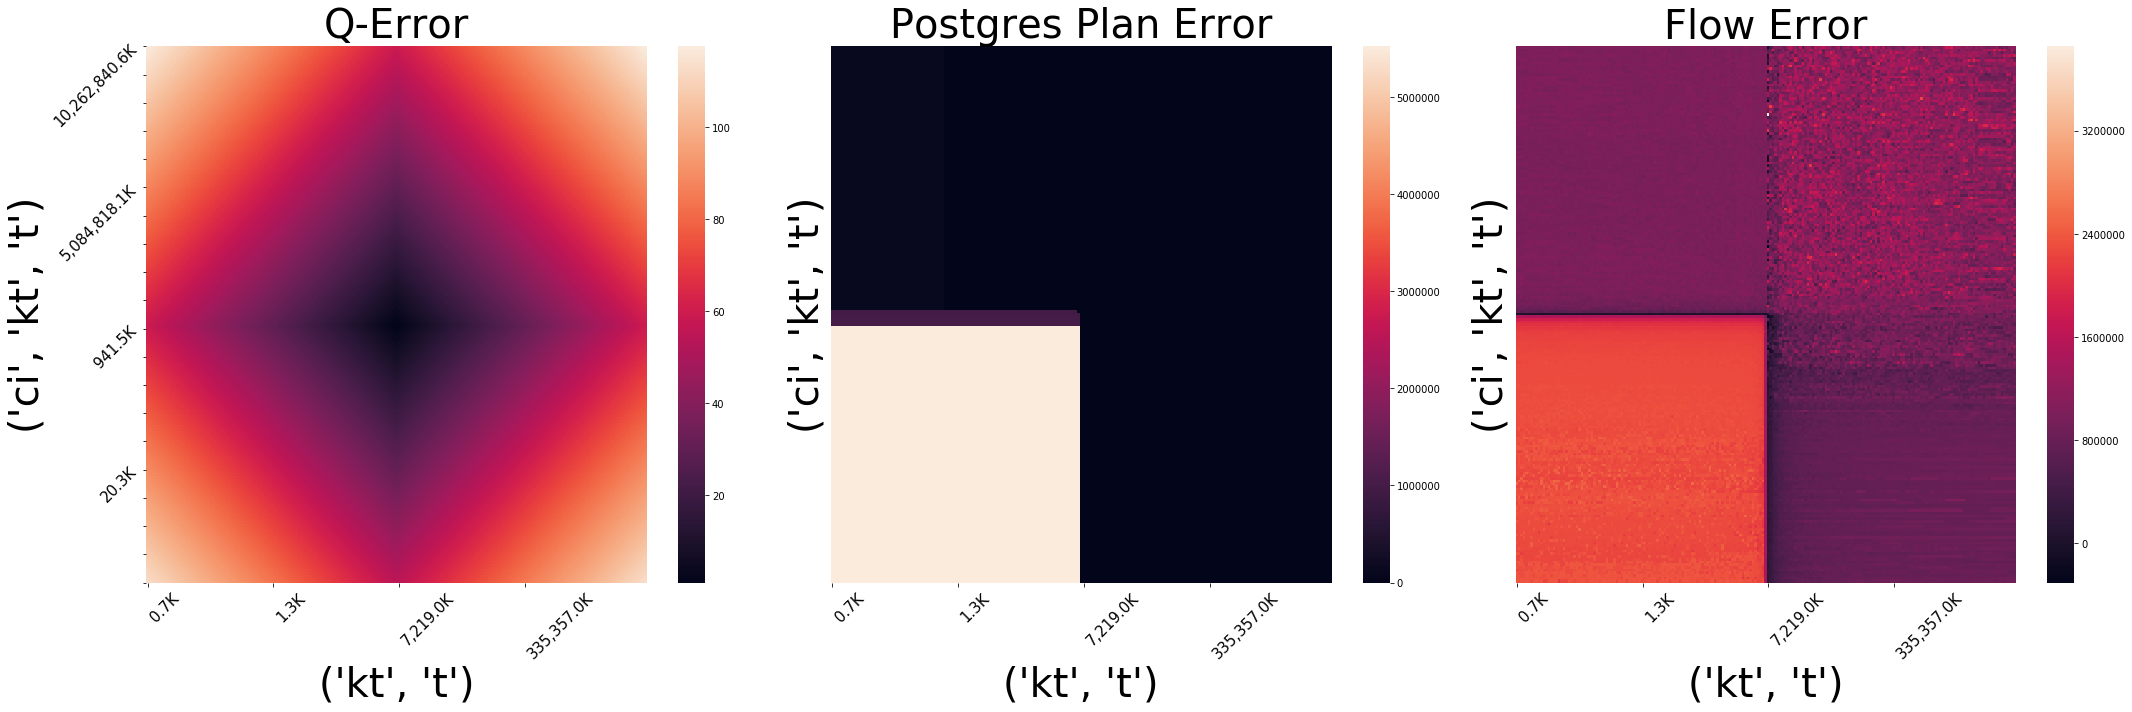

In [142]:
def set_labels(hm, ax):
    #hm.set(xlabel=subsets1[0])
    #hm.set(ylabel=subsets2[0]) 
    ax.set_xlabel(subsets1[0], fontsize=40)
    ax.set_ylabel(subsets2[0], fontsize=40)

    xlabels = ['{:,.1f}'.format(float(item.get_text()) / 1000.0) + 'K' for item in ax.get_xticklabels()]
    ylabels = ['{:,.1f}'.format(float(item.get_text()) / 1000.0) + 'K' for item in ax.get_yticklabels()]
    hm.set_xticklabels(xlabels, rotation=45, ha='left', fontsize=15)
    hm.set_yticklabels(ylabels, rotation=45, ha='right', fontsize=15)
    
    every_nth = 5
    for n, label in enumerate(ax.yaxis.get_ticklabels()):
        if n % every_nth != 0:
            label.set_visible(False)


def plot_subsets2(subsets):
    #xs,ys,qerrs,flow_errs,plan_errs,pg_errs = data2[subsets]
    fig, axs = plt.subplots(1,3,figsize=(30,10))
    #subsets1.sort()
    #subsets2.sort()
    #subsets_key = str(subsets1) + str(subsets2)
    xs,ys,qerrs,flow_errs,plan_errs,pg_errs = data2[subsets]
    xs = np.array(xs)
    ys = np.array(ys)
    
    df = pd.DataFrame({"x":xs,"y":ys,"qerr":qerrs, "ferr":flow_errs,"perr":plan_errs,"pg_err":pg_errs})
    df2 = df.pivot_table(index='y', columns='x', values='qerr', aggfunc="mean")
    df2 = df2.sort_values(by="y",ascending=False)
    df2 = df2.sort_index(axis=1)

    hm = sns.heatmap(df2, ax=axs[0],xticklabels=50,yticklabels=10)
    #hm.set(title="Q-Error")
    axs[0].set_title("Q-Error",fontsize=40)
    set_labels(hm, axs[0])

    df2 = df.pivot_table(index='y', columns='x', values='pg_err', aggfunc="mean")
    df2 = df2.sort_values(by="y",ascending=False)
    df2 = df2.sort_index(axis=1)
    
    hm = sns.heatmap(df2, ax=axs[1], xticklabels=50,yticklabels=False)
    
    #hm.set(title="Postgres Error")
    axs[1].set_title("Postgres Plan Error",fontsize=40)
    set_labels(hm, axs[1])

    #df2 = df.pivot_table(index='y', columns='x', values='perr', aggfunc="mean")
    #df2 = df2.sort_values(by="y",ascending=False)
    #df2 = df2.sort_index(axis=1)  
    #hm = sns.heatmap(df2, ax=axs[2], xticklabels=50,yticklabels=False)   
    #hm.set(title="Plan Error")
    #axs[2].set_title("Simple Plan Error",fontsize=40)
    #set_labels(hm, axs[2])

    df2 = df.pivot_table(index='y', columns='x', values='ferr', aggfunc="mean")
    df2 = df2.sort_values(by="y",ascending=False)
    df2 = df2.sort_index(axis=1)   
    hm = sns.heatmap(df2, ax=axs[-1], xticklabels=50, yticklabels=False)
    #hm.set(title="Flow Error")
    axs[-1].set_title("Flow Error", fontsize=40)
    set_labels(hm, axs[-1])
    plt.tight_layout()

    plt.savefig("error-heatmap.png")

ytrue = y[0][subsets1[0]]
ytrue2 = y[0][subsets2[0]]
print(ytrue, ytrue2)

for subset in data2:
    plot_subsets2(subset)

In [72]:
print(data2.keys())
#subsets1.sort()
#subsets2.sort()
#subsets_key = str(subsets1) + str(subsets2)
subsets_key = list(data2.keys())[0]
xs,ys,qerrs,flow_errs,plan_errs,pg_errs = data2[subsets_key]
df = pd.DataFrame({"x":xs,"y":ys,"qerr":qerrs, "ferr":flow_errs,"perr":plan_errs,"pg_err":pg_errs})

print(ytrue, ytrue2)
print(np.min(xs), np.max(xs))
print(np.min(ys), np.max(ys))

print(len(xs), len(np.unique(xs)))
print(len(ys), len(np.unique(ys)))

df2 = df.pivot_table(index='x', columns='y', values='perr')
#len(df2.values)
print(df2.index)
df2 = df2.sort_values(by="x")
df2.index = np.round(df2.index, 1)
#df2["y"] = np.round(df2["y"].values, 1)
df2.columns = np.round(df2.columns, 1)
print(df2.columns)
print("postgres errors: ")
print(np.min(pg_errs), np.max(pg_errs))

dict_keys(["[('ci', 'n'), ('ci', 't')]"])
8513290 35834888
4308.345141700405 16822261040.0
18135.064777327934 70809738688.0
25600 159
25600 159
Float64Index([ 4308.345141700405,  4363.552024602768, 4420.1921079958465,
               4478.321935823251,  4538.001066098081,  4599.292274446245,
              4662.2617743702085,  4726.979455857857,  4793.519144144144,
               4861.958880639634,
              ...
                   14906770790.0,      15119603040.0,      15332435290.0,
                   15545267540.0,      15758099790.0,      15970932040.0,
                   16183764290.0,      16396596540.0,      16609428790.0,
                   16822261040.0],
             dtype='float64', name='x', length=159)
Float64Index([      18135.1,       18367.4,       18605.9,       18850.5,
                    19101.8,       19359.7,       19624.8,       19897.2,
                    20177.3,       20465.4,
              ...
              62746888888.0, 63642761088.0, 64538633288.0, 6543

trying to reverse edge directions!


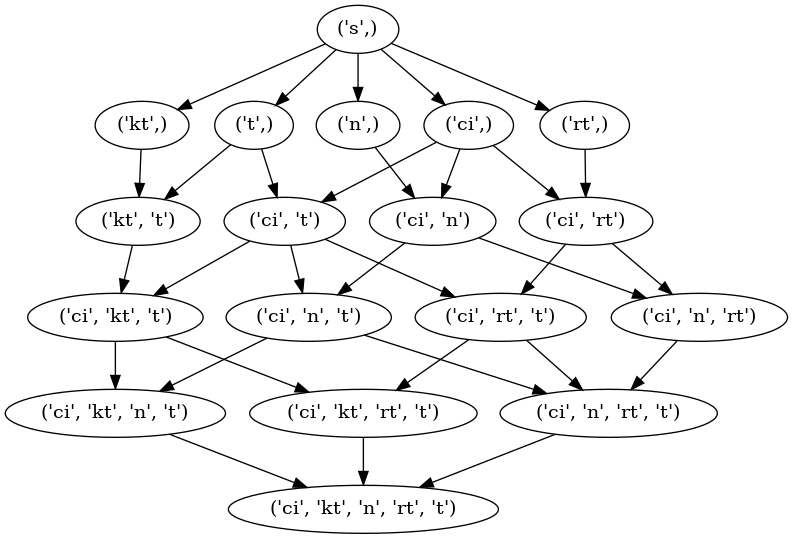

In [304]:
subsetg = copy.deepcopy(qrep["subset_graph"])
#add_single_node_edges(subsetg)
qrep["subset_graph"] = subsetg
final_node = [n for n,d in subsetg.in_degree() if d==0][0]
source_node = tuple("s")
fn = SAVE_DIR + "SubqueryGraphWithoutSource.png"
draw_graph(subsetg, save_to=fn)

trying to reverse edge directions!


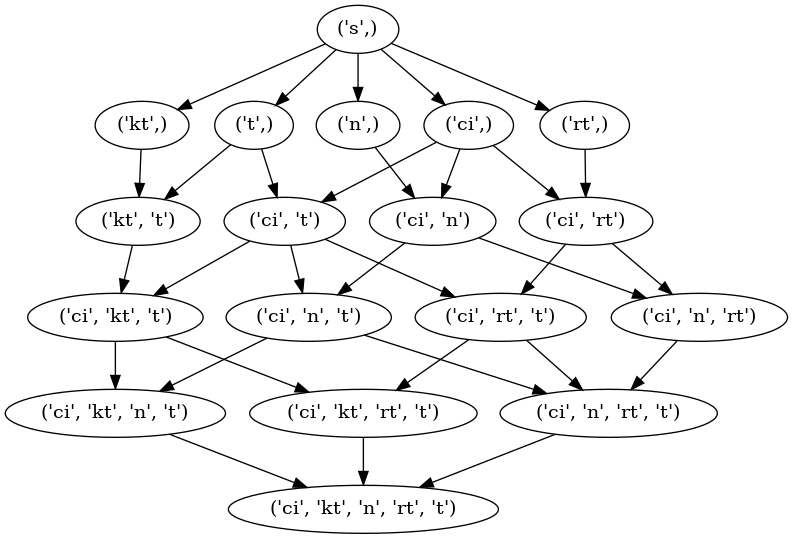

In [305]:
subsetg = copy.deepcopy(qrep["subset_graph"])
add_single_node_edges(subsetg)
qrep["subset_graph"] = subsetg
final_node = [n for n,d in subsetg.in_degree() if d==0][0]
source_node = tuple("s")
fn = SAVE_DIR + "SubqueryGraphWithSource.png"
draw_graph(subsetg, save_to=fn)

trying to reverse edge directions!


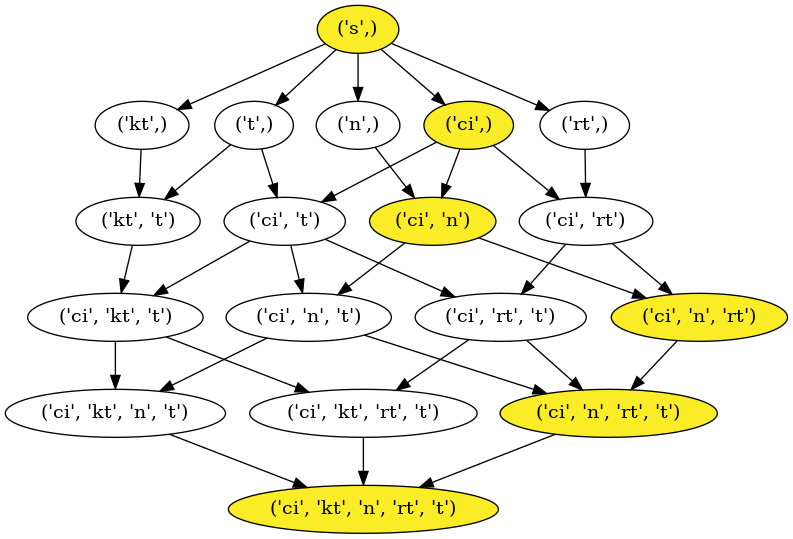

In [306]:
COST_MODEL = "cm1"

compute_costs(subsetg, COST_MODEL)
# we need to recalculate the weights here
path = nx.shortest_path(subsetg, final_node, source_node, weight=COST_MODEL + "cost")
fn = SAVE_DIR + "SubqueryGraphShortestPath.png"
draw_graph(subsetg, highlight_nodes=path, save_to=fn)

In [307]:
path = path[0:-1]
print(path)
join_order = [tuple(sorted(x)) for x in path_to_join_order(path)]
join_order.reverse()
sql_to_exec = nodes_to_sql(join_order, join_graph)
#sql_to_exec = sql_to_exec.replace("title as t CROSS JOIN kind_type as kt", "kind_type as kt CROSS JOIN title as t")
#print(sql_to_exec)
#sql_to_exec = fix_query(sql_to_exec)
print(sql_to_exec)

[('ci', 'kt', 'n', 'rt', 't'), ('ci', 'n', 'rt', 't'), ('ci', 'n', 'rt'), ('ci', 'n'), ('ci',)]
SELECT COUNT(*) FROM cast_info as ci CROSS JOIN name as n CROSS JOIN role_type as rt CROSS JOIN title as t CROSS JOIN kind_type as kt WHERE  kt.kind IN ('movie') AND  n.gender IN ('f') AND  rt.role IN ('actor', 'director') AND  t.production_year <= 2015 AND ci.person_id = n.id AND ci.role_id = rt.id AND t.id = ci.movie_id AND t.kind_id = kt.id


In [308]:
cost_sql, est_cost, est_explain = get_join_cost_sql(sql_to_exec, None, y[0], join_graph, "ubuntu", "", "localhost", 5432, "imdb", 
                                                    COST_MODEL)
jerr = est_cost - opt_cost
jerr_ratio = est_cost / opt_cost
print("est_cost: {}, opt_cost: {}, jerr: {}, jerr_ratio: {}".format(est_cost, opt_cost, jerr, jerr_ratio))
extract_values(est_explain[0][0], "Node Type")
print(est_explain)
#print(cost_sql)


est_cost: 1241631.28, opt_cost: 713234.99, jerr: 528396.29, jerr_ratio: 1.7408445987766248
[([{'Plan': {'Node Type': 'Aggregate', 'Strategy': 'Plain', 'Partial Mode': 'Simple', 'Parallel Aware': False, 'Startup Cost': 1241631.27, 'Total Cost': 1241631.28, 'Plan Rows': 1, 'Plan Width': 8, 'Plans': [{'Node Type': 'Hash Join', 'Parent Relationship': 'Outer', 'Parallel Aware': False, 'Join Type': 'Inner', 'Startup Cost': 101693.94, 'Total Cost': 1241554.34, 'Plan Rows': 30772, 'Plan Width': 0, 'Inner Unique': True, 'Hash Cond': '(t.kind_id = kt.id)', 'Plans': [{'Node Type': 'Nested Loop', 'Parent Relationship': 'Outer', 'Parallel Aware': False, 'Join Type': 'Inner', 'Startup Cost': 101692.84, 'Total Cost': 1241175.75, 'Plan Rows': 89574, 'Plan Width': 4, 'Inner Unique': True, 'Plans': [{'Node Type': 'Hash Join', 'Parent Relationship': 'Outer', 'Parallel Aware': False, 'Join Type': 'Inner', 'Startup Cost': 101692.41, 'Total Cost': 1199933.27, 'Plan Rows': 90695, 'Plan Width': 4, 'Inner Uniq

cm1


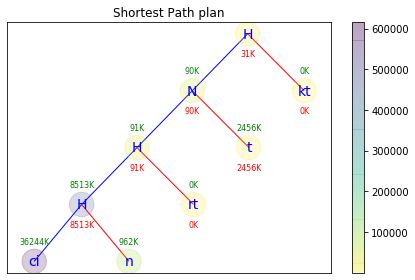

In [309]:
plot_explain_join_order(est_explain, y[0], y[0], None, "Shortest Path plan")
plt.show()
print(COST_MODEL)

In [310]:
costs = extract_values(est_explain[0][0], "Total Cost")
node_types = extract_values(est_explain[0][0], "Node Type")

#print(len(costs))
print(node_types)
print(costs)

['Aggregate', 'Hash Join', 'Nested Loop', 'Hash Join', 'Hash Join', 'Seq Scan', 'Hash', 'Bitmap Heap Scan', 'Bitmap Index Scan', 'Hash', 'Seq Scan', 'Index Scan', 'Hash', 'Seq Scan']
[1241631.28, 1241554.34, 1241175.75, 1199933.27, 1169692.18, 615130.44, 85819.56, 85819.56, 17872.03, 1.15, 1.15, 0.45, 1.09, 1.09]


In [311]:
edges, c, A, b, G, h = construct_lp(subsetg, cost_key=COST_KEY)

In [312]:
print(A.shape)
print("A rank: ", np.linalg.matrix_rank(A))
print(b)
nodes = list(subsetg.nodes())
nodes.sort()

(18, 31)
A rank:  17
[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.]


In [313]:
start = time.time()
n = len(edges)
x = cp.Variable(n)
constraints = [A @ x == b, G @ x <= 0]
prob = cp.Problem(cp.Minimize(c.T@x), constraints)
prob.solve(verbose=True)
print(prob.value)
print(x.value)
print("linear program took: ", time.time()-start)


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +4.719e+07  +4.719e+07  +1e+08  2e-02  4e-01  1e+00  3e+06    ---    ---    1  1  - |  -  - 
 1  +3.352e+07  +3.639e+07  +2e+08  3e-01  4e-01  3e+06  5e+06  0.9890  8e-01   0  0  0 |  0  0
 2  +5.734e+06  +6.592e+06  +3e+07  2e-01  3e-02  9e+05  9e+05  0.9002  4e-02   0  0  0 |  0  0
 3  +6.807e+06  +6.830e+06  +3e+06  1e-01  1e-03  2e+04  1e+05  0.9890  3e-02   0  0  0 |  0  0
 4  +5.841e+06  +5.865e+06  +6e+06  8e-02  1e-03  2e+04  2e+05  0.5598  6e-01   0  0  1 |  0  0
 5  +8.855e+06  +8.860e+06  +1e+06  8e-02  1e-04  5e+03  3e+04  0.9109  4e-02   0  0  1 |  0  0
 6  +9.458e+06  +9.463e+06  +8e+05  7e-02  9e-05  4e+03  2e+04  0.4715  3e-01   0  1  1 |  0  0
 7  +8.933e+06  +8.938e+06  +1e+06  4e-02  9e-05  6e+03  4e+04  0.2715  8e-01   0  1  1 |  0  0
 8  +9.667e+06  +9.668e+06  +1e+05  2e-02  8e-

(('ci',), ('s',)) <class 'tuple'>
(('ci', 'kt', 'n', 'rt', 't'), ('ci', 'kt', 'n', 't')) <class 'tuple'>
(('ci', 'kt', 'n', 'rt', 't'), ('ci', 'kt', 'rt', 't')) <class 'tuple'>
(('ci', 'kt', 'n', 'rt', 't'), ('ci', 'n', 'rt', 't')) <class 'tuple'>
(('ci', 'kt', 'n', 't'), ('ci', 'kt', 't')) <class 'tuple'>
(('ci', 'kt', 'n', 't'), ('ci', 'n', 't')) <class 'tuple'>
(('ci', 'kt', 'rt', 't'), ('ci', 'kt', 't')) <class 'tuple'>
(('ci', 'kt', 'rt', 't'), ('ci', 'rt', 't')) <class 'tuple'>
(('ci', 'kt', 't'), ('ci', 't')) <class 'tuple'>
(('ci', 'kt', 't'), ('kt', 't')) <class 'tuple'>
(('ci', 'n'), ('ci',)) <class 'tuple'>
(('ci', 'n'), ('n',)) <class 'tuple'>
(('ci', 'n', 'rt'), ('ci', 'n')) <class 'tuple'>
(('ci', 'n', 'rt'), ('ci', 'rt')) <class 'tuple'>
(('ci', 'n', 'rt', 't'), ('ci', 'n', 'rt')) <class 'tuple'>
(('ci', 'n', 'rt', 't'), ('ci', 'n', 't')) <class 'tuple'>
(('ci', 'n', 'rt', 't'), ('ci', 'rt', 't')) <class 'tuple'>
(('ci', 'n', 't'), ('ci', 'n')) <class 'tuple'>
(('ci', 'n

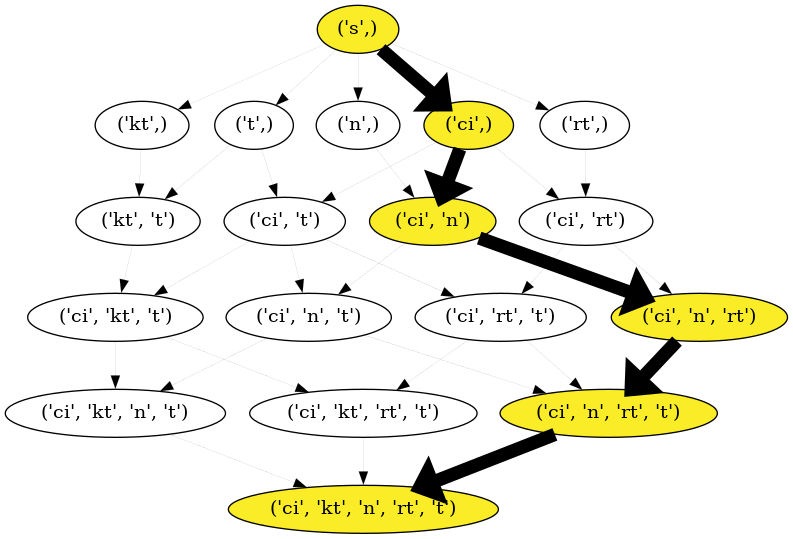

In [314]:
solx = np.array(x.value)
#draw_graph(subsetg, highlight_nodes=best_path_nodes, edge_widths=edge_widths)
fn = SAVE_DIR + "SubqueryGraphLinearProgram.png"
#draw_graph(subsetg, highlight_nodes=path, save_to=fn)
plot_flow_path(edges, subsetg, solx, final_node, source_node, fn)

In [315]:
edges, costs, A, b, G, h = construct_lp(subsetg, cost_key=COST_KEY)

n = len(edges)
P = np.zeros((len(edges),len(edges)))
for i,c in enumerate(costs):
    P[i,i] = c
    
q = np.zeros(len(edges))
x = cp.Variable(n)
#prob = cp.Problem(cp.Minimize((1/2)*cp.quad_form(x, P) + q.T @ x),
#                 [G @ x <= h,
#                  A @ x == b])
prob = cp.Problem(cp.Minimize((1/2)*cp.quad_form(x, P) + q.T @ x),
                 [A @ x == b])
prob.solve(verbose=True)
qsolx = np.array(x.value)
print(qsolx)

-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 31, constraints m = 18
          nnz(P) + nnz(A) = 93
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.00e+00   1.10e+07   1.00e-01   1.18e-04s
  50   1.2350e+06   1.48e-09   1.48e-04   1.00e-01   4.14e-04s
plsh   1.2350e+06   8.88e-17   5.14e-10   ------

(('ci',), ('s',)) <class 'tuple'>
(('ci', 'kt', 'n', 'rt', 't'), ('ci', 'kt', 'n', 't')) <class 'tuple'>
(('ci', 'kt', 'n', 'rt', 't'), ('ci', 'kt', 'rt', 't')) <class 'tuple'>
(('ci', 'kt', 'n', 'rt', 't'), ('ci', 'n', 'rt', 't')) <class 'tuple'>
(('ci', 'kt', 'n', 't'), ('ci', 'kt', 't')) <class 'tuple'>
(('ci', 'kt', 'n', 't'), ('ci', 'n', 't')) <class 'tuple'>
(('ci', 'kt', 'rt', 't'), ('ci', 'kt', 't')) <class 'tuple'>
(('ci', 'kt', 'rt', 't'), ('ci', 'rt', 't')) <class 'tuple'>
(('ci', 'kt', 't'), ('ci', 't')) <class 'tuple'>
(('ci', 'kt', 't'), ('kt', 't')) <class 'tuple'>
(('ci', 'n'), ('ci',)) <class 'tuple'>
(('ci', 'n'), ('n',)) <class 'tuple'>
(('ci', 'n', 'rt'), ('ci', 'n')) <class 'tuple'>
(('ci', 'n', 'rt'), ('ci', 'rt')) <class 'tuple'>
(('ci', 'n', 'rt', 't'), ('ci', 'n', 'rt')) <class 'tuple'>
(('ci', 'n', 'rt', 't'), ('ci', 'n', 't')) <class 'tuple'>
(('ci', 'n', 'rt', 't'), ('ci', 'rt', 't')) <class 'tuple'>
(('ci', 'n', 't'), ('ci', 'n')) <class 'tuple'>
(('ci', 'n

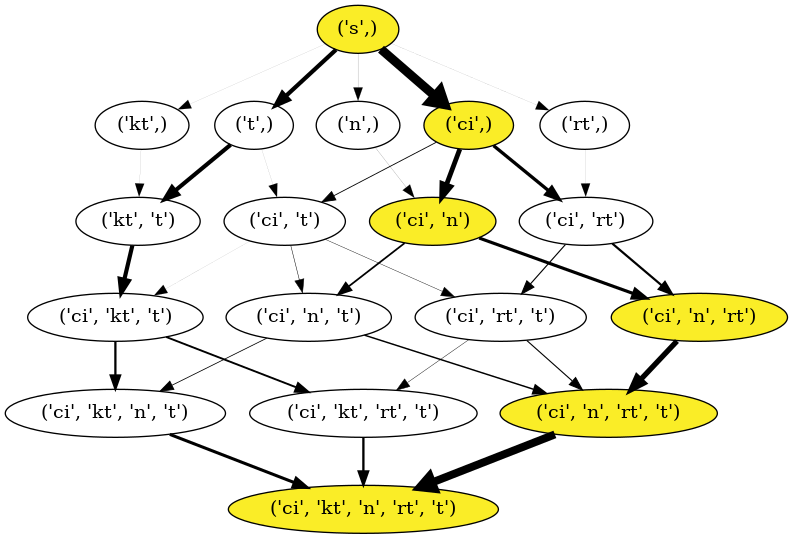

In [316]:
fn = SAVE_DIR + "SubqueryGraphQuadraticProgram.png"
plot_flow_path(edges, subsetg, qsolx, final_node, source_node, fn)

In [293]:
flow_cost, true_costs, Q2, G2, Gv2, v2, invG = debug_flow_loss(qrep, source_node, COST_KEY, COST_MODEL)
flows = Q2 @ v2
print(np.min(flows))
print(np.min(qsolx))

TypeError: get_subsetg_vectors() missing 1 required positional argument: 'cost_model'

In [213]:
print(np.allclose(costs, true_costs))
print(np.allclose(flows, qsolx))

print("actual solution off by a factor of 2")
print(prob.value*2)
print(flow_cost)

NameError: name 'true_costs' is not defined

In [209]:
plot_flow_path(edges, subsetg, flows, final_node, source_node)

NameError: name 'flows' is not defined

In [456]:
v2
np.mean(v2)

5827.691